## Mounting Drive

In [1]:
import os, sys

In [1]:
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# sys.path.append('/gdrive/MyDrive/Curie')

## Installing Libraries

In [2]:
# nb_path = '/content/curie'
# os.symlink('/gdrive/MyDrive/Curie', nb_path)
# sys.path.insert(0, nb_path) 

In [ ]:
!pip install --target=$nb_path --upgrade pydicom
!pip install --target=$nb_path --upgrade SimpleITK
!pip install --target=$nb_path --upgrade dicom2nifti

     ---------------------------------------- 1.8/1.8 MB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 27.0/27.0 MB 3.9 MB/s eta 0:00:00


## Importing Libraries

In [3]:
import os
import glob
import re
import pydicom as dicom
import matplotlib.pylab as plt
import pandas as pd
import cv2
from PIL import Image 
import numpy as np
import skimage
from skimage.io import imread, imsave, imshow
import SimpleITK as sitk
from pydicom import dcmread
import dicom2nifti
import nibabel as nib
from nibabel.testing import data_path
import time
import scipy.ndimage
import math
from pydicom.dataset import Dataset
from skimage import morphology
from math import sin, cos, radians

In [4]:
#move inside the main directory
working_directory = 'C:\\Users\\Enrico\\OneDrive - Politecnico di Milano\\PoliMi--Magistrale\\Secondo Anno\\Internship\\3D_work\\3D work'
os.chdir(working_directory)

## Functions

In [5]:
def rotate_point(point, angle, center_point=(0, 0)):
    """Rotates a point around center_point(origin by default)
    Angle is in degrees.
    Rotation is counter-clockwise
    """
    angle_rad = radians(angle % 360)
    # Shift the point so that center_poiabsnt becomes the origin
    new_point = (point[0] - center_point[0], point[1] - center_point[1])
    new_point = (new_point[0] * cos(angle_rad) - new_point[1] * sin(angle_rad),
                 new_point[0] * sin(angle_rad) + new_point[1] * cos(angle_rad))
    # Reverse the shifting we have done
    new_point = (new_point[0] + center_point[0], new_point[1] + center_point[1])
    return new_point      

def translated_coordinates(cx, cy, x, y, angle):
    if(x >= cx and y <= cy):
        new_x = (x - cx)
        new_y = (cy - y)
        point = [new_x, new_y]
        rotated_point = rotate_point(point, angle)
#         print("[INFO] Top Right - Original Point= (%f, %f), New Point= (%f, %f)" % (x, y, rotated_point[0] + cx, cy - rotated_point[1]))
        return (rotated_point[0] + cx), (cy - rotated_point[1])
        
    if(x >= cx and y >= cy):
        new_x = (x - cx)
        new_y = (cy - y)
        point = [new_x, new_y]
        rotated_point = rotate_point(point, angle)
#         print("[INFO] Bottom Right - Original Point= (%f, %f), New Point= (%f, %f)" % (x, y, rotated_point[0] + cx, cy - rotated_point[1]))
        return (rotated_point[0] + cx), (cy - rotated_point[1])
   
    if(x <= cx and y >= cy):
        new_x = (x - cx)
        new_y = (cy - y)
        point = [new_x, new_y]
        rotated_point = rotate_point(point, angle)
#         print("[INFO] Bottom Left - Original Point= (%f, %f), New Point= (%f, %f)" % (x, y, rotated_point[0] + cx, cy - rotated_point[1]))        
        return (rotated_point[0] + cx), (cy - rotated_point[1])
    
    if(x <= cx and y <= cy):
        new_x = (x - cx)
        new_y = (cy - y)
        point = [new_x, new_y]
        rotated_point = rotate_point(point, angle)
#         print("[INFO] Top Left - Original Point= (%f, %f), New Point= (%f, %f)" % (x, y, rotated_point[0] + cx, cy - rotated_point[1]))
        return (rotated_point[0] + cx), (cy - rotated_point[1])

In [6]:
def remove_objects(image_gray, min_size, max_size, min_size_bool=True, max_size_bool=True):

    # find all of the connected components (white blobs in your image).
    # im_with_separated_blobs is an image where each detected blob has a different pixel value ranging from 0 to nm_components.
    nb_components, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(image_gray)
    # stats (and the silenced output centroids) gives a lot of information about the components. See the docs for more information. Here, we're interested only in the size of the components.
    sizes = stats[:, -1]
    # the following lines result in taking out the background which is also considered a component, which I find for most applications to not be the expected output.
    sizes = sizes[1:]
    nb_components -= 1

    # output image with only the kept components
    im_result = np.zeros((image_gray.shape))
    # for every component in the image, keep it only if it's above min_size
    if min_size_bool==True:
        
        # minimum size of particles we want to keep (number of pixels).
        # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever.
        min_size = min_size  

        for comp in range(nb_components):
            if sizes[comp] < min_size:
                # see description of im_with_separated_blobs above
                im_result[im_with_separated_blobs == comp + 1] = 255
                
    if max_size_bool==True:
        
        # minimum size of particles we want to keep (number of pixels).
        # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever.
        max_size = max_size  

        for comp in range(nb_components):
            if sizes[comp] >= max_size:
                # see description of im_with_separated_blobs above
                im_result[im_with_separated_blobs == comp + 1] = 255

    return im_result


def noise_removal(image_name, min_size, max_size):
 
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    b_w_image = remove_objects(image_gray=image, min_size=min_size, max_size=max_size, min_size_bool=True, max_size_bool=False)
    b_w_image = b_w_image.astype(np.uint8)

    b_w_image = remove_objects(image_gray=b_w_image, min_size=min_size, max_size=max_size, min_size_bool=False, max_size_bool=True)
    b_w_image = b_w_image.astype(np.uint8)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
    open_mask = cv2.morphologyEx(b_w_image, cv2.MORPH_OPEN, kernel)
    masked_img = cv2.bitwise_and(b_w_image, b_w_image, mask = open_mask)

    b_w_image = remove_objects(image_gray=masked_img, min_size=min_size, max_size=max_size, min_size_bool=False, max_size_bool=True)
    b_w_image = b_w_image.astype(np.uint8)
    
#     kernel = np.ones((1,1),np.uint8)
#     dilation = cv2.dilate(masked_img, kernel, iterations = 1)
  
    im = Image.fromarray(b_w_image)
    im.save(image_name)
    

In [7]:
def get_abs_path_for_files(directory):
    result = []
    for root, dirs, files in os.walk(os.path.abspath(directory)):
        for file in files:
            result.append((os.path.join(root, file)))
    result.sort()
    return np.array(result)
    

def plot_images(images_list, columns=2, drr=True):
    tot_images = len(images_list)
    rows = tot_images // columns 
    if tot_images % columns != 0:
        rows += 1

    images_batch = []
    dicom_batch = []
    sitk_images = []
    images_names = []
    fig = plt.figure(figsize=(15, 15))
  
    for i in range(1, tot_images+1):
        ds = dicom.dcmread(images_list[i-1])  
        sitk_image = sitk.ReadImage(images_list[i-1])
        print(sitk_image)
        if drr==True:
            data_hu = dicom.pixel_data_handlers.util.apply_modality_lut(ds.pixel_array,ds)
        else:
            data_hu = dicom.pixel_data_handlers.util.apply_voi_lut( dicom.pixel_data_handlers.util.apply_modality_lut(ds.pixel_array,ds),ds)
        print(data_hu.shape)
        print(data_hu.dtype)
        data_hu = data_hu - np.min(data_hu)
        data_hu = data_hu / np.max(data_hu)
        data_hu_rescaled = (data_hu * 255).astype(np.uint8)

        fig.add_subplot(rows, columns, i)
        plt.imshow(data_hu_rescaled, cmap='gray')
        
        separators = images_list[i-1].split("\\")
        plt.title(separators[len(separators)-1])

        images_batch.append(data_hu_rescaled)
        dicom_batch.append(ds)
        sitk_images.append(sitk_image)
        images_names.append(separators[len(separators)-1])
        
    plt.savefig(separators[len(separators)-1]+".png") # save as png
    plt.show()


  # #this is for printing the histograms of the images
  # fig = plt.figure(figsize=(15, 15))
  # for i in range(1, tot_images+1):
  #   ds = dicom.dcmread(images_list[i-1])  
 
  #   data_hu = dicom.pixel_data_handlers.util.apply_modality_lut(ds.pixel_array,ds)
  #   data_hu = data_hu - np.min(data_hu)
  #   data_hu = data_hu / np.max(data_hu)
  #   data_hu_rescaled = (data_hu * 255).astype(np.uint8)

  #   fig.add_subplot(rows, columns, i)
  #   plt.xlabel("Houndsfield Units (HU)")
  #   plt.ylabel("Frequency")
  #   plt.hist(data_hu.ravel(), bins=50)

  #   separators = images_list[i-1].split("/")
  #   plt.title(separators[len(separators)-1])

  # plt.show()
    return np.asarray(images_batch), np.asarray(dicom_batch), sitk_images, np.asarray(images_names)


def resize_image(itkImage, newSpacing, originSpacing, resampleMethod=sitk.sitkLinear):
    newSpacing = np.array(newSpacing, float)
    resampler = sitk.ResampleImageFilter()
    originSize = itkImage.GetSize()
    factor = originSpacing / newSpacing
    newSize = originSize * factor
    newSize = newSize.astype(int)
    resampler.SetReferenceImage(itkImage)
    resampler.SetOutputSpacing(newSpacing.tolist())
    resampler.SetSize(newSize.tolist())
    resampler.SetTransform(sitk.Transform(2, sitk.sitkIdentity))
    resampler.SetInterpolator(resampleMethod)
    itkImageResampled = resampler.Execute(itkImage)
    
    DRR_sitk_nifti_scaled_array = sitk.GetArrayFromImage(itkImageResampled)
    return DRR_sitk_nifti_scaled_array.squeeze(), itkImageResampled


def rescale_drr_images(drr_sitk_batch):
    result_np_array = []
    result_sitk_array = []
    for image in drr_sitk_batch:
        image_rescaled_np, image_rescaled_sitk = resize_image(image, (epid_images_new_pixel_spacing, epid_images_new_pixel_spacing, 1), (drr_dicom_batch[0].ImagePlanePixelSpacing[0], drr_dicom_batch[0].ImagePlanePixelSpacing[1], 1))
        result_np_array.append(image_rescaled_np)
        result_sitk_array.append(image_rescaled_sitk)
    return np.asarray(result_np_array), result_sitk_array


def window_image(img, window_center, window_width, intercept, slope, rescale=True, drr=True):
    if(drr==False):
        img = img.pixel_array

    img = (img*slope + intercept)
    img_min = window_center - window_width / 2
    img_max = window_center + window_width / 2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    if rescale: 
        img = (img - img_min) / (img_max - img_min) * 255.0
    return img


def get_first_of_dicom_fields_as_int(x):
    if type(x) == dicom.multival.MultiValue: return int(x[0])
    else: return int(x)

    
def get_windowing(data):
    dicom_fields = [data[('0028', '1050')].value,
                     data[('0028', '1051')].value,
                     data[('0028', '1052')].value,
                     data[('0028', '1053')].value]
    return [get_first_of_dicom_fields_as_int(x) for x in dicom_fields]


def display_windowed_image(original_image, windowed_image, name, output_folder, drr=True):

    f, axarr = plt.subplots(1, 2, figsize = (20, 20))
    
    if drr==True:
        axarr[0].set_title(name)
        axarr[0].imshow(original_image, cmap='gray')
    
    if drr==False:
        axarr[0].set_title(name)
        axarr[0].imshow(dicom.pixel_data_handlers.apply_voi_lut(original_image.pixel_array, original_image), cmap='gray')
  
    temp = os.path.splitext(name)[0]
    temp = temp.replace('.', '_')
    temp = temp.replace(' ', '_')
        
    name_to_save = "Windowed_" + temp +'.tiff'
    name_to_save = output_folder +'/' + name_to_save
    axarr[1].set_title("Windowed " + name)
    axarr[1].imshow(windowed_image, cmap='gray')

    plt.imsave(name_to_save, windowed_image, cmap='gray')
    plt.show()
    return name_to_save
    
    
def super_res_lapsrn(image, image_name):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    start = time.time()
    bicubic = cv2.resize(image, (image.shape[1] * 8, image.shape[0] * 8), interpolation=cv2.INTER_CUBIC)
    end = time.time()
    print("[INFO] Image: ", image_name, "\n[INFO] Bicubic Interpolation Took {:.6f} seconds".format(end - start))
    
    f, axarr = plt.subplots(1, 2, figsize = (7, 7))
    axarr[0].imshow(image, cmap='gray')
    axarr[0].set_title("Original image 956 x 956")
    axarr[1].imshow(bicubic, cmap='gray')
    axarr[1].set_title("Upscaled Bicubic Interpolation")
    plt.show()
    
    name_to_save = image_name.replace('Windowed', 'Interpol')
    cv2.imwrite(name_to_save, bicubic)
    

## Dataset Preparation

Select the path of each folder. There must be 3 folders, one for portal images, one for drr images, and one for the radiotherapy plan.

In [8]:
path_epid_images = os.getcwd() + '\\PORTAL IMAGES'
path_drr_images = os.getcwd() + '\\THEORETICAL IMAGES'
path_rplan = os.getcwd() + '\\PLAN'

In [9]:
#list of all the files in each folder
drr_images_list = get_abs_path_for_files(path_drr_images)
epid_images_list = get_abs_path_for_files(path_epid_images)
rplan = get_abs_path_for_files(path_rplan)

Image (0000021AEE3DAB90)
  RTTI typeinfo:   class itk::Image<unsigned short,3>
  Reference Count: 1
  Modified Time: 1870
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1852
  UpdateMTime: 1866
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 1]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 1]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 1]
  Spacing: [0.976562, 0.976562, 1]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.976562 0 0
0 0.976562 0
0 0 1

  PointToIndexMatrix: 
1.024 0 0
0 1.024 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0000021AE8E1C770)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,unsigned short>
   

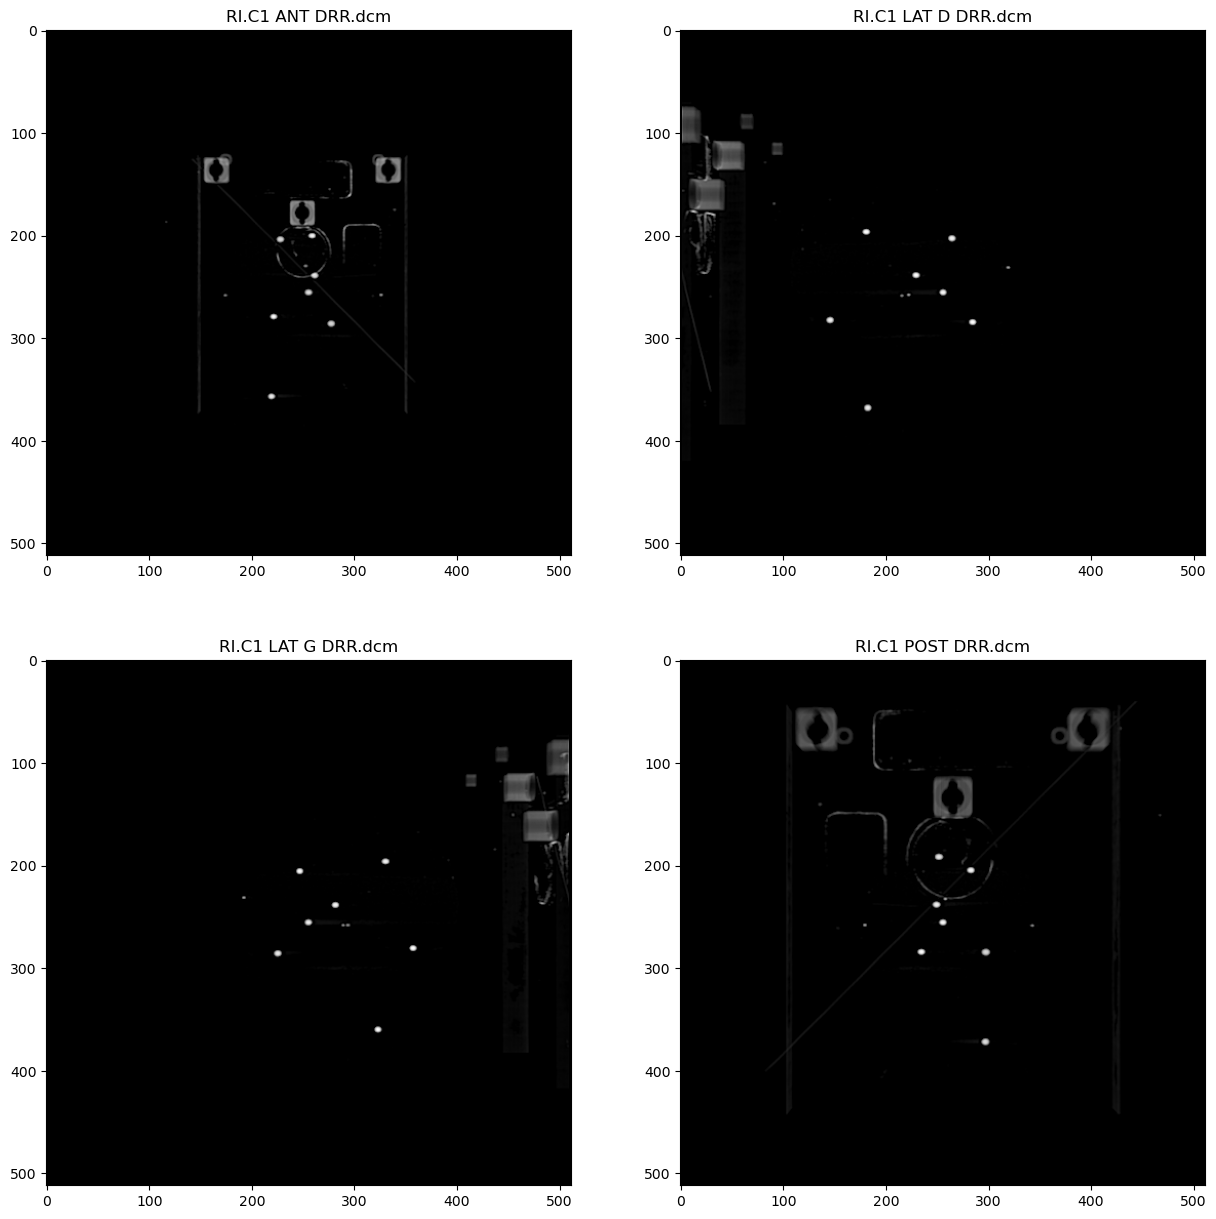

Image (0000021AEE3DDE30)
  RTTI typeinfo:   class itk::Image<unsigned short,3>
  Reference Count: 1
  Modified Time: 2710
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 2692
  UpdateMTime: 2706
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 384, 1]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 384, 1]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 384, 1]
  Spacing: [0.784, 0.784, 1]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.784 0 0
0 0.784 0
0 0 1

  PointToIndexMatrix: 
1.27551 0 0
0 1.27551 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0000021AE8B6AA50)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,unsigned short>
      Refer

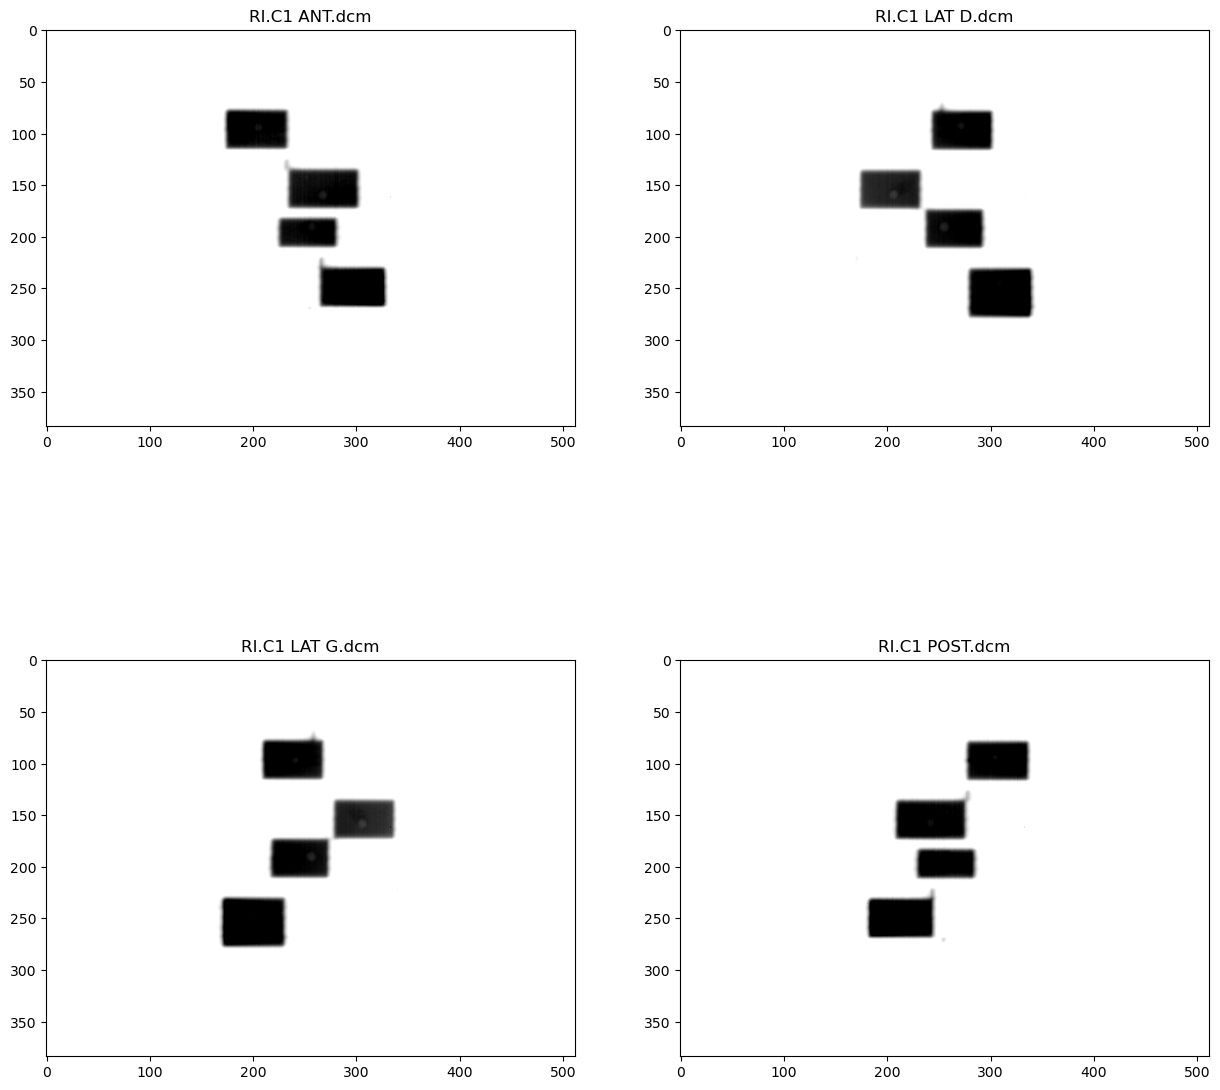

In [10]:
drr_images_batch, drr_dicom_batch, drr_images_sitk_batch, drr_images_names = plot_images(get_abs_path_for_files(path_drr_images))
portal_images_batch, epid_dicom_batch, epid_images_sitk_batch, epid_images_names = plot_images(get_abs_path_for_files(path_epid_images), drr=False)

## DRR - Rescale - Pixel Spacing

Since the DRR images and the EPID images were taken at different positions w.r.t source of the ray, (150mm and 100mm) it's necessary to bring them to the same plane and to bring them to the same value of pixel spacing. In particular we decide to bring the DRR to the same plane of EPID so that the image will be enlarged, and not the contrary since it would cause a loss of information. The following two block performs these operations performing a rescale of the image, that can is displayed after the second block.

In [11]:
#the equation would be the following: epid_pixel_spacing : epid_distanc_to_source = epid_pixel_spacing_new : drr_distanc_to_source
# -> in this case we are going to calculate the pixel spacing that the EPID would have if it was at the same plane of DRR
epid_images_new_pixel_spacing = epid_dicom_batch[0].ImagePlanePixelSpacing[0] * drr_dicom_batch[0].RTImageSID / epid_dicom_batch[0].RTImageSID

In [12]:
print(epid_images_new_pixel_spacing)

0.5226484334245819


In [13]:
drr_images_rescaled_batch, drr_images_rescaled_batch_sitk = rescale_drr_images(drr_images_sitk_batch)

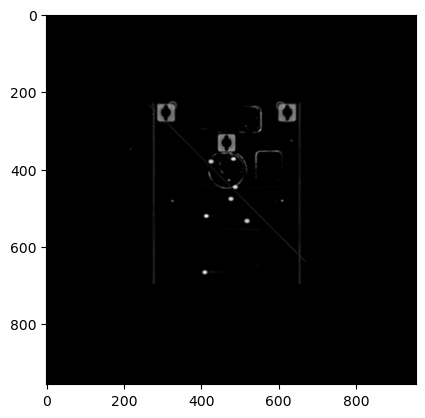

In [14]:
plt.imshow(drr_images_rescaled_batch[0], cmap='gray')
plt.show()

## DRR - Windowing 

In this block we're able to perform the windowing of the image. Selecting the desired value of Window Width and Window Center we can filter out all the unnecessary components of the image in order to see only the balls


Insert here the value of Window Width and Window Center:

In [15]:
WINDOW_WIDTH = 20000
WINDOW_CENTER = 25000

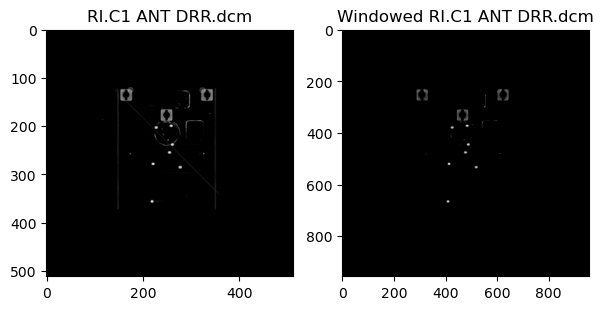

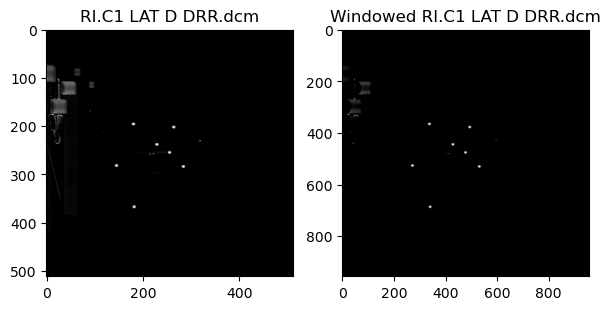

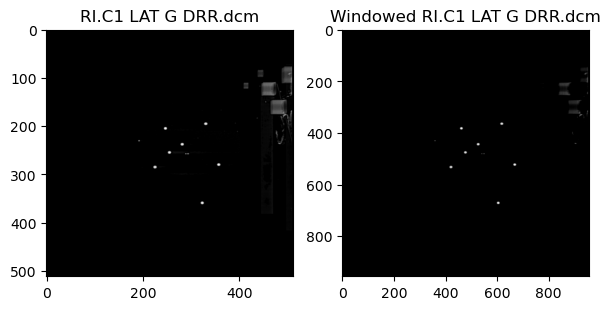

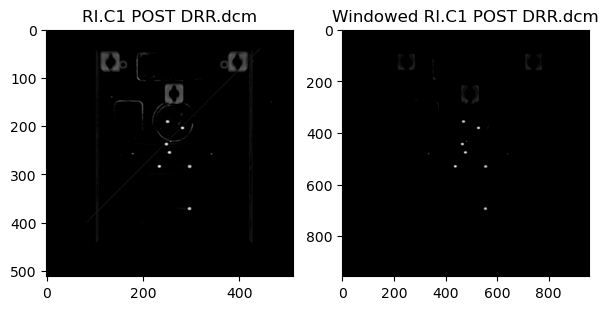

In [17]:
output_folder = 'DRR_windowed'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    
drr_images_windowed_batch = []
drr_images_windowed_names = []
for i in range(len(drr_images_batch)):
    window_center, window_width, intercept, slope = get_windowing(drr_dicom_batch[i])
    drr_windowed_image = window_image(drr_images_rescaled_batch[i], WINDOW_WIDTH, WINDOW_CENTER, intercept, slope, rescale=True, drr=True)
    new_name = display_windowed_image(drr_images_batch[i], drr_windowed_image, drr_images_names[i], output_folder)
    drr_images_windowed_batch.append(drr_windowed_image)
    drr_images_windowed_names.append(new_name)
drr_images_windowed_batch = np.asarray(drr_images_windowed_batch)

## DRR - Noise Removal

## DRR - Superscaling

Thanks to this block we are able to increase the resolution of the Image x8 times through a Neural Network. We do this in order to get more accurate results in measuring the distances. The value of the pixel will assume a lower pixel spacing leading to more accurate results.

The Process may take few minutes, it depends on the harware you are using

In [16]:
%pwd

'C:\\Users\\Enrico\\OneDrive - Politecnico di Milano\\PoliMi--Magistrale\\Secondo Anno\\Internship\\3D_work\\3D work'

[INFO] Image:  DRR_windowed/Windowed_RI_C1_ANT_DRR.tiff 
[INFO] Bicubic Interpolation Took 0.054686 seconds


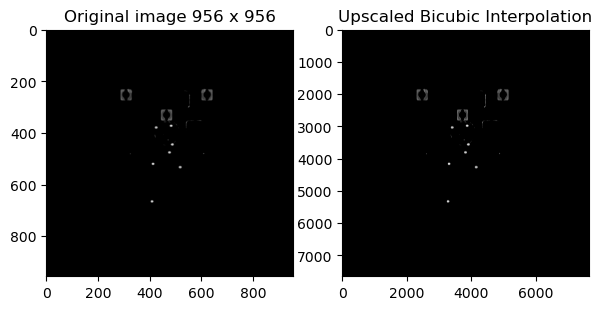

[INFO] Image:  DRR_windowed/Windowed_RI_C1_LAT_D_DRR.tiff 
[INFO] Bicubic Interpolation Took 0.031246 seconds


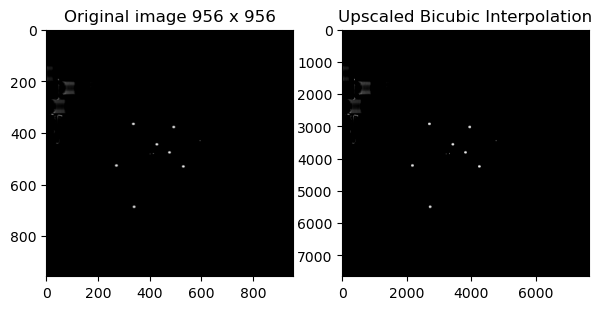

[INFO] Image:  DRR_windowed/Windowed_RI_C1_LAT_G_DRR.tiff 
[INFO] Bicubic Interpolation Took 0.031402 seconds


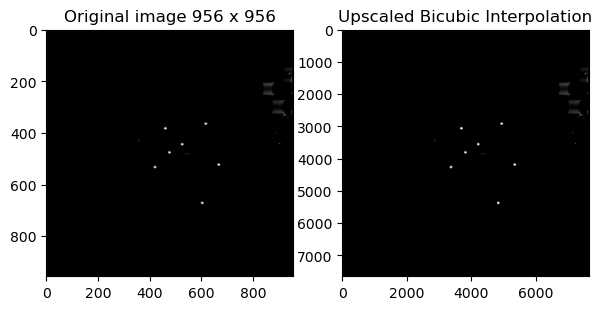

[INFO] Image:  DRR_windowed/Windowed_RI_C1_POST_DRR.tiff 
[INFO] Bicubic Interpolation Took 0.029152 seconds


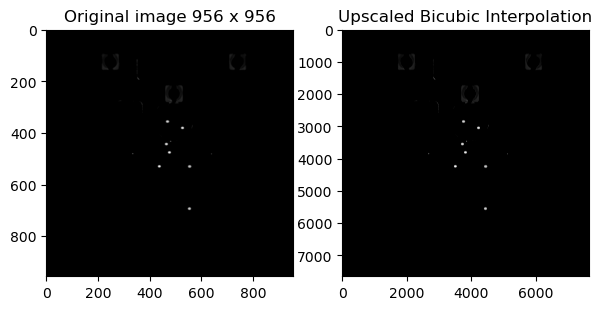

In [81]:
for i in drr_images_windowed_names:
    image = cv2.imread(i)
    super_res_lapsrn(image, i)

In [82]:
drr_images_interpol_windowed_names = list(set(glob.glob("DRR_windowed/Interpol*")) - (set(glob.glob("DRR_windowed/*Crop*")))) 
drr_images_interpol_windowed_names.sort()
drr_images_interpol_windowed_names

['DRR_windowed\\Interpol_RI_C1_ANT_DRR.tiff',
 'DRR_windowed\\Interpol_RI_C1_LAT_D_DRR.tiff',
 'DRR_windowed\\Interpol_RI_C1_LAT_G_DRR.tiff',
 'DRR_windowed\\Interpol_RI_C1_POST_DRR.tiff']

## EPID - Windowing

In this block we're able to perform the windowing of the image. Selecting the desired value of Window Width and Window Center we can filter out all the unnecessary components of the image in order to see only the balls.

<Figure size 1500x1500 with 0 Axes>

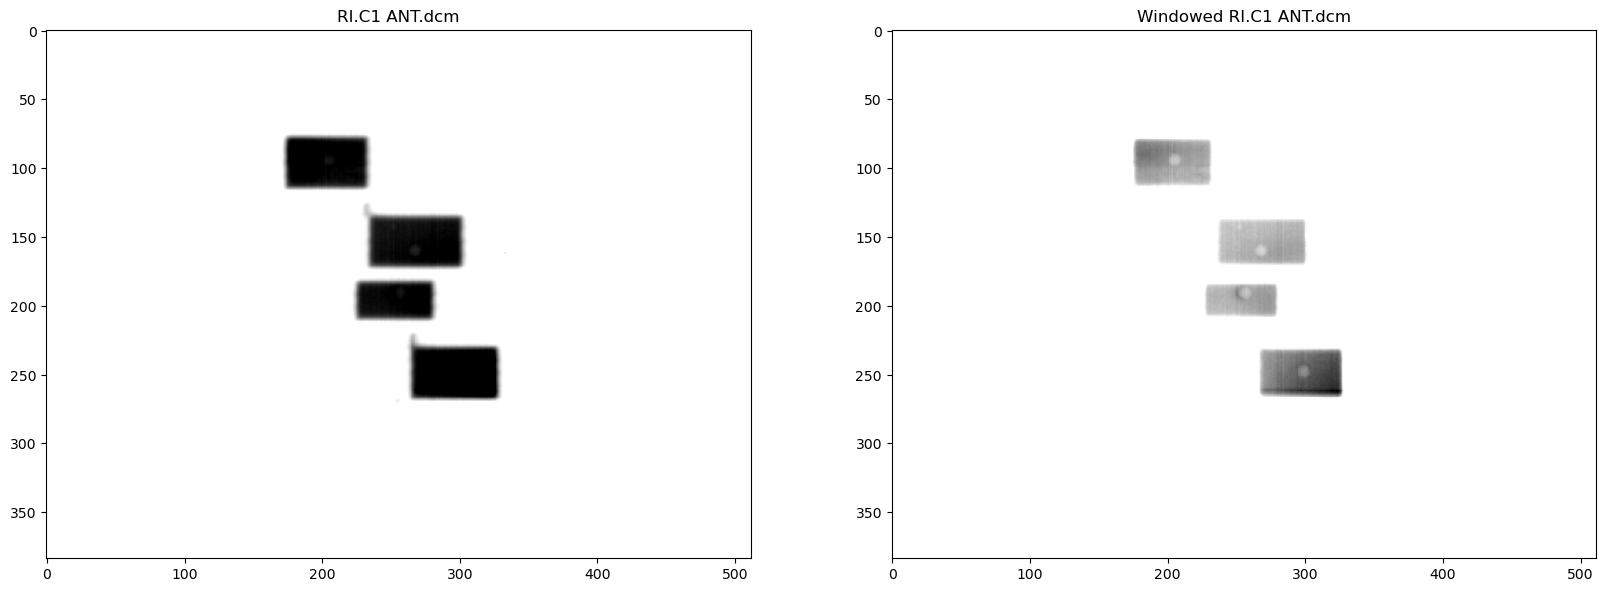

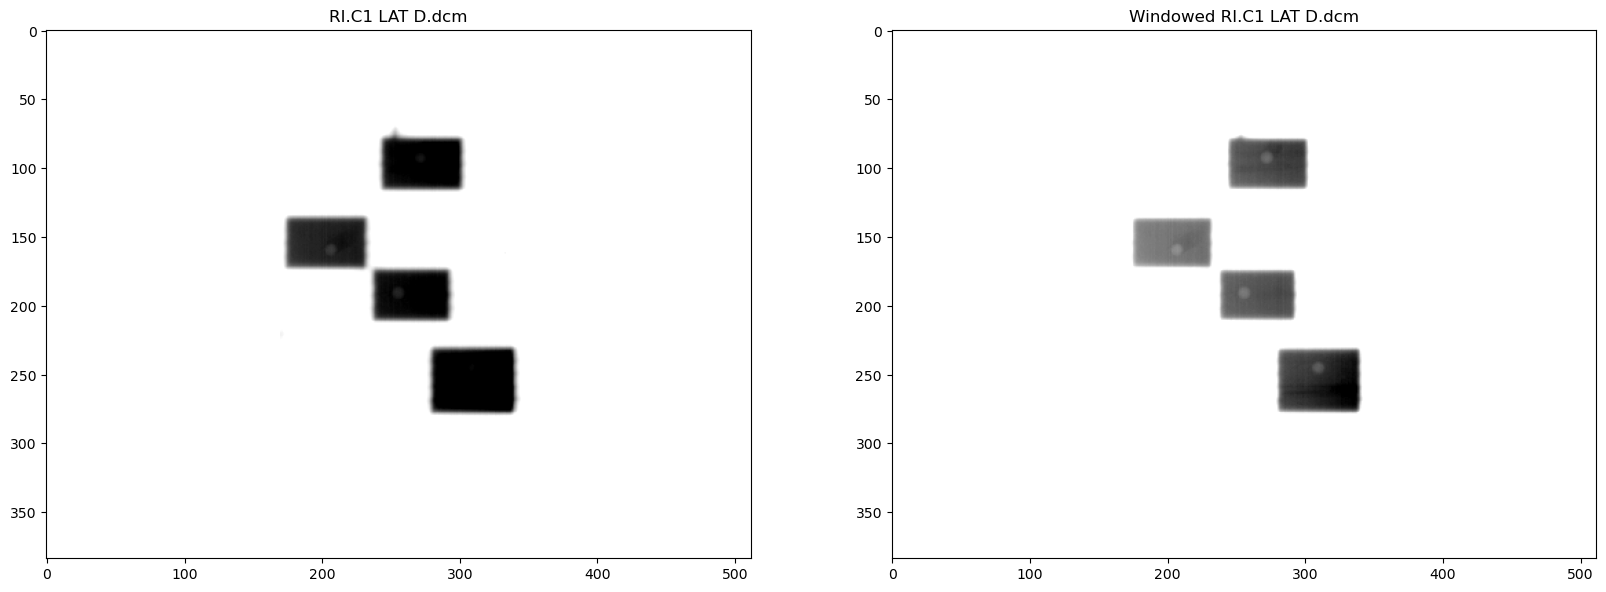

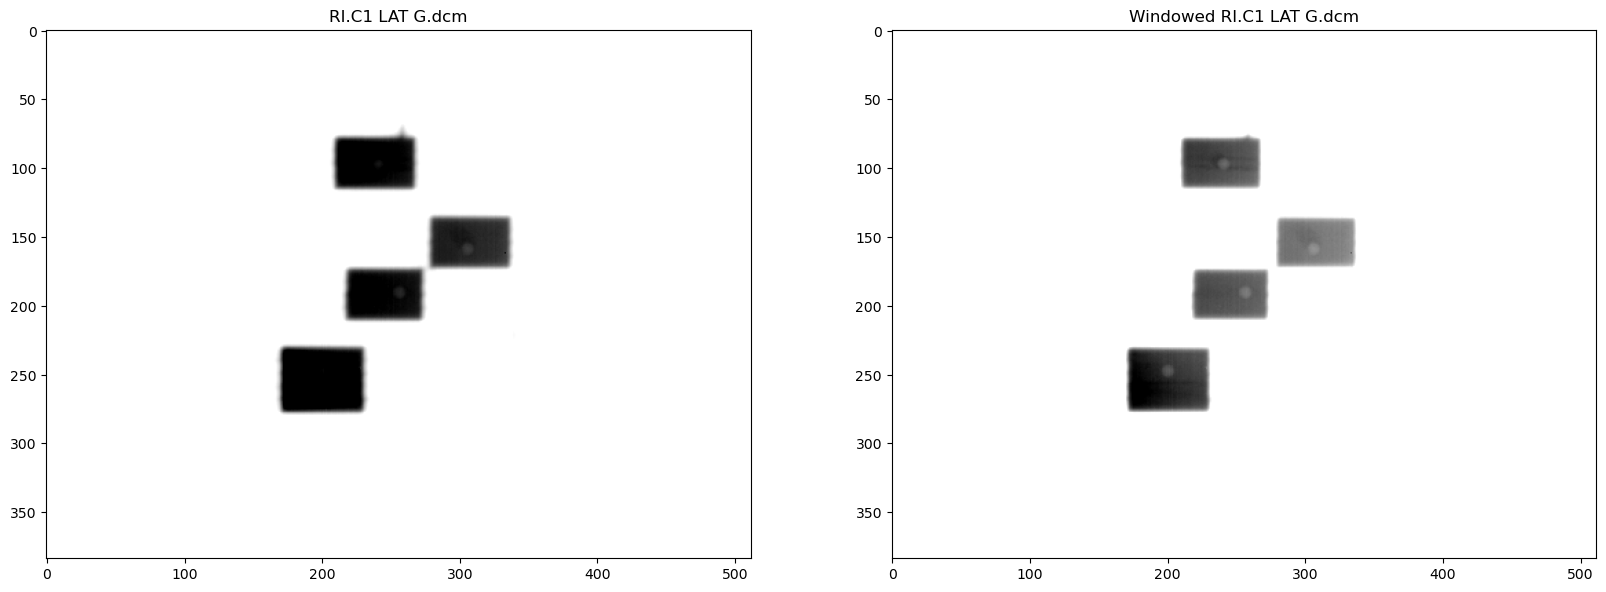

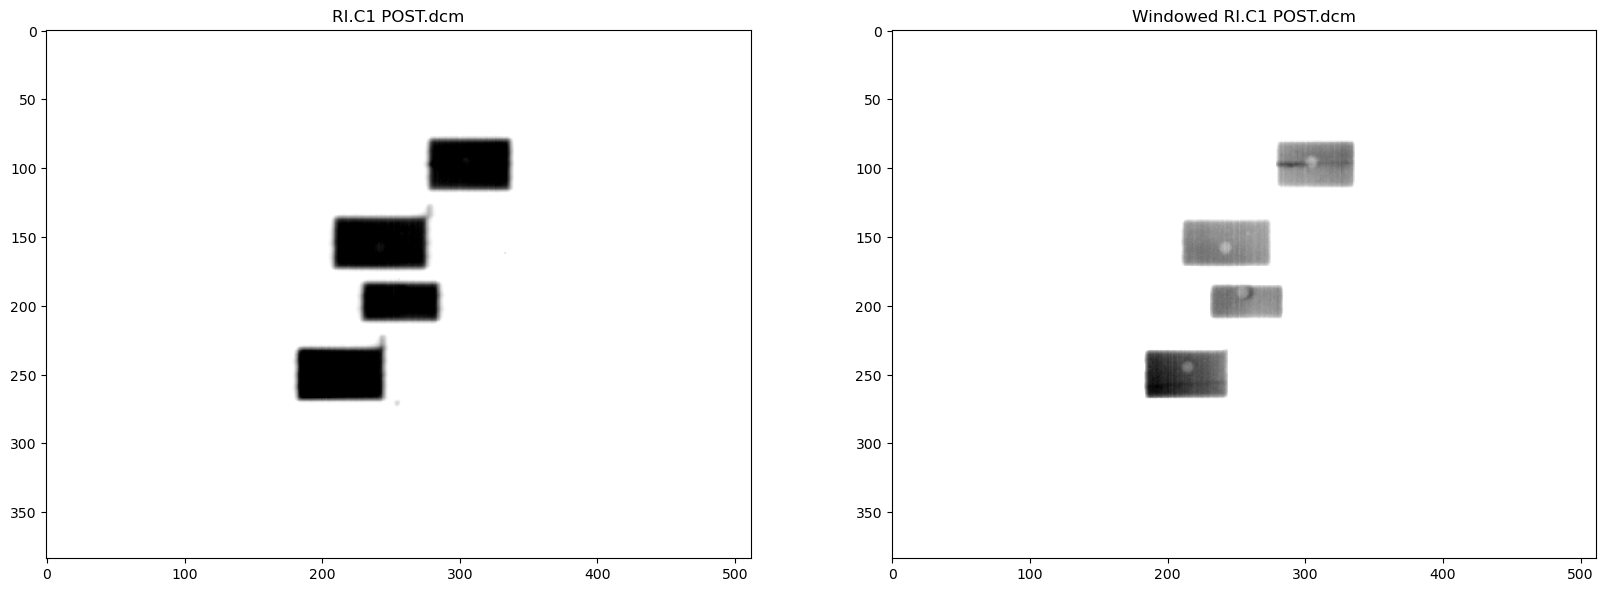

In [28]:
output_folder = 'EPID_windowed'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

epid_images_windowed_batch = []
epid_images_windowed_names = []

columns=2
tot_images = len(epid_dicom_batch)
rows = tot_images // columns 
if tot_images % columns != 0:
    rows += 1

fig = plt.figure(figsize=(15, 15))

j=1
for i in range(len(epid_dicom_batch)):
    j=j+1
    window_width, window_center, intercept, slope = get_windowing(epid_dicom_batch[i])
    
    if ('ANT' in epid_images_names[i]) and not('OPEN' in epid_images_names[i]):
        if 'MLC1' in epid_images_names[i]:
            WINDOW_WIDTH = window_width - 180
            WINDOW_CENTER = window_center + 200
        else:
            WINDOW_WIDTH = window_width - 500
            WINDOW_CENTER = window_center - 200
            
    if ('ANT' in epid_images_names[i]) and ('OPEN' in epid_images_names[i]):
        WINDOW_WIDTH = window_width + 732
        WINDOW_CENTER = window_center - 1812
        
    if ('LAT' in epid_images_names[i]) and not('OPEN' in epid_images_names[i]):
        WINDOW_WIDTH = window_width - 420
        WINDOW_CENTER = window_center
        
    if ('LAT' in epid_images_names[i]) and ('OPEN' in epid_images_names[i]):
        WINDOW_WIDTH = window_width + 300
        WINDOW_CENTER = window_center
        
    if ('OAD' in epid_images_names[i]):
        WINDOW_WIDTH = window_width - 450
        WINDOW_CENTER = window_center - 100
        
    epid_windowed_image = window_image(epid_dicom_batch[i], WINDOW_WIDTH, WINDOW_CENTER, intercept, slope, rescale=False, drr=False)
    new_name = display_windowed_image(epid_dicom_batch[i], epid_windowed_image, epid_images_names[i], output_folder, drr=False)
    epid_images_windowed_batch.append(epid_windowed_image)
    epid_images_windowed_names.append(new_name)
    
    
epid_images_windowed_batch = np.asarray(epid_images_windowed_batch)


In [84]:
epid_images_windowed_batch_normalized = []
for image in epid_images_windowed_batch:
    data_hu = image - np.min(image)
    data_hu = data_hu / np.max(data_hu)
    image_normalized = (data_hu * 255).astype(np.uint8)
    epid_images_windowed_batch_normalized.append(image_normalized)

## EPID - Superscaling

Thanks to this block we are able to increase the resolution of the Image x8 times through a Neural Network. We do this in order to get more accurate results in measuring the distances. The value of the pixel will assume a lower pixel spacing leading to more accurate results.

The Process may take few minutes, it depends on the harware you are using

[INFO] Image:  EPID_windowed/Windowed_RI_C1_ANT.tiff 
[INFO] Bicubic Interpolation Took 0.007056 seconds


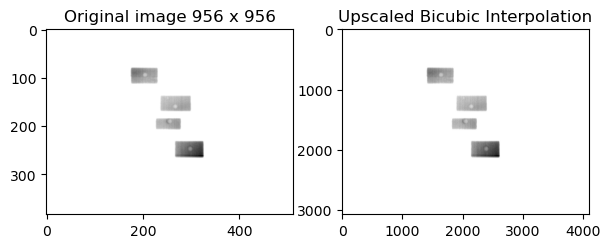

[INFO] Image:  EPID_windowed/Windowed_RI_C1_LAT_D.tiff 
[INFO] Bicubic Interpolation Took 0.003593 seconds


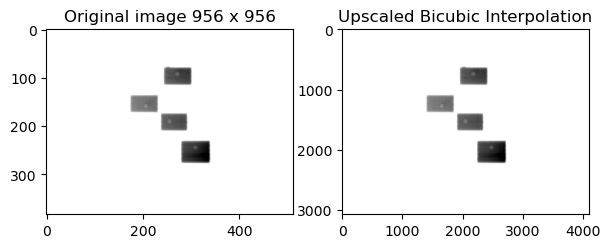

[INFO] Image:  EPID_windowed/Windowed_RI_C1_LAT_G.tiff 
[INFO] Bicubic Interpolation Took 0.000000 seconds


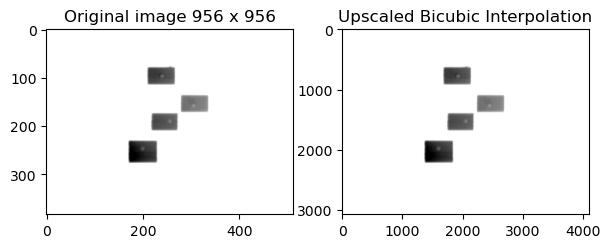

[INFO] Image:  EPID_windowed/Windowed_RI_C1_POST.tiff 
[INFO] Bicubic Interpolation Took 0.011509 seconds


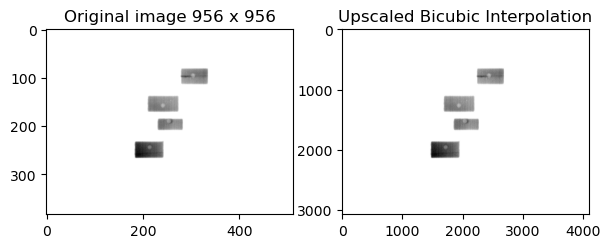

In [85]:
for i in epid_images_windowed_names:
    image = cv2.imread(i)
    super_res_lapsrn(image, i)

## EPID - Balls Selection

Thanks to this block we're able to select the balls we're interest in. Select only the balls we want to calculate the distances of and to register. Remember the positions of the one you select since the same balls will have to be selected in the EPID image. 

In [86]:
epid_images_interpol_windowed_names = list(set(glob.glob("EPID_windowed/Interpol*")) - set(glob.glob("EPID_windowed/*Crop*")))

In [87]:
epid_images_interpol_windowed_names.sort()
epid_images_interpol_windowed_names

['EPID_windowed\\Interpol_RI_C1_ANT.tiff',
 'EPID_windowed\\Interpol_RI_C1_LAT_D.tiff',
 'EPID_windowed\\Interpol_RI_C1_LAT_G.tiff',
 'EPID_windowed\\Interpol_RI_C1_POST.tiff']

In [139]:
lista = glob.glob("EPID_windowed/*Crop*")
for file in lista:
    os.remove(file)

In [88]:
EPID_crops = []

for i, image_name in zip(range(0, len(epid_images_windowed_names)) , epid_images_windowed_names):

    #read image
    img_raw = cv2.imread(image_name)

    #select ROIs function
    ROIs = cv2.selectROIs("Select Rois",img_raw)

    EPID_crops.append(ROIs)
    #print rectangle points of selected roi
    i = 0
    for roi in ROIs:
        print("Coordinates ROI number {}: {} \t".format(i, roi))
        i+=1
    #Crop selected roi ffrom raw image

    #counter to save image with different name
    crop_number=0 

    #loop over every bounding box save in array "ROIs"
    print("\nSelected ROIs for Image: ", image_name, "\n")
    for rect in ROIs:
        x1=rect[0]
        y1=rect[1]
        x2=rect[2]
        y2=rect[3]

        #crop roi from original image
        img_crop=img_raw[y1:y1+y2,x1:x1+x2]

            #show cropped image
        cv2.imshow("crop"+str(crop_number),img_crop)

        #save cropped image       
        crop_number+=1

    #hold window
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Coordinates ROI number 0: [197  85  16  21] 	
Coordinates ROI number 1: [261 151  17  19] 	
Coordinates ROI number 2: [249 184  14  16] 	
Coordinates ROI number 3: [289 240  19  16] 	

Selected ROIs for Image:  EPID_windowed/Windowed_RI_C1_ANT.tiff 

Coordinates ROI number 0: [263  83  17  19] 	
Coordinates ROI number 1: [199 153  14  12] 	
Coordinates ROI number 2: [247 183  15  17] 	
Coordinates ROI number 3: [304 239  13  14] 	

Selected ROIs for Image:  EPID_windowed/Windowed_RI_C1_LAT_D.tiff 

Coordinates ROI number 0: [233  89  17  16] 	
Coordinates ROI number 1: [300 150  13  18] 	
Coordinates ROI number 2: [248 183  15  16] 	
Coordinates ROI number 3: [192 240  16  14] 	

Selected ROIs for Image:  EPID_windowed/Windowed_RI_C1_LAT_G.tiff 

Coordinates ROI number 0: [294  87  22  18] 	
Coordinates ROI number 1: [236 150  13  18] 	
Coordinates ROI number 2: [246 186  16  11] 	
Coordinates ROI number 3: [208 237  14  16] 	

Selected ROIs for Image:  EPID_windowed/Windowed_RI_C1_POS

In [89]:
EPID_crops_read = np.asarray(EPID_crops)

## EPID - Saving the ROIs into text file for future usage (avoiding reselection)

In [37]:
np.save("EPID_ROIs.npy", EPID_crops_read)

In [63]:
np_load_old = np.load
EPID_crops_read = np_load_old('EPID_ROIs.npy', allow_pickle=True)

In [38]:
# text_file = open("EPID_ROIs.txt", "r")
# lines = text_file.readlines()

# EPID_crops_read = []
# for line in lines:
#     if line.startswith('[[') == True:
#         temp_arr=[]
        
#         line = line.replace(']', '')
#         line = line.replace('[', '')
#         desired_array = [int(numeric_string) for numeric_string in line.split('  ')]
#         temp_arr.append(desired_array)
#     elif line.endswith(']]\n') == True:       
#         line = line.replace(']', '')
#         line = line.replace('[', '')
#         desired_array = [int(numeric_string) for numeric_string in line.split('  ')]
#         temp_arr.append(desired_array)
#         EPID_crops_read.append(temp_arr)
#     else:
#         line = line.replace(']', '')
#         line = line.replace('[', '')
#         desired_array = [int(numeric_string) for numeric_string in line.split('  ')]
#         temp_arr.append(desired_array)

## EPID - Scaling the ROIs to the SuperScaled Image and Crop them

In this block we scale the selected ROI x8, bringing them to the same space dimension the the superscaled image. We are also able to see the selected ROIs. If we are not satisfied about the selections, go back to the previous block and repeat the process.  

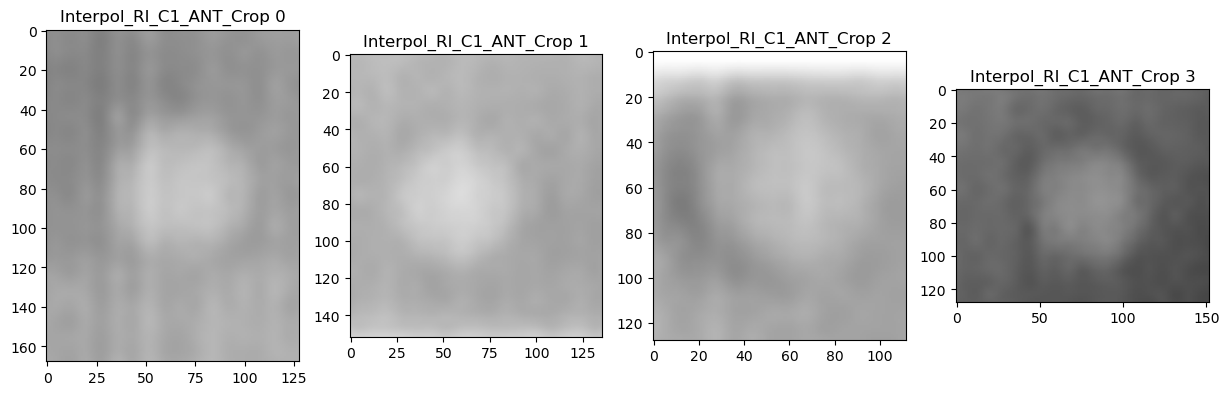

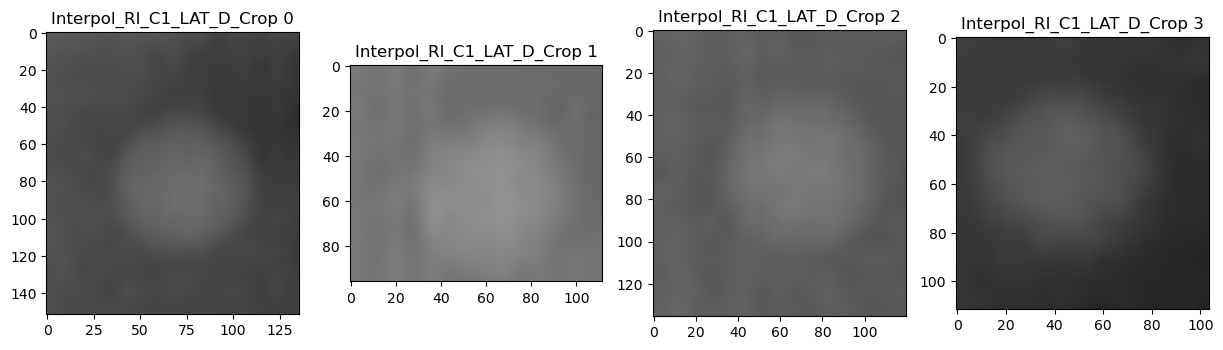

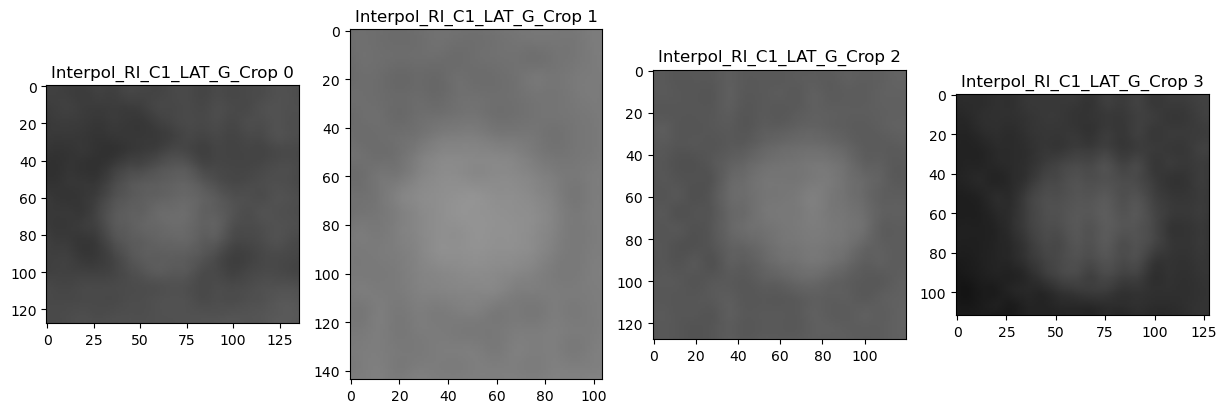

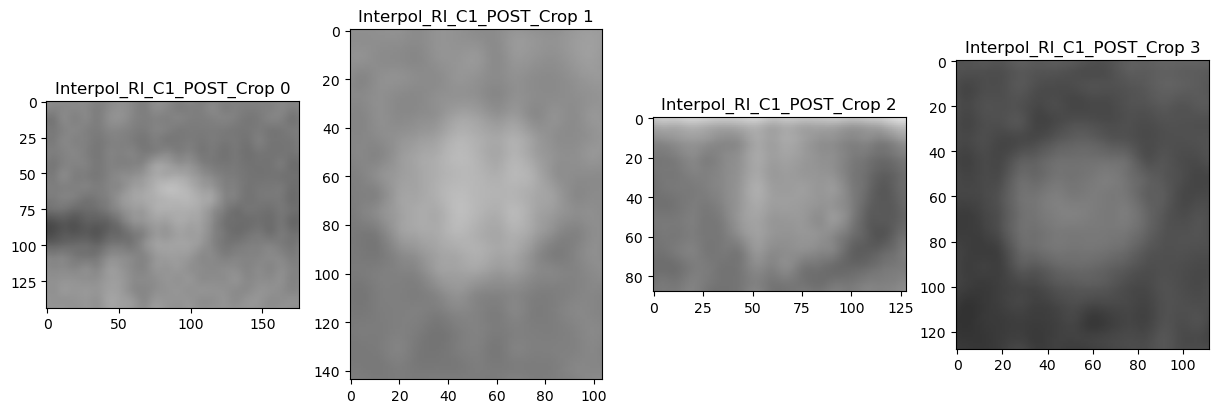

In [95]:
#il valore di una ROI è [x (angolo da cui parto a disegnare), y (angolo da cui parto a disegnare), 
#shift della x in direzione, shift della y in direzione]
for i, image_name in zip(range(0, len(epid_images_interpol_windowed_names)), epid_images_interpol_windowed_names):
    upscaled_image = cv2.imread(image_name)
    fig, axes = plt.subplots(1, len(EPID_crops_read[i]), figsize=(15,5))
    crop_number=0 
    for rect in EPID_crops_read[i]:
        x1=rect[0] * 8
        y1=rect[1] * 8
        x2=rect[2] * 8
        y2=rect[3] * 8
        img_crop = upscaled_image[y1:y1+y2,x1:x1+x2]
        name_crop = epid_images_interpol_windowed_names[i].split('.')[0]
        cv2.imwrite(name_crop + "_Crop_" + str(crop_number) + ".tiff", img_crop)
        axes[crop_number].set_title(name_crop.split("\\")[1] + "_Crop {}".format(crop_number))
        axes[crop_number].imshow(img_crop, cmap='gray')
        crop_number=crop_number+1

## EPID - Circle Detection w/ Hough Transform

In this code we detect the edges of the selected balls. After the block we're able to see the detections

Interpol_RI_C1_ANT.tiff

EPID Crop 0: 	
Center -> X:  66  Y:  78 

EPID Crop 1: 	
Center -> X:  56  Y:  80 

EPID Crop 2: 	
Center -> X:  44  Y:  60 

EPID Crop 3: 	
Center -> X:  78  Y:  70 



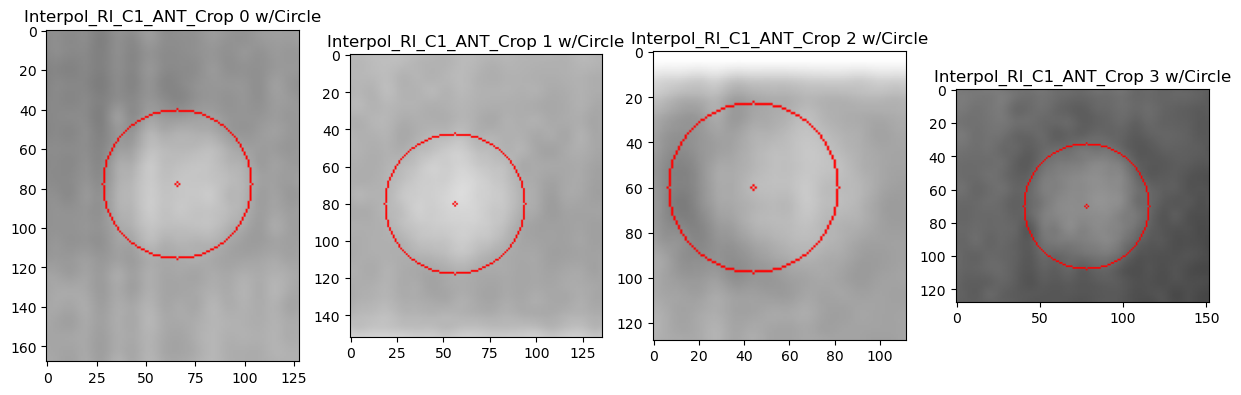

Interpol_RI_C1_LAT_D.tiff

EPID Crop 0: 	
Center -> X:  70  Y:  82 

EPID Crop 1: 	
Center -> X:  60  Y:  54 

EPID Crop 2: 	
Center -> X:  66  Y:  68 

EPID Crop 3: 	
Center -> X:  42  Y:  54 



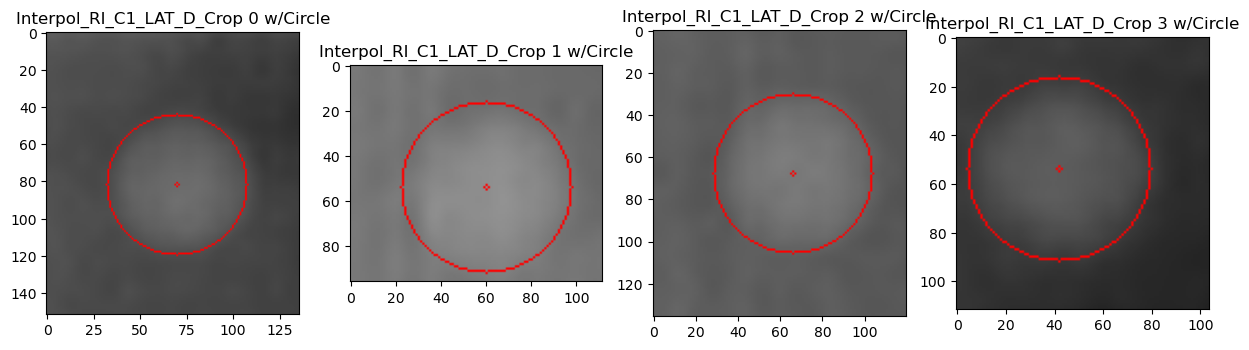

Interpol_RI_C1_LAT_G.tiff

EPID Crop 0: 	
Center -> X:  64  Y:  74 

EPID Crop 1: 	
Center -> X:  52  Y:  74 

EPID Crop 2: 	
Center -> X:  64  Y:  66 

EPID Crop 3: 	
Center -> X:  66  Y:  62 



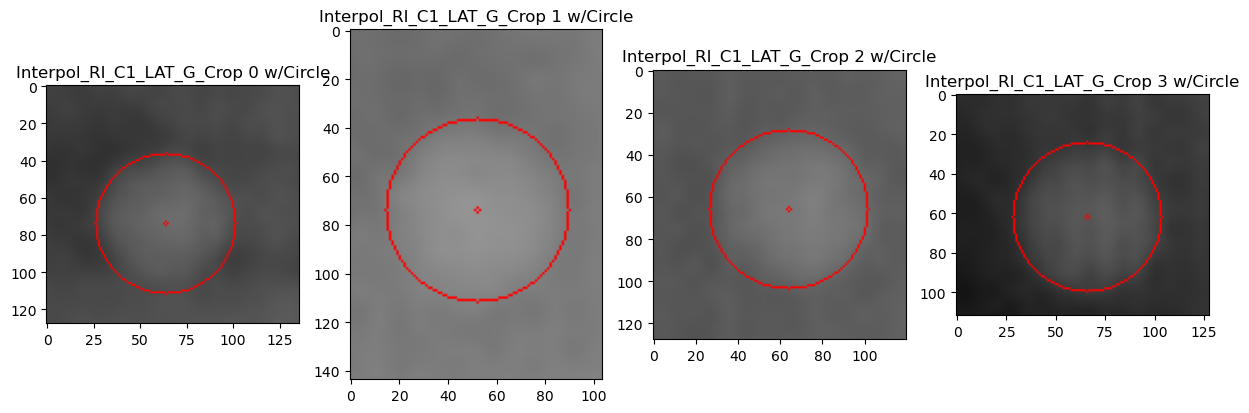

Interpol_RI_C1_POST.tiff

EPID Crop 0: 	
Center -> X:  86  Y:  78 

EPID Crop 1: 	
Center -> X:  48  Y:  70 

EPID Crop 2: 	
Center -> X:  68  Y:  42 

EPID Crop 3: 	
Center -> X:  52  Y:  66 



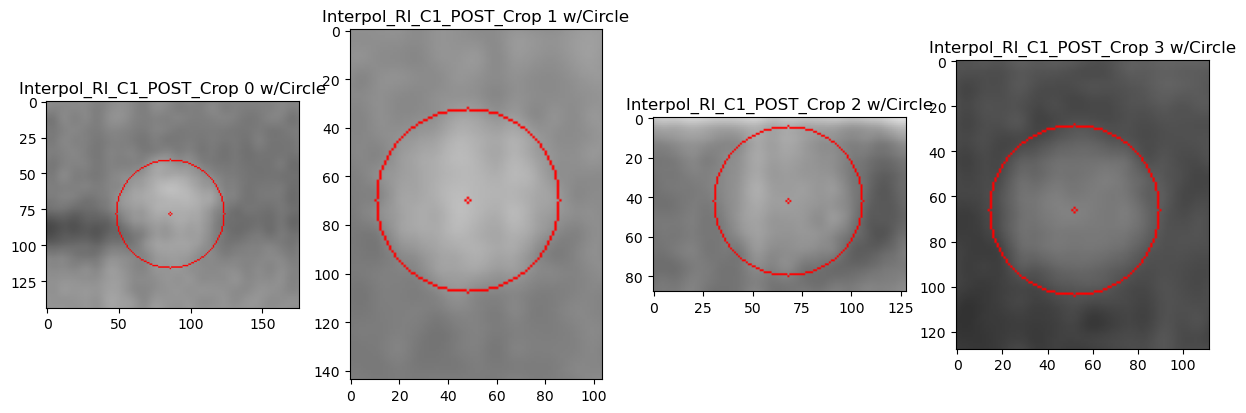

In [96]:
crop_list_names = []
real_diameter = 5
epid_total_centers = []
for image_name in epid_images_interpol_windowed_names:
    temp = []
    directory_name = image_name.split('\\')[0]
    image_name_splitted =  image_name.split('\\')[1]
    for image in os.listdir(directory_name):
        if (('Crop' in image) and ((image_name_splitted[:len(image_name_splitted)-5]) in image)):
            temp.append(image)
    crop_list_names.append(temp)
        
for i in range(0, len(crop_list_names)):
    fig, axes = plt.subplots(1, len(crop_list_names[i]), figsize=(15,5))
    crop_number=0
    print(epid_images_interpol_windowed_names[i].split('\\')[1] + '\n')
    epid_total_centers_single_arr = []
    for crop in crop_list_names[i]:
        crop_temp = cv2.imread(directory_name + '\\' + crop)
        clone_img = crop_temp.copy()
        crop_temp = cv2.cvtColor(crop_temp, cv2.COLOR_BGR2GRAY)
        
        ##median_blur3 = cv2.blur(crop_temp, (7,7))
        ##detected_circles = cv2.HoughCircles(median_blur3, cv2.HOUGH_GRADIENT, 1, 120, param1=15, param2=10, minRadius=27, maxRadius=50)

        if i==0:
            median_blur3 = cv2.blur(crop_temp, (3,3))
            detected_circles = cv2.HoughCircles(median_blur3, cv2.HOUGH_GRADIENT, 1, 140, param1=15, param2=12, minRadius=27, maxRadius=50)
       
        if i==1:
            median_blur3 = cv2.blur(crop_temp, (11,11)) 
            detected_circles = cv2.HoughCircles(median_blur3, cv2.HOUGH_GRADIENT, 1, 140, param1=15, param2=10, minRadius=27, maxRadius=50)

        if i==2:
            median_blur3 = cv2.blur(crop_temp, (9,9)) 
            detected_circles = cv2.HoughCircles(median_blur3, cv2.HOUGH_GRADIENT, 1, 140, param1=15, param2=10, minRadius=27, maxRadius=50)

        if i==3:
            median_blur3 = cv2.blur(crop_temp, (19,19)) 
            detected_circles = cv2.HoughCircles(median_blur3, cv2.HOUGH_GRADIENT, 1, 140, param1=15, param2=10, minRadius=27, maxRadius=50)

            
            
#             median_blur3 = cv2.blur(crop_temp, (21,21))
#             detected_circles = cv2.HoughCircles(median_blur3, cv2.HOUGH_GRADIENT, 1, 140, param1=5, param2=7, minRadius=27, maxRadius=50)

        if detected_circles is not None:
            detected_circles = np.uint16(np.around(detected_circles))
            for pt in detected_circles[0,:]:
                a, b, r = pt[0], pt[1], pt[2]
                cv2.circle(clone_img, (a,b), round(real_diameter / epid_images_new_pixel_spacing * 4), (255, 0, 0), 1)
                cv2.circle(clone_img, (a,b), 1, (255, 0, 0), 1)
                print("EPID Crop {}: \t".format(crop_number))
                print("Center -> X: ", a, " Y: ", b, '\n')
                center = (a,b)
                epid_total_centers_single_arr.append(center)
        name_crop = epid_images_interpol_windowed_names[i].split('.')[0]
#         cv2.imwrite(name_crop + "_Crop_" + str(crop_number) + ".tiff", img_crop)
        
        axes[crop_number].set_title(name_crop.split("\\")[1] + "_Crop {} w/Circle".format(crop_number))
        axes[crop_number].imshow(clone_img)
        
#         cv2.imwrite(name_crop + "_Crop_" + str(crop_number) + "_w_circle" + ".tiff", cv2.cvtColor(clone_img, cv2.COLOR_RGB2BGR))
        crop_number+=1
    
    epid_total_centers.append(epid_total_centers_single_arr)
    plt.show()

In [150]:
np.save("EPID_centers.npy", epid_total_centers)

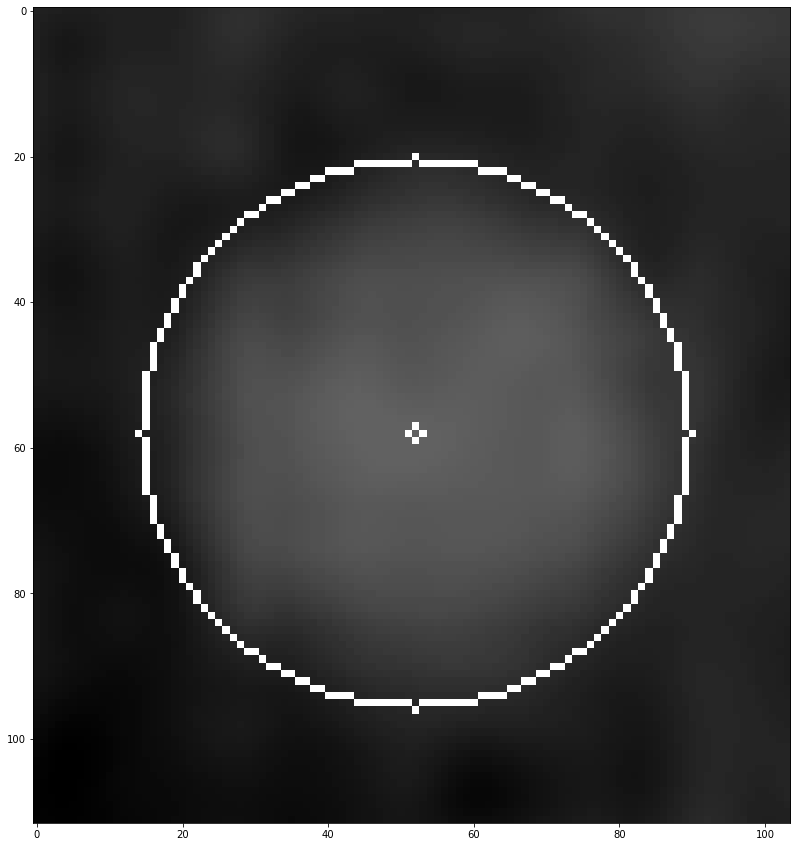

In [148]:
    bella = cv2.imread('EPID_windowed' + '\\' + 'Interpol_RI_C1_POST_Crop_0.tiff')
    bella = cv2.cvtColor(bella, cv2.COLOR_BGR2GRAY)

    median_blur3 = cv2.blur(bella, (19,19)) #questo è la riga che regola principalmente la precisione della detection
    detected_circles = cv2.HoughCircles(median_blur3, cv2.HOUGH_GRADIENT, 1, 140, param1=15, param2=10, minRadius=27, maxRadius=50)

    if detected_circles is not None:
        detected_circles = np.uint16(np.around(detected_circles))
        for pt in detected_circles[0,:]:
            a, b, r = pt[0], pt[1], pt[2]
            cv2.circle(bella, (a,b), round(real_diameter / epid_images_new_pixel_spacing * 4), (255, 0, 0), 1)
            cv2.circle(bella, (a,b), 1, (255, 0, 0), 1)
#     cv2.line(crop_temp, (a-7, b+7), (a+7, b-7), (255,0,0), thickness=2)   
#     cv2.line(crop_temp, (a-7, b-7), (a+7, b+7), (255,0,0), thickness=2) 
    
    plt.figure(figsize=(20,15))
    plt.imshow(bella, cmap='gray')
    plt.show()

## EPID - Converting ROIs Coordinates to SuperScaled Image Coordinates

In this block all the resulting coordinates from the selected ROIs in the previous step are converted to the coordinates of the superscaled image.

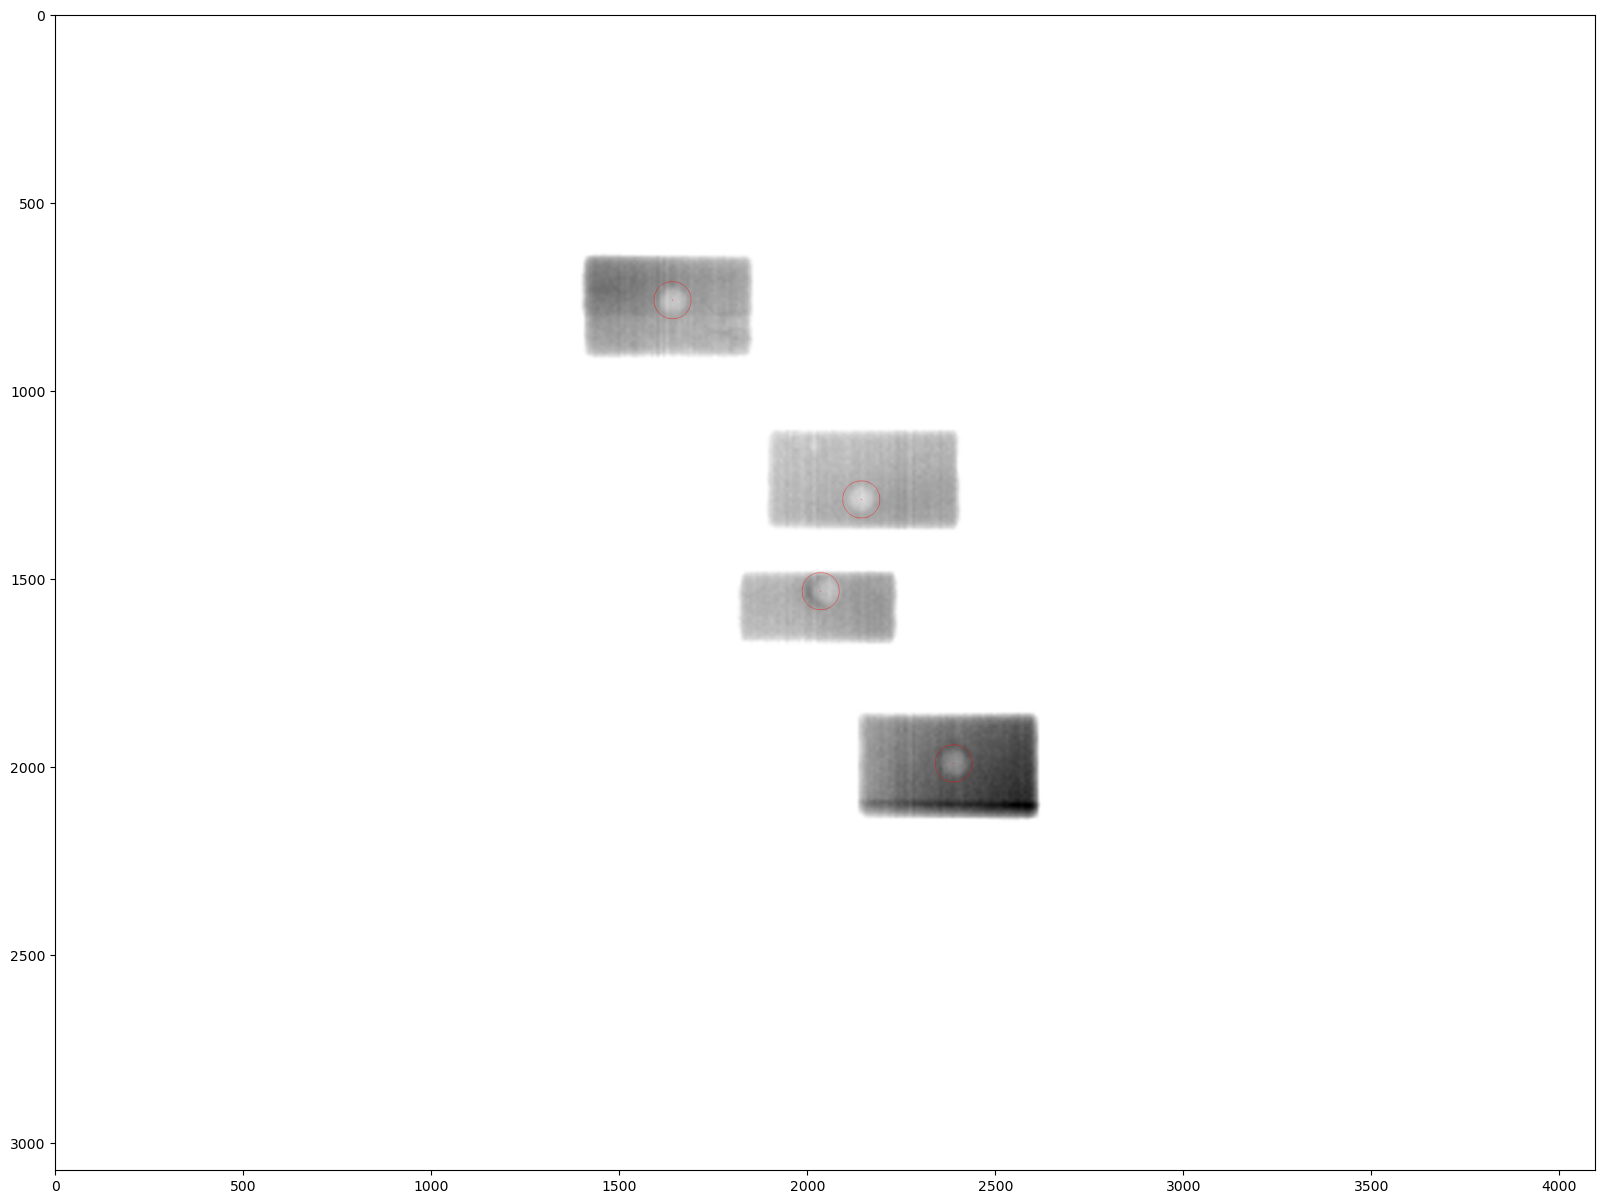

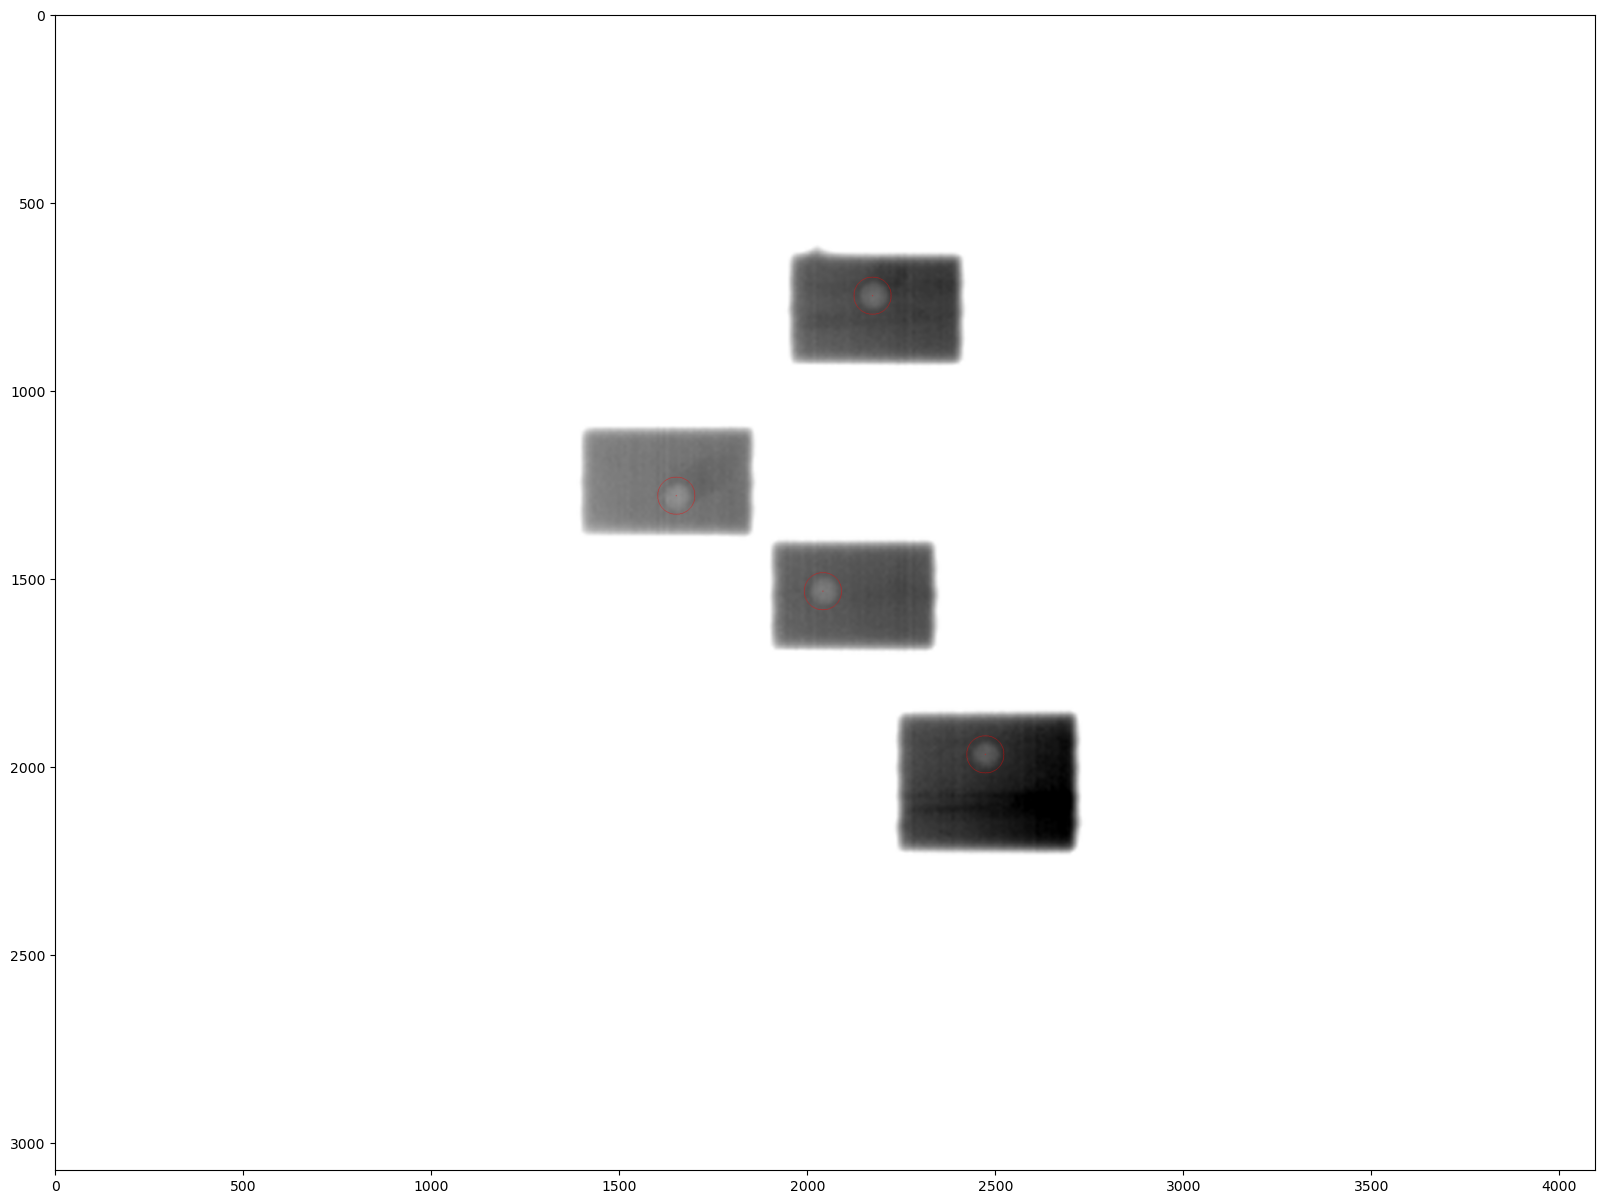

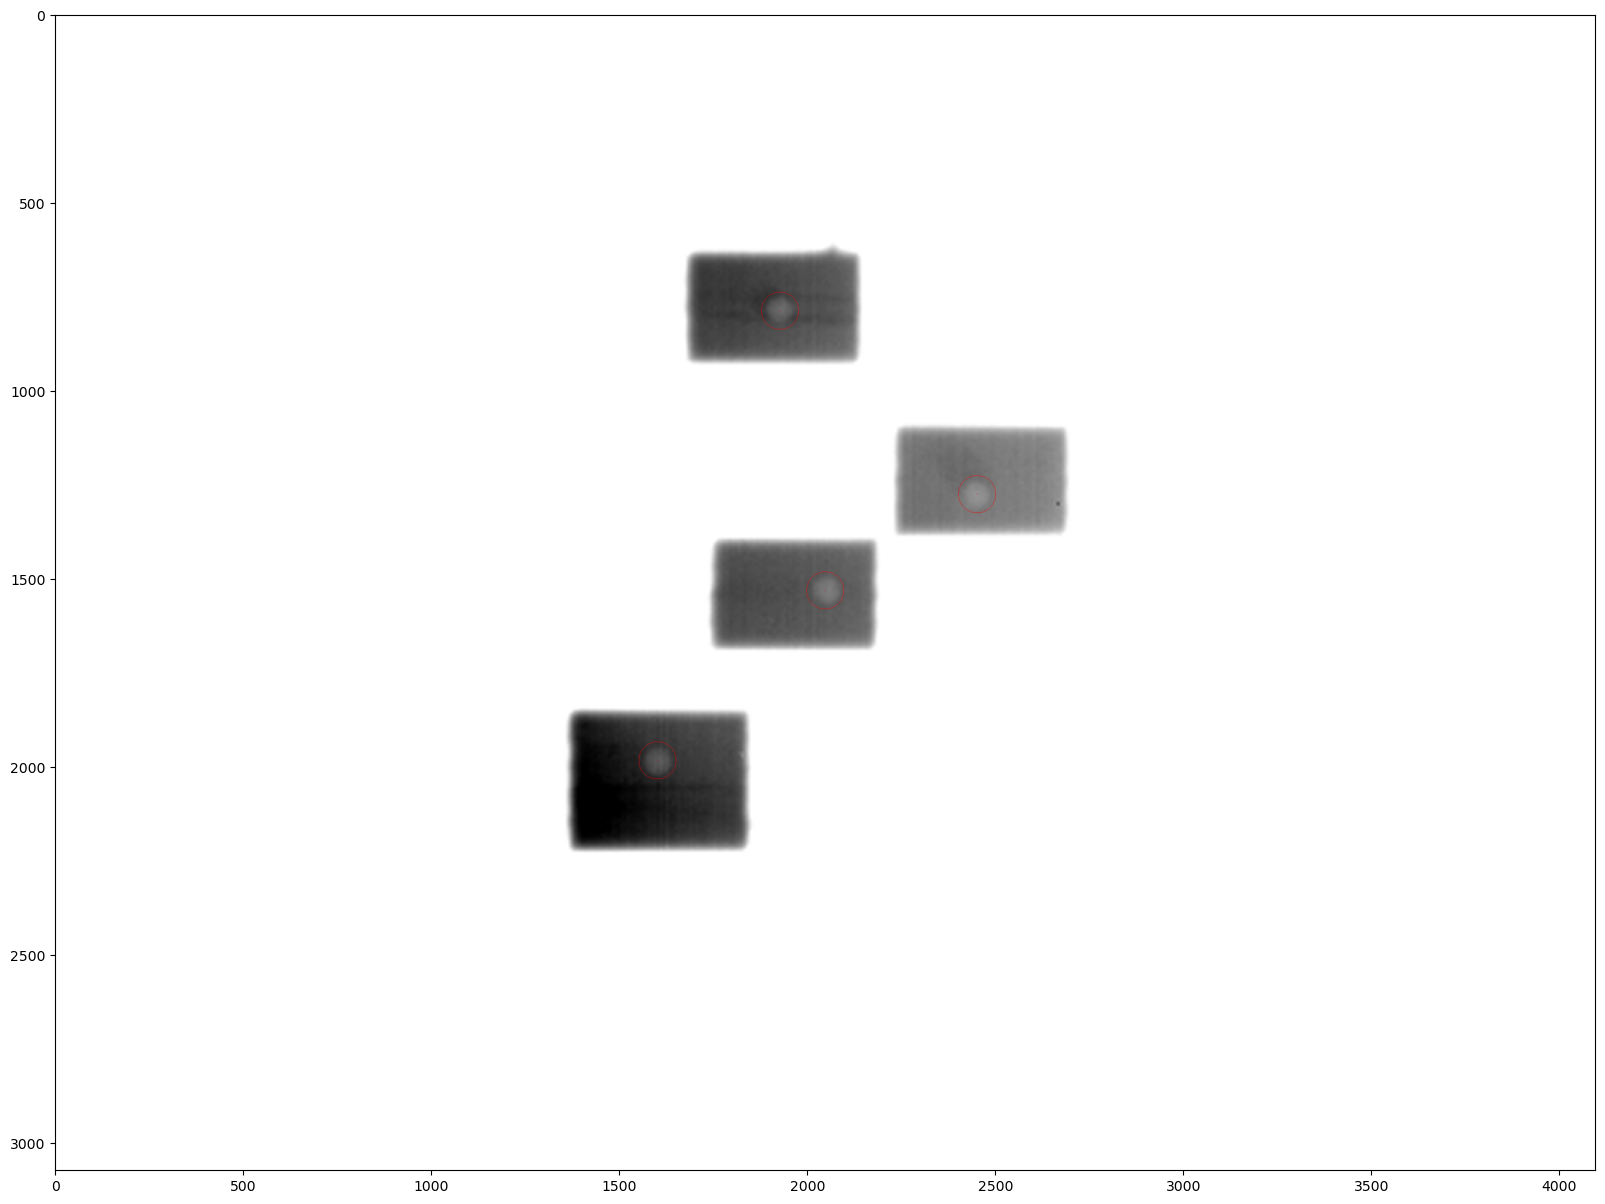

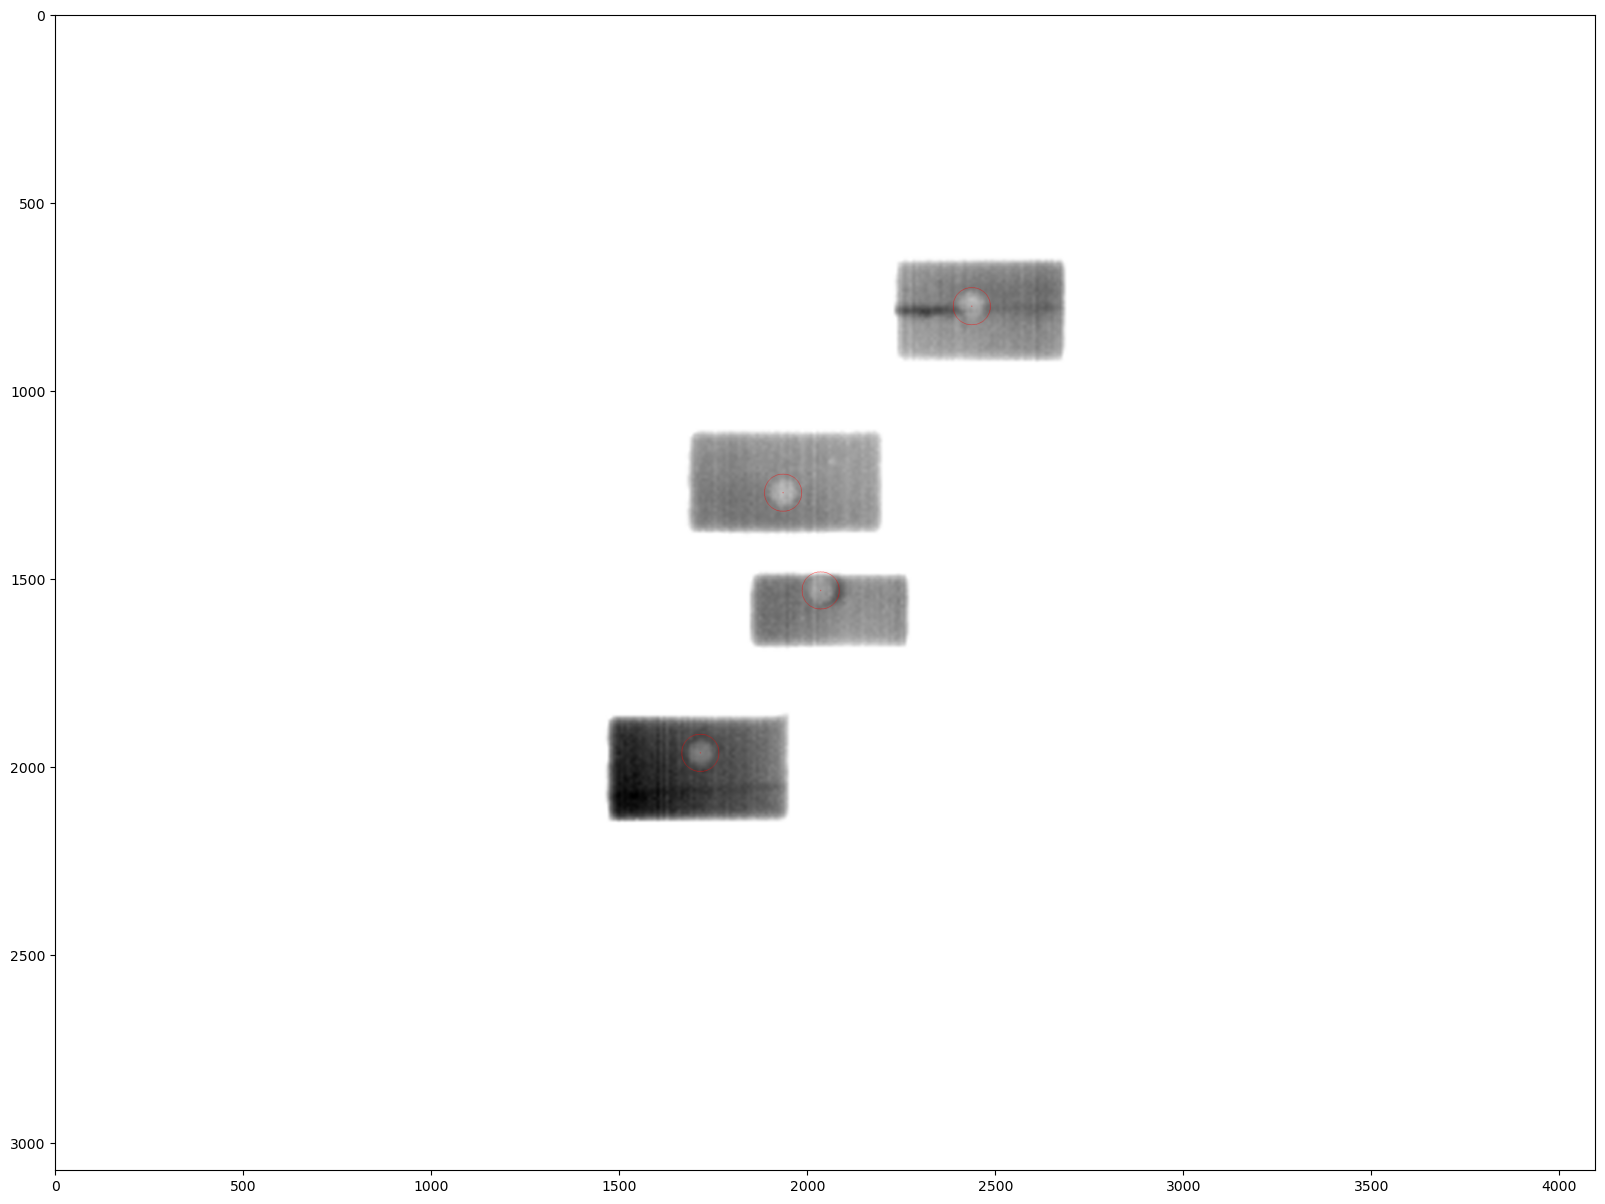

In [103]:
epid_upscaled_total_centers = []

for i, image_name in zip(range(0, len(epid_images_interpol_windowed_names)), epid_images_interpol_windowed_names):
    upscaled_image = cv2.imread(image_name)
    upscaled_image_copy = upscaled_image.copy()
    
    upscaled_total_centers_row = []
    
    j = 0
    for crop in crop_list_names[i]:
        crop_temp = cv2.imread(directory_name + '\\' + crop)
        crop_temp_gr = cv2.cvtColor(crop_temp, cv2.COLOR_BGR2GRAY)

        origin_coordinates = EPID_crops_read[i][j]
        up_left_corner_upscaled = (origin_coordinates[0] * 8, origin_coordinates[1] * 8)
        center_converted = (up_left_corner_upscaled[0] + epid_total_centers[i][j][0], up_left_corner_upscaled[1] + epid_total_centers[i][j][1])

        upscaled_total_centers_row.append(center_converted)
        cv2.circle(upscaled_image_copy, (round(center_converted[0]), round(center_converted[1])), round(real_diameter / epid_images_new_pixel_spacing * 4), (255, 0, 0), 1)
        cv2.circle(upscaled_image_copy, (round(center_converted[0]), round(center_converted[1])), 1, (255, 0, 0), 1)

        j+=1
    epid_upscaled_total_centers.append(upscaled_total_centers_row)
    plt.figure(figsize=(30,15))
    plt.imshow(upscaled_image_copy)
    plt.show()

In [152]:
np.save("EPID_centers_upscaled.npy", epid_upscaled_total_centers)

In [104]:
epid_images_interpol_windowed_names

['EPID_windowed\\Interpol_RI_C1_ANT.tiff',
 'EPID_windowed\\Interpol_RI_C1_LAT_D.tiff',
 'EPID_windowed\\Interpol_RI_C1_LAT_G.tiff',
 'EPID_windowed\\Interpol_RI_C1_POST.tiff']

Convert all the EPID_Crops coordinates w.r.t the Superscaled Images coordinates

## DRR - Scaling the ROIs to the SuperScaled Image and Crop them

In this block we calculate the horizontal and vertical distances in pixels between the EPID image and the DRR image

In [105]:
epid_temp = cv2.imread(epid_images_interpol_windowed_names[0])
epid_temp = cv2.cvtColor(epid_temp, cv2.COLOR_BGR2RGB)

h_mov, w_mov = epid_temp.shape[0], epid_temp.shape[1]
print("EPID Image Shape: ", w_mov, h_mov)

drr_temp = cv2.imread(drr_images_interpol_windowed_names[0])
drr_temp = cv2.cvtColor(drr_temp, cv2.COLOR_BGR2RGB)

hh, ww = drr_temp.shape[0], drr_temp.shape[1]
print("DRR Image Shape: ", hh, ww)

yoff = round((hh - h_mov)/2)
xoff = round((ww - w_mov)/2)
print("Difference between EPID-DRR (in pixels):  Y-axis:", yoff, " X-axis:", xoff)

EPID Image Shape:  4096 3072
DRR Image Shape:  7648 7648
Difference between EPID-DRR (in pixels):  Y-axis: 2288  X-axis: 1776


In this block we convert the EPID crops coordinates to the DRR coordinates

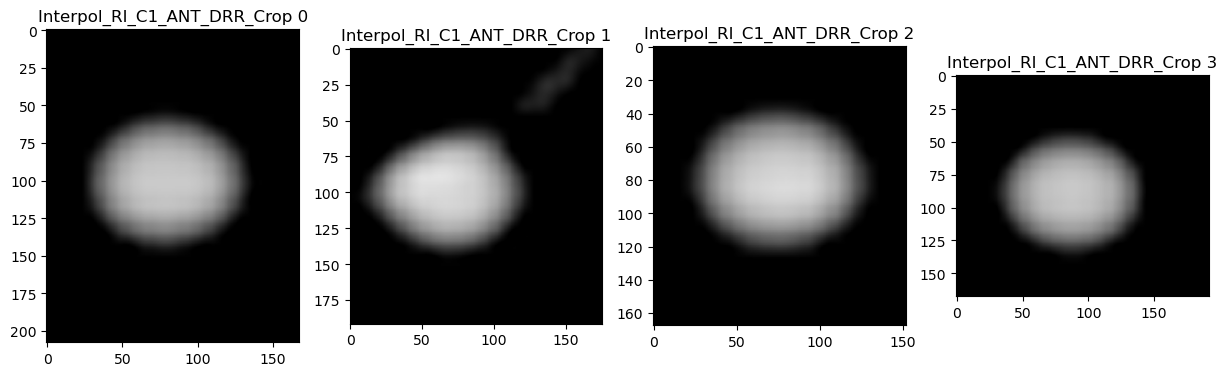

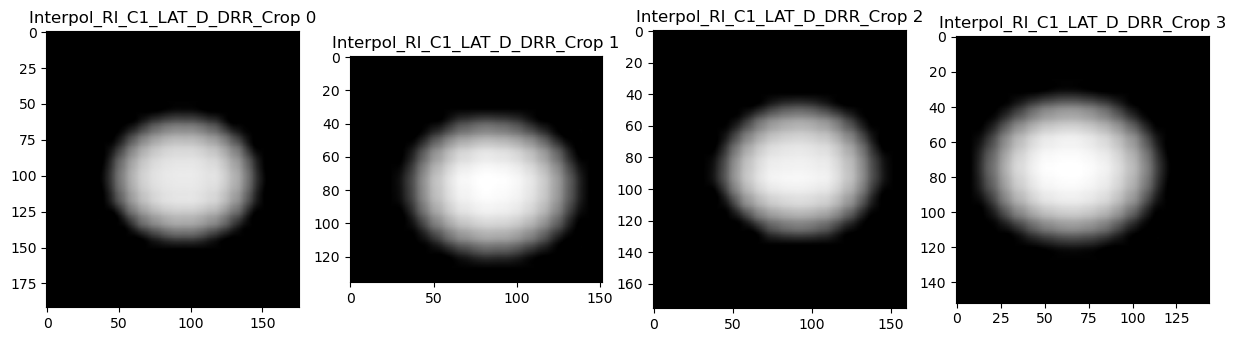

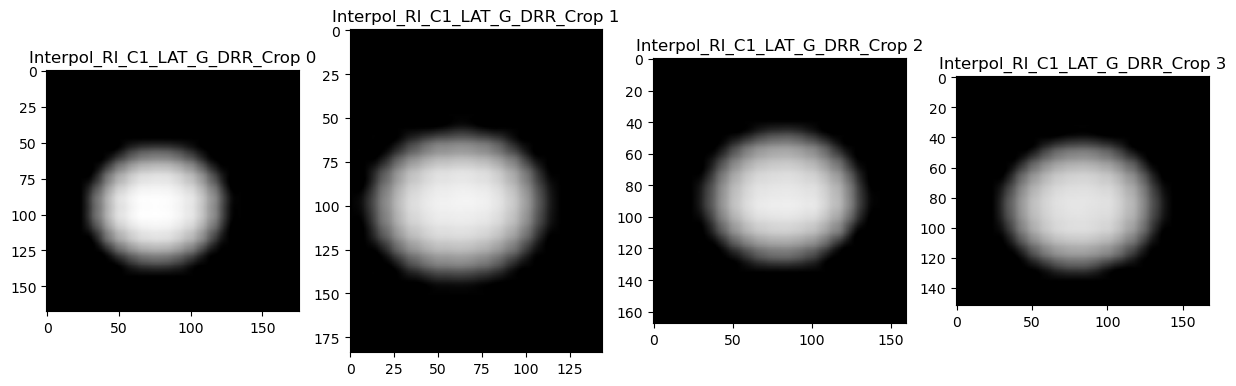

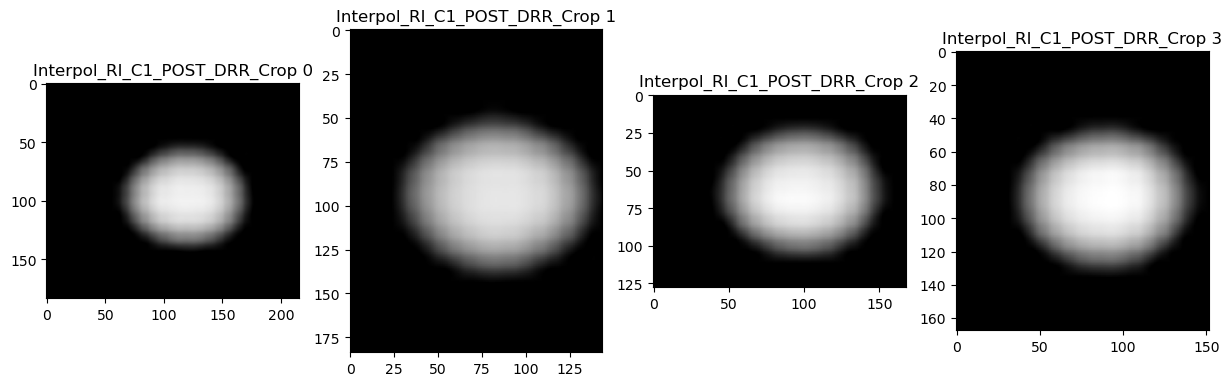

In [106]:
for i, image_name in zip(range(0, len(drr_images_interpol_windowed_names)), drr_images_interpol_windowed_names):
    upscaled_image = cv2.imread(image_name)
    fig, axes = plt.subplots(1, len(EPID_crops_read[i]), figsize=(15,5))
    crop_number=0 
    for rect in EPID_crops_read[i]:
        x1 = (rect[0] + (int(xoff/8)) ) * 8
        y1 = (rect[1] + (int(yoff/8)) ) * 8
        x2 = rect[2] * 8 
        y2 = rect[3] * 8 
        img_crop = upscaled_image[y1-20:y1+y2+20,x1-20:x1+x2+20]
        name_crop = drr_images_interpol_windowed_names[i].split('.')[0]
        cv2.imwrite(name_crop + "_Crop_" + str(crop_number) + ".tiff", img_crop)
        axes[crop_number].set_title(name_crop.split("\\")[1] + "_Crop {}".format(crop_number))
        axes[crop_number].imshow(img_crop, cmap='gray')
        crop_number=crop_number+1

## DRR - Circle Detection w/ Canny Edge

Interpol_RI_C1_ANT_DRR.tiff

EPID Crop 0: 	
Center -> X:  80  Y:  98 

EPID Crop 1: 	
Center -> X:  67  Y:  99 

EPID Crop 2: 	
Center -> X:  75  Y:  82 

EPID Crop 3: 	
Center -> X:  87  Y:  88 



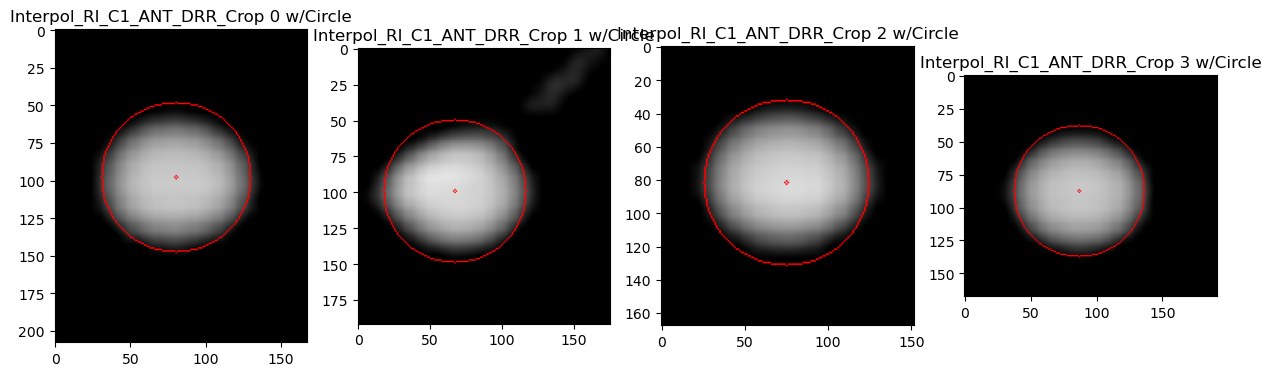

Interpol_RI_C1_LAT_D_DRR.tiff

EPID Crop 0: 	
Center -> X:  95  Y:  102 

EPID Crop 1: 	
Center -> X:  84  Y:  79 

EPID Crop 2: 	
Center -> X:  91  Y:  90 

EPID Crop 3: 	
Center -> X:  65  Y:  74 



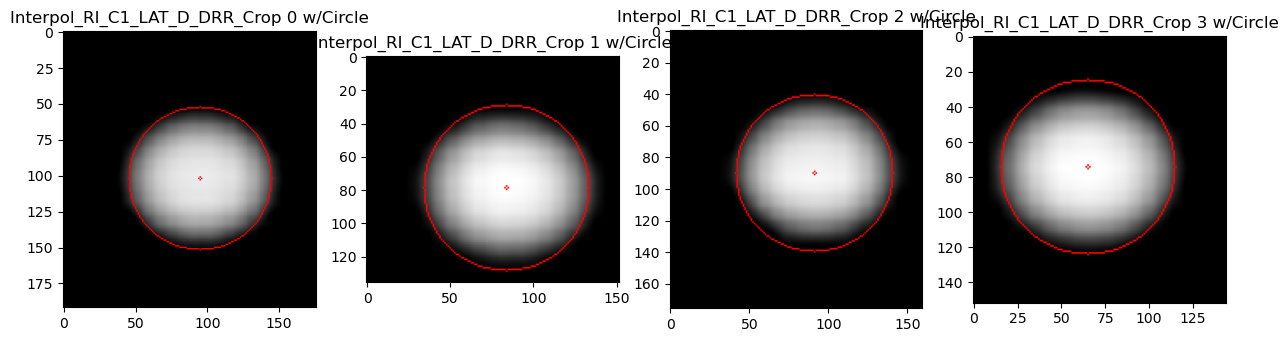

Interpol_RI_C1_LAT_G_DRR.tiff

EPID Crop 0: 	
Center -> X:  77  Y:  94 

EPID Crop 1: 	
Center -> X:  60  Y:  98 

EPID Crop 2: 	
Center -> X:  82  Y:  91 

EPID Crop 3: 	
Center -> X:  82  Y:  84 



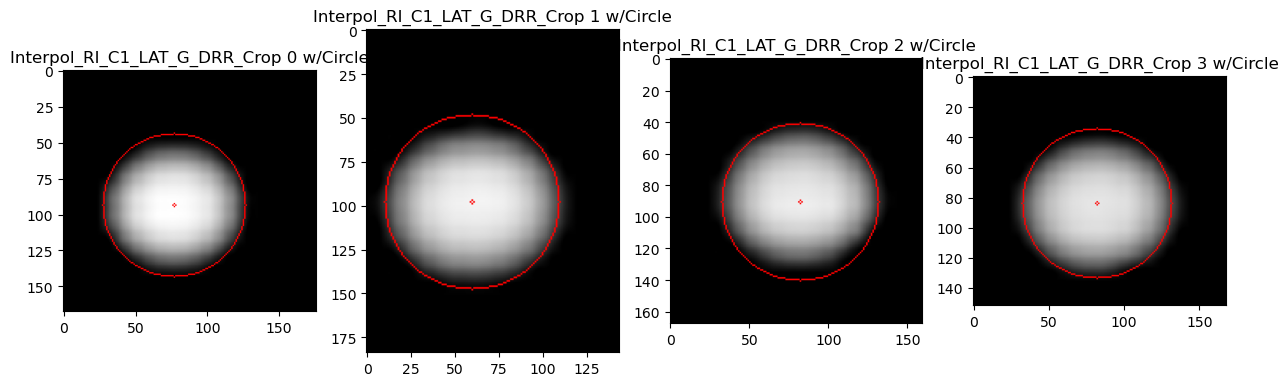

Interpol_RI_C1_POST_DRR.tiff

EPID Crop 0: 	
Center -> X:  118  Y:  101 

EPID Crop 1: 	
Center -> X:  84  Y:  96 

EPID Crop 2: 	
Center -> X:  98  Y:  66 

EPID Crop 3: 	
Center -> X:  89  Y:  89 



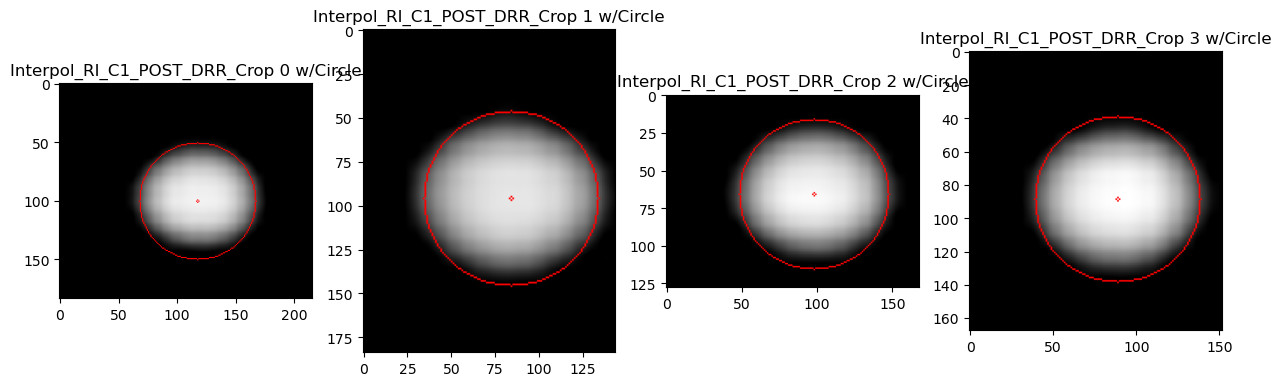

In [107]:
crop_list_names = []
real_diameter = 6.5
drr_total_centers = []
for image_name in drr_images_interpol_windowed_names:
    temp = []
    directory_name = image_name.split('\\')[0]
    image_name_splitted =  image_name.split('\\')[1]
    for image in os.listdir(directory_name):
        if (('Crop' in image) and ((image_name_splitted[:len(image_name_splitted)-5]) in image)):
            temp.append(image)
    crop_list_names.append(temp)
        
for i in range(0, len(crop_list_names)):
    fig, axes = plt.subplots(1, len(crop_list_names[i]), figsize=(15,5))
    crop_number=0
    print(drr_images_interpol_windowed_names[i].split('\\')[1] + '\n')
    drr_total_centers_single_arr = []
    for crop in crop_list_names[i]:
        crop_temp = cv2.imread(directory_name + '\\' + crop)
        clone_img = crop_temp.copy()
        crop_temp = cv2.cvtColor(crop_temp, cv2.COLOR_BGR2GRAY)
        
       
        thresh_value = ((np.max(crop_temp) - np.min(crop_temp) ) / 2) + np.min(crop_temp)
#     thresh_value = 250
        result = (crop_temp > thresh_value) * crop_temp

        for k in range(0, result.shape[0]):
            for j in range(0, result.shape[1]):
                if(result[k][j]) != 0:
                    result[k][j] = 255
                else:
                    result[k][j] = 0
    
        median_blur2 = cv2.medianBlur(result, 5)
        canny_output = cv2.Canny(median_blur2, 50, 100)

        contours, _ = cv2.findContours(canny_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_poly = [None]*len(contours)
        centers = [None]*len(contours)
        radius = [None]*len(contours)

        for j, c in enumerate(contours):
            contours_poly[j] = cv2.approxPolyDP(c, 3, True)
            centers[j], radius[j] = cv2.minEnclosingCircle(contours_poly[j])
    
        for j in range(len(contours)):
            color = (255,0,0)
            cv2.circle(clone_img, (round(centers[j][0]), round(centers[j][1])), round(real_diameter / epid_images_new_pixel_spacing * 4), color, 1)
            cv2.circle(clone_img, (round(centers[j][0]), round(centers[j][1])), 1, color, 1)
            
            print("EPID Crop {}: \t".format(crop_number))
            print("Center -> X: ", round(centers[j][0]), " Y: ", round(centers[j][1]), '\n')
            center = (round(centers[j][0]),round(centers[j][1]))
            
        drr_total_centers_single_arr.append(center)
        name_crop = drr_images_interpol_windowed_names[i].split('.')[0]
        
        axes[crop_number].set_title(name_crop.split("\\")[1] + "_Crop {} w/Circle".format(crop_number))
        axes[crop_number].imshow(clone_img)
        
        crop_number+=1
    
    drr_total_centers.append(drr_total_centers_single_arr)
    plt.show()

In [157]:
np.save("DRR_centers.npy", drr_total_centers)

## DRR - Converting ROIs Coordinates to SuperScaled Image Coordinates

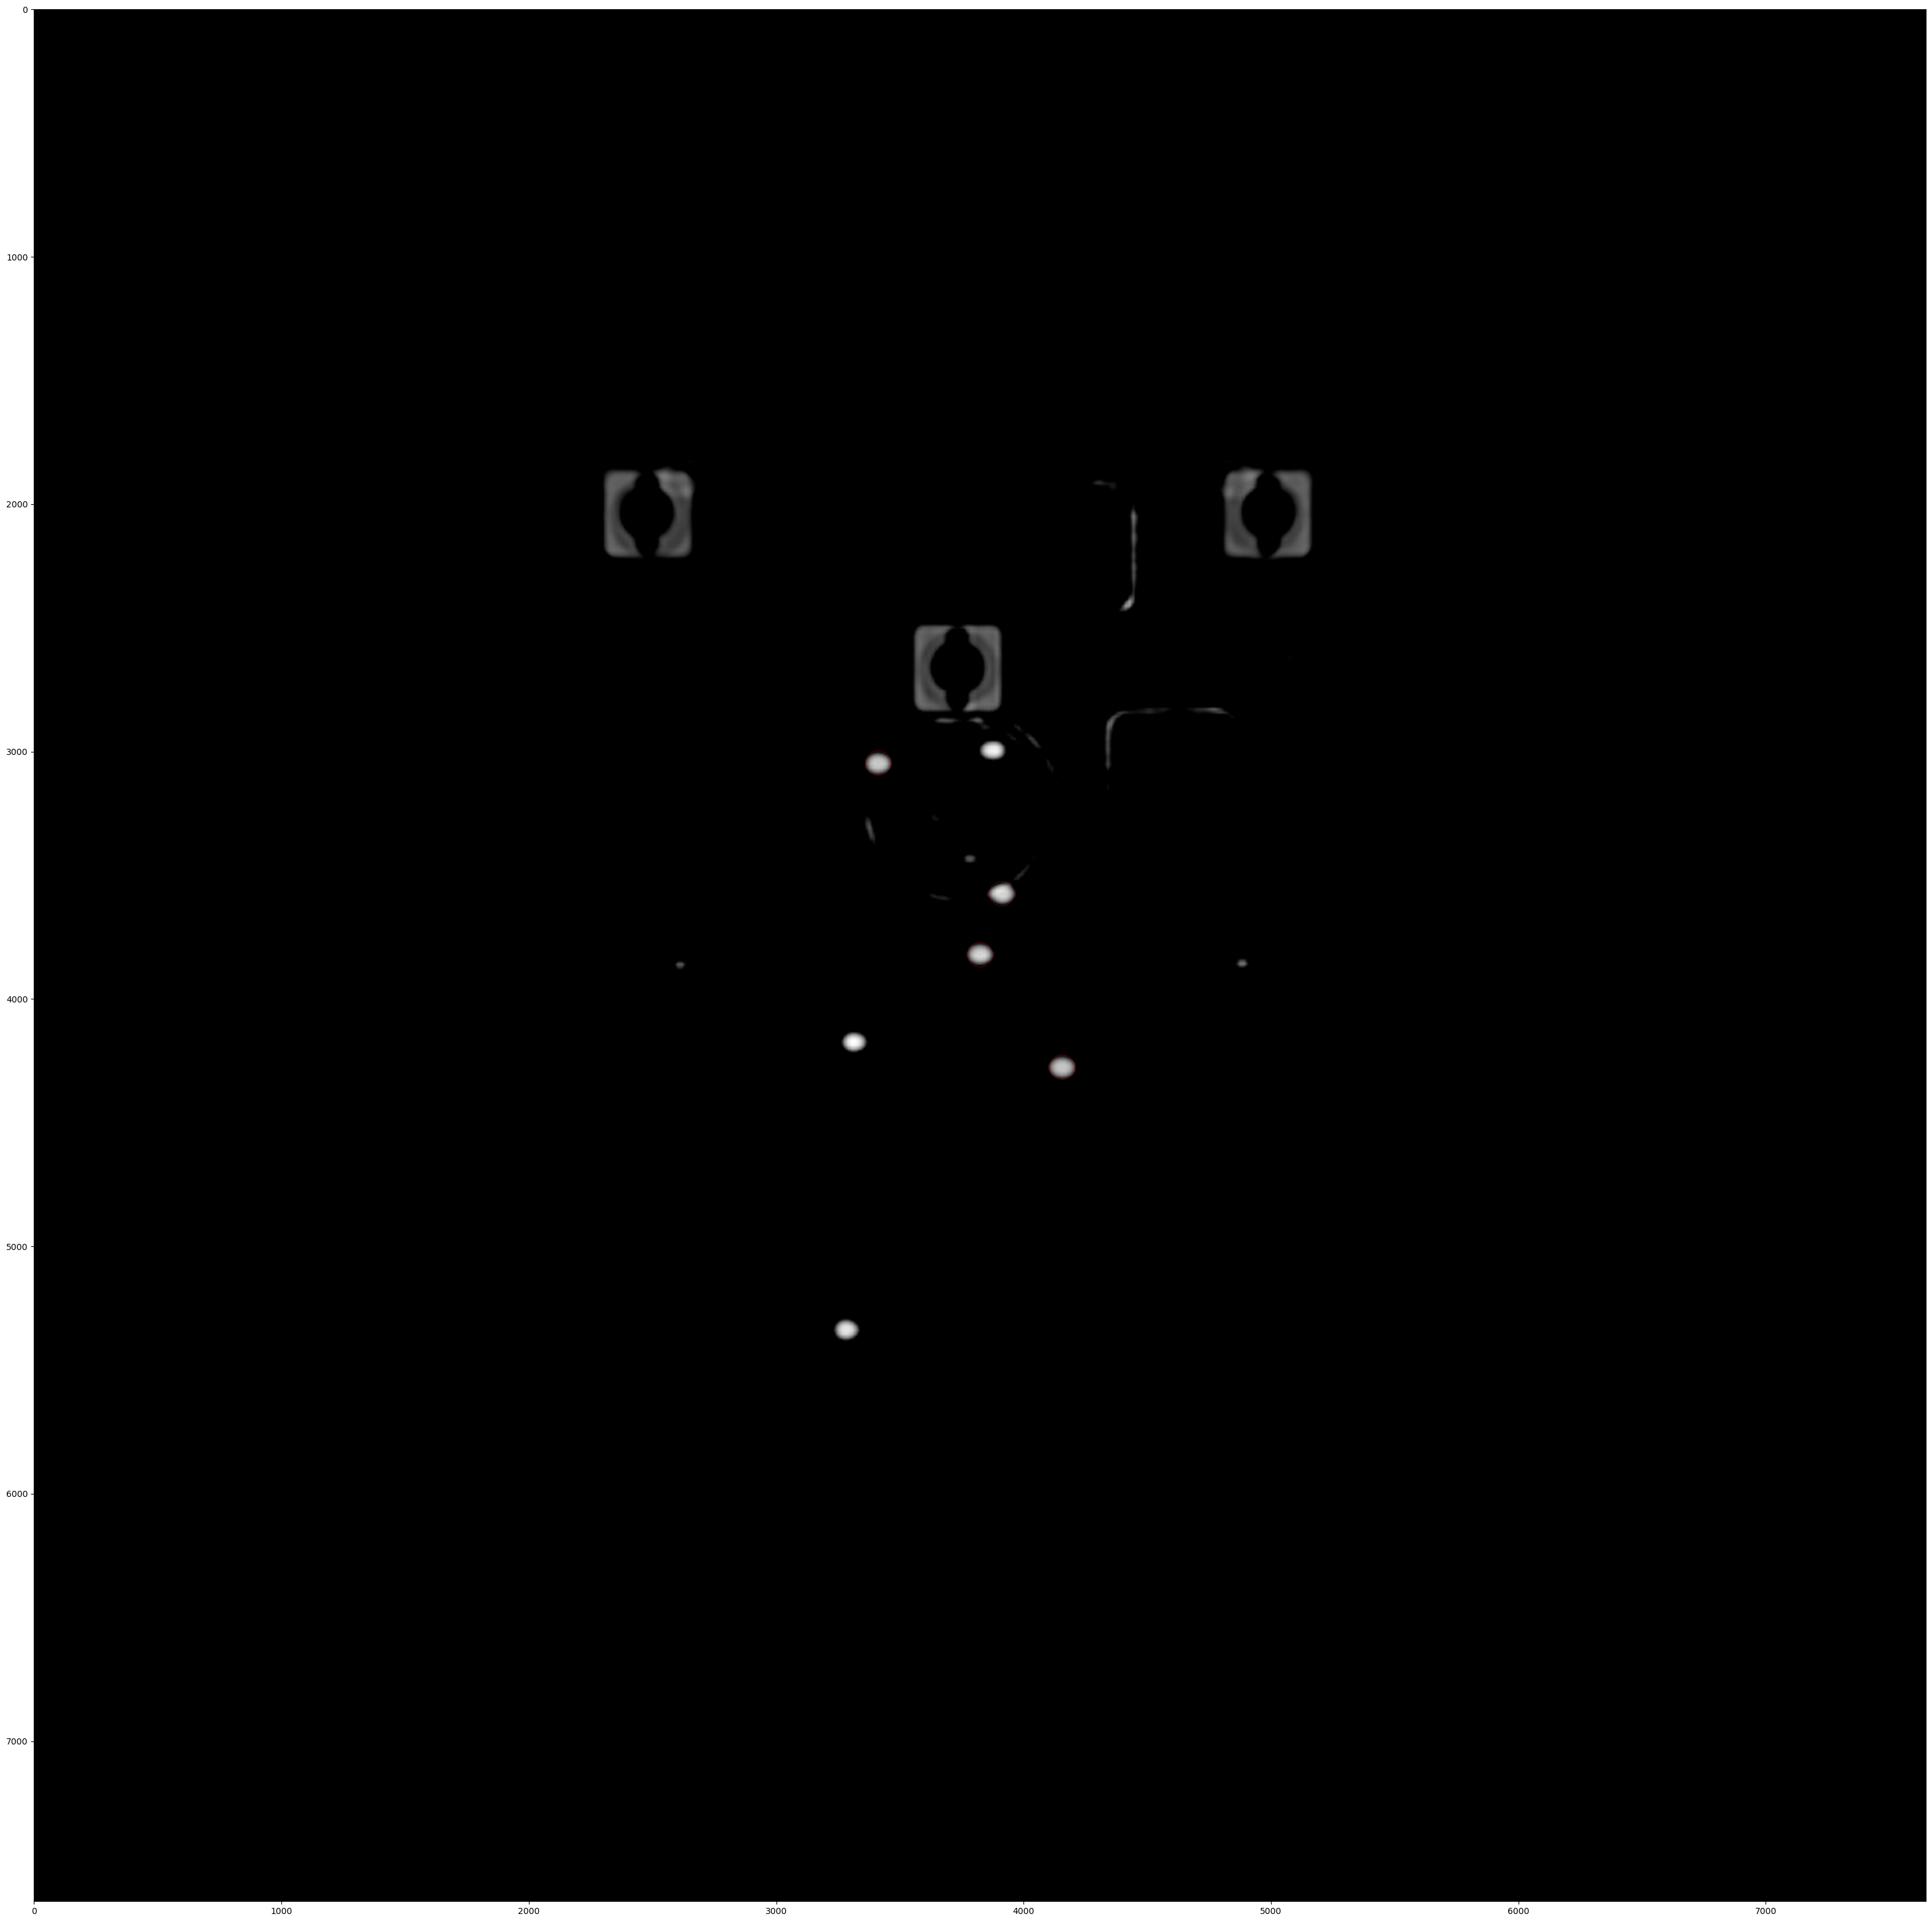

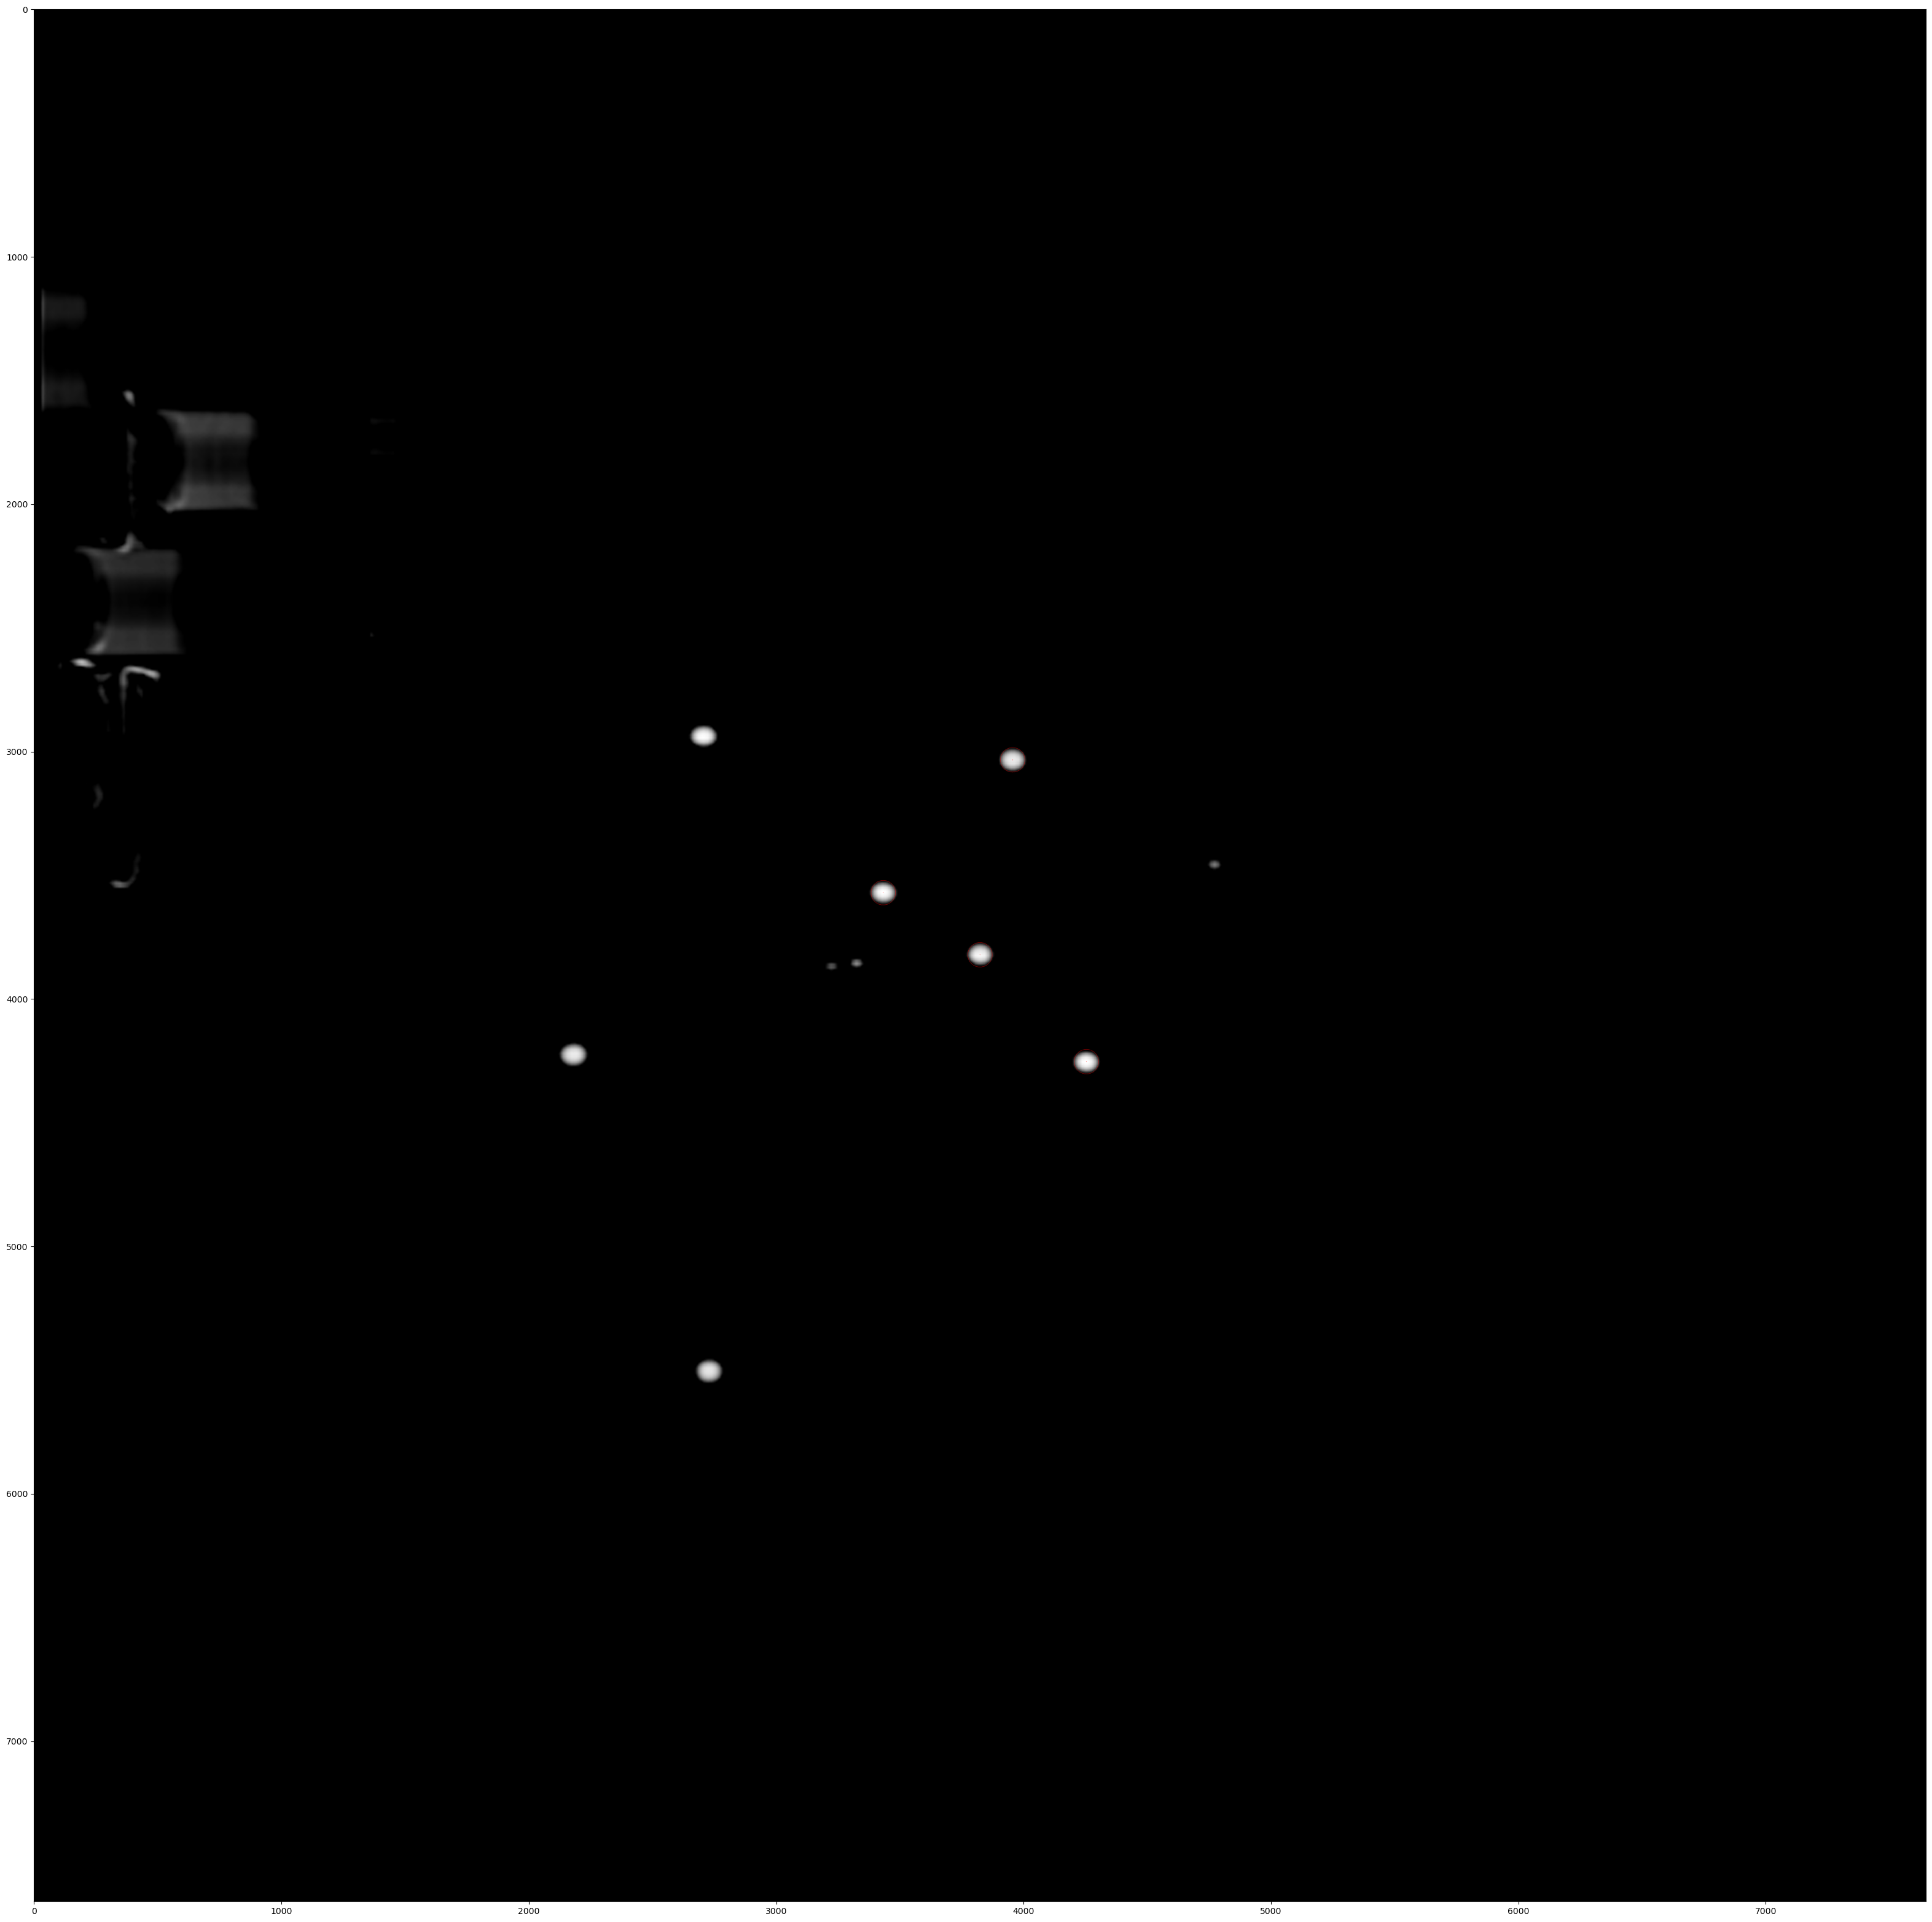

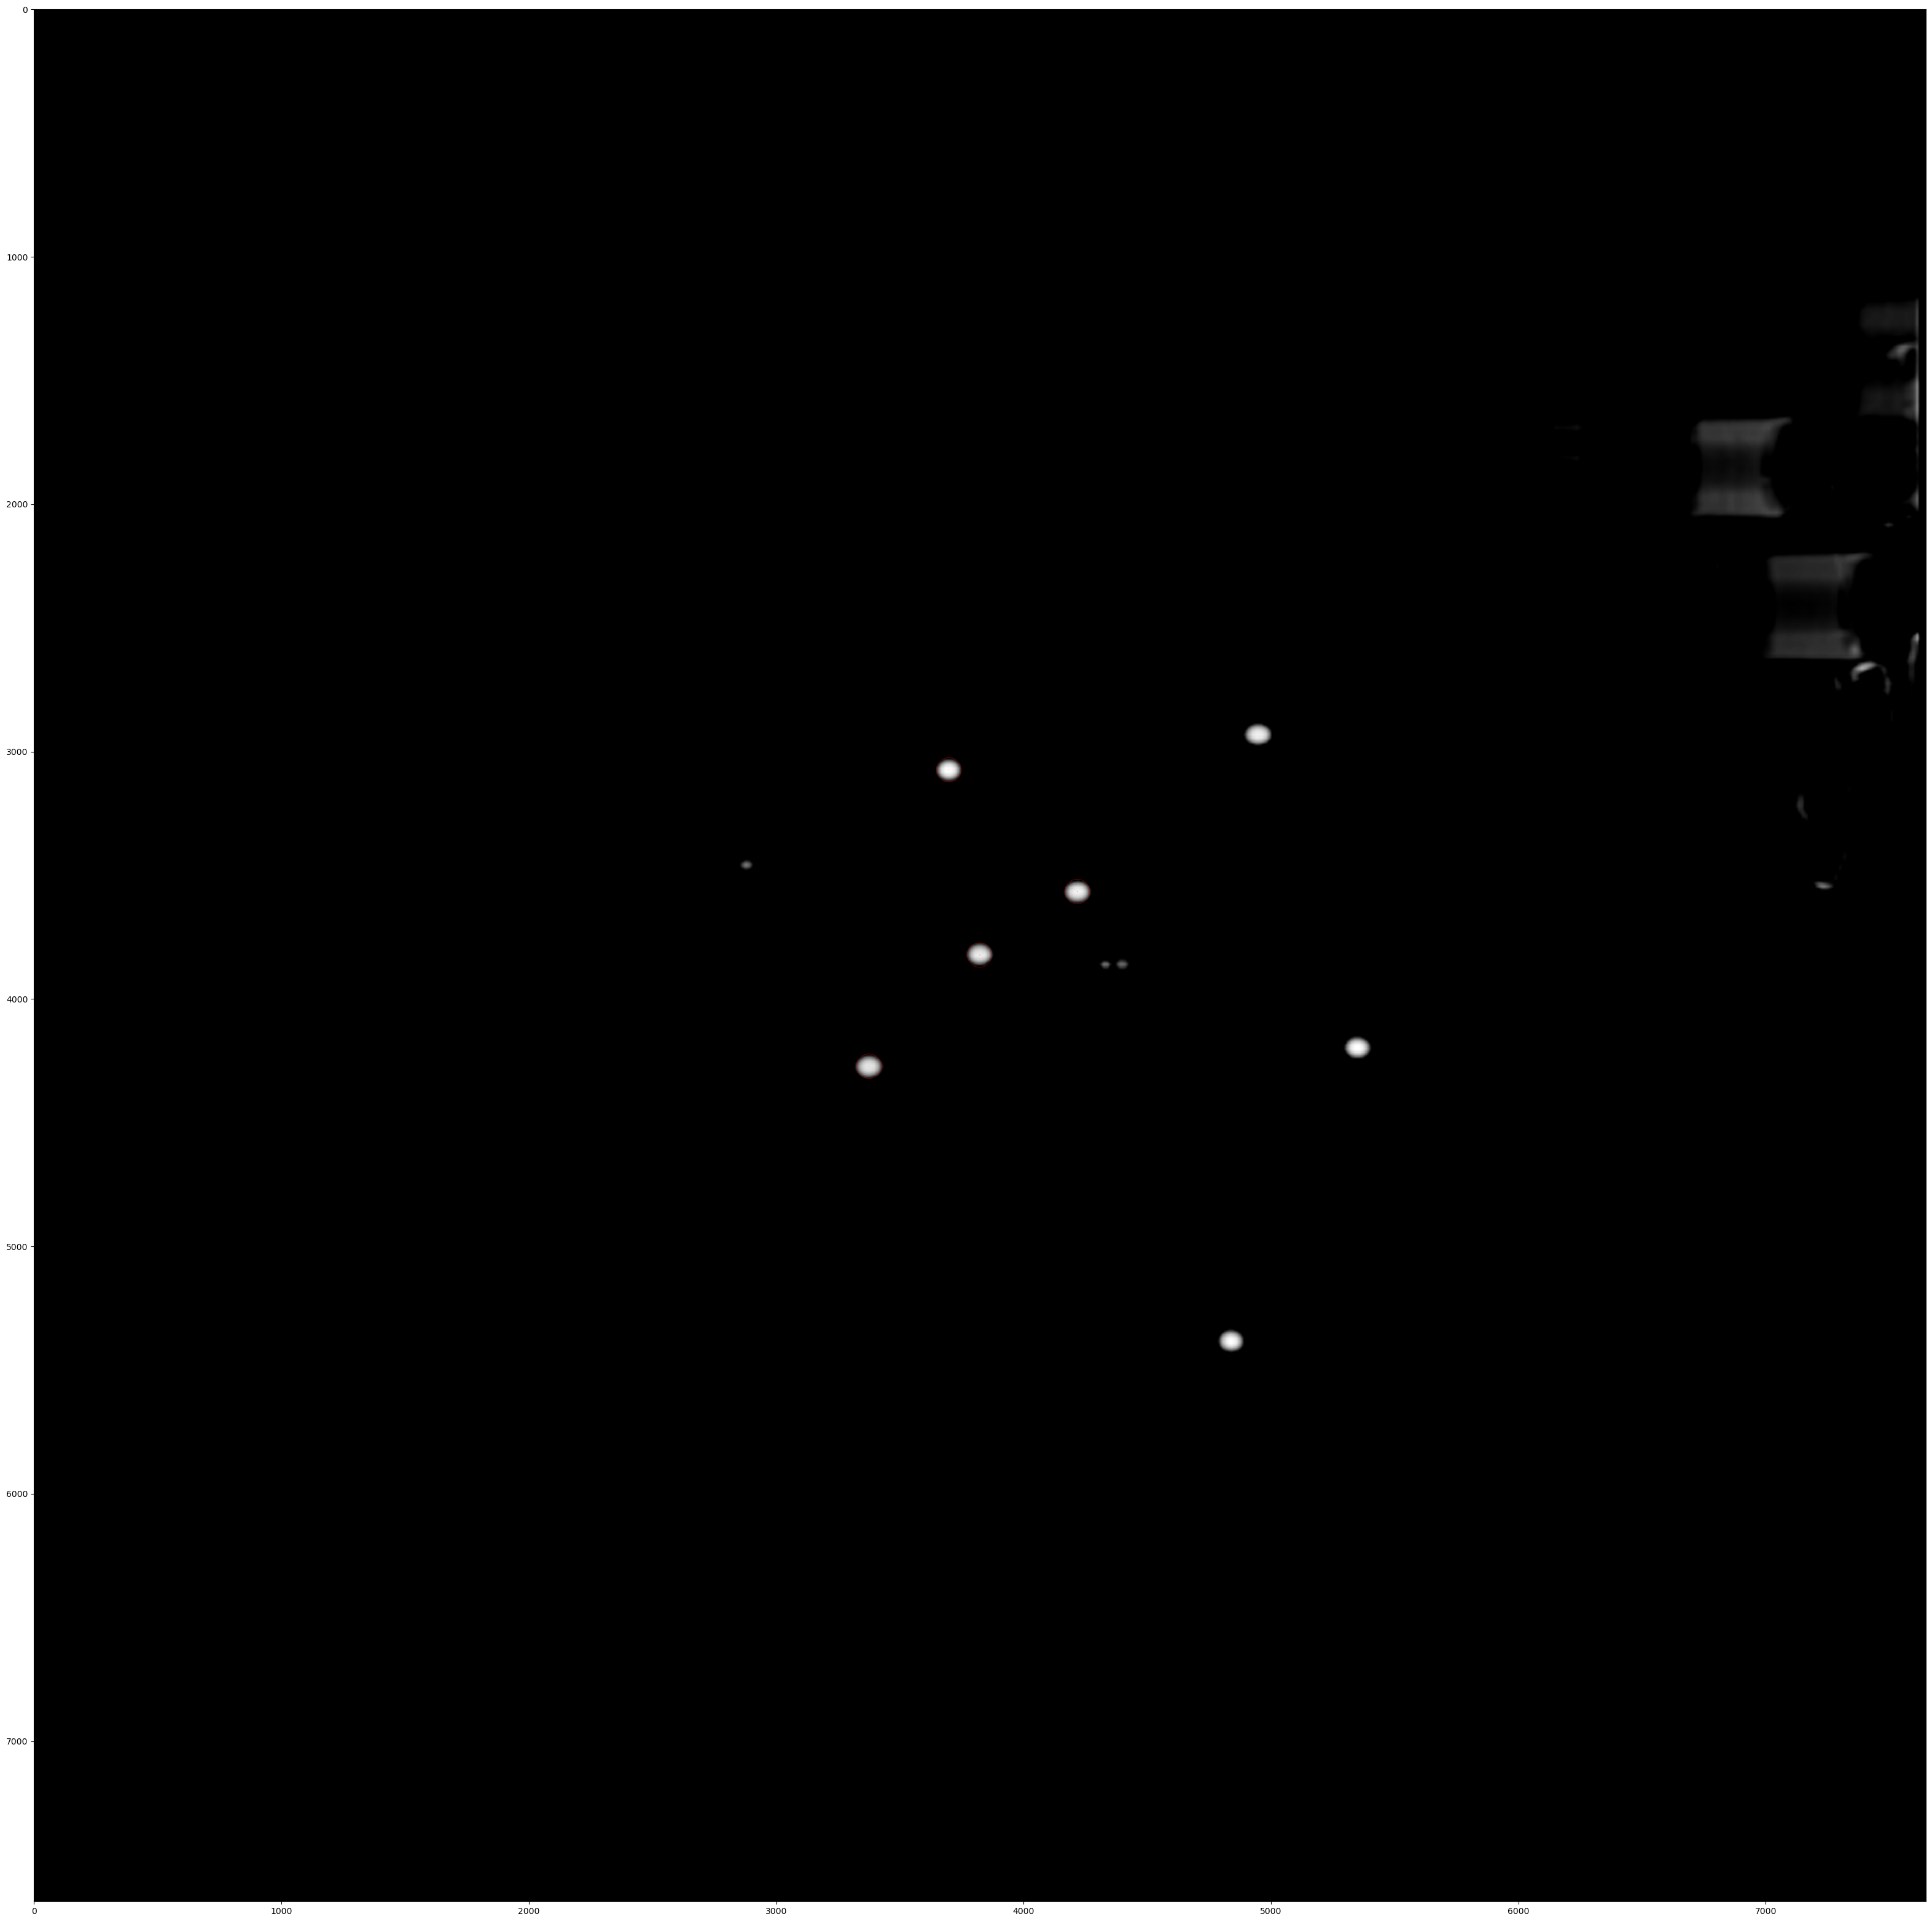

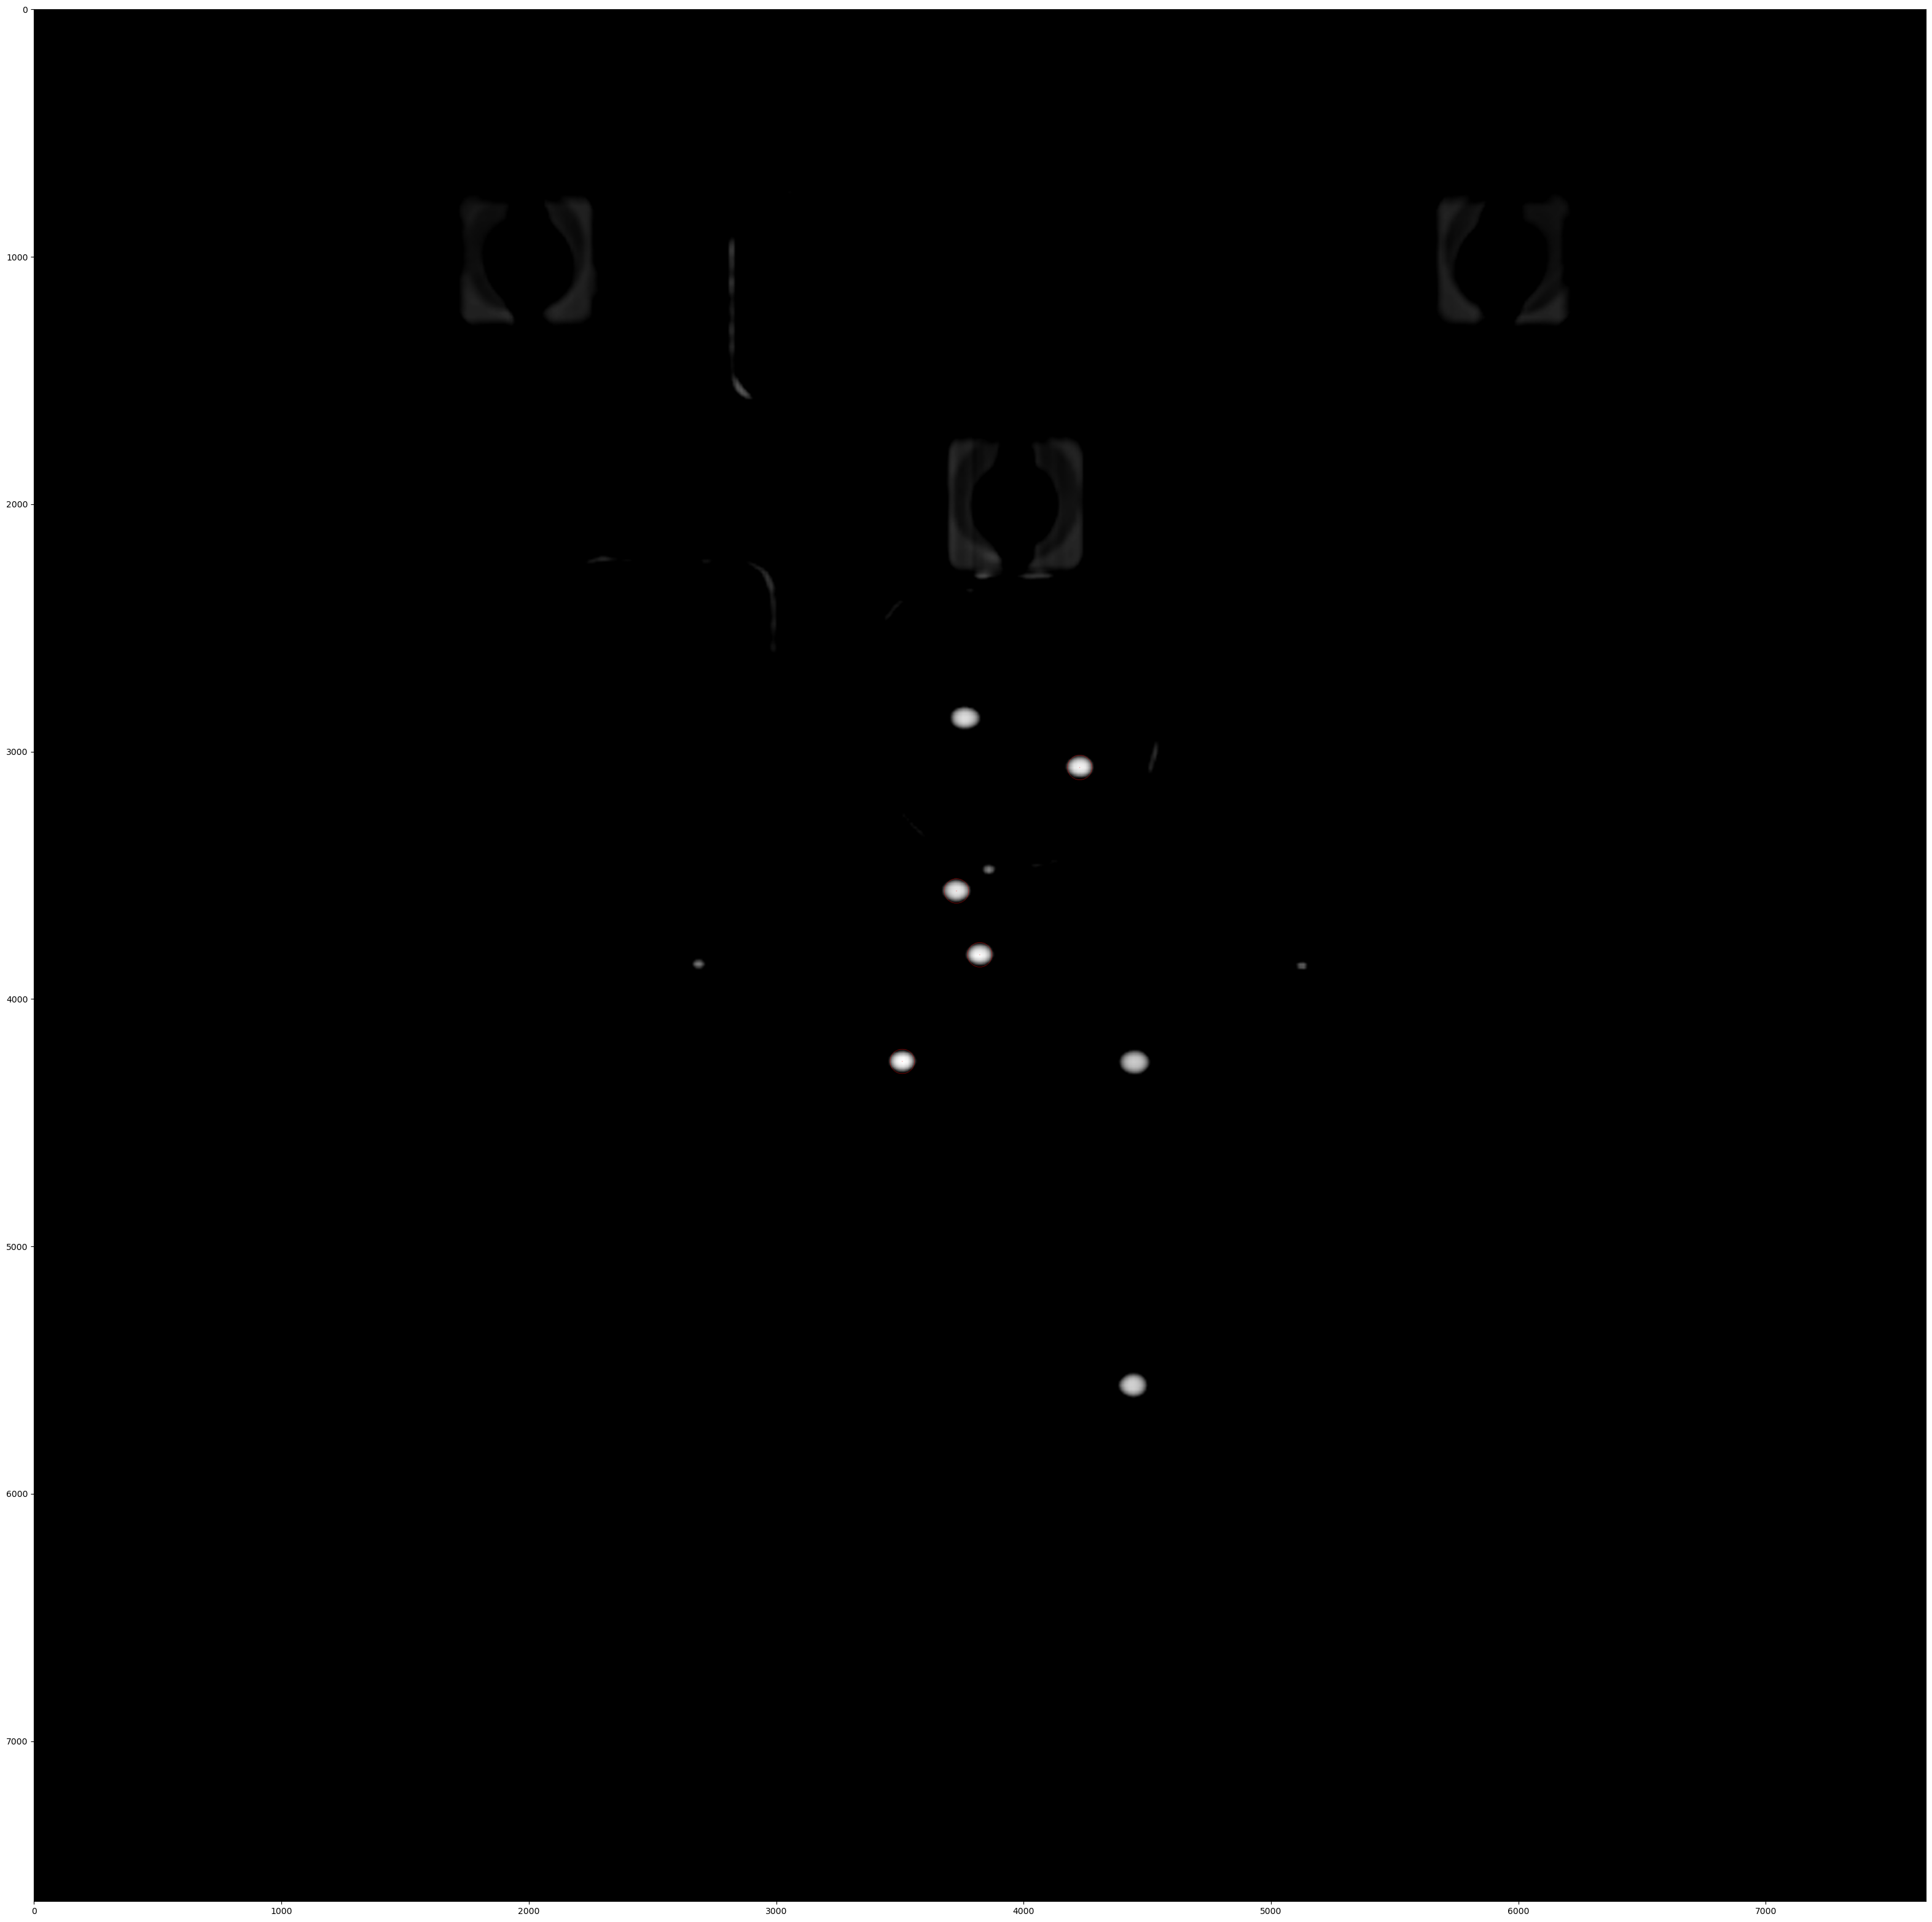

In [108]:
drr_upscaled_total_centers = []

for i, image_name in zip(range(0, len(drr_images_interpol_windowed_names)), drr_images_interpol_windowed_names):
    upscaled_image = cv2.imread(image_name)
    upscaled_image_copy = upscaled_image.copy()
    
    upscaled_total_centers_row = []
    
    j = 0
    for crop in crop_list_names[i]:
        crop_temp = cv2.imread(directory_name + '\\' + crop)
        crop_temp_gr = cv2.cvtColor(crop_temp, cv2.COLOR_BGR2GRAY)

        origin_coordinates = EPID_crops_read[i][j]
              
        up_left_corner_upscaled = (((origin_coordinates[0] + (int(xoff/8))) * 8)-20, ((origin_coordinates[1] + (int(yoff/8)) ) * 8)-20)
        center_converted = (up_left_corner_upscaled[0] + drr_total_centers[i][j][0], up_left_corner_upscaled[1] + drr_total_centers[i][j][1])

        upscaled_total_centers_row.append(center_converted)
        cv2.circle(upscaled_image_copy, (round(center_converted[0]), round(center_converted[1])), round(real_diameter / epid_images_new_pixel_spacing * 4), (255, 0, 0), 1)
        cv2.circle(upscaled_image_copy, (round(center_converted[0]), round(center_converted[1])), 1, (255, 0, 0), 1)

        j+=1
    drr_upscaled_total_centers.append(upscaled_total_centers_row)
    plt.figure(figsize=(50,40))
    plt.imshow(upscaled_image_copy)
    plt.show()

In [159]:
np.save("DRR_centers_upscaled.npy", drr_upscaled_total_centers)

## DRR / EPID - Showing Corresponding Balls in Blended Images 

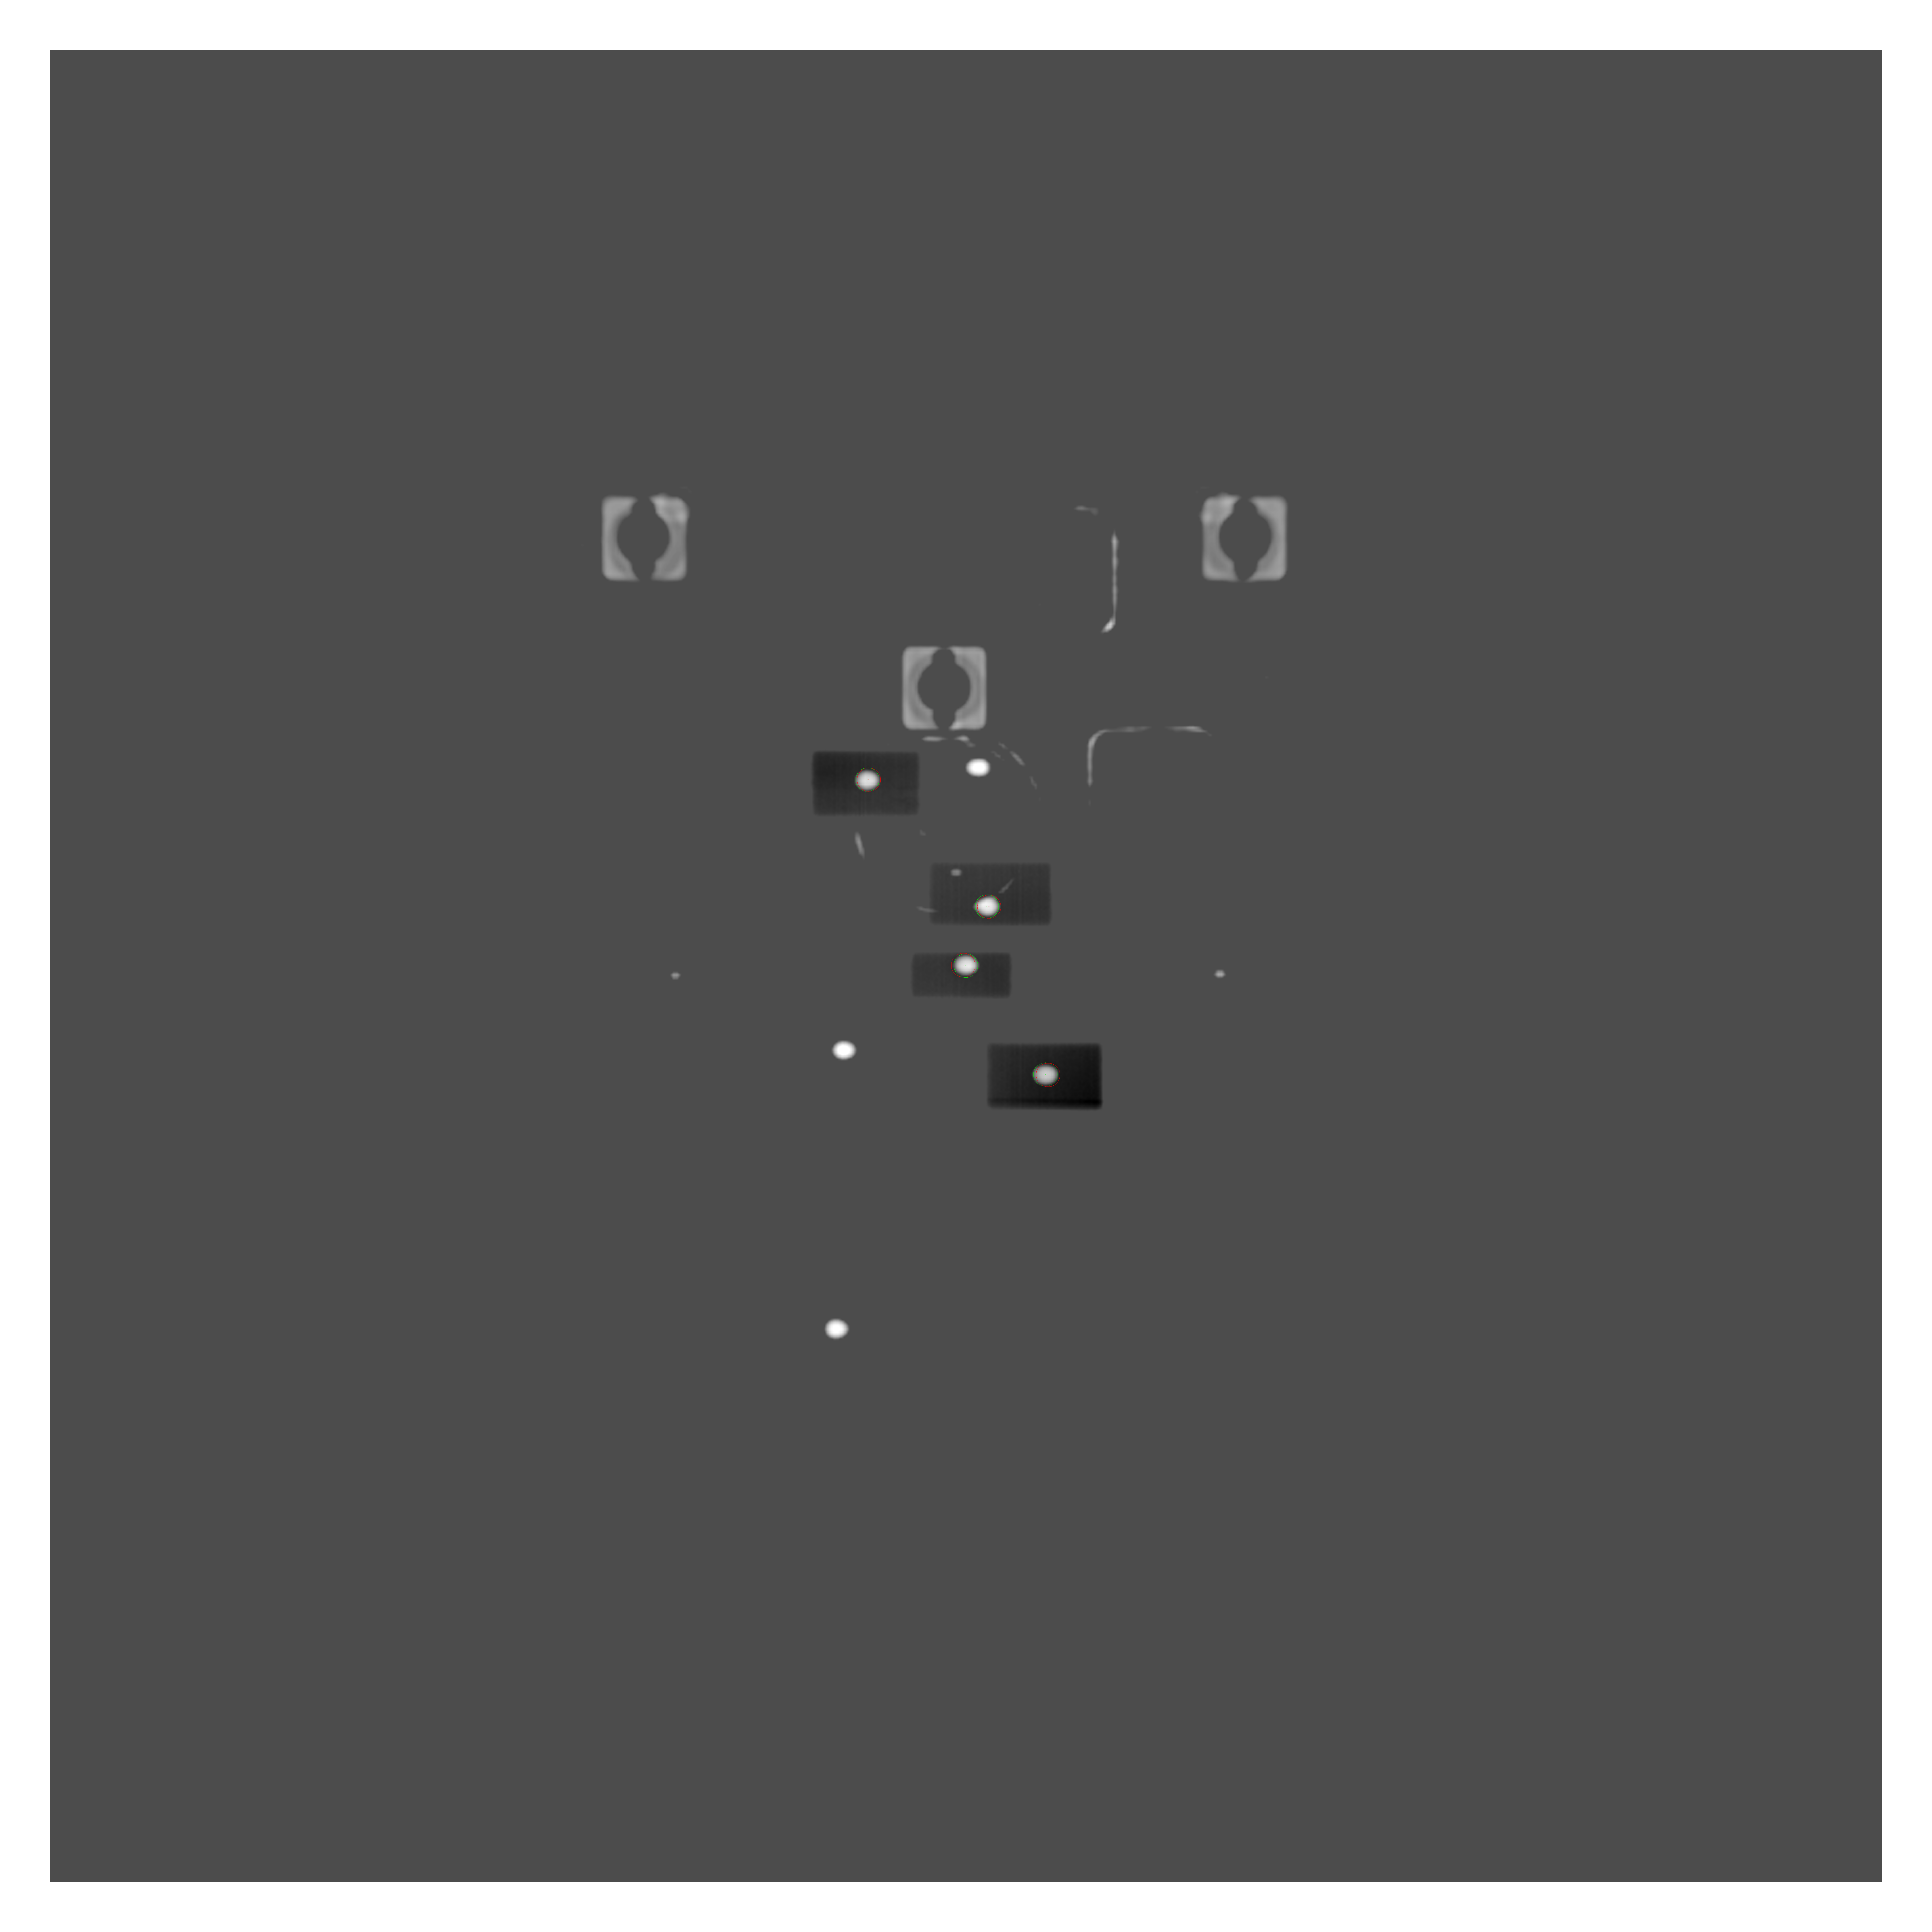

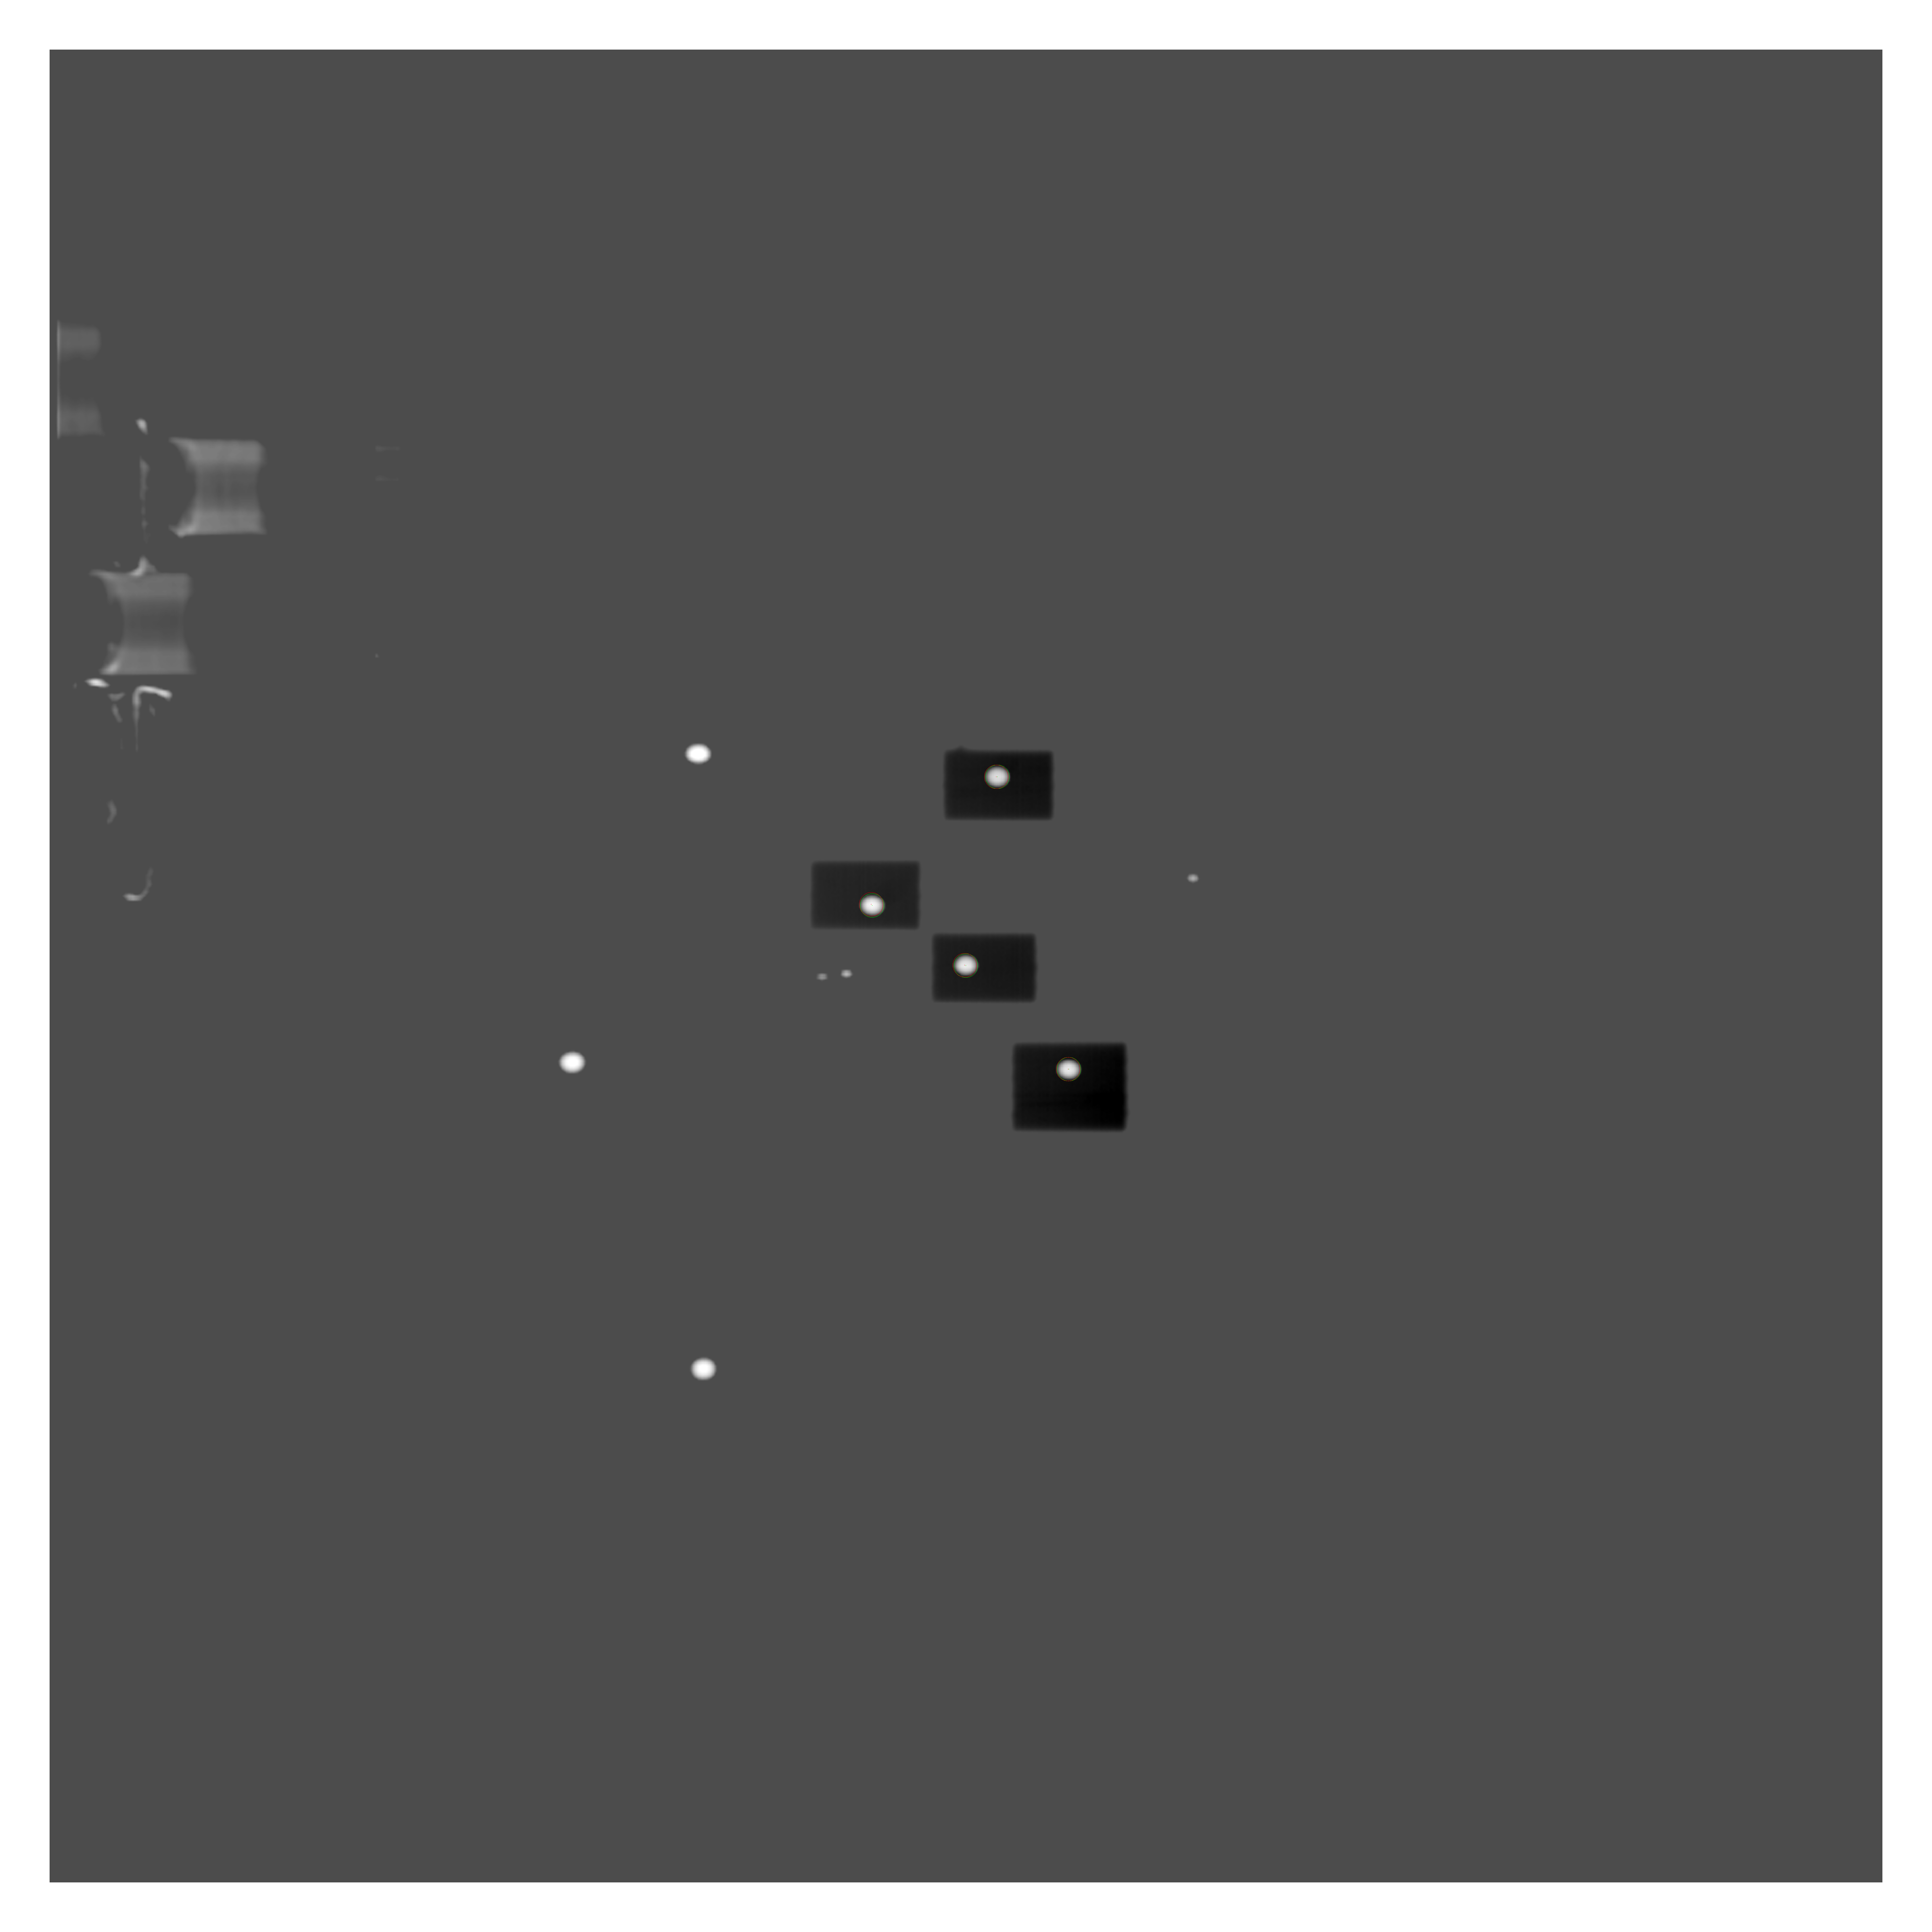

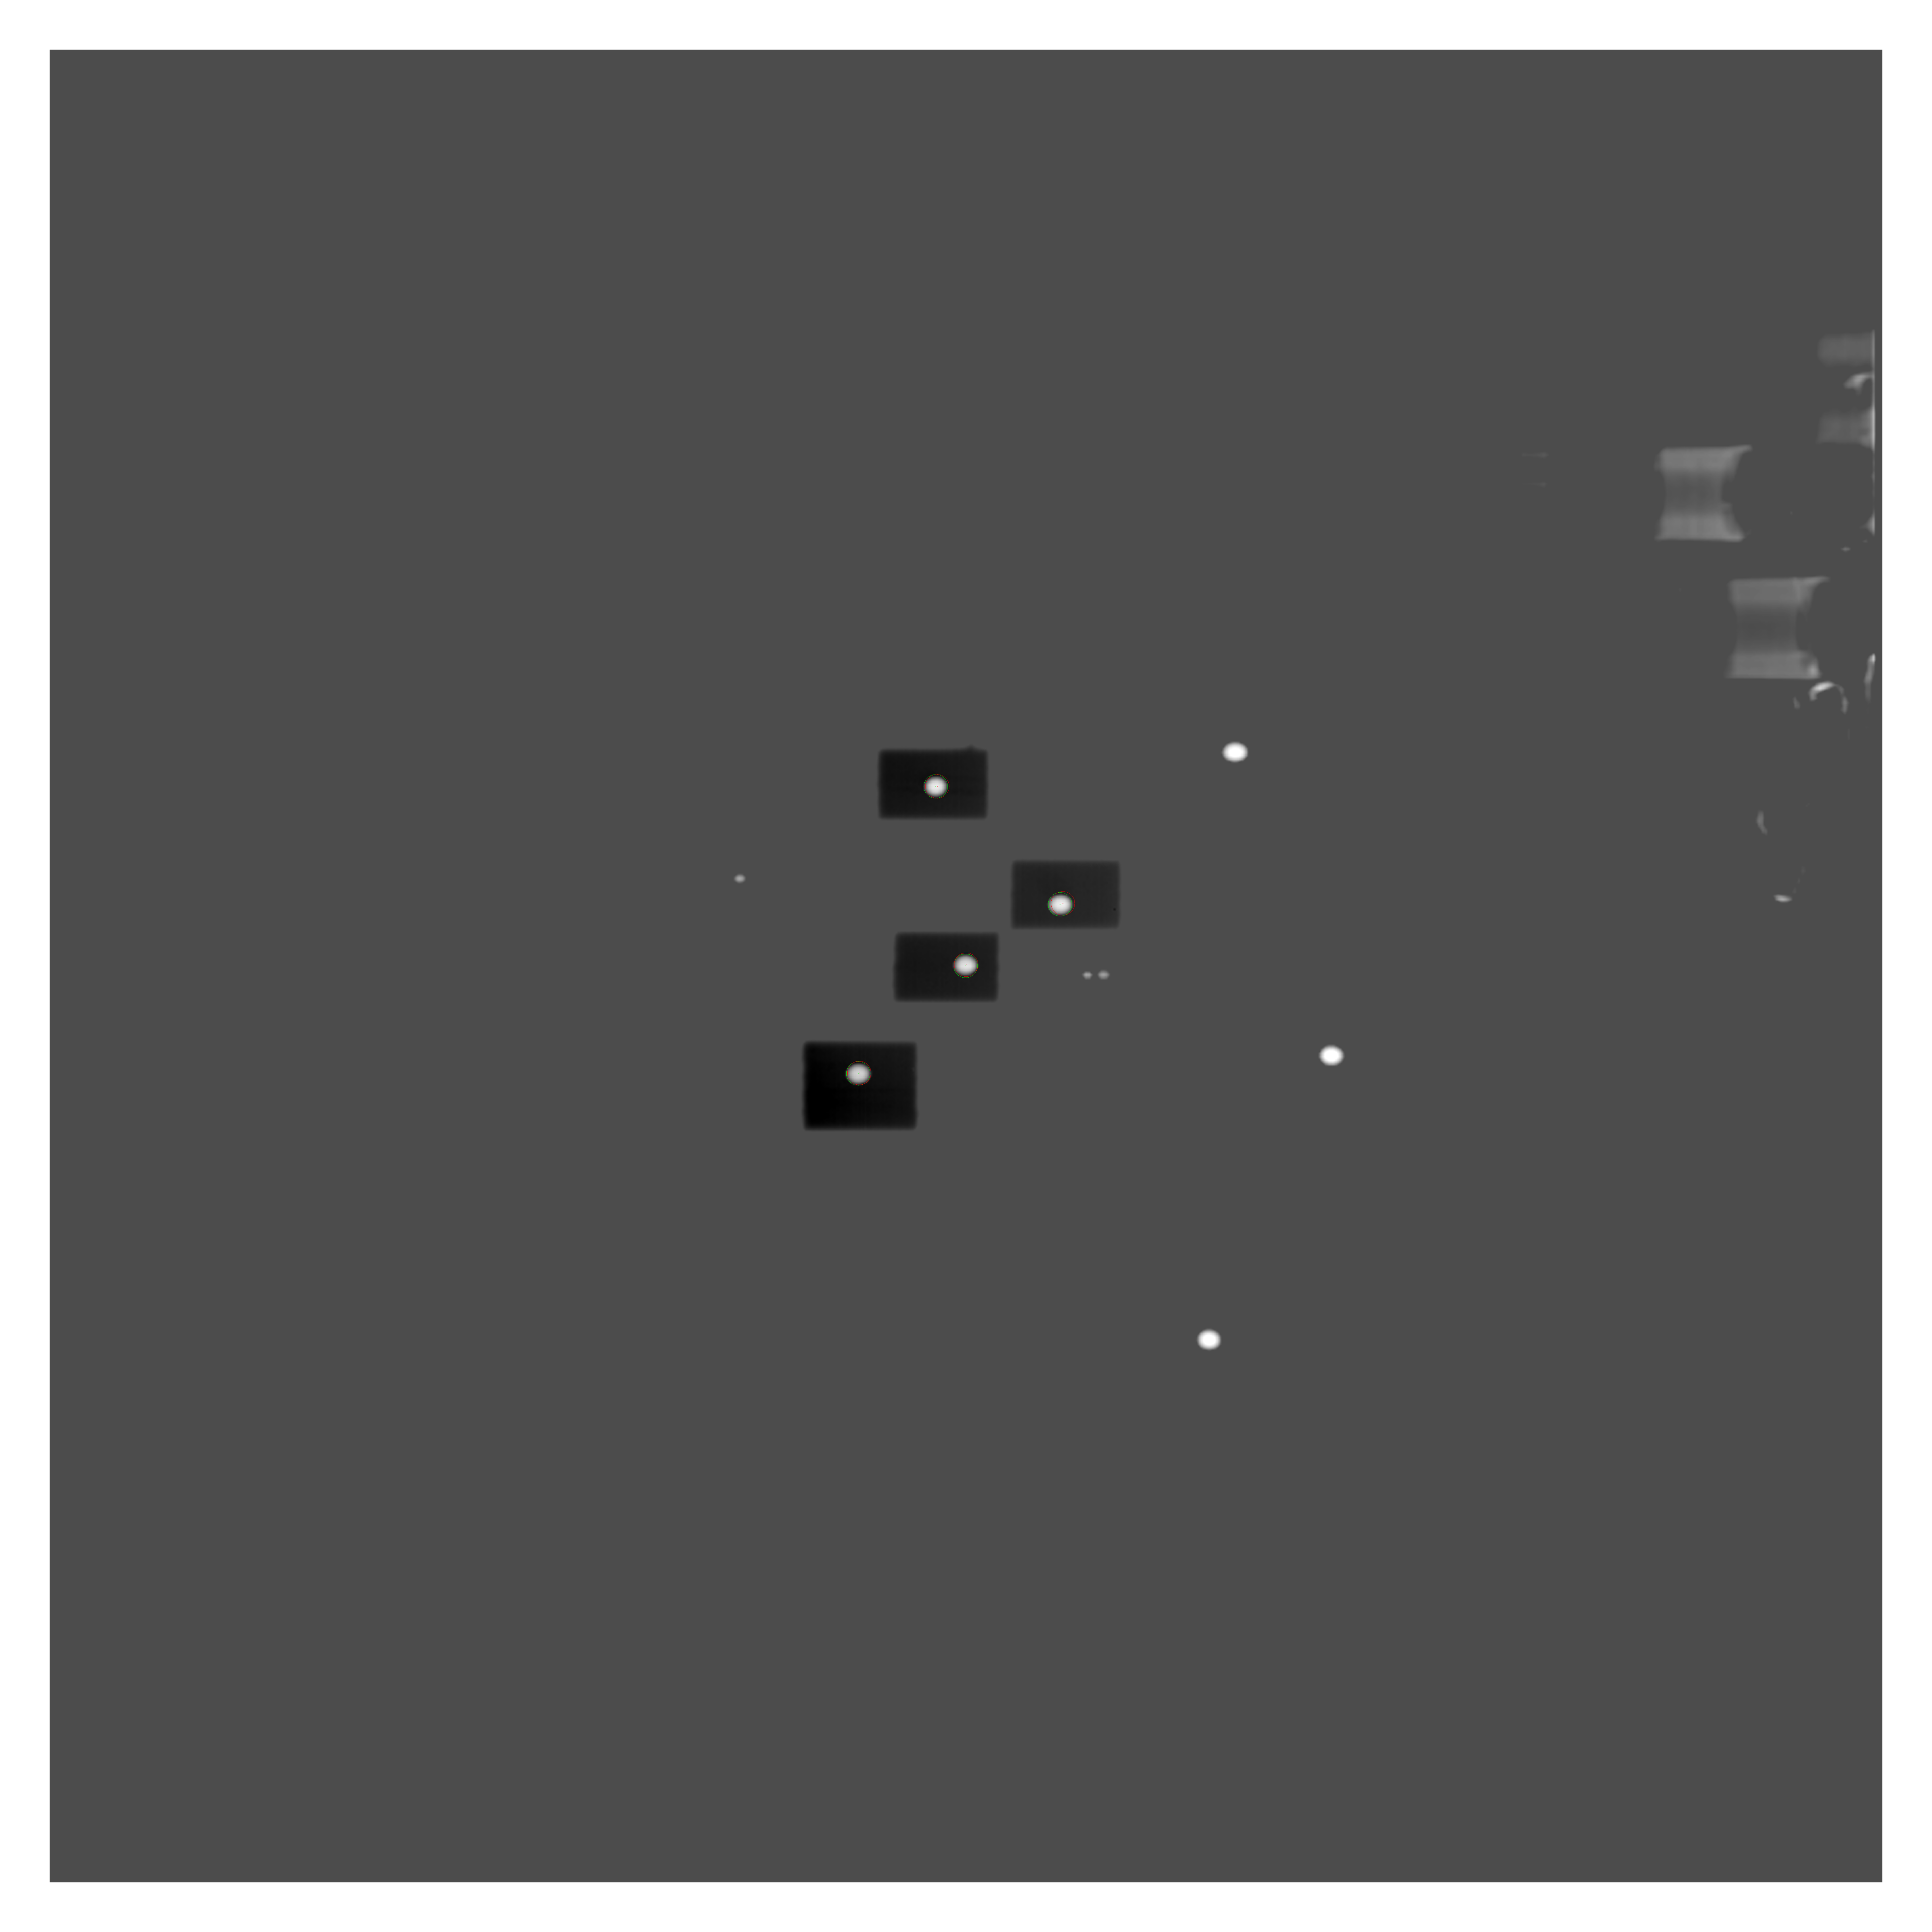

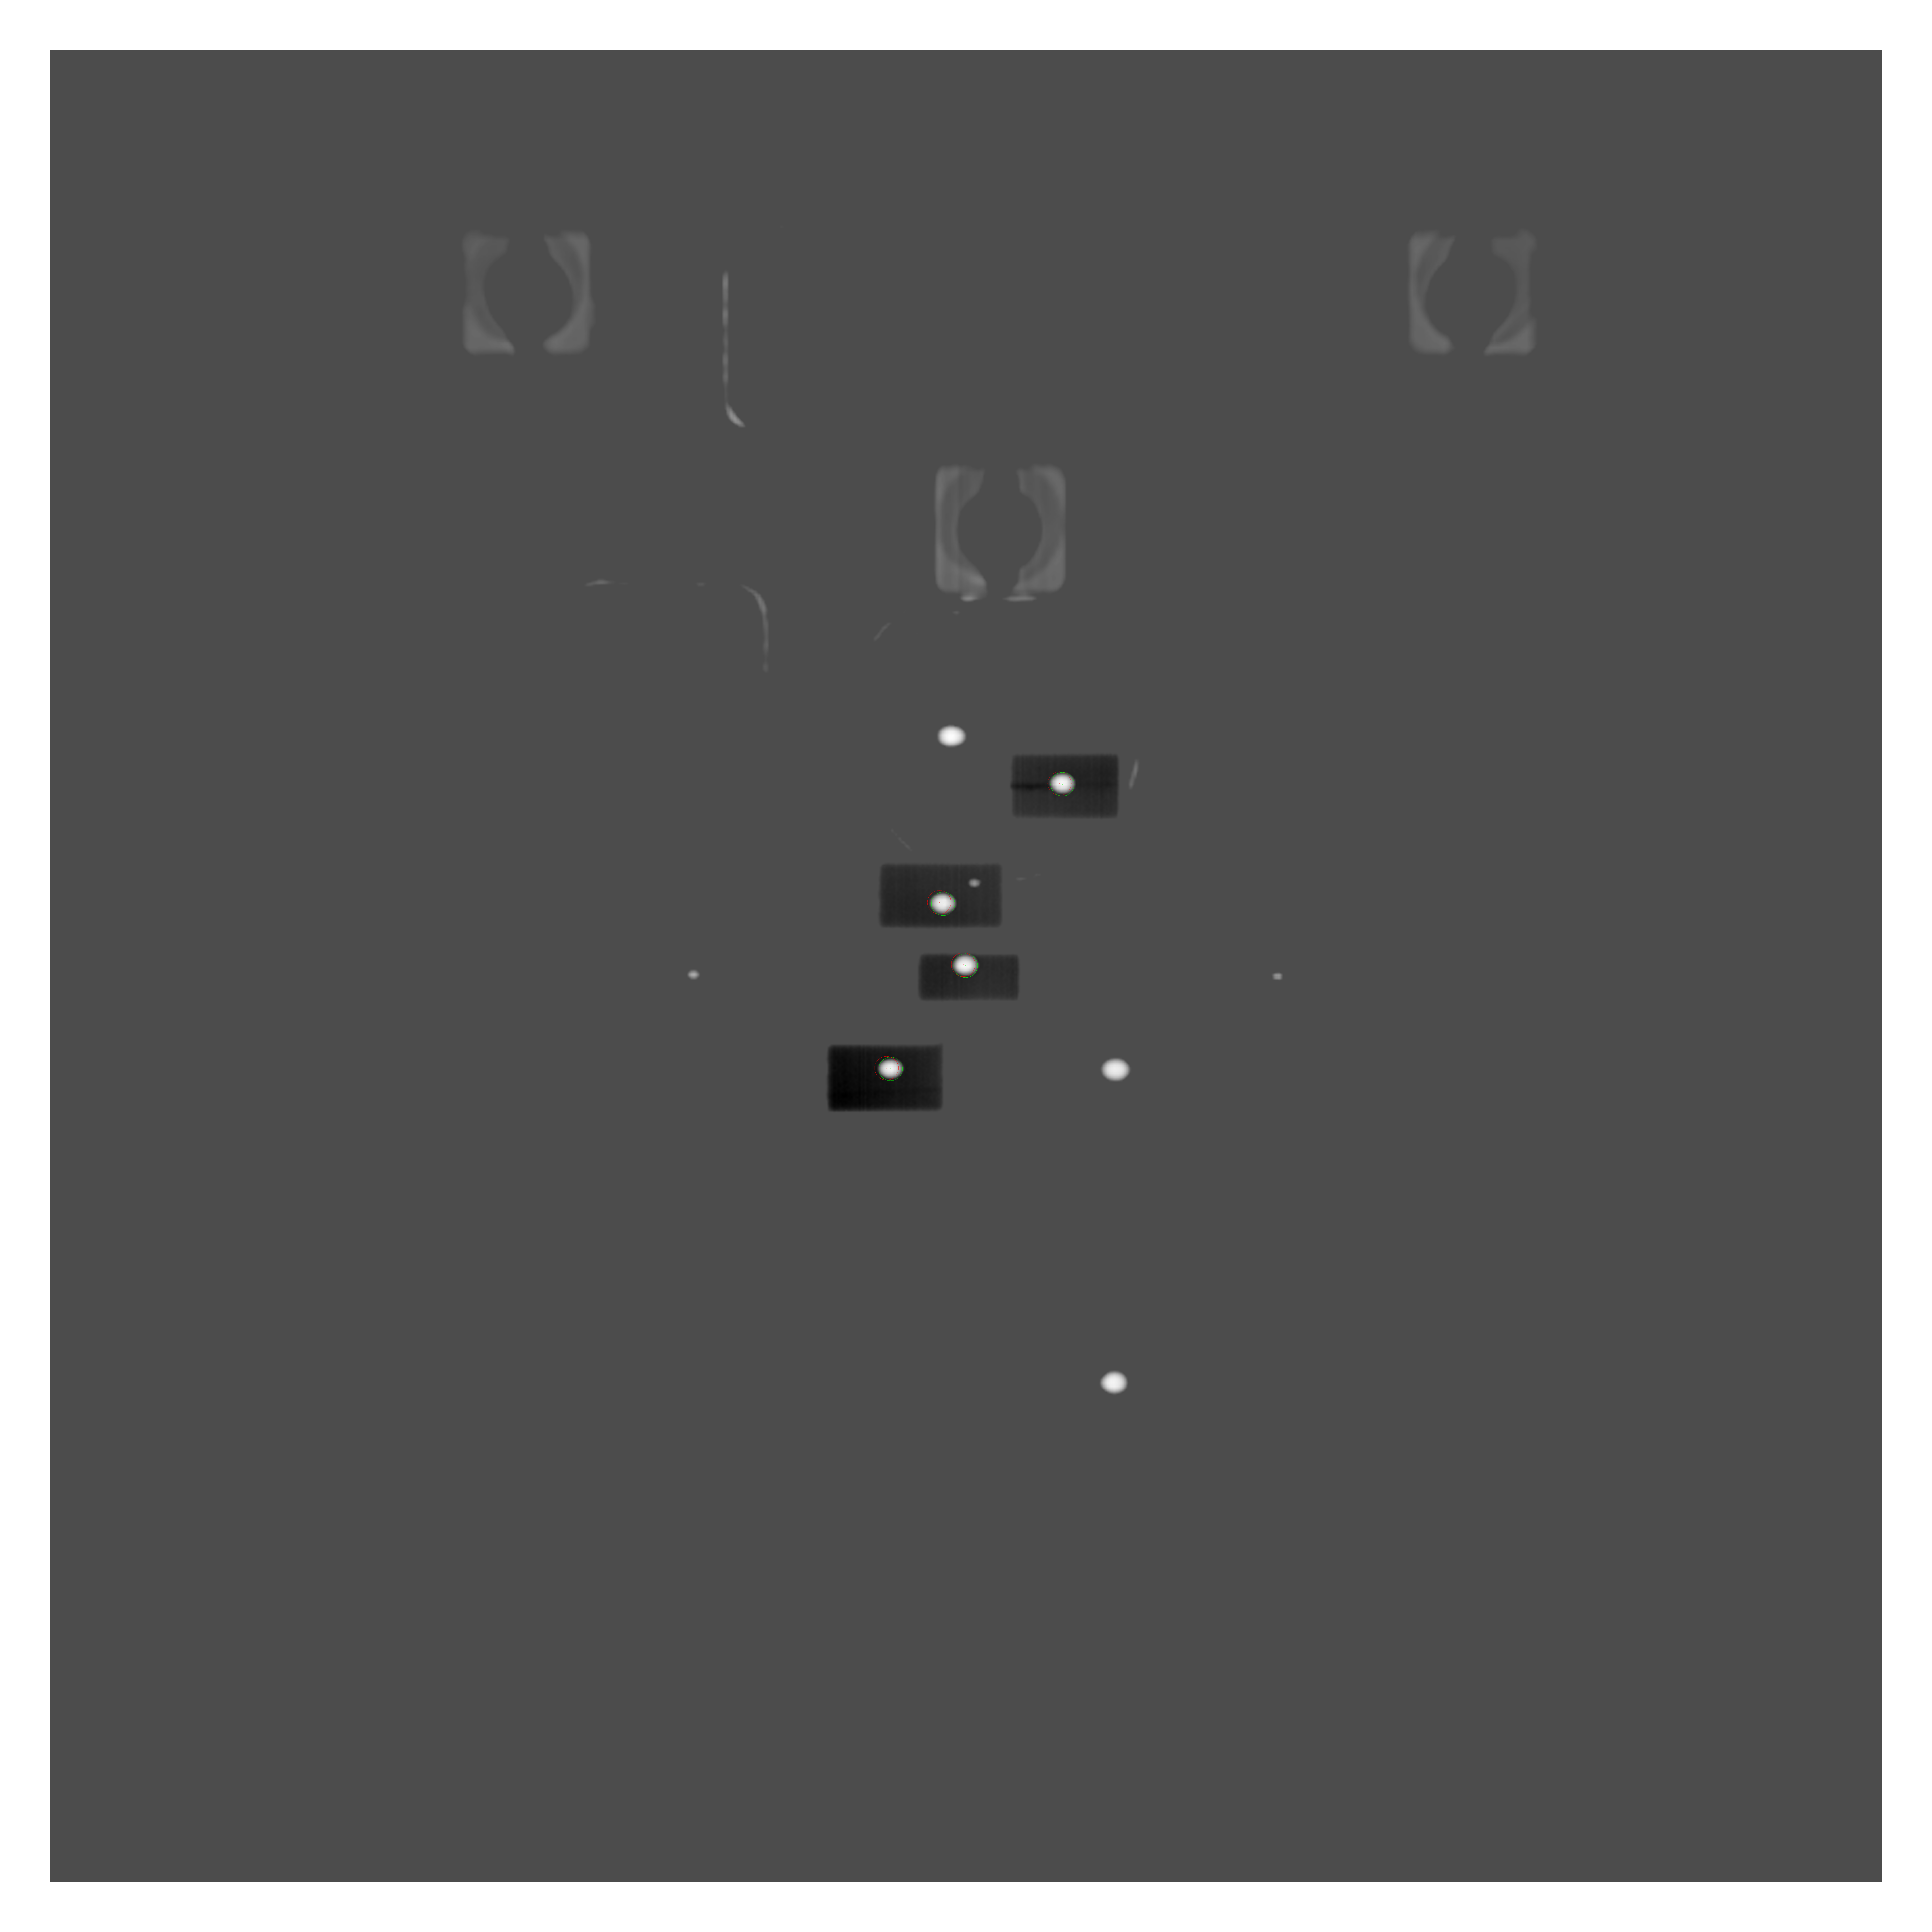

In [109]:
for i, image_name in zip(range(0, len(drr_images_interpol_windowed_names)), drr_images_interpol_windowed_names):

    img = np.zeros([hh, ww, 3], dtype=np.uint8)
    img.fill(255)

    img[0:yoff, :] = [255, 255, 255]
    img[yoff + h_mov:hh, :] =  [255, 255, 255]

    img[:, 0:xoff] = [255, 255, 255]
    img[:, xoff + w_mov:hh] =  [255, 255, 255]

    epid_temp = cv2.imread(epid_images_interpol_windowed_names[i])
    epid_temp = cv2.cvtColor(epid_temp, cv2.COLOR_BGR2RGB)
   
    img[yoff:hh-yoff, xoff:hh-xoff] = epid_temp 

    drr_temp = cv2.imread(drr_images_interpol_windowed_names[i])
    drr_temp = cv2.cvtColor(drr_temp, cv2.COLOR_BGR2RGB)
    
    fixed = np.asarray(drr_temp, np.uint8)

    moving_blending = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fixed_blending = cv2.cvtColor(fixed, cv2.COLOR_BGR2RGB)

    dst = cv2.addWeighted(fixed_blending, 0.8, moving_blending, 0.3, 0.0)

    for drr_circle, epid_circle in zip(drr_upscaled_total_centers[i], epid_upscaled_total_centers[i]):
    
        #drr
        cv2.circle(dst, ((drr_circle[0]), (drr_circle[1])), round(real_diameter / epid_images_new_pixel_spacing * 4), (0, 255, 0), 1)
        cv2.circle(dst, ((drr_circle[0]), (drr_circle[1])), 1, (0, 255, 0), 1)

        #epid
        cv2.circle(dst, ((epid_circle[0]) + xoff , (epid_circle[1]) + yoff), round(real_diameter / epid_images_new_pixel_spacing * 4), (255, 0, 0), 1)
        cv2.circle(dst, ((epid_circle[0]) + xoff, (epid_circle[1]) + yoff), 1, (255, 0, 0), 1)
    
    plt.figure(dpi=1500)
    plt.axis('off')
    plt.imshow(dst)
    plt.show()

## Read DRR_centers.npy and EPID_centers.npy

In [111]:
np_load_old = np.load

drr_centers_file = np_load_old("DRR_centers_upscaled.npy", allow_pickle=True)
epid_centers_file = np_load_old("EPID_centers_upscaled.npy", allow_pickle=True)

drr_centers_final_arr = []
epid_centers_final_arr = []

for i in range(0, len(drr_centers_file)):
    temp_drr = []
    temp_epid = []
    x = drr_centers_file[i]
    y = epid_centers_file[i]
    
    for iter_drr_line in range(0, len(x)):
            tupla_drr = (int(x[iter_drr_line][0]), int(x[iter_drr_line][1]))
            temp_drr.append(tupla_drr)
    for iter_epid_line in range(0, len(y)):
            tupla_epid = (int(y[iter_epid_line][0]) + xoff, int(y[iter_epid_line][1]) + yoff)
            temp_epid.append(tupla_epid)
            
    drr_centers_final_arr.append(temp_drr)
    epid_centers_final_arr.append(temp_epid)

In [112]:
# THESE FUNCTION SORTED THE CENTERS OF THE BALL WRT TO THE DISTANCE FROM THE ISOCENTER
# def the_key_drr(item):
#     return abs((item[0] - hh/2))
# def the_key_epid(item):
#     return abs((item[0] - hh/2))

# centers_drr = []
# centers_epid = []
# for i, name_drr in zip(range(0, len(drr_centers_final_arr)), get_abs_path_for_files(path_drr_images)):
#     image_dicom = dicom.dcmread(name_drr)
#     row=[]
#     for tupla in drr_centers_final_arr[i]:
#         x, y = translated_coordinates(ww/2, ww/2, tupla[0], tupla[1],-image_dicom.PatientSupportAngle)
#         row.append((x, y))
#     centers_drr.append(row)
    
#     drr_centers_final_arr[i] = sorted(drr_centers_final_arr[i], key=the_key_drr)
#     epid_centers_final_arr[i] = sorted(epid_centers_final_arr[i], key=the_key_epid)

Ordering the balls basing on their Y distance w.r.t the Isocenter

In [113]:
# def order_by_y_coord(item):
#     return item[1]

def the_key_epid(item):
    return abs((item[1] - hh/2))
def the_key_drr(item):
    return abs((item[1] - hh/2))

for i in range(0, len(drr_centers_final_arr)):
    drr_centers_final_arr[i] = sorted(drr_centers_final_arr[i], key=the_key_drr)
    epid_centers_final_arr[i] = sorted(epid_centers_final_arr[i], key=the_key_epid)

In [114]:
drr_centers_final_arr

[[(3823, 3822), (3911, 3575), (4155, 4276), (3412, 3046)],
 [(3823, 3822), (3432, 3571), (4253, 4254), (3955, 3034)],
 [(3822, 3823), (4216, 3566), (3374, 4272), (3697, 3074)],
 [(3822, 3822), (3728, 3564), (3509, 4253), (4226, 3065)]]

In [115]:
epid_centers_final_arr

[[(3832, 3820), (3920, 3576), (4166, 4278), (3418, 3046)],
 [(3818, 3820), (3428, 3574), (4250, 4254), (3950, 3034)],
 [(3824, 3818), (4228, 3562), (3378, 4270), (3704, 3074)],
 [(3814, 3812), (3712, 3558), (3492, 4250), (4214, 3062)]]

In [117]:
ball_distances = []

for i in range(0, int(len(drr_images_names))):
    print("Considering Image Projection: ", epid_images_names[i])
    print("\n")
    
    centers_current_image_drr = drr_centers_final_arr[i]
    centers_current_image_epid = epid_centers_final_arr[i]
    
    image = []
    for j_iterator_balls in range(0, len(centers_current_image_drr)):
        print("Ball ", j_iterator_balls, ": ")
        
        hor_shift = abs(centers_current_image_drr[j_iterator_balls][0] - centers_current_image_epid[j_iterator_balls][0])
        ver_shift = abs(centers_current_image_drr[j_iterator_balls][1] - centers_current_image_epid[j_iterator_balls][1])
        
        #2d shift for each ball and projection 
        hor_2d = math.sqrt(hor_shift**2 + ver_shift**2)
        
        image.append(hor_2d * epid_images_new_pixel_spacing / 8)
        
        print("2D Distance -> ", (hor_2d * epid_images_new_pixel_spacing / 8), "mm")
        print("\n")
        
    ball_distances.append(image)   
    print("-------------------")
    print("\n")

Considering Image Projection:  RI.C1 ANT.dcm


Ball  0 : 
2D Distance ->  0.6023225584365518 mm


Ball  1 : 
2D Distance ->  0.5915978570629703 mm


Ball  2 : 
2D Distance ->  0.7304233909194615 mm


Ball  3 : 
2D Distance ->  0.39198632506843645 mm


-------------------


Considering Image Projection:  RI.C1 LAT D.dcm


Ball  0 : 
2D Distance ->  0.35181849377275487 mm


Ball  1 : 
2D Distance ->  0.32665527089036367 mm


Ball  2 : 
2D Distance ->  0.19599316253421822 mm


Ball  3 : 
2D Distance ->  0.32665527089036367 mm


-------------------


Considering Image Projection:  RI.C1 LAT G.dcm


Ball  0 : 
2D Distance ->  0.35181849377275487 mm


Ball  1 : 
2D Distance ->  0.826379732570278 mm


Ball  2 : 
2D Distance ->  0.29216935636778457 mm


Ball  3 : 
2D Distance ->  0.45731737924650917 mm


-------------------


Considering Image Projection:  RI.C1 POST.dcm


Ball  0 : 
2D Distance ->  0.8366457129293122 mm


Ball  1 : 
2D Distance ->  1.116377543165992 mm


Ball  2 : 
2D Distanc

In [375]:
print(ball_distances)

[[0.60232256 0.59159786 0.73042339 0.39198633]
 [0.35181849 0.32665527 0.19599316 0.32665527]
 [0.35181849 0.82637973 0.29216936 0.45731738]
 [0.83664571 1.11637754 1.12778885 0.80810051]]


In [33]:
hor_shift = abs(3704 - 3700.5)
ver_shift = abs(3074 - 3075.125)
        
hor_2d = math.sqrt(hor_shift**2 + ver_shift**2)
print(hor_2d * epid_images_new_pixel_spacing / 8)

0.24018510417026212


In [376]:
np.savetxt("distance_balls.txt", ball_distances, delimiter=",")

## DRR - Theoretical Beam Field

In [120]:
RP_ds = dicom.dcmread(os.getcwd() + '\\PLAN\\RP.1.2.246.352.221.48988697973722890867372910305799034247.dcm')
num_beams = RP_ds.FractionGroupSequence[0].NumberOfBeams
beam_sequence = RP_ds.BeamSequence

names_list = []
beam_sequence_num_list = []
for i in range(0, num_beams):
    name = beam_sequence[i].BeamName
    if(name.startswith("C1")): ##| name.startswith("LAT D MLC2") | name.startswith("ANT MLC2") | name.startswith("ANT MLC3")):
        if (len(names_list) == 0) or ( not(name in names_list)):
            beam_sequence_num = i
            beam_sequence_num_list.append(beam_sequence_num)
            names_list.append(name)

In [121]:
beam_sequence_num_list
names_list

['C1 ANT MLC', 'C1 LAT D MLC', 'C1 POST MLC', 'C1 LAT G MLC']

In [122]:
jaw_position_x_arr = []
jaw_position_y_arr = []
            
for beam_sequence_num, name in zip (beam_sequence_num_list, names_list):
    if(len(beam_sequence[beam_sequence_num].BeamLimitingDeviceSequence) > 2):
        print("MLC {}\n".format(name.upper()))       
        print("\tLeaf MLC Position Boundaries: \n")
        leaf_position_boundaries = beam_sequence[beam_sequence_num].BeamLimitingDeviceSequence[2].LeafPositionBoundaries
        print(leaf_position_boundaries)
        #these are the boundaries in mm of beam limiting device (collimator) leaves. N is the number of leaf/jaw pairs


        print("\n\tLeaf MLC Positions: \n")
        leaf_positions = beam_sequence[beam_sequence_num].ControlPointSequence[0].BeamLimitingDevicePositionSequence[2].LeafJawPositions
        print(leaf_positions)
        # #these are the positions of beam liting device leaf or jaw pairs in mm. Contains 2N values, where N is the number
        # #of leaf/jaw pairs.

    print("\nJAWS {}\n".format(name.upper()))
    print("\tJaws shift from the isocenter: \n")
    jaw_position_x = beam_sequence[beam_sequence_num].ControlPointSequence[0].BeamLimitingDevicePositionSequence[0].LeafJawPositions
    print("X: ", jaw_position_x)
    jaw_position_y = beam_sequence[beam_sequence_num].ControlPointSequence[0].BeamLimitingDevicePositionSequence[1].LeafJawPositions
    print("Y: ", jaw_position_y)
    
    jaw_position_x_arr.append(jaw_position_x)
    jaw_position_y_arr.append(jaw_position_y)

    print("\n\n---------------------------------------- \n\n")

    
print(names_list)

MLC C1 ANT MLC

	Leaf MLC Position Boundaries: 

[-200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

	Leaf MLC Positions: 

[0, 0, 0, 0, 0, 0, 0, 0, 0, -0.24, 0, 0, 0, 0, 0, 0, 0.21, 0.21, 0.21, 0.21, -3.27, 0.04, 5.87, 5.87, 5.87, 5.87, 5.87, -51.54, -14.99, -14.99, -14.99, -50.75, -10.28, -10.28, -10.28, -10.28, -11.77, -52.38, -42.02, -42.02, -42.02, -42.02, -1.2, -1.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.24, 0, 0, 0, 0, 0, 0, 0.21, 0.21, 0.21, 0.21, -3.27, 0.04, 37.61, 37.61, 37.61, 37.61, 5.87, -51.54, 13.17, 13.17, 13.17, -50.75, 24.09, 24.09, 24.09, 24.09, -11.77, -52.38, -11.77, -11.77, -11.77, -11.77, -1.2, -1.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

JAWS C1 ANT MLC

	Jaws shift from th

In [123]:
inf_part_arr = []
sup_part_arr = []
left_part_arr = []
right_part_arr = []

for beam_sequence_num, name in zip (beam_sequence_num_list, names_list):
    if(len(beam_sequence[beam_sequence_num].BeamLimitingDeviceSequence) > 2):
        inf_part = beam_sequence[beam_sequence_num].BeamLimitingDeviceSequence[2].LeafPositionBoundaries[0:int((len(beam_sequence[beam_sequence_num].BeamLimitingDeviceSequence[2].LeafPositionBoundaries)) / 2)+1]
        sup_part = beam_sequence[beam_sequence_num].BeamLimitingDeviceSequence[2].LeafPositionBoundaries[int((len(beam_sequence[beam_sequence_num].BeamLimitingDeviceSequence[2].LeafPositionBoundaries)) / 2): len(beam_sequence[beam_sequence_num].BeamLimitingDeviceSequence[2].LeafPositionBoundaries)]
        
        inf_part_arr.append(inf_part)
        sup_part_arr.append(sup_part)
        
        left_part = beam_sequence[beam_sequence_num].ControlPointSequence[0].BeamLimitingDevicePositionSequence[2].LeafJawPositions[0: int(len(beam_sequence[beam_sequence_num].ControlPointSequence[0].BeamLimitingDevicePositionSequence[2].LeafJawPositions) / 2)]
        right_part = beam_sequence[beam_sequence_num].ControlPointSequence[0].BeamLimitingDevicePositionSequence[2].LeafJawPositions[int(len(beam_sequence[beam_sequence_num].ControlPointSequence[0].BeamLimitingDevicePositionSequence[2].LeafJawPositions) / 2): len(beam_sequence[beam_sequence_num].ControlPointSequence[0].BeamLimitingDevicePositionSequence[2].LeafJawPositions)]
       
        left_part_arr.append(left_part)
        right_part_arr.append(right_part)

In [124]:
leaf_position_boundaries.remove(leaf_position_boundaries[int(len(left_part)/2)])

In [125]:
x_center = round(upscaled_image.shape[0] / 2)
y_center = round(upscaled_image.shape[0] / 2)

total_squares = []

for (left_part, right_part, name) in zip (left_part_arr, right_part_arr, names_list):
    print(name.upper())
    
    bottom_corners = 0
    temp_square_left=[]
    temp_square_right=[]
    vector_of_squares=[]
    upper_corners = 0
    separate = 0

    for i in range(0, len(leaf_position_boundaries)):
        
        if (leaf_position_boundaries[i] < 0):
            
            if(left_part[i] != right_part[i]):
                    bottom_corners = 1
                    x_left = x_center + ((left_part[i] / epid_images_new_pixel_spacing) * 8)
                    y_left = y_center - ((leaf_position_boundaries[i] / epid_images_new_pixel_spacing) * 8)
                    x_right = x_center + ((right_part[i] / epid_images_new_pixel_spacing) * 8)
                    y_right = y_center - ((leaf_position_boundaries[i] / epid_images_new_pixel_spacing) * 8)

                    temp_square_left.append([x_left, y_left])
                    temp_square_right.append([x_right, y_right])

            else:
                if(bottom_corners == 1):
                    bottom_corners=0

                    x_left_upper = x_center + ((left_part[i-1] / epid_images_new_pixel_spacing) * 8)
                    y_left_upper = y_center - ((leaf_position_boundaries[i] / epid_images_new_pixel_spacing) * 8)
                    x_right_upper = x_center + ((right_part[i-1] / epid_images_new_pixel_spacing) * 8)
                    y_right_upper = y_center - ((leaf_position_boundaries[i] / epid_images_new_pixel_spacing) * 8)

                    temp_square_left.append([x_left_upper, y_left_upper])
                    temp_square_right.append([x_right_upper, y_right_upper])


                    temp_square_left = np.asarray(temp_square_left)
                    temp_square_right = np.asarray(temp_square_right)
                    square = ( (np.max([x[0] for x in temp_square_right]), np.min([x[1] for x in temp_square_right])), #topright
                               (np.min([x[0] for x in temp_square_left]), np.min([x[1] for x in temp_square_left])), #topleft
                               (np.min([x[0] for x in temp_square_left]), np.max([x[1] for x in temp_square_left])),  #bottomleft
                               (np.max([x[0] for x in temp_square_right]), np.max([x[1] for x in temp_square_right])) #bottomright 
                             )
                    vector_of_squares.append(square)
                    temp_square_left=[]
                    temp_square_right=[]
        else:
            x_left_overlap_now = x_center + ((left_part[i] / epid_images_new_pixel_spacing) * 8)
            x_right_overlap_now = x_center + ((right_part[i] / epid_images_new_pixel_spacing) * 8)

            x_left_overlap_previous = x_center + ((left_part[i-1] / epid_images_new_pixel_spacing) * 8)
            x_right_overlap_previous = x_center + ((right_part[i-1] / epid_images_new_pixel_spacing) * 8)
            
            
            if(((x_right_overlap_now < x_left_overlap_previous) or (x_left_overlap_now > x_right_overlap_previous))  and (x_right_overlap_previous - x_left_overlap_previous) > 250 and
              (x_right_overlap_now - x_left_overlap_now) > 250):
                separate = 1
            
            if(left_part[i] != right_part[i] and separate==0):
                if((upper_corners==0 and bottom_corners==1) or(upper_corners==1 and bottom_corners==1)):
                    upper_corners = 1
                    x_left = x_center + ((left_part[i] / epid_images_new_pixel_spacing) * 8)
                    y_left = y_center - ((leaf_position_boundaries[i] / epid_images_new_pixel_spacing) * 8)
                    x_right = x_center + ((right_part[i] / epid_images_new_pixel_spacing) * 8)
                    y_right = y_center - ((leaf_position_boundaries[i] / epid_images_new_pixel_spacing) * 8)

                    temp_square_left.append([x_left, y_left])
                    temp_square_right.append([x_right, y_right])
                    
                if(upper_corners== 0 and bottom_corners==0):
                    upper_corners = 1
                    
                    x_left = x_center + ((left_part[i] / epid_images_new_pixel_spacing) * 8)
                    y_left = y_center - ((leaf_position_boundaries[i-1] / epid_images_new_pixel_spacing) * 8)
                    x_right = x_center + ((right_part[i] / epid_images_new_pixel_spacing) * 8)
                    y_right = y_center - ((leaf_position_boundaries[i-1] / epid_images_new_pixel_spacing) * 8)

                    temp_square_left.append([x_left, y_left])
                    temp_square_right.append([x_right, y_right])

            else:
                if((upper_corners == 1 and bottom_corners == 1) or (upper_corners == 1 and bottom_corners == 0)):
                    bottom_corners = 0
                    upper_corners = 0

                    x_left_upper = x_center + ((left_part[i-1] / epid_images_new_pixel_spacing) * 8)
                    y_left_upper = y_center - ((leaf_position_boundaries[i-1] / epid_images_new_pixel_spacing) * 8)
                    x_right_upper = x_center + ((right_part[i-1] / epid_images_new_pixel_spacing) * 8)
                    y_right_upper = y_center - ((leaf_position_boundaries[i-1] / epid_images_new_pixel_spacing) * 8)

                    
                    temp_square_left.append([x_left_upper, y_left_upper])
                    temp_square_right.append([x_right_upper, y_right_upper])                    
                    
                    temp_square_left = np.asarray(temp_square_left)
                    temp_square_right = np.asarray(temp_square_right)
                    square = ( (np.max([x[0] for x in temp_square_right]), np.min([x[1] for x in temp_square_right])), #topright
                               (np.min([x[0] for x in temp_square_left]), np.min([x[1] for x in temp_square_left])), #topleft
                               (np.min([x[0] for x in temp_square_left]), np.max([x[1] for x in temp_square_left])),  #bottomleft
                               (np.max([x[0] for x in temp_square_right]), np.max([x[1] for x in temp_square_right])) #bottomright 
                             )
                    vector_of_squares.append(square)
                    temp_square_left=[]
                    temp_square_right=[]
                    
                    if(separate==1):
                        
                        x_left_upper = x_center + ((left_part[i] / epid_images_new_pixel_spacing) * 8)
                        y_left_upper = y_center - ((leaf_position_boundaries[i-1] / epid_images_new_pixel_spacing) * 8)
                        x_right_upper = x_center + ((right_part[i] / epid_images_new_pixel_spacing) * 8)
                        y_right_upper = y_center - ((leaf_position_boundaries[i-1] / epid_images_new_pixel_spacing) * 8)


                        temp_square_left.append([x_left_upper, y_left_upper])
                        temp_square_right.append([x_right_upper, y_right_upper]) 
                        separate=0
                   
    total_squares.append(vector_of_squares)

C1 ANT MLC
C1 LAT D MLC
C1 POST MLC
C1 LAT G MLC


In [126]:
# x_center = round(upscaled_image.shape[0] / 2)
# y_center = round(upscaled_image.shape[0] / 2)

# mlc_coordinates_arr = []

# for (left_part, right_part, name) in zip (left_part_arr, right_part_arr, names_list):

#     x_left_s = []
#     y_left_s = []
#     x_right_s = []
#     y_right_s = []

#     bottom_level = 0
#     squares_counter = 0  #se è 0 mi serve per prendere gli spingoli inferiori di ciascun rettangolo
#     squares_arr = []
#     for i in range(0, len(leaf_position_boundaries)):
#         if(left_part[i] != 0 and right_part[i] != 0):
#             if(squares_counter == 0):
#                     x_left_bottom = x_center + ((left_part[i] / epid_images_new_pixel_spacing) * 8)
#                     y_left_bottom = y_center - ((leaf_position_boundaries[i]  / epid_images_new_pixel_spacing) * 8)
#                     x_right_bottom = x_center + ((right_part[i] / epid_images_new_pixel_spacing) * 8)
#                     y_right_bottom = y_center - ((leaf_position_boundaries[i] / epid_images_new_pixel_spacing) * 8)
#                     squares_counter = 1
#                     bottom_level= bottom_level + 1
#                     x_left_s.append(x_left_bottom)
#                     y_left_s.append(y_left_bottom)
#                     x_right_s.append(x_right_bottom)
#                     y_right_s.append(y_right_bottom)

#             if (bottom_level != 1): #così salto il primo giro
#                 if(squares_counter == 1):
#                         x_left_top = x_center + ((left_part[i] / epid_images_new_pixel_spacing) * 8)
#                         y_left_top = y_center - ((leaf_position_boundaries[i]  / epid_images_new_pixel_spacing) * 8)
#                         x_right_top = x_center + ((right_part[i] / epid_images_new_pixel_spacing) * 8)
#                         y_right_top = y_center - ((leaf_position_boundaries[i] / epid_images_new_pixel_spacing) * 8)

#                         x_left_s.append(x_left_top)
#                         y_left_s.append(y_left_top)
#                         x_right_s.append(x_right_top)
#                         y_right_s.append(y_right_top)
#             bottom_level= bottom_level + 1

#         elif(squares_counter != 0):
#             x_left_top = x_center + ((left_part[i-1] / epid_images_new_pixel_spacing) * 8)
#             y_left_top = y_center - ((leaf_position_boundaries[i-1]  / epid_images_new_pixel_spacing) * 8)
#             x_right_top = x_center + ((right_part[i-1] / epid_images_new_pixel_spacing) * 8)
#             y_right_top = y_center - ((leaf_position_boundaries[i-1] / epid_images_new_pixel_spacing) * 8)
#             x_left_s.append(x_left_top)
#             y_left_s.append(y_left_top)
#             x_right_s.append(x_right_top)
#             y_right_s.append(y_right_top)
            
#             squares_counter = 0
#             bottom_level = 0
#             top_right_square = (np.max(x_right_s), np.min(y_right_s))
#             top_left_square = (np.min(x_left_s), np.min(y_left_s))
#             bottom_left_square = (np.min(x_left_s), np.max(y_left_s)) 
#             bottom_right_square = (np.max(x_right_s), np.max(y_right_s))

#             print(name.upper())
#             print("Top Right MLC coordinates: ", top_right_square)
#             print("Top Left MLC coordinates: ", top_left_square)
#             print("Bottom Left MLC coordinates: ", bottom_left_square)
#             print("Bottom Right MLC coordinates: ", bottom_right_square)
#             print("\n")
            
            
#             tupla = (top_right_square, top_left_square, bottom_left_square, bottom_right_square)        
#             squares_arr.append(tupla)
#             x_left_s = []
#             y_left_s = []
#             x_right_s = []
#             y_right_s = []
            
#     mlc_coordinates_arr.append(squares_arr) 

In [127]:
jaws_coordinates_arr = []

for jaw_position_x, jaw_position_y, name in zip(jaw_position_x_arr, jaw_position_y_arr, names_list):
    
    top_right_JAWS_x = x_center + ((jaw_position_x[1] / epid_images_new_pixel_spacing) * 8)
    top_right_JAWS_y = y_center - ((jaw_position_y[1] / epid_images_new_pixel_spacing) * 8)

    top_left_JAWS_x = x_center + ((jaw_position_x[0] / epid_images_new_pixel_spacing) * 8)
    top_left_JAWS_y = y_center - ((jaw_position_y[1] / epid_images_new_pixel_spacing) * 8)

    bottom_left_JAWS_x = x_center + ((jaw_position_x[0] / epid_images_new_pixel_spacing) * 8)
    bottom_left_JAWS_y = y_center - ((jaw_position_y[0] / epid_images_new_pixel_spacing) * 8)

    bottom_right_JAWS_x = x_center + ((jaw_position_x[1] / epid_images_new_pixel_spacing) * 8)
    bottom_right_JAWS_y = y_center - ((jaw_position_y[0] / epid_images_new_pixel_spacing) * 8)


    top_right_JAWS = (top_right_JAWS_x, top_right_JAWS_y)
    top_left_JAWS = (top_left_JAWS_x, top_left_JAWS_y)
    bottom_left_JAWS = (bottom_left_JAWS_x, bottom_left_JAWS_y)
    bottom_right_JAWS = (bottom_right_JAWS_x, bottom_right_JAWS_y)

    print(name.upper())
    print("Top Right JAWS coordinates: ", top_right_JAWS)
    print("Top Left JAWS coordinates: ", top_left_JAWS)
    print("Bottom Left JAWS coordinates: ", bottom_left_JAWS)
    print("Bottom Right JAWS coordinates: ", bottom_right_JAWS)
    print("\n")
    
    tupla = (top_right_JAWS, top_left_JAWS, bottom_left_JAWS, bottom_right_JAWS)
    jaws_coordinates_arr.append(tupla)

C1 ANT MLC
Top Right JAWS coordinates:  (4451.572913307757, 2890.293958249435)
Top Left JAWS coordinates:  (3135.2004610036815, 2890.293958249435)
Bottom Left JAWS coordinates:  (3135.2004610036815, 4482.186226152037)
Bottom Right JAWS coordinates:  (4451.572913307757, 4482.186226152037)


C1 LAT D MLC
Top Right JAWS coordinates:  (4589.33282110702, 2844.373988983014)
Top Left JAWS coordinates:  (3135.2004610036815, 2844.373988983014)
Bottom Left JAWS coordinates:  (3135.2004610036815, 4574.02616468488)
Bottom Right JAWS coordinates:  (4589.33282110702, 4574.02616468488)


C1 POST MLC
Top Right JAWS coordinates:  (4512.799538996318, 2890.293958249435)
Top Left JAWS coordinates:  (3196.4270866922434, 2890.293958249435)
Bottom Left JAWS coordinates:  (3196.4270866922434, 4482.186226152037)
Bottom Right JAWS coordinates:  (4512.799538996318, 4482.186226152037)


C1 LAT G MLC
Top Right JAWS coordinates:  (4512.799538996318, 2844.373988983014)
Top Left JAWS coordinates:  (3058.66717889298, 

In [128]:
field_coordinates_arr = []
for jaws_coordinates, coordinates, name in zip(jaws_coordinates_arr, total_squares, names_list):
    field_singular = []
    for mlc_coordinates in coordinates:
#         top_right_FIELD_x = mlc_coordinates[0][0] if mlc_coordinates[0][0] < jaws_coordinates[0][0] else jaws_coordinates[0][0]  
#         top_right_FIELD_y = mlc_coordinates[0][1] if mlc_coordinates[0][1] > jaws_coordinates[0][1] else jaws_coordinates[0][1]  

#         top_left_FIELD_x = mlc_coordinates[1][0] if mlc_coordinates[1][0] > jaws_coordinates[1][0] else jaws_coordinates[1][0] 
#         top_left_FIELD_y = mlc_coordinates[1][1] if mlc_coordinates[1][1] > jaws_coordinates[1][1] else jaws_coordinates[1][1] 

#         bottom_left_FIELD_x = mlc_coordinates[2][0] if mlc_coordinates[2][0] > jaws_coordinates[2][0] else jaws_coordinates[2][0] 
#         bottom_left_FIELD_y = mlc_coordinates[2][1] if mlc_coordinates[2][1] < jaws_coordinates[2][1] else jaws_coordinates[2][1]

#         bottom_right_FIELD_x = mlc_coordinates[3][0] if mlc_coordinates[3][0] < jaws_coordinates[3][0] else jaws_coordinates[3][0]
#         bottom_right_FIELD_y = mlc_coordinates[3][1] if mlc_coordinates[3][1] < jaws_coordinates[3][1] else jaws_coordinates[3][1]
        
        top_right_FIELD_x = mlc_coordinates[0][0]
        top_right_FIELD_y = mlc_coordinates[0][1]
        top_left_FIELD_x = mlc_coordinates[1][0]
        top_left_FIELD_y = mlc_coordinates[1][1]
        bottom_left_FIELD_x = mlc_coordinates[2][0]
        bottom_left_FIELD_y = mlc_coordinates[2][1]
        bottom_right_FIELD_x = mlc_coordinates[3][0]
        bottom_right_FIELD_y = mlc_coordinates[3][1]
        
        

        top_right_FIELD = (top_right_FIELD_x, top_right_FIELD_y)
        top_left_FIELD = (top_left_FIELD_x, top_left_FIELD_y) 
        bottom_left_FIELD = (bottom_left_FIELD_x, bottom_left_FIELD_y)
        bottom_right_FIELD = (bottom_right_FIELD_x, bottom_right_FIELD_y)

        print(name.upper())
        print("Top Right  coordinates: ", top_right_FIELD)
        print("Top Left  coordinates: ", top_left_FIELD)
        print("Bottom Left  coordinates: ", bottom_left_FIELD)
        print("Bottom Right  coordinates: ", bottom_right_FIELD)
        print("\n")

        tupla = (top_right_FIELD, top_left_FIELD, bottom_left_FIELD, bottom_right_FIELD)
        field_singular.append(tupla)
        
    field_coordinates_arr.append(field_singular)

C1 ANT MLC
Top Right  coordinates:  (4399.6833480367, 4130.133128442808)
Top Left  coordinates:  (3913.8500731979643, 4130.133128442808)
Bottom Left  coordinates:  (3913.8500731979643, 4436.266256885617)
Bottom Right  coordinates:  (4399.6833480367, 4436.266256885617)


C1 ANT MLC
Top Right  coordinates:  (4025.588665079589, 3747.466717889298)
Top Left  coordinates:  (3594.553220232115, 3747.466717889298)
Bottom Left  coordinates:  (3594.553220232115, 3977.066564221404)
Bottom Right  coordinates:  (4025.588665079589, 3977.066564221404)


C1 ANT MLC
Top Right  coordinates:  (4192.7373532093625, 3364.8003073357877)
Top Left  coordinates:  (3666.6475719803966, 3364.8003073357877)
Bottom Left  coordinates:  (3666.6475719803966, 3670.933435778596)
Bottom Right  coordinates:  (4192.7373532093625, 3670.933435778596)


C1 ANT MLC
Top Right  coordinates:  (3643.8406539114076, 2905.6006146715754)
Top Left  coordinates:  (3180.81429714166, 2905.6006146715754)
Bottom Left  coordinates:  (3180.8142

In [129]:
from math import sin, cos, radians

x_center_MLC = x_center 
y_center_MLC = y_center

angle = beam_sequence[beam_sequence_num].ControlPointSequence[0].BeamLimitingDeviceAngle

def rotate_point(point, angle, center_point=(0, 0)):
    """Rotates a point around center_point(origin by default)
    Angle is in degrees.
    Rotation is counter-clockwise
    """
    angle_rad = radians(angle % 360)
    # Shift the point so that center_point becomes the origin
    new_point = (point[0] - center_point[0], point[1] - center_point[1])
    new_point = (new_point[0] * cos(angle_rad) - new_point[1] * sin(angle_rad),
                 new_point[0] * sin(angle_rad) + new_point[1] * cos(angle_rad))
    # Reverse the shifting we have done
    new_point = (new_point[0] + center_point[0], new_point[1] + center_point[1])
    return new_point      

def translated_coordinates(cx, cy, x, y, angle):
    if(x >= cx and y <= cy):
        new_x = (x - cx)
        new_y = (cy - y)
        point = [new_x, new_y]
        rotated_point = rotate_point(point, angle)
        print("[INFO] Top Right - Original Point= (%f, %f), New Point= (%f, %f)" % (x, y, rotated_point[0] + cx, cy - rotated_point[1]))
        return (rotated_point[0] + cx), (cy - rotated_point[1])
        
    if(x >= cx and y >= cy):
        new_x = (x - cx)
        new_y = (cy - y)
        point = [new_x, new_y]
        rotated_point = rotate_point(point, angle)
        print("[INFO] Bottom Right - Original Point= (%f, %f), New Point= (%f, %f)" % (x, y, rotated_point[0] + cx, cy - rotated_point[1]))
        return (rotated_point[0] + cx), (cy - rotated_point[1])
   
    if(x <= cx and y >= cy):
        new_x = (x - cx)
        new_y = (cy - y)
        point = [new_x, new_y]
        rotated_point = rotate_point(point, angle)
        print("[INFO] Bottom Left - Original Point= (%f, %f), New Point= (%f, %f)" % (x, y, rotated_point[0] + cx, cy - rotated_point[1]))        
        return (rotated_point[0] + cx), (cy - rotated_point[1])
    
    if(x <= cx and y <= cy):
        new_x = (x - cx)
        new_y = (cy - y)
        point = [new_x, new_y]
        rotated_point = rotate_point(point, angle)
        print("[INFO] Top Left - Original Point= (%f, %f), New Point= (%f, %f)" % (x, y, rotated_point[0] + cx, cy - rotated_point[1]))
        return (rotated_point[0] + cx), (cy - rotated_point[1])

new_coordinates_arr = []    
for field_coordinates_singular, name in zip(field_coordinates_arr, names_list):
    new_coordinates_singular = []
    for field_coordinates in field_coordinates_singular:
        print(name.upper())
        new_x_sup_right, new_y_sup_right = translated_coordinates(x_center_MLC, y_center_MLC, field_coordinates[0][0], field_coordinates[0][1], angle)
        new_x_sup_left, new_y_sup_left = translated_coordinates(x_center_MLC, y_center_MLC, field_coordinates[1][0], field_coordinates[1][1], angle)
        new_x_inf_left, new_y_inf_left = translated_coordinates(x_center_MLC, y_center_MLC, field_coordinates[2][0], field_coordinates[2][1], angle)
        new_x_inf_right, new_y_inf_right = translated_coordinates(x_center_MLC, y_center_MLC, field_coordinates[3][0], field_coordinates[3][1], angle)

        new_sup_right = (new_x_sup_right, new_y_sup_right)
        new_sup_left = (new_x_sup_left, new_y_sup_left)
        new_inf_left = (new_x_inf_left, new_y_inf_left)
        new_inf_right = (new_x_inf_right, new_y_inf_right)

        tupla = (new_sup_right, new_sup_left, new_inf_left, new_inf_right)
        new_coordinates_singular.append(tupla)
        print("\n")
    new_coordinates_arr.append(new_coordinates_singular)

C1 ANT MLC
[INFO] Bottom Right - Original Point= (4399.683348, 4130.133128), New Point= (4399.683348, 4130.133128)
[INFO] Bottom Right - Original Point= (3913.850073, 4130.133128), New Point= (3913.850073, 4130.133128)
[INFO] Bottom Right - Original Point= (3913.850073, 4436.266257), New Point= (3913.850073, 4436.266257)
[INFO] Bottom Right - Original Point= (4399.683348, 4436.266257), New Point= (4399.683348, 4436.266257)


C1 ANT MLC
[INFO] Top Right - Original Point= (4025.588665, 3747.466718), New Point= (4025.588665, 3747.466718)
[INFO] Top Left - Original Point= (3594.553220, 3747.466718), New Point= (3594.553220, 3747.466718)
[INFO] Bottom Left - Original Point= (3594.553220, 3977.066564), New Point= (3594.553220, 3977.066564)
[INFO] Bottom Right - Original Point= (4025.588665, 3977.066564), New Point= (4025.588665, 3977.066564)


C1 ANT MLC
[INFO] Top Right - Original Point= (4192.737353, 3364.800307), New Point= (4192.737353, 3364.800307)
[INFO] Top Left - Original Point= (366

MLC_windowed\Interpol_RI_C1_ANT_MLC.tiff



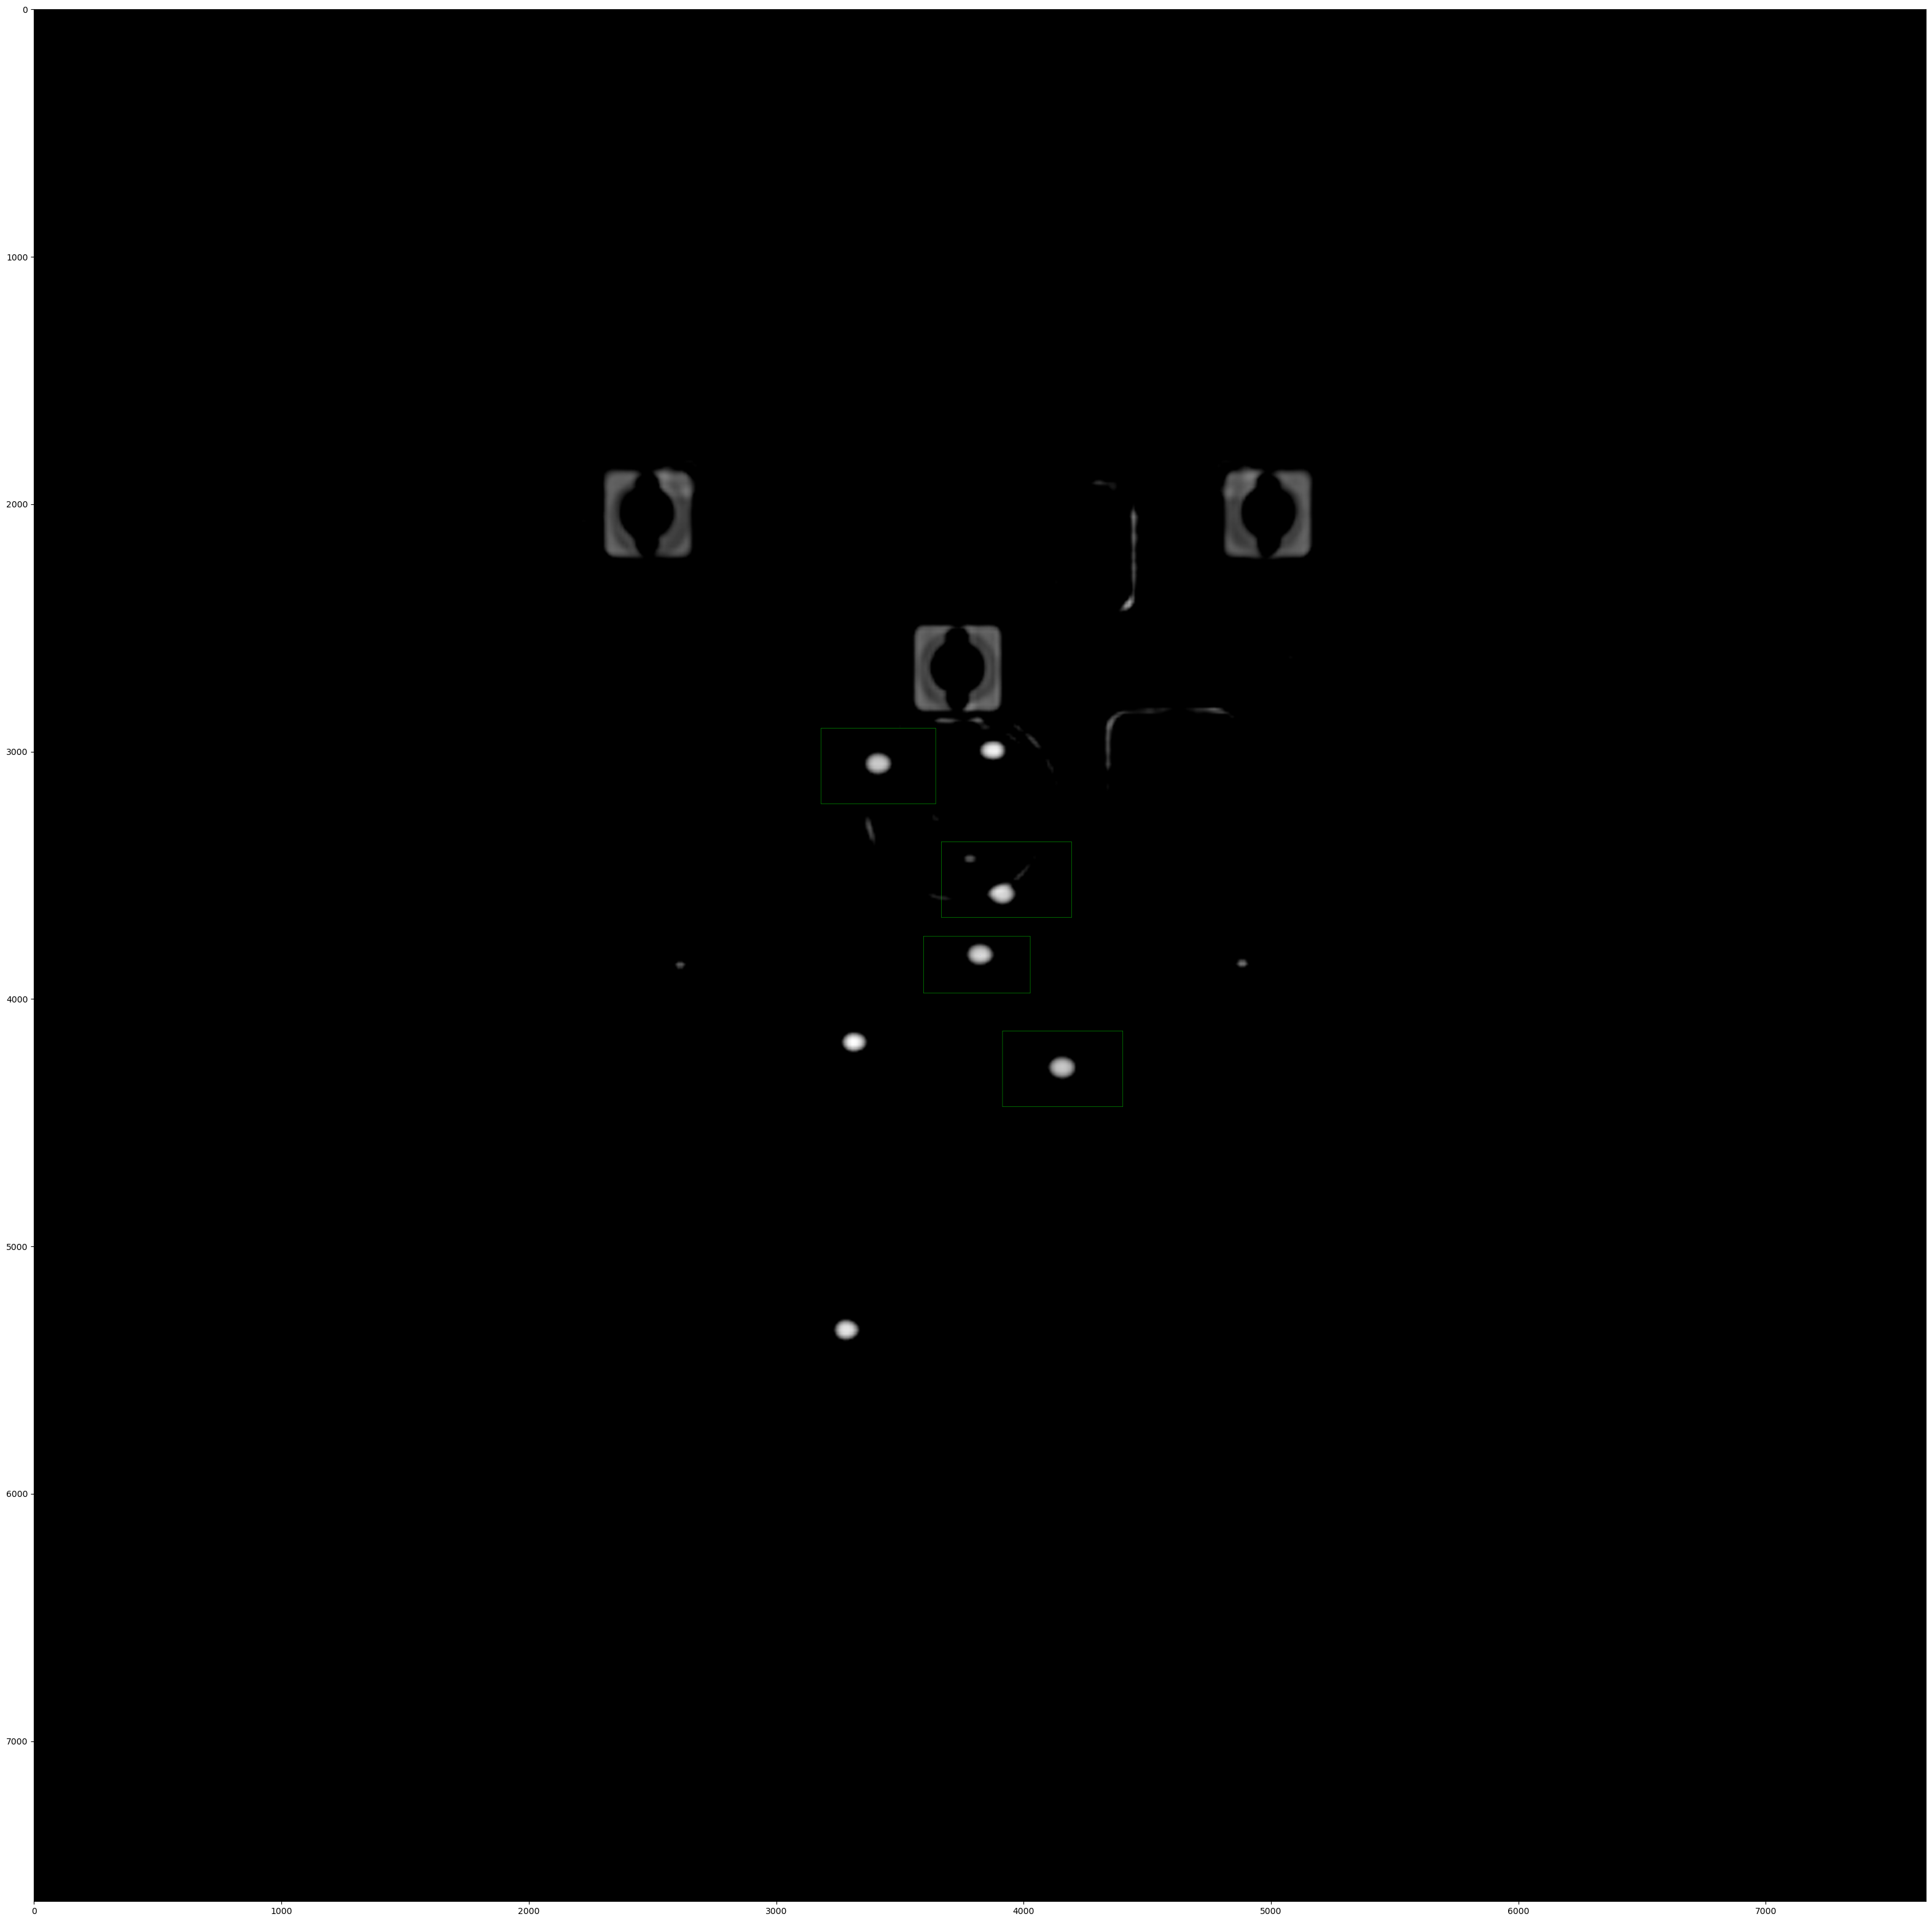

MLC_windowed\Interpol_RI_C1_ANT_MLC.tiff

MLC_windowed\Interpol_RI_C1_LAT_D_MLC.tiff



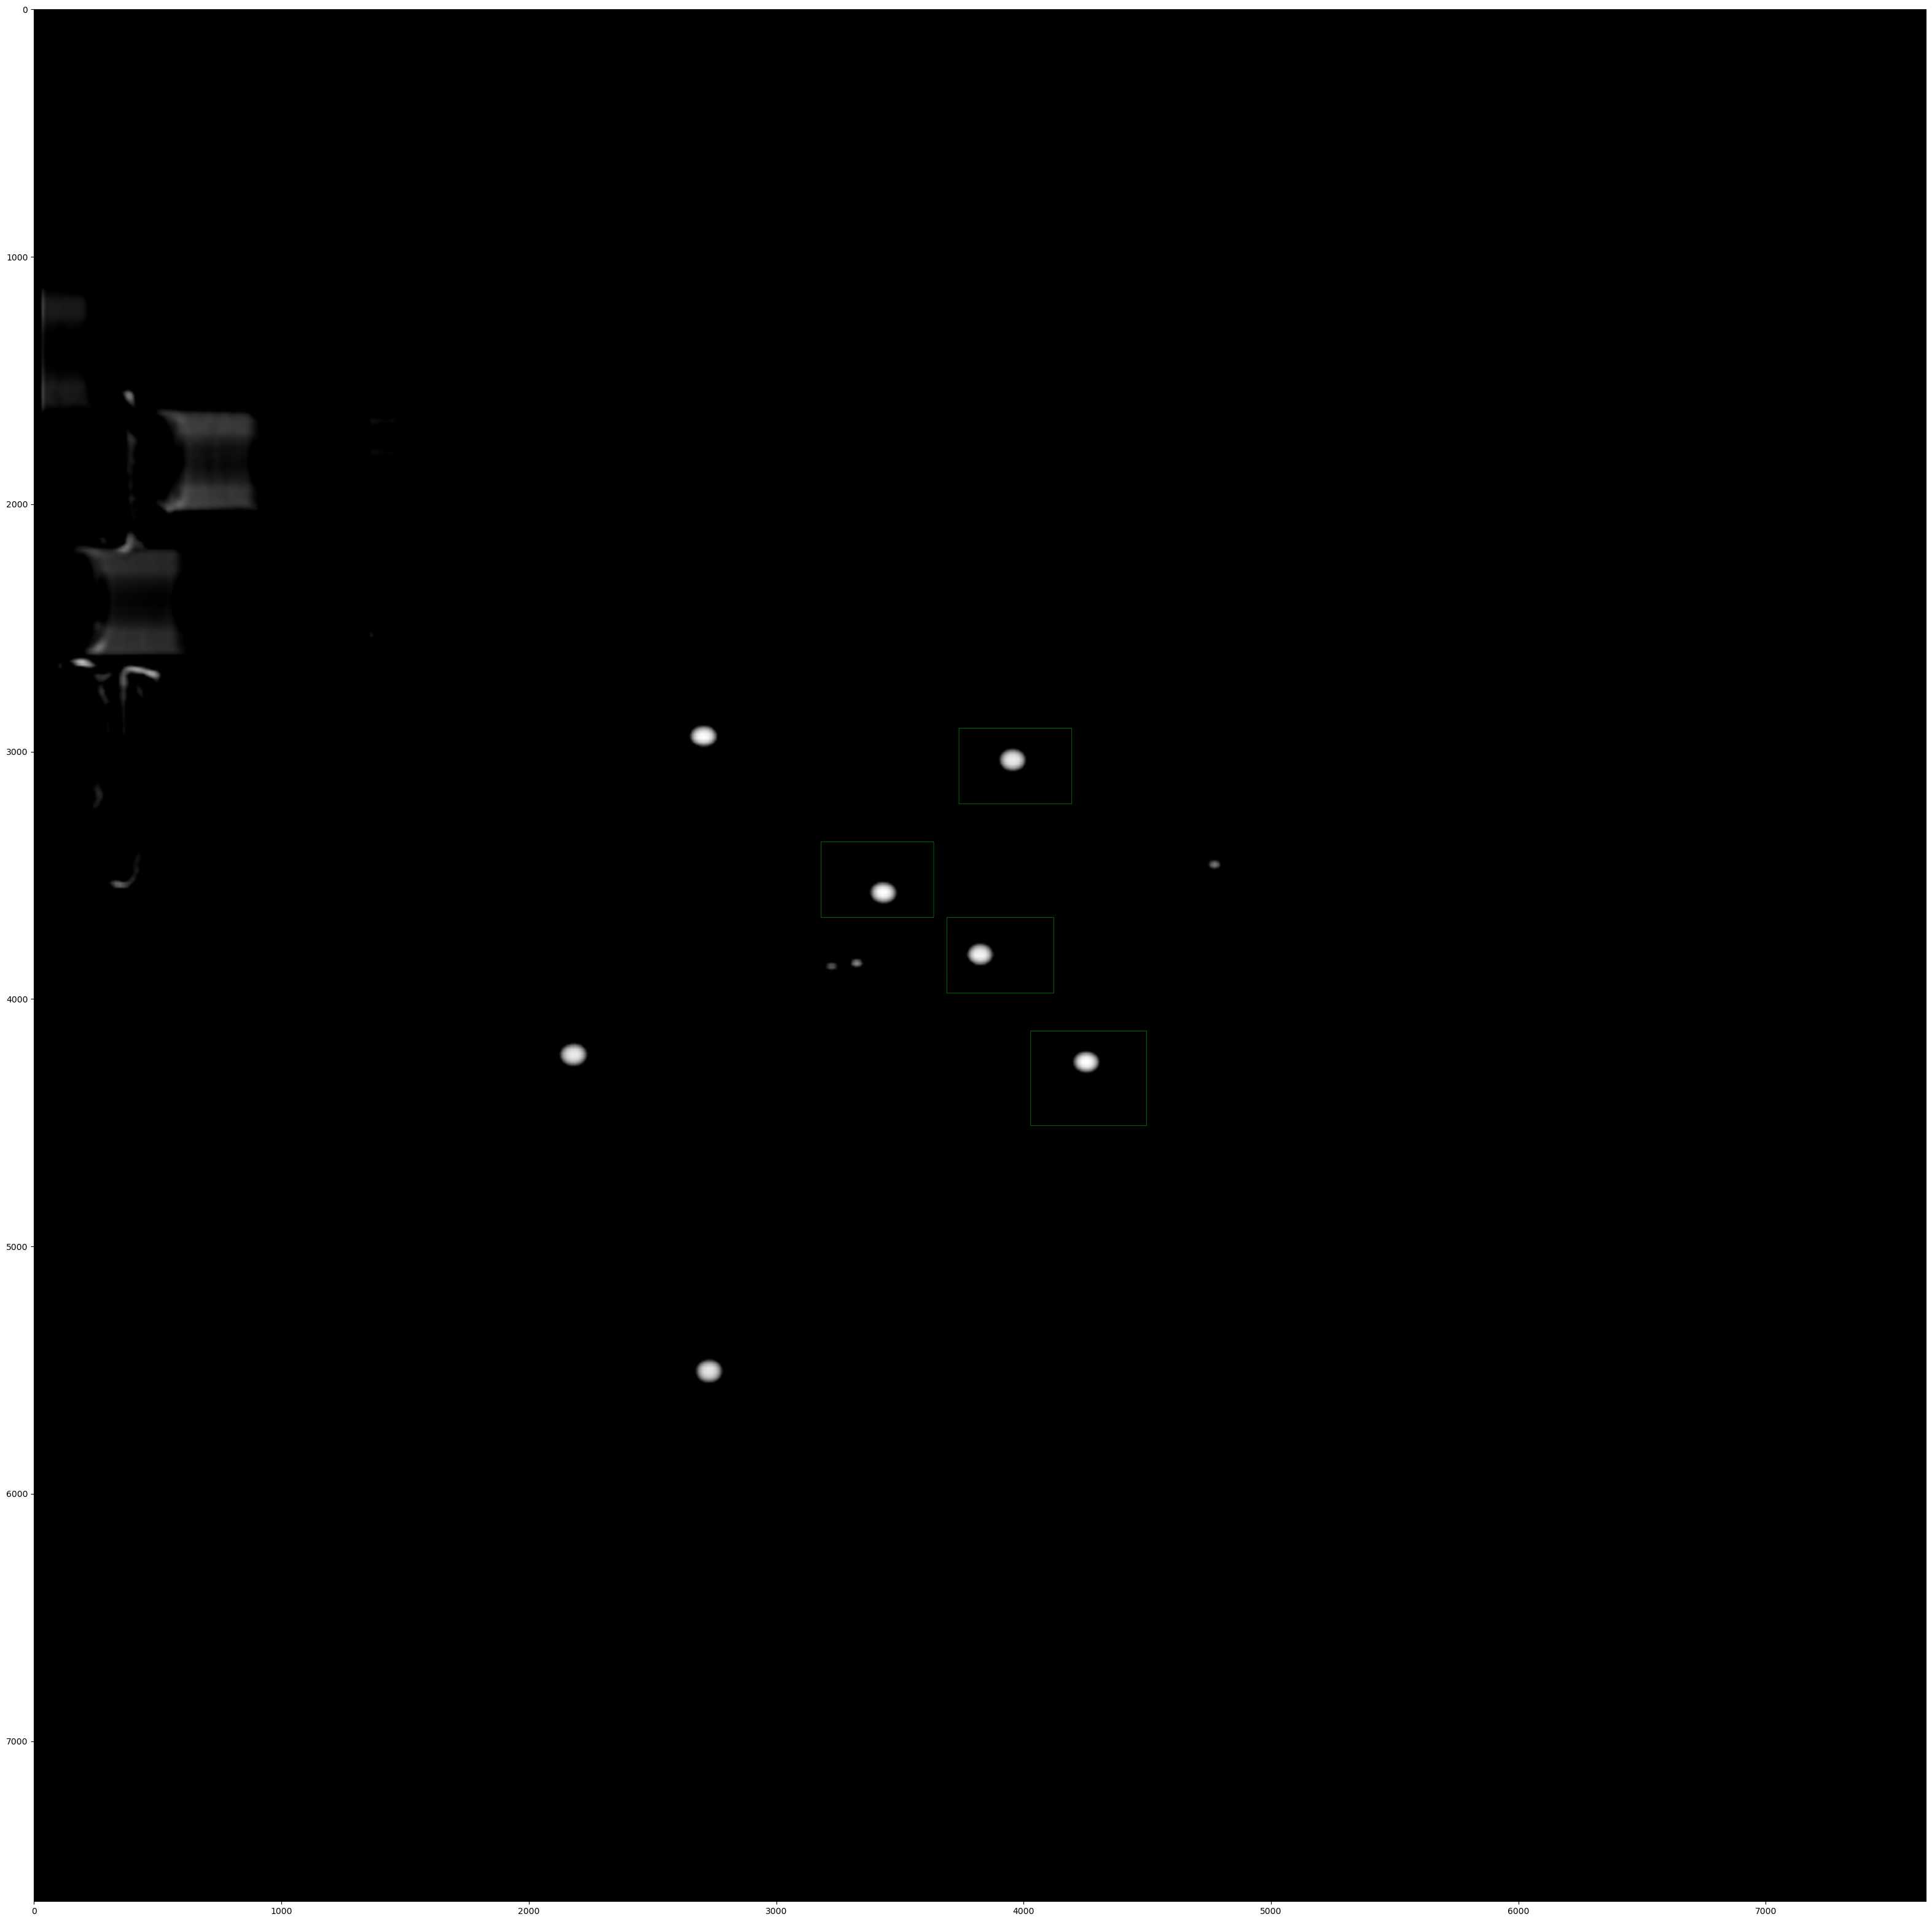

MLC_windowed\Interpol_RI_C1_ANT_MLC.tiff

MLC_windowed\Interpol_RI_C1_LAT_D_MLC.tiff

MLC_windowed\Interpol_RI_C1_LAT_G_MLC.tiff

MLC_windowed\Interpol_RI_C1_POST_MLC.tiff



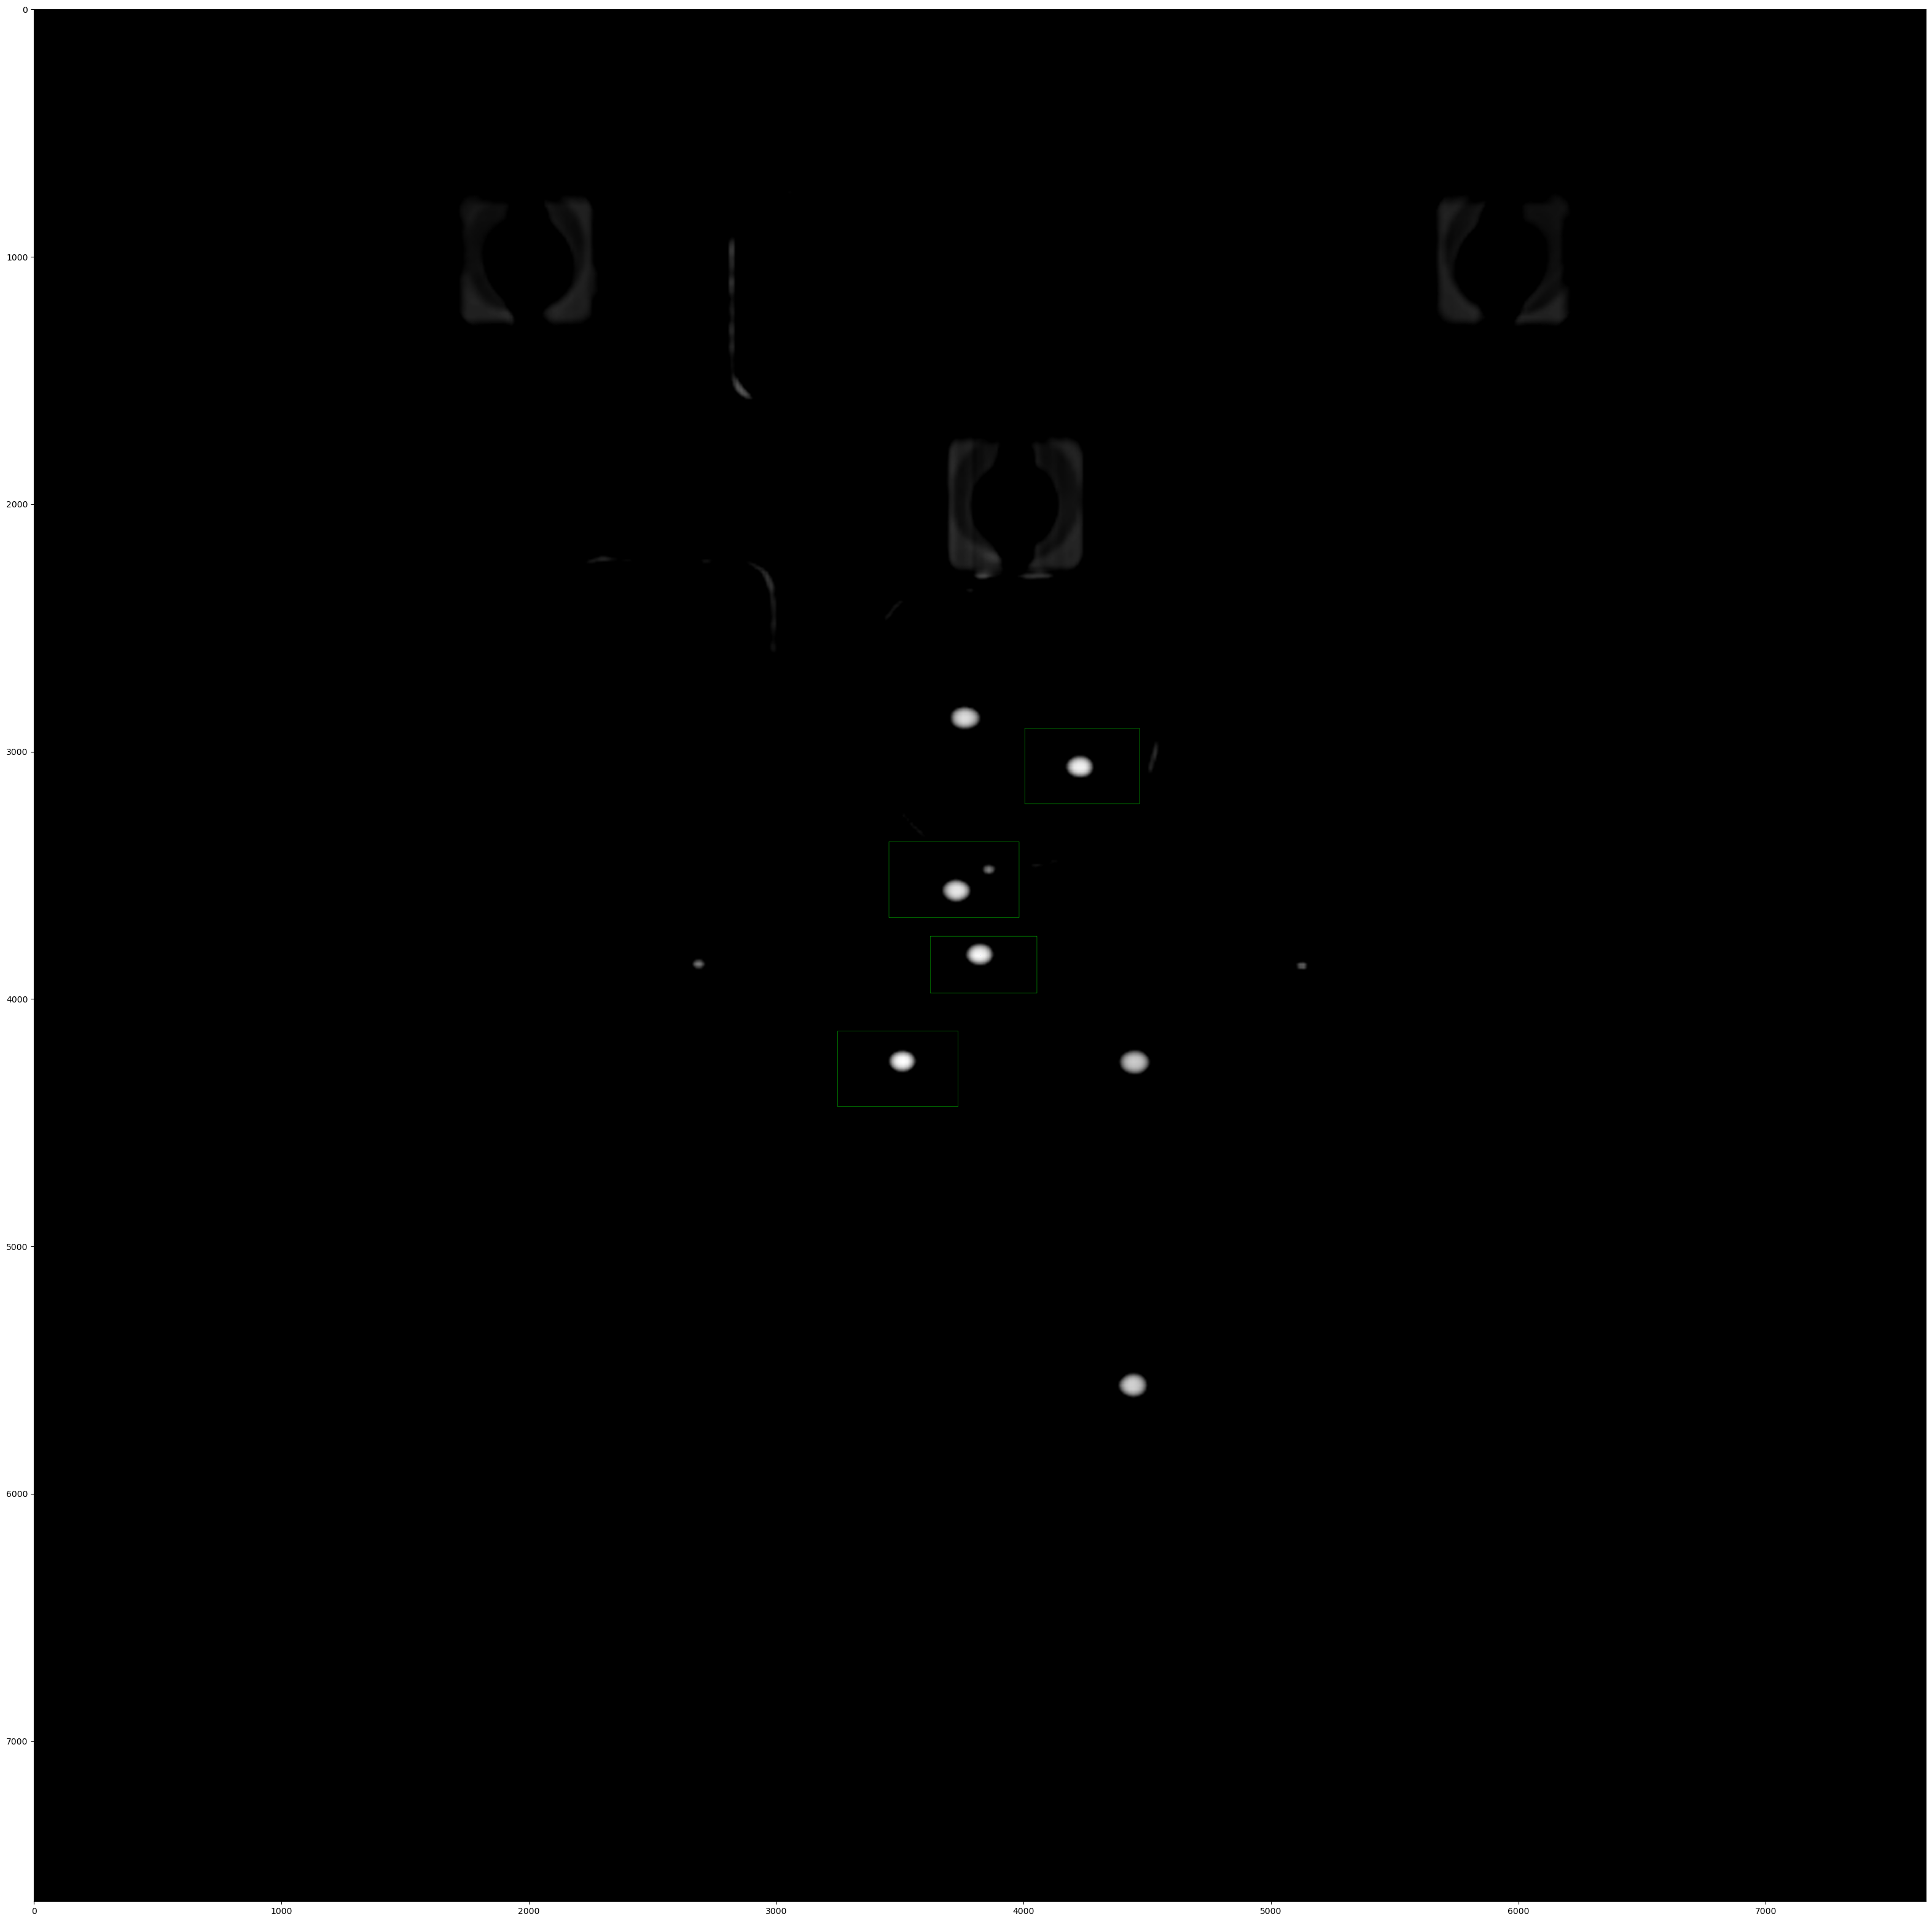

MLC_windowed\Interpol_RI_C1_ANT_MLC.tiff

MLC_windowed\Interpol_RI_C1_LAT_D_MLC.tiff

MLC_windowed\Interpol_RI_C1_LAT_G_MLC.tiff



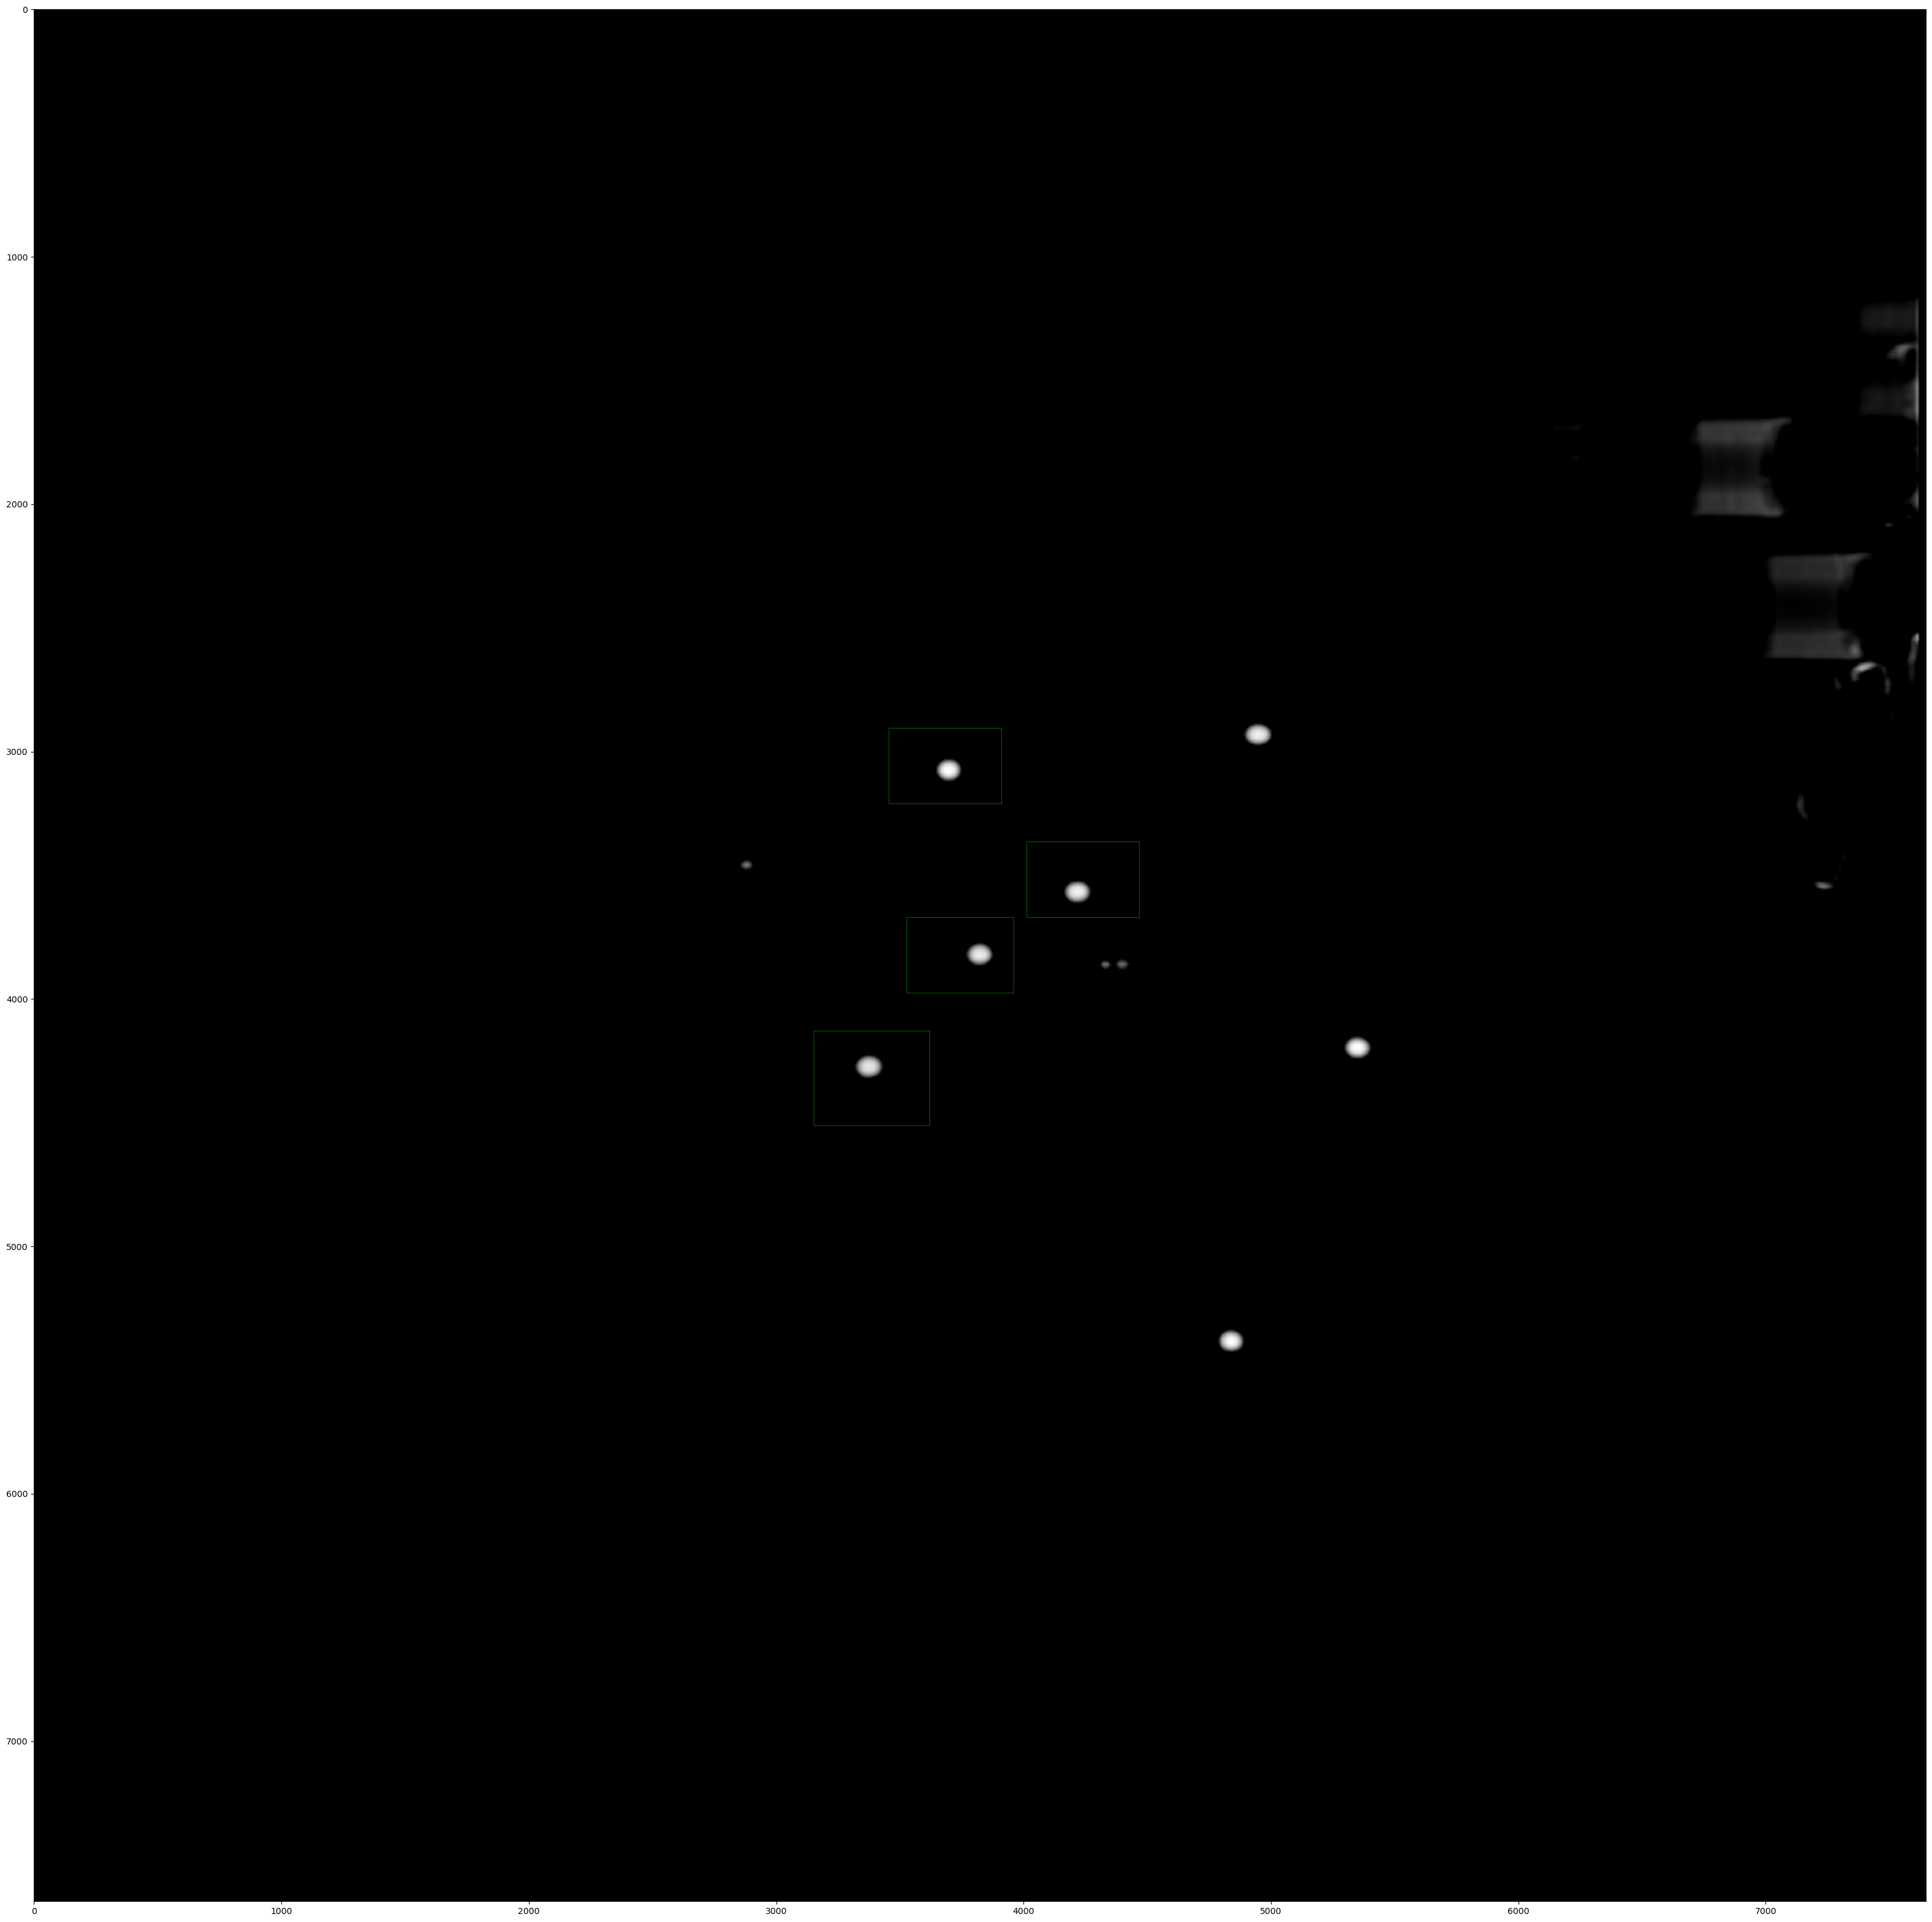

In [133]:
##### Draw a rectangle of black color of thickness -1 px
new_names_list = []
for image_name in names_list:
    new_name = image_name.replace(' ', '_')
    new_names_list.append(new_name)

for new_coordinates_singular, image_name in zip(new_coordinates_arr, new_names_list):
    for name in drr_images_interpol_windowed_names:
        temp_compare = name.replace('DRR','MLC')
        
        print(temp_compare + '\n')
        
        if(image_name[0:8] in temp_compare):
            immagine_da_leggere = name
            break
    
    upscaled_image = cv2.imread(immagine_da_leggere)
    upscaled_image_copy = upscaled_image.copy()

    upscaled_image_copy_bgr = cv2.cvtColor(upscaled_image_copy, cv2.COLOR_BGR2RGB)

    for new_coordinates in new_coordinates_singular:
        upscaled_image_copy_bgr = cv2.line(upscaled_image_copy_bgr, (round(new_coordinates[0][0]), round(new_coordinates[0][1])), (round(new_coordinates[1][0]), round(new_coordinates[1][1])), (0, 255, 0), 1)
        upscaled_image_copy_bgr = cv2.line(upscaled_image_copy_bgr, (round(new_coordinates[1][0]), round(new_coordinates[1][1])), (round(new_coordinates[2][0]), round(new_coordinates[2][1])), (0, 255, 0), 1)
        upscaled_image_copy_bgr = cv2.line(upscaled_image_copy_bgr, (round(new_coordinates[2][0]), round(new_coordinates[2][1])), (round(new_coordinates[3][0]), round(new_coordinates[3][1])), (0, 255, 0), 1)
        upscaled_image_copy_bgr = cv2.line(upscaled_image_copy_bgr, (round(new_coordinates[3][0]), round(new_coordinates[3][1])), (round(new_coordinates[0][0]), round(new_coordinates[0][1])), (0, 255, 0), 1)
        upscaled_image_copy_bgr = cv2.circle(upscaled_image_copy_bgr, (round(x_center_MLC), round(y_center_MLC)), 0, (0, 0, 255), -1)

    plt.figure(figsize=(50,40))
    plt.imshow(upscaled_image_copy_bgr)
    plt.show()

In [136]:
temp_3_field = epid_images_names[3]
temp_2_field = epid_images_names[2]

epid_images_names[2] = temp_3_field
epid_images_names[3] = temp_2_field

In [137]:
elemento_0 = portal_images_batch[0]
elemento_1 = portal_images_batch[1]
elemento_2 = portal_images_batch[2]
elemento_3 = portal_images_batch[3]

In [138]:
nuova_lista = []
nuova_lista.append(elemento_0)
nuova_lista.append(elemento_1)
nuova_lista.append(elemento_3)
nuova_lista.append(elemento_2)

## EPID - Irradiation Field Detection

EPID_windowed/Superscaled_RI.C1 ANT.tiff
[INFO] Image:  EPID_windowed/Superscaled_RI.C1 ANT.tiff 
[INFO] Bicubic Interpolation Took 0.015339 seconds


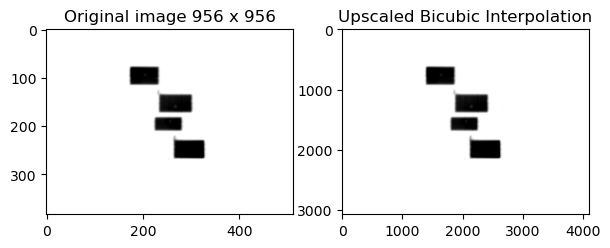

EPID_windowed/Superscaled_RI.C1 LAT D.tiff
[INFO] Image:  EPID_windowed/Superscaled_RI.C1 LAT D.tiff 
[INFO] Bicubic Interpolation Took 0.007024 seconds


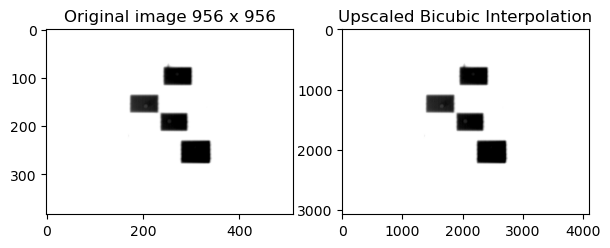

EPID_windowed/Superscaled_RI.C1 LAT G.tiff
[INFO] Image:  EPID_windowed/Superscaled_RI.C1 LAT G.tiff 
[INFO] Bicubic Interpolation Took 0.015628 seconds


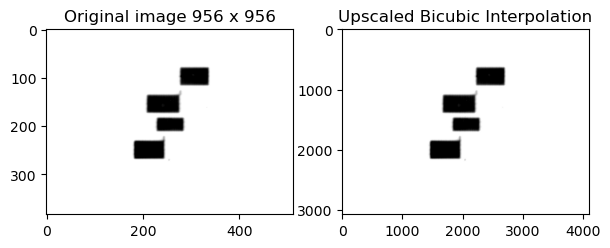

EPID_windowed/Superscaled_RI.C1 POST.tiff
[INFO] Image:  EPID_windowed/Superscaled_RI.C1 POST.tiff 
[INFO] Bicubic Interpolation Took 0.001580 seconds


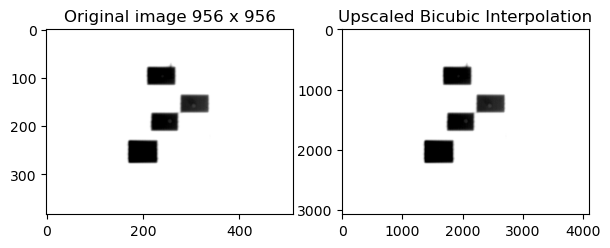

In [140]:
for i, name in zip(range(len(epid_dicom_batch)), epid_images_names):
    name = 'EPID_windowed/Superscaled_' + name.replace('.dcm', '.tiff')
    print(name)
    super_res_lapsrn(nuova_lista[i], name)

Thresholding Upscaled EPID FWHM

EPID_windowed/Superscaled_RI.C1 ANT.tiff


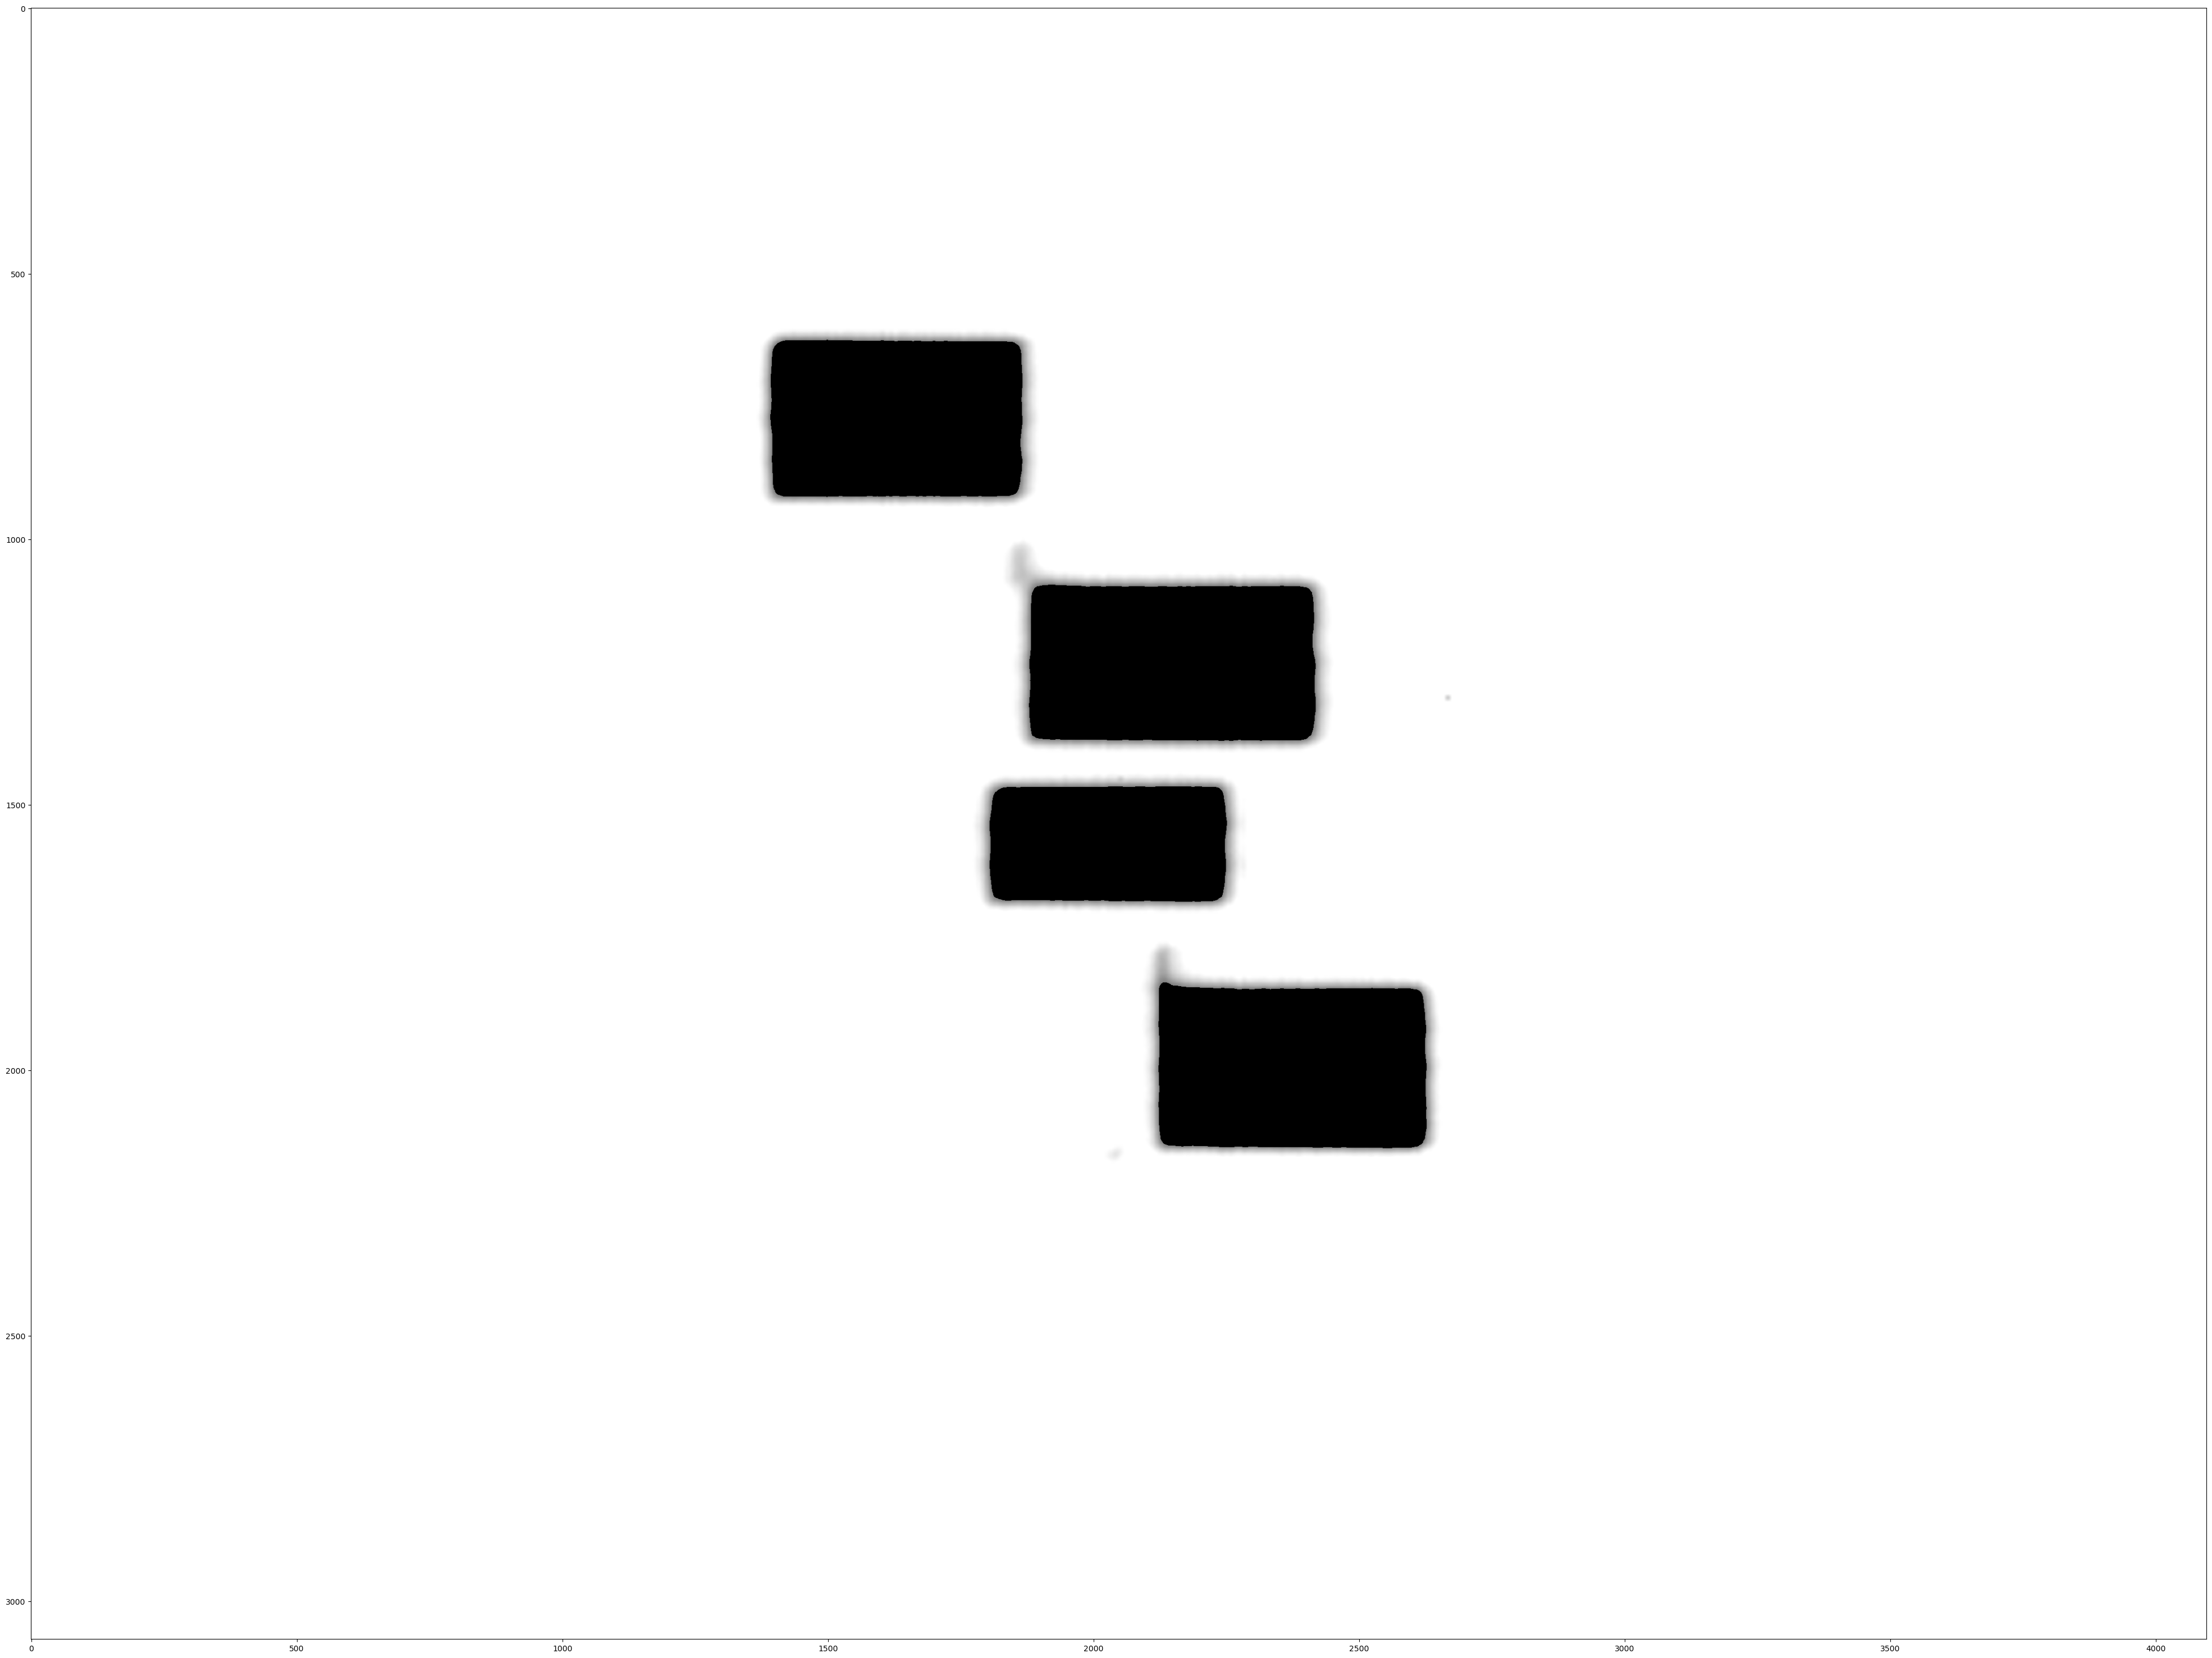

EPID_windowed/Superscaled_RI.C1 LAT D.tiff


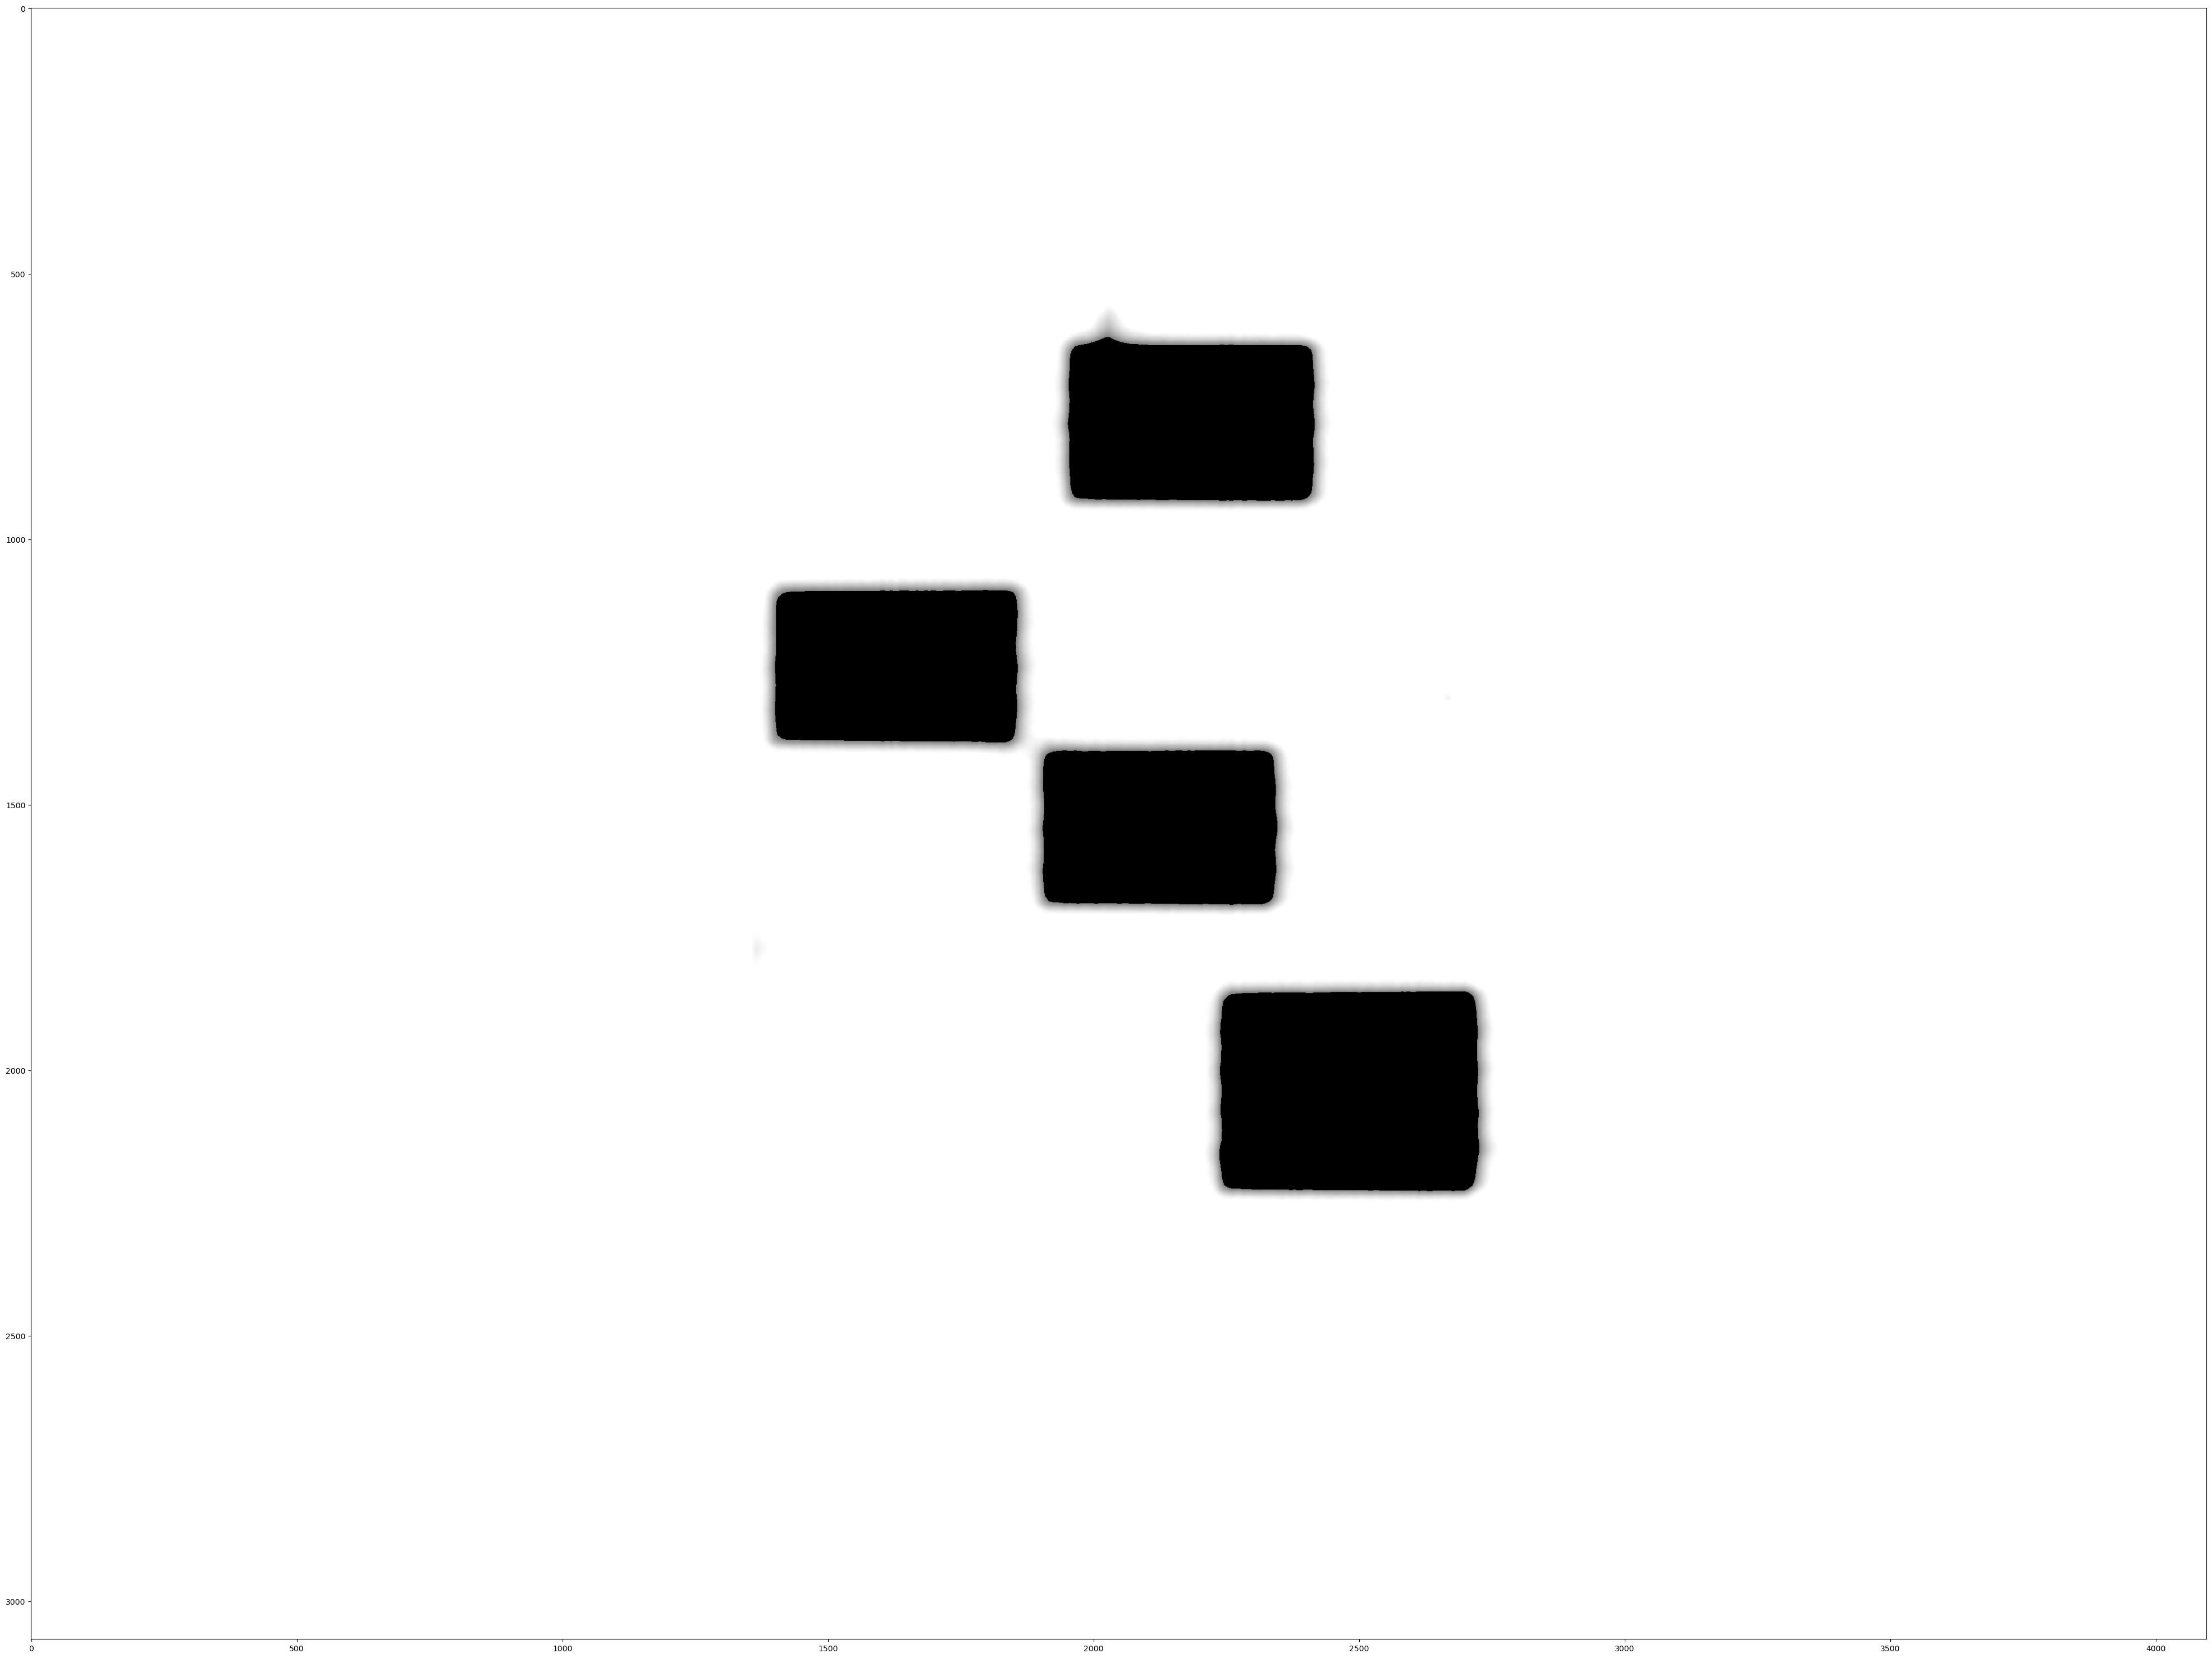

EPID_windowed/Superscaled_RI.C1 LAT G.tiff


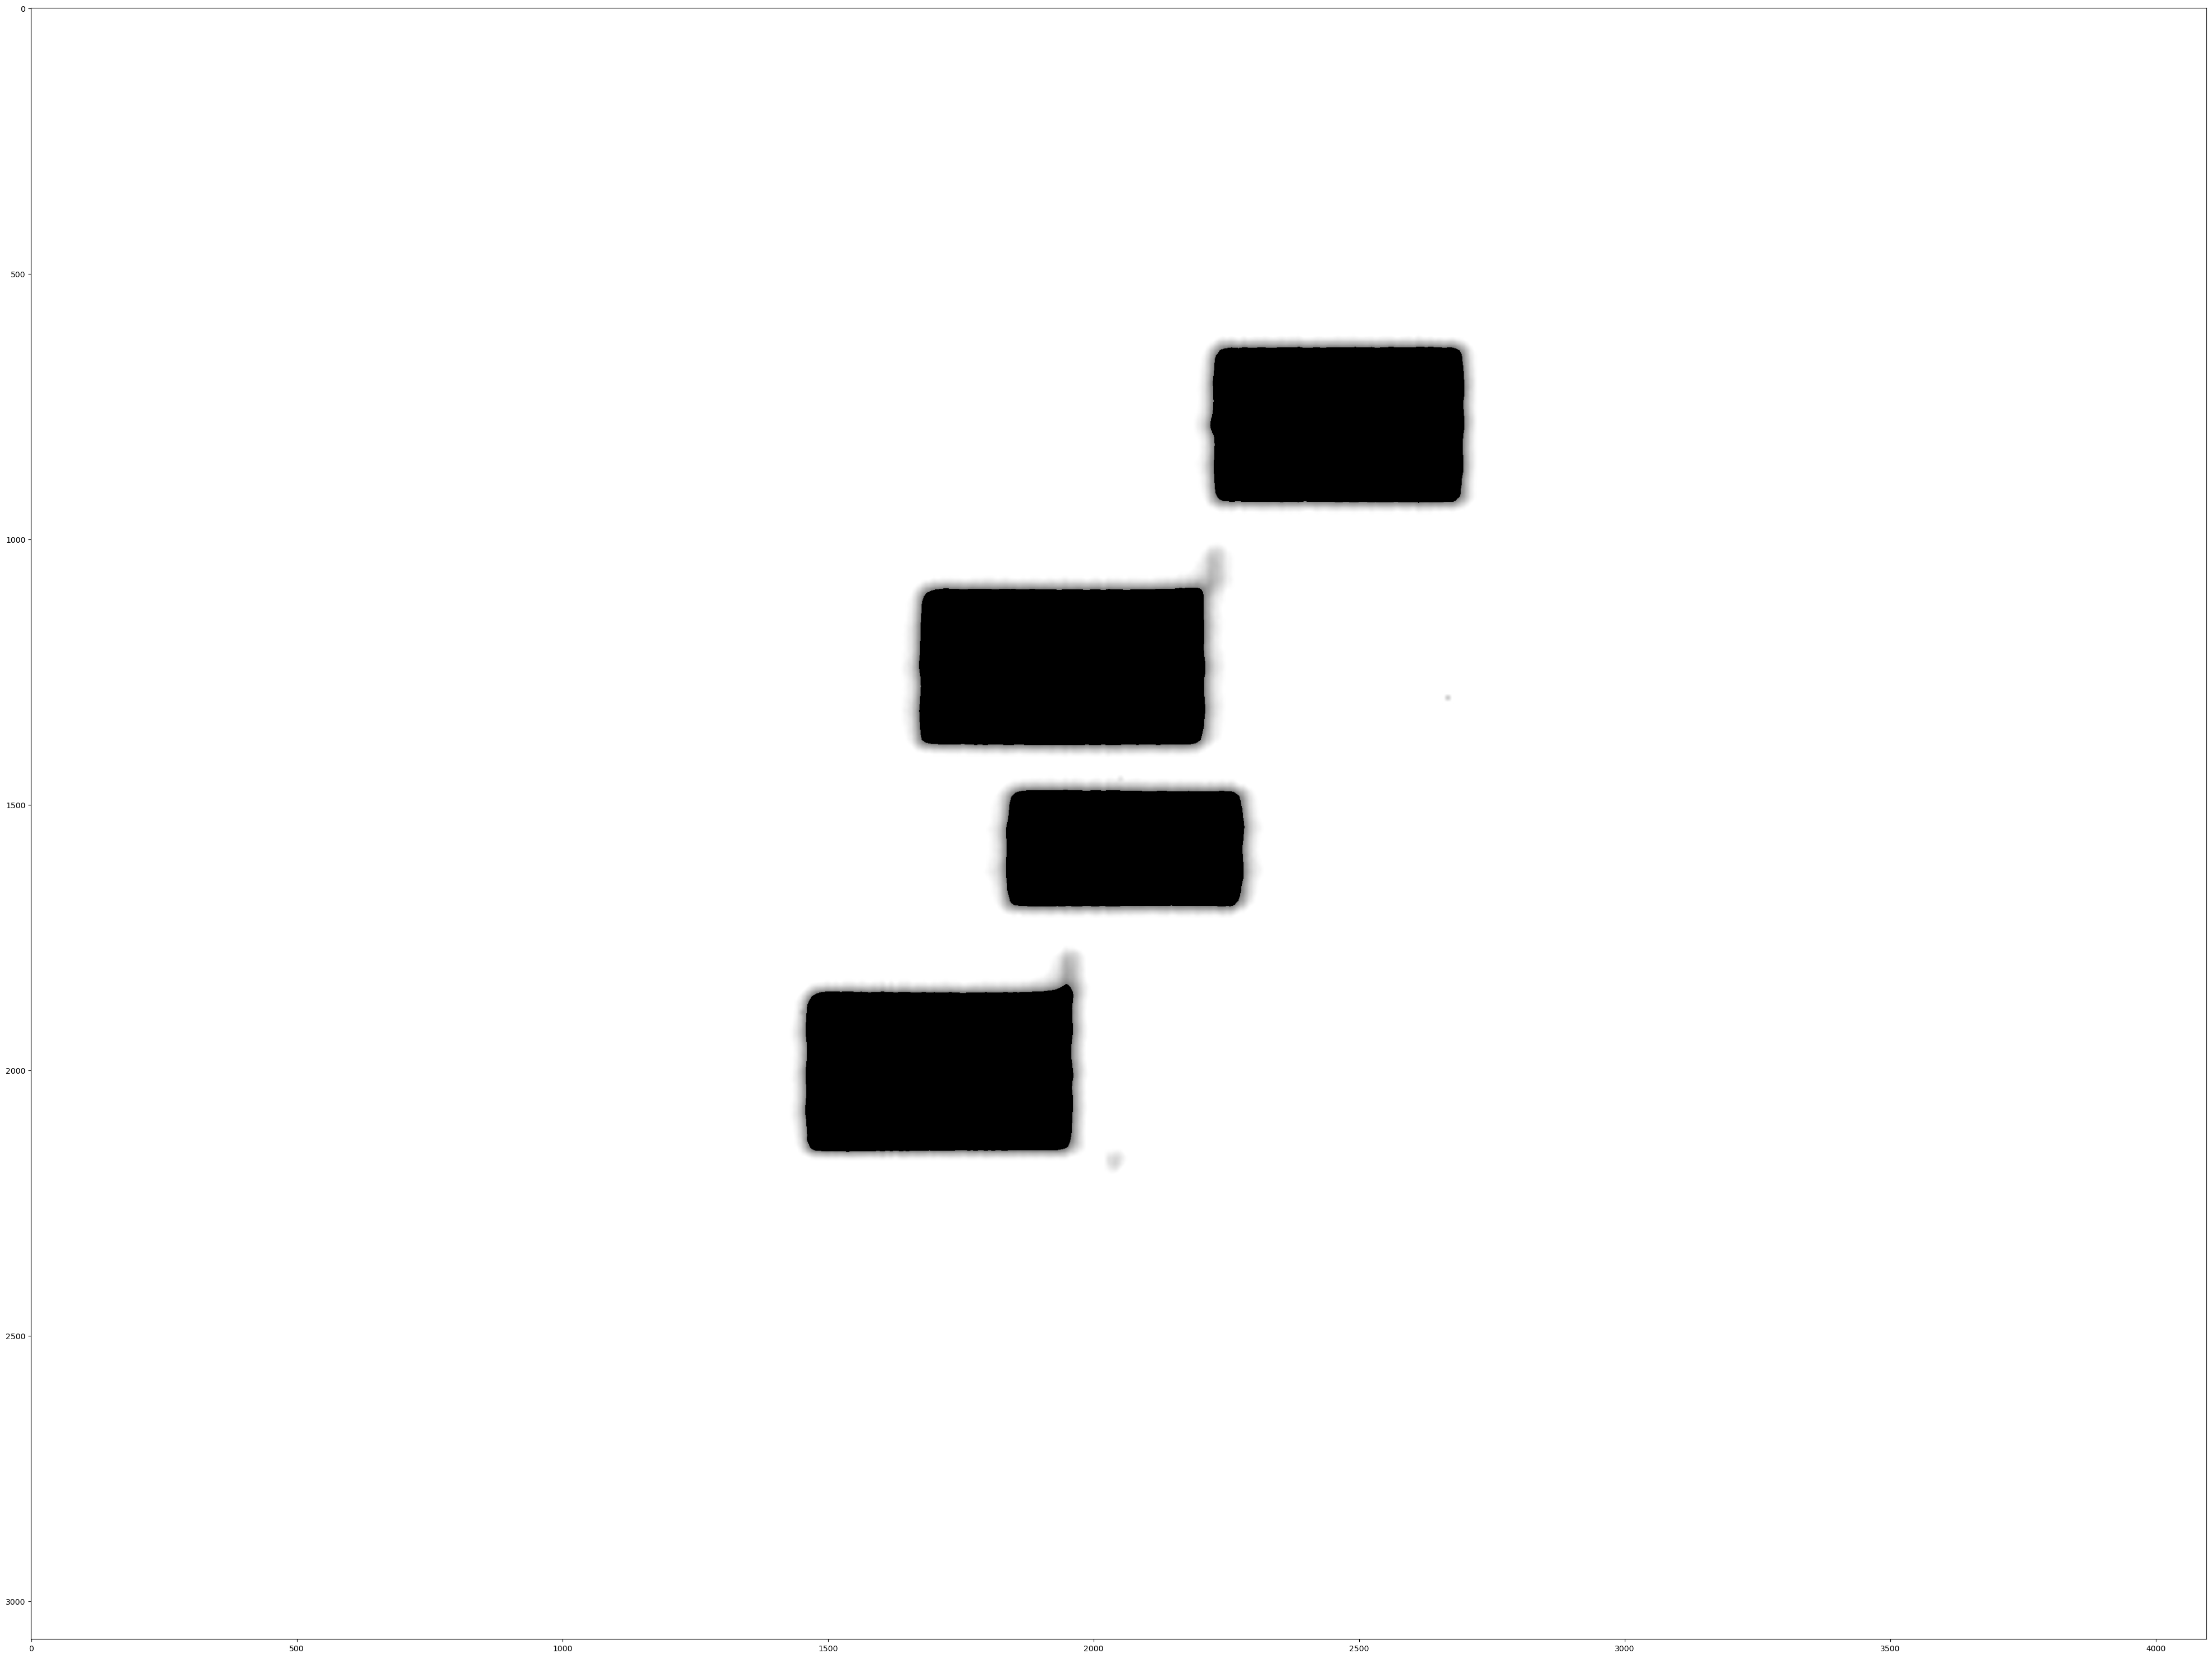

EPID_windowed/Superscaled_RI.C1 POST.tiff


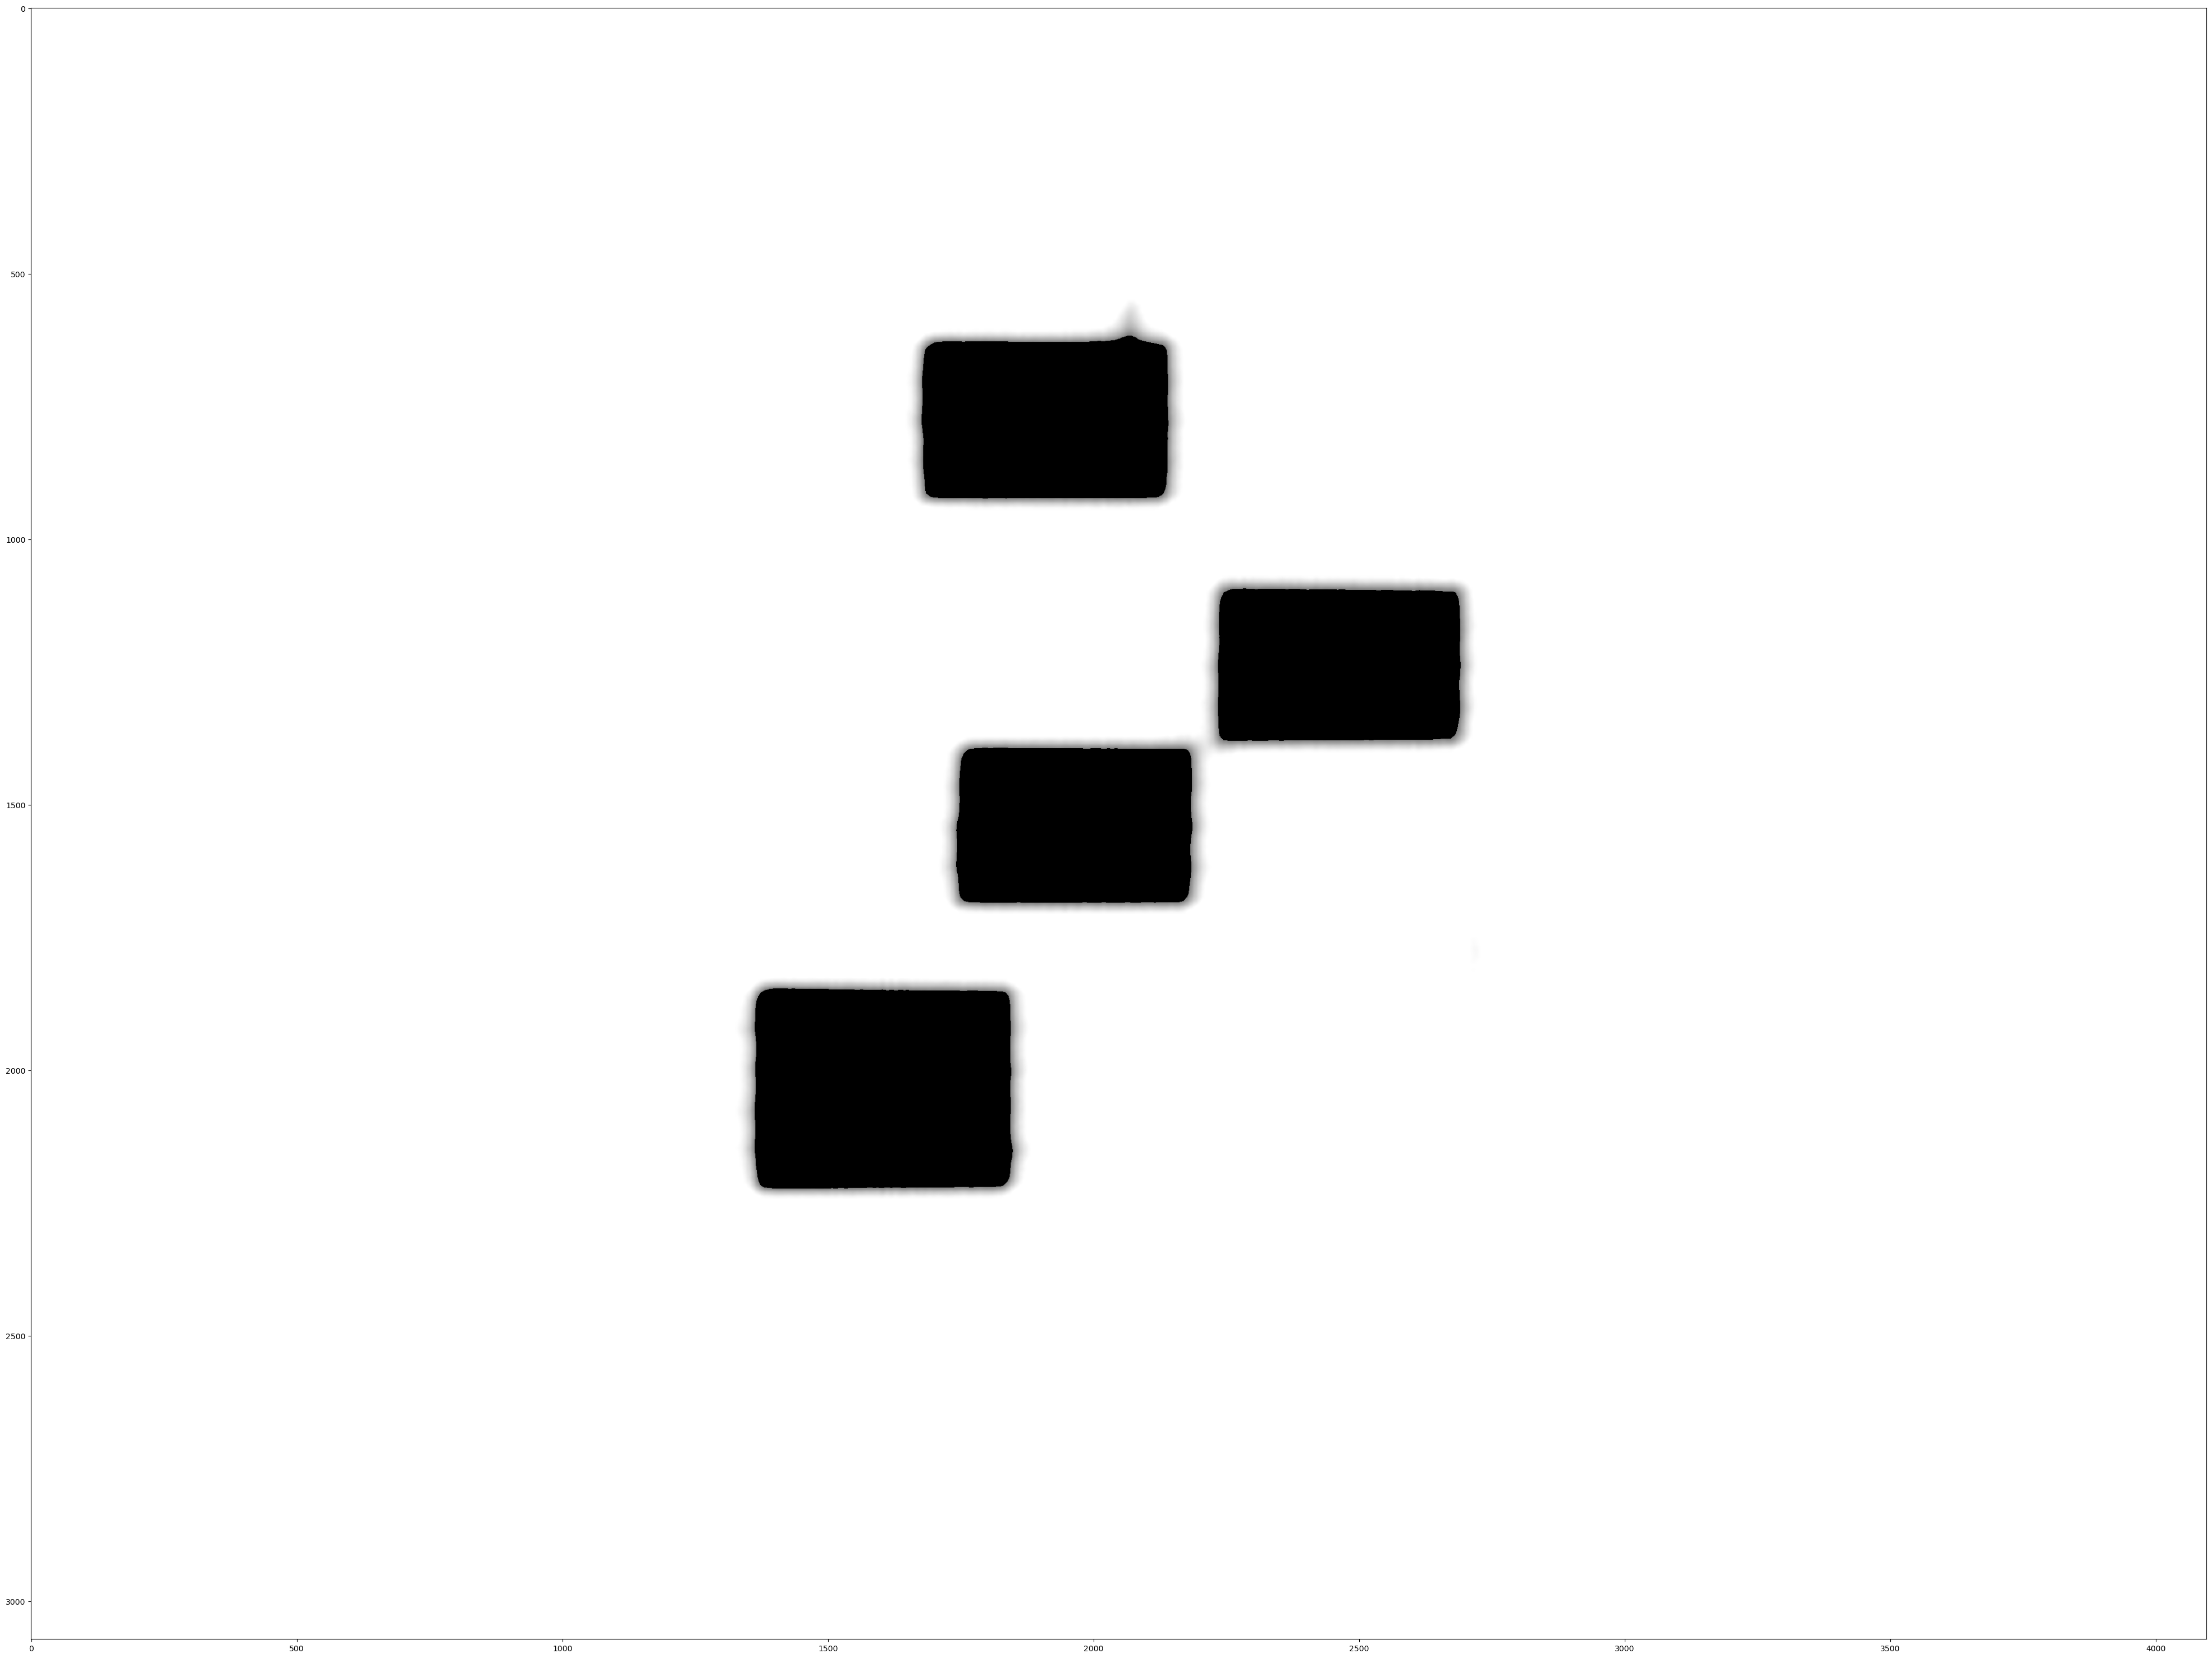

In [141]:
epid_images_thresholded = []

for name in epid_images_names:
    name = 'EPID_windowed/Superscaled_' + name.replace('.dcm', '.tiff')
    print(name)
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    thresh_value = ((np.max(image) - np.min(image) ) / 2)
    result = (image > thresh_value) * image

    epid_images_thresholded.append(result)
    
    plt.figure(figsize=(50,40))
    plt.imshow(result, cmap='gray')
    plt.show()

Leaving Only White and Black Colours


In [142]:
epid_images_thresholded_b_w = [] 

for i in range(0, len(epid_images_thresholded)):
    for k in range(0, epid_images_thresholded[i].shape[0]):
        for j in range(0, epid_images_thresholded[i].shape[1]):
            if(epid_images_thresholded[i][k][j]) != 0:
                epid_images_thresholded[i][k][j] = 255
            else:
                epid_images_thresholded[i][k][j] = 0
    epid_images_thresholded_b_w.append(epid_images_thresholded[i])
#     im = Image.fromarray(epid_imges_thresholded[i])

BOX:  [[2120 2144]
 [2122 1834]
 [2628 1838]
 [2626 2147]]
BOX:  [[1804 1466]
 [2251 1466]
 [2251 1683]
 [1804 1683]]
BOX:  [[1877 1378]
 [1879 1085]
 [2419 1088]
 [2417 1381]]
BOX:  [[1391  920]
 [1391  625]
 [1866  625]
 [1866  920]]


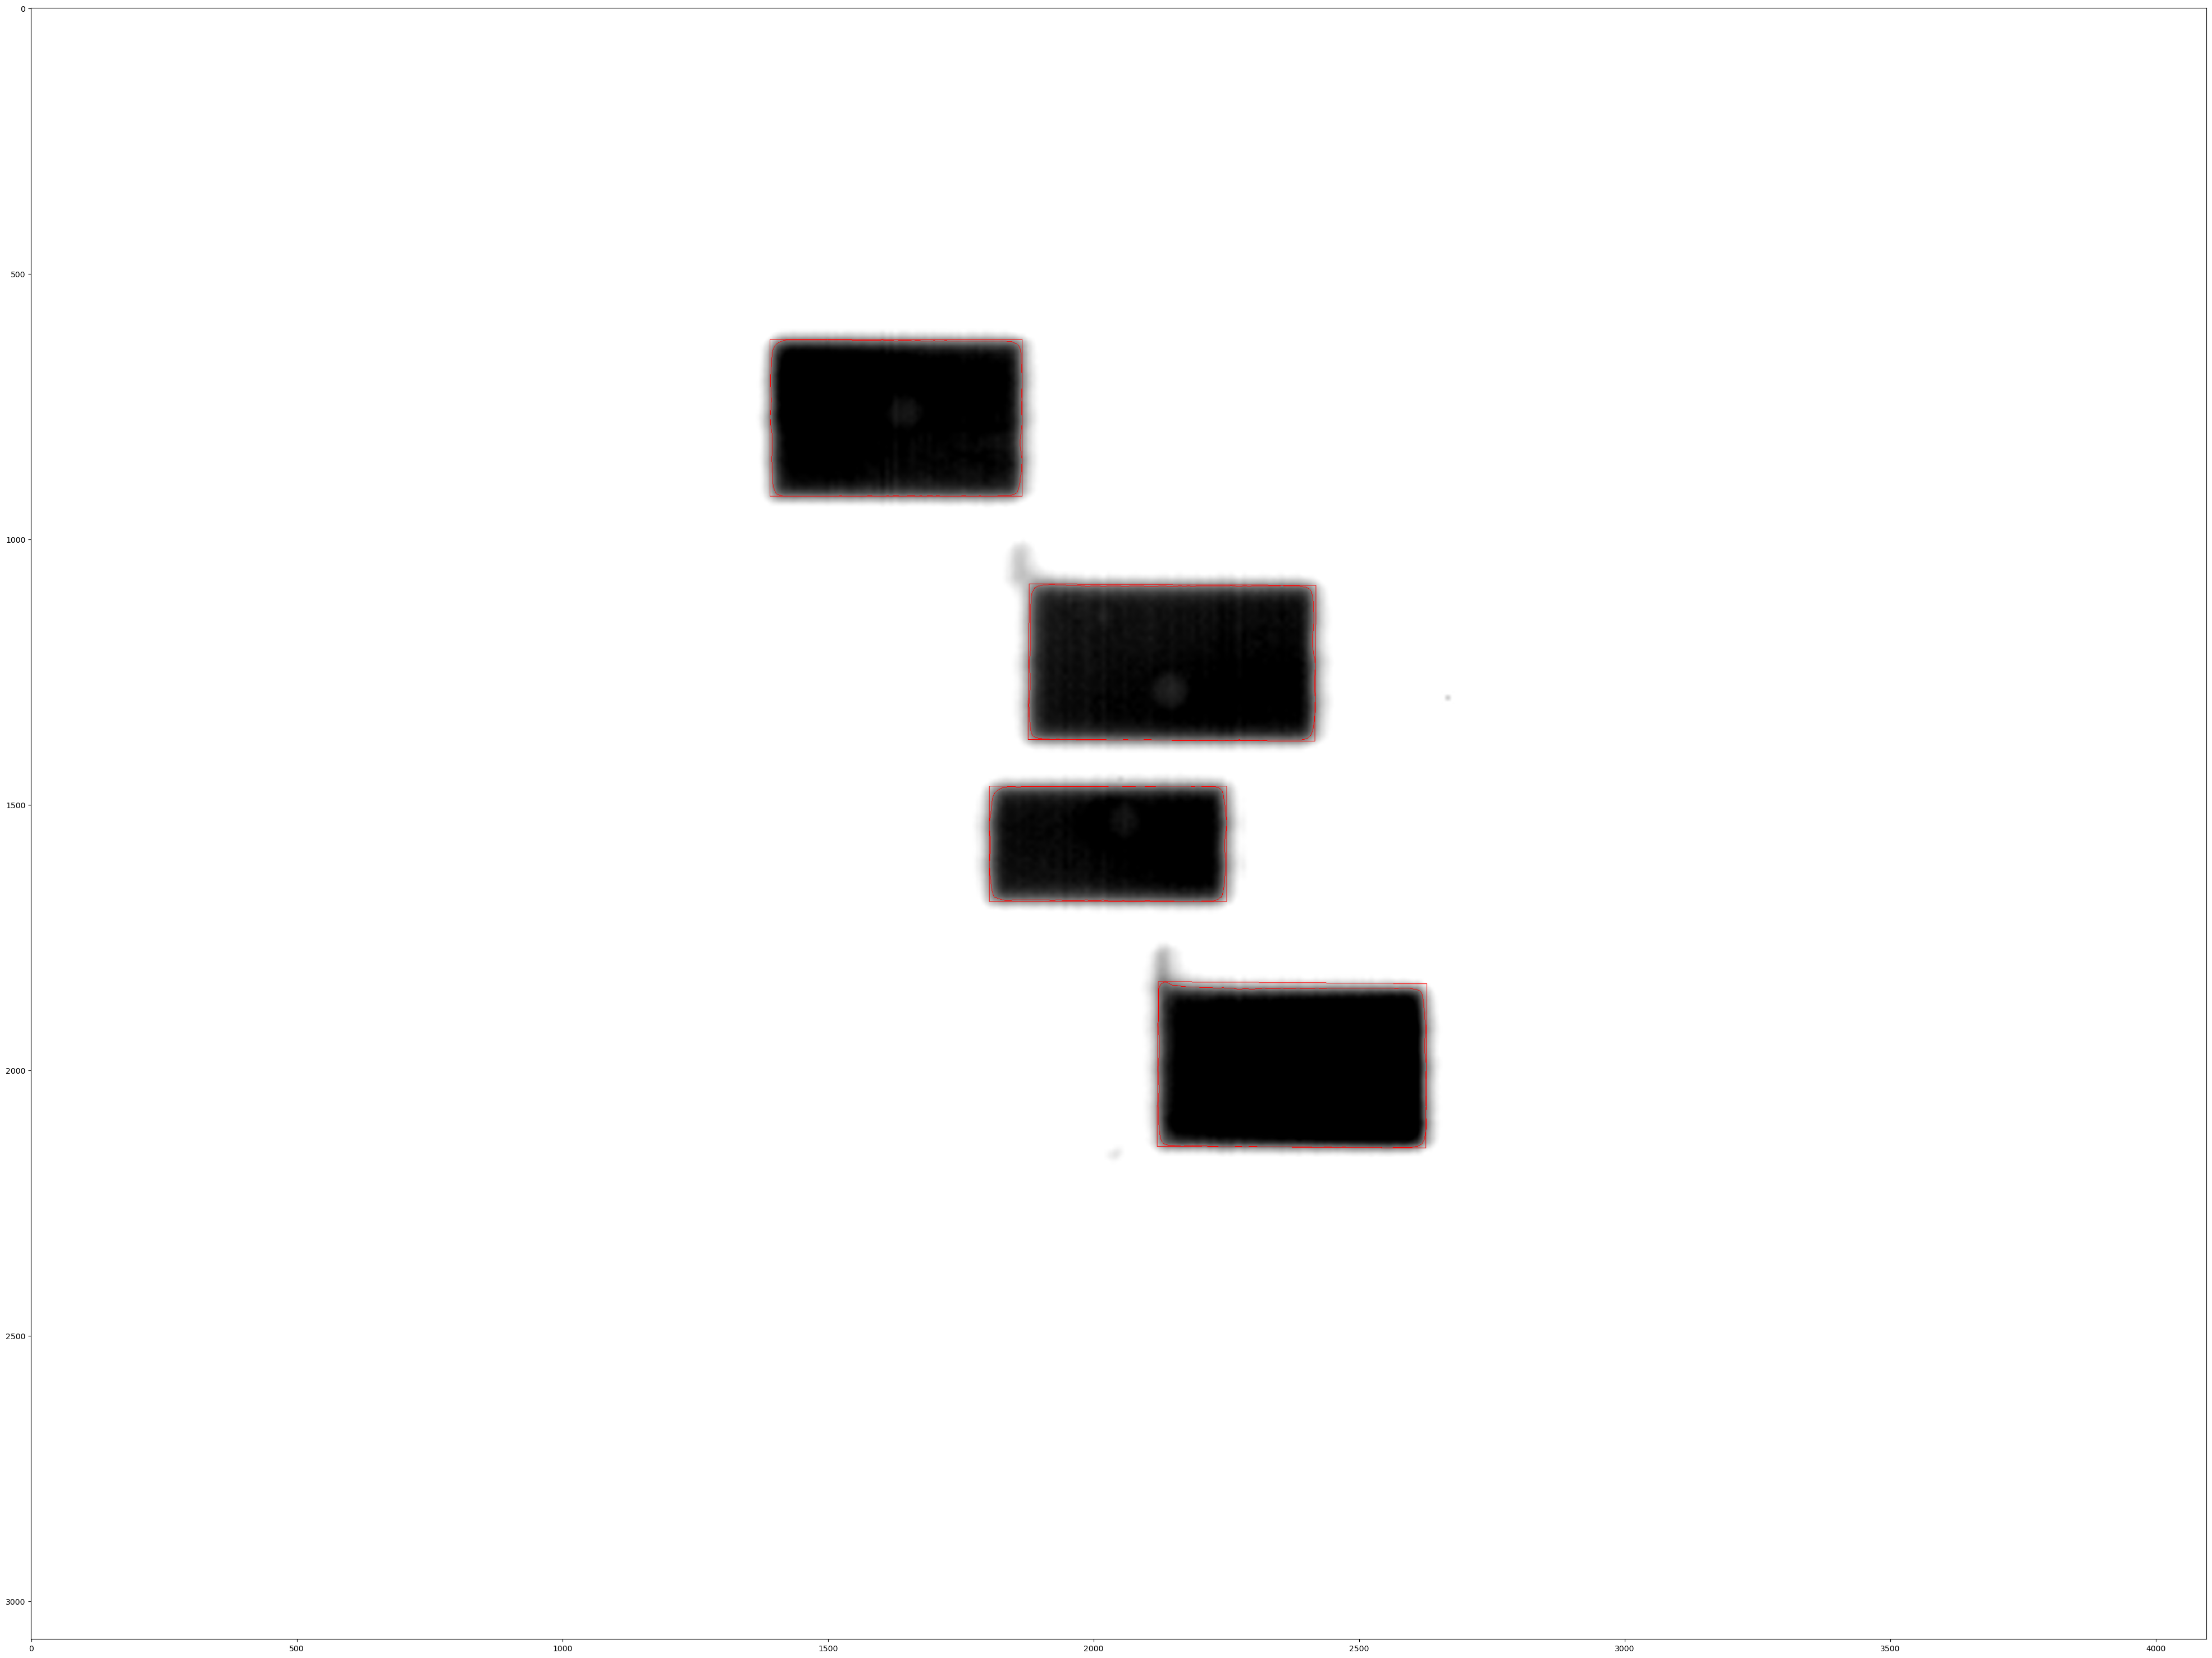

BOX:  [[2237 1852]
 [2726 1852]
 [2726 2228]
 [2237 2228]]
BOX:  [[1904 1398]
 [2346 1398]
 [2346 1689]
 [1904 1689]]
BOX:  [[1400 1096]
 [1857 1096]
 [1857 1383]
 [1400 1383]]
BOX:  [[1949  925]
 [1953  619]
 [2418  624]
 [2414  931]]


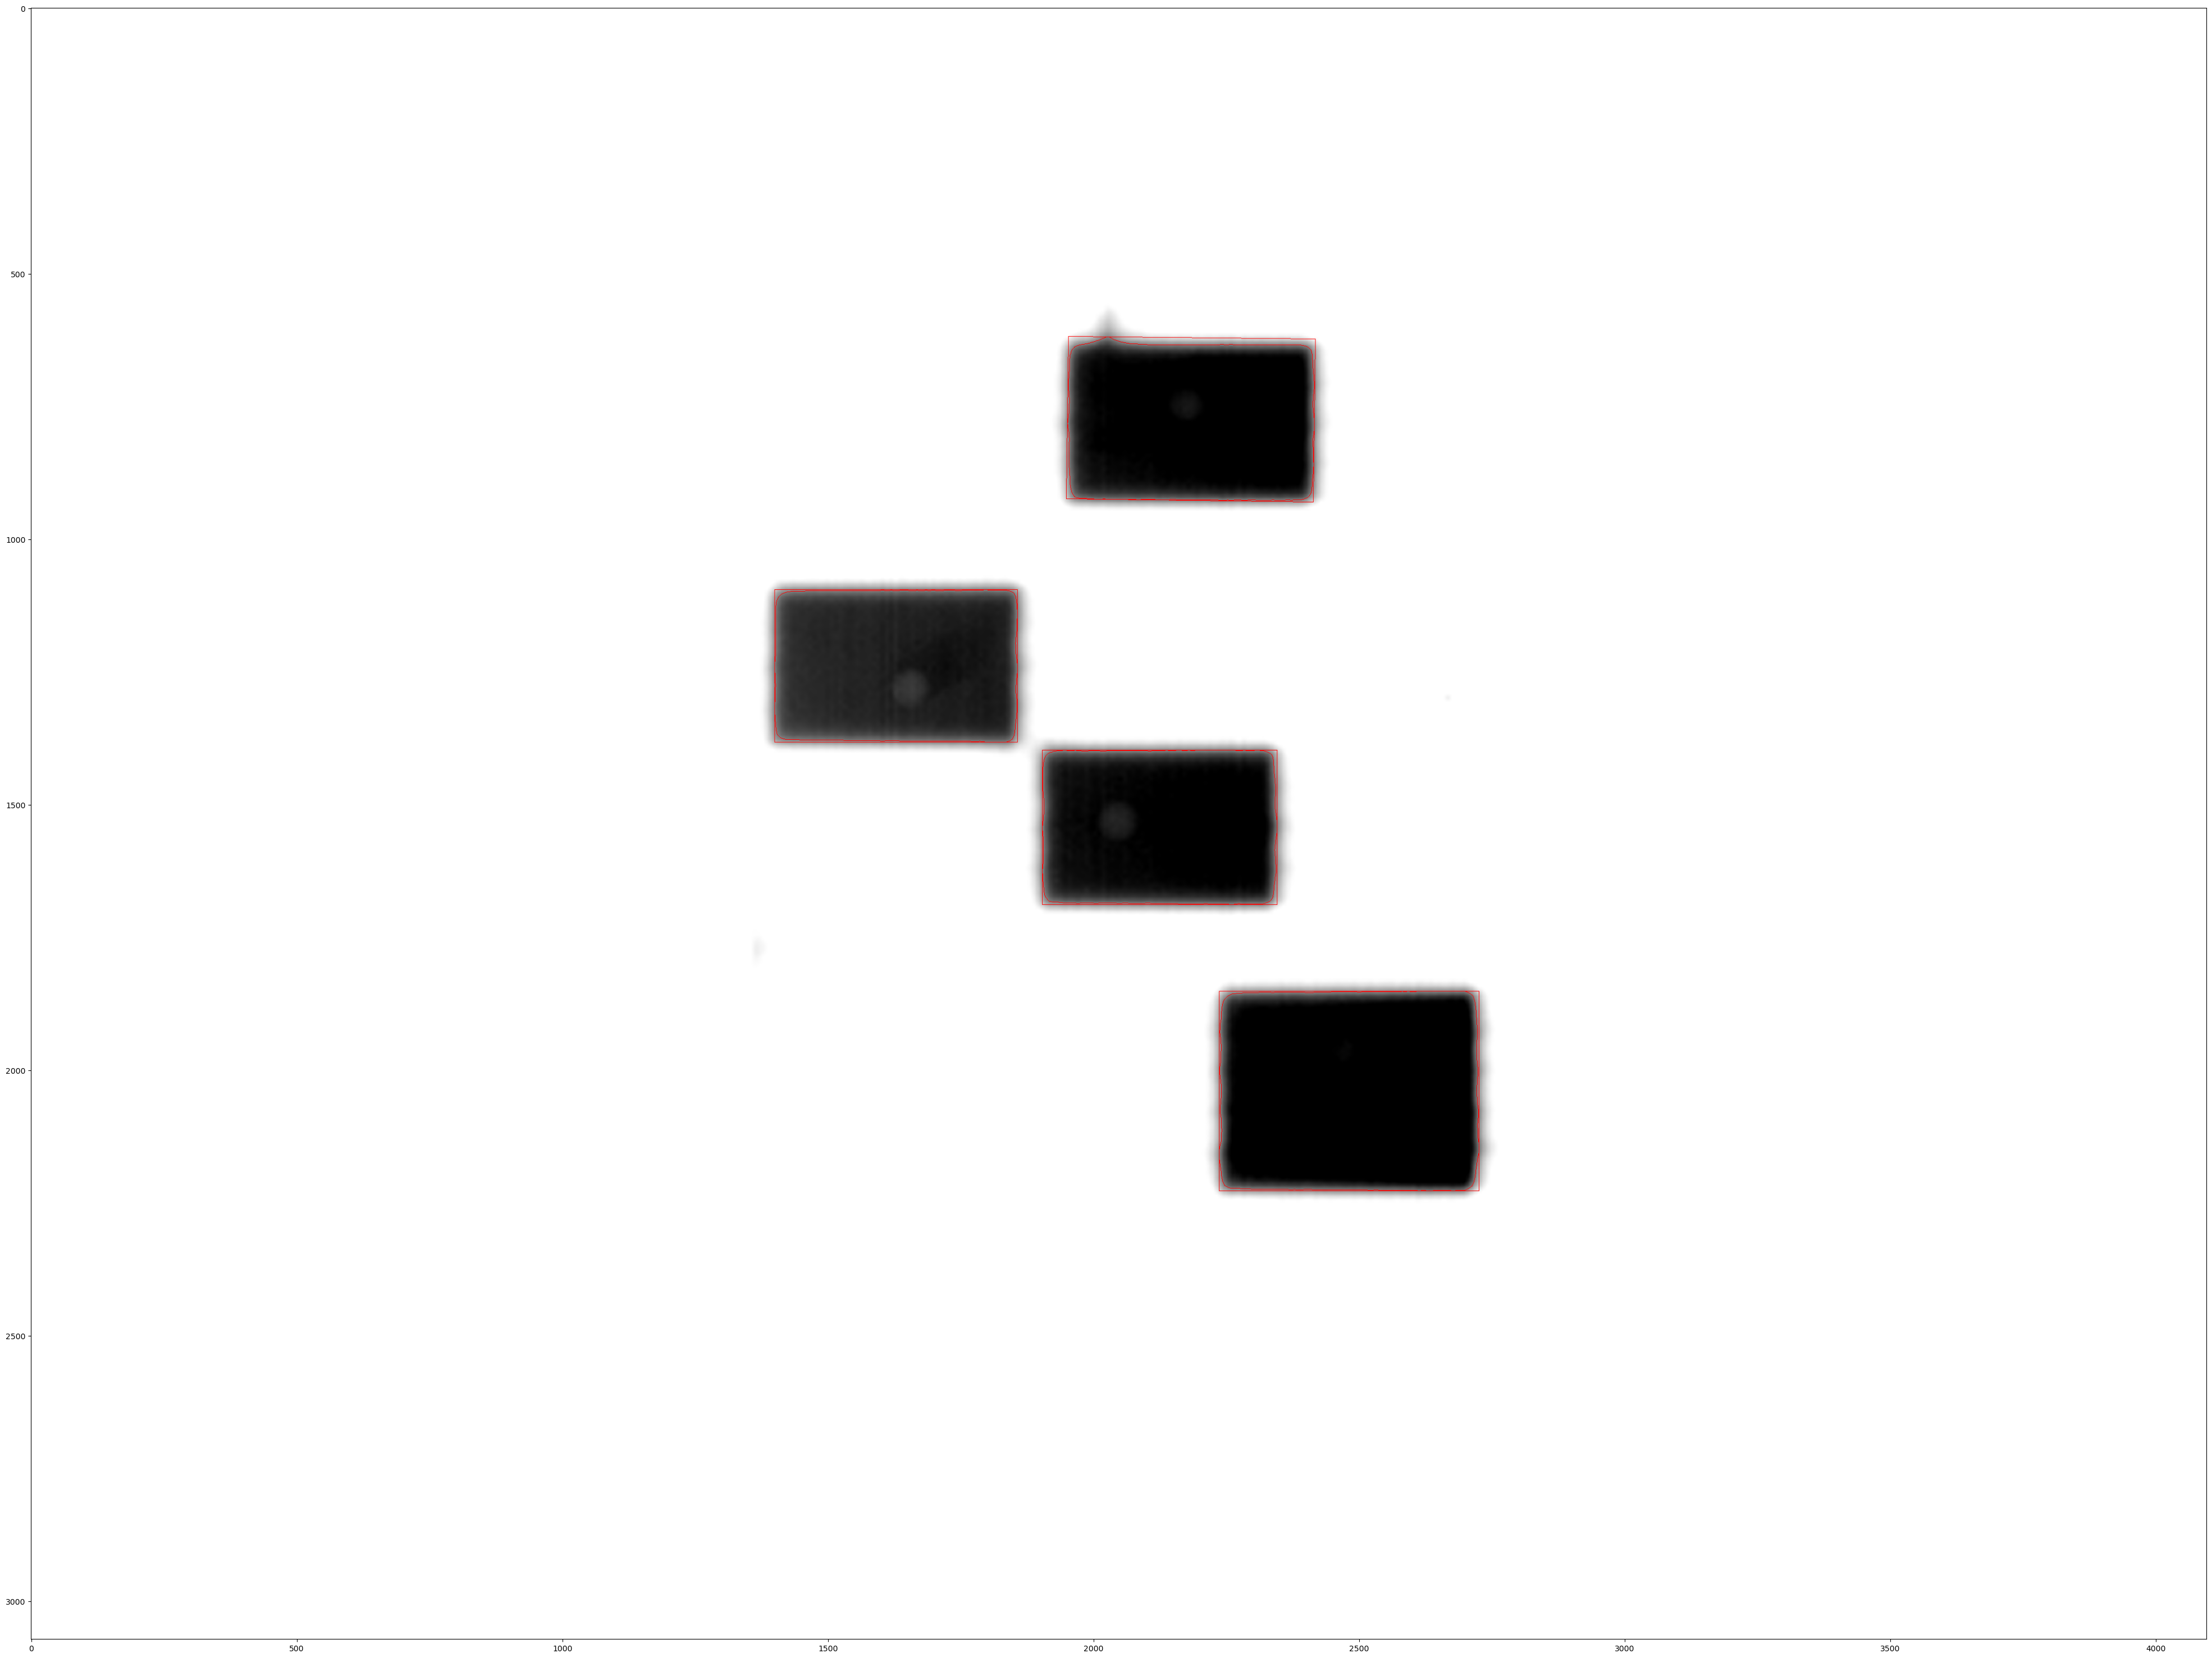

BOX:  [[1455 1842]
 [1961 1838]
 [1963 2151]
 [1457 2154]]
BOX:  [[1835 1472]
 [2284 1472]
 [2284 1692]
 [1835 1692]]
BOX:  [[1671 1387]
 [1671 1091]
 [2210 1091]
 [2210 1387]]
BOX:  [[2220  638]
 [2698  638]
 [2698  931]
 [2220  931]]


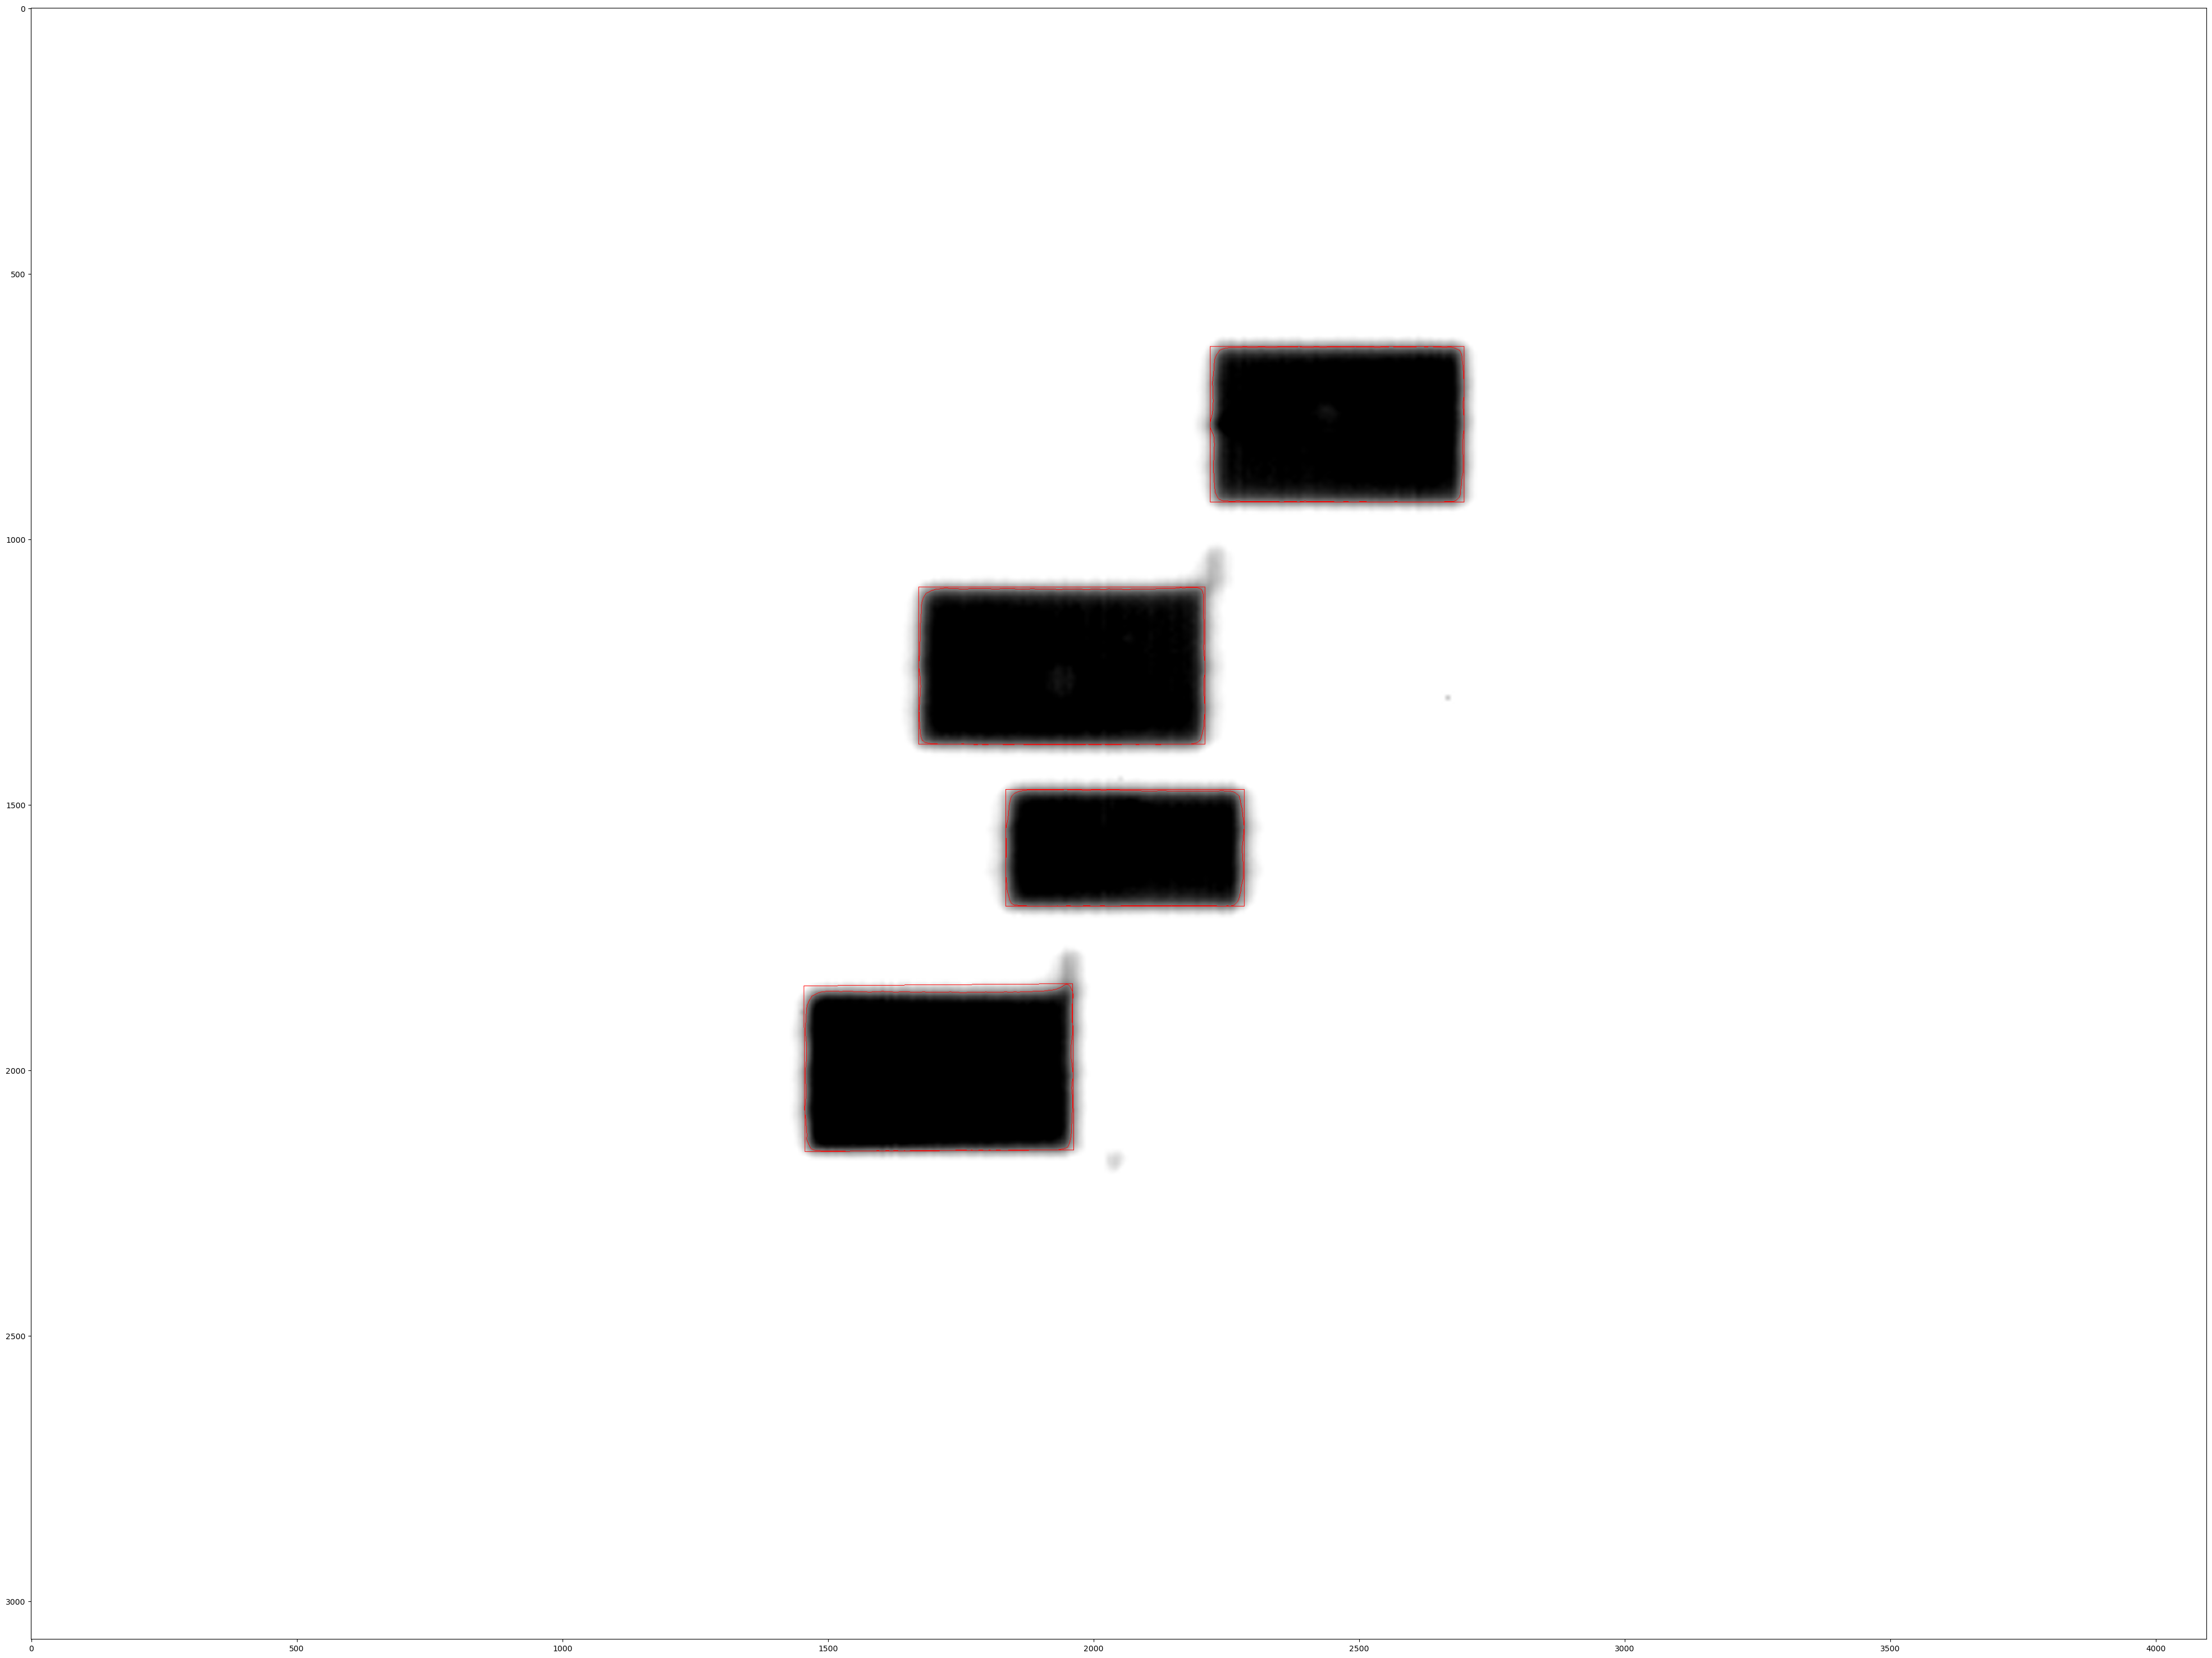

BOX:  [[1361 2223]
 [1361 1846]
 [1847 1846]
 [1847 2223]]
BOX:  [[1741 1684]
 [1741 1392]
 [2186 1392]
 [2186 1684]]
BOX:  [[2233 1379]
 [2233 1092]
 [2690 1092]
 [2690 1379]]
BOX:  [[1675  618]
 [2140  616]
 [2141  922]
 [1676  924]]


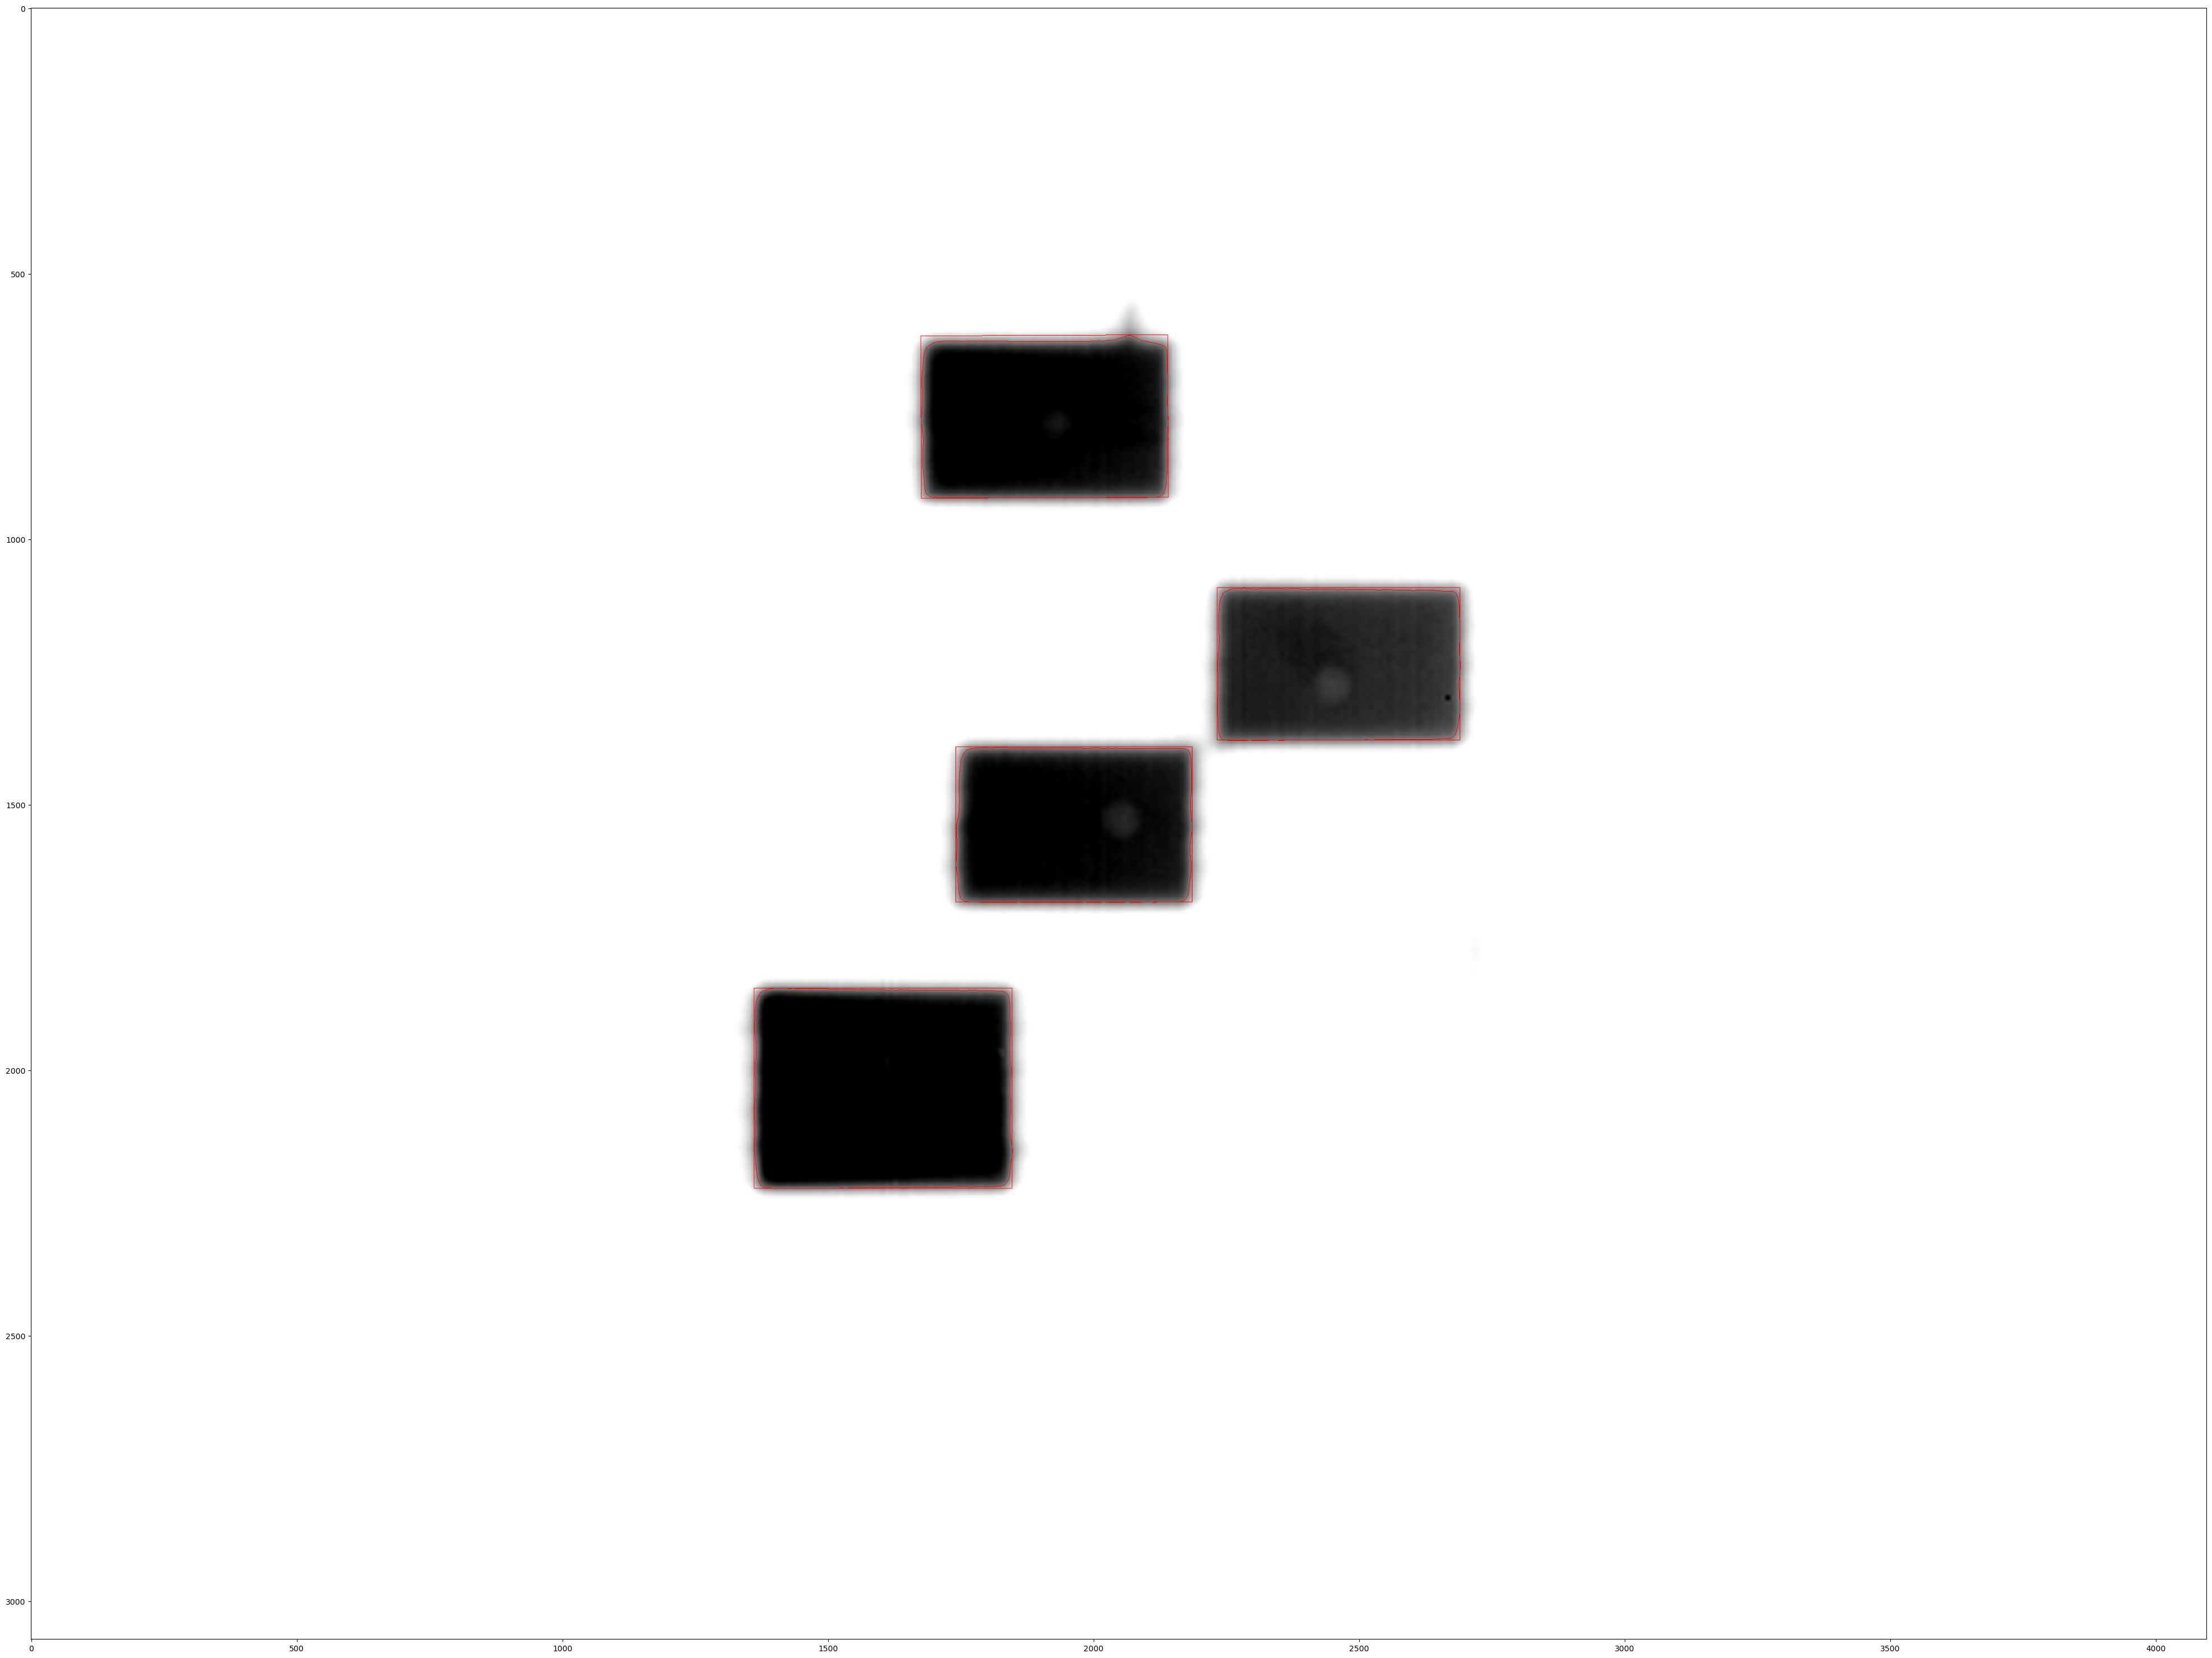

In [143]:
def find_square_edges_w_canny_edge(EPID_tresholding_MLC_detection, i):
    boxes_per_image = []
    name =   'EPID_windowed/Superscaled_' + epid_images_names[i].replace('.dcm', '.tiff')

    grayscale_copy = cv2.imread(name)
    grayscale_copy = cv2.cvtColor(grayscale_copy, cv2.COLOR_BGR2RGB)
    
    convert_gray_into_black_MLC_grayscale = EPID_tresholding_MLC_detection
    median_blur2 = cv2.medianBlur(convert_gray_into_black_MLC_grayscale, 5)
    canny_output = cv2.Canny(median_blur2, 50, 100)
   
    contours, _ = cv2.findContours(canny_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        cv2.drawContours(grayscale_copy,[c],0,(255,0,0),1)
        # get rotated rectangle from contour
        rot_rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rot_rect)
        box = np.int0(box)
        # draw rotated rectangle on copy of img
        cv2.drawContours(grayscale_copy,[box],0,(255,0,0),1)
        print("BOX: ", box)
        boxes_per_image.append(box)
        
#     cv2.imwrite(output_directory + "\\EPID_balls_distance_and_MLC_original_image.tif", cv2.cvtColor(EPID_balls_distance_original_image, cv2.COLOR_RGB2BGR))

#     print("( ", int(boundRect[i][0]), " ", int(boundRect[i][1]), ")\n" )
#     print("( ", int(boundRect[i][0] + boundRect[i][2]), " ", int(boundRect[i][1] + boundRect[i][3]), ")\n" )
    plt.figure(figsize=(50,40))
    plt.imshow(grayscale_copy)
    plt.show()  
    
#     plt.imshow(EPID_balls_distance_original_image)
#     plt.show() 
    return boxes_per_image

boxes_per_images = []
for i in range(0, len(epid_images_thresholded)):
    
    
    boxes_per_image = find_square_edges_w_canny_edge(epid_images_thresholded[i], i)
    boxes_per_images.append(boxes_per_image)

## DRR - EPID // Calculating Irradiation Field Shifts

Adapting the size of the EPID irradiation fields

In [149]:
new_boxes_per_images = []

for i in range(0, len(epid_images_thresholded)):
    new_boxes_per_image = []
    for j in range(0, len(boxes_per_images[i])):
        new_temp = []
        temp = boxes_per_images[i][j]
        top_right = [temp[0][0] + xoff, temp[0][1] + yoff]
        top_left = [temp[1][0] + xoff, temp[1][1] + yoff]
        bottom_left = [temp[2][0] + xoff, temp[2][1] + yoff]
        bottom_right = [temp[3][0] + xoff, temp[3][1] + yoff]
        new_temp.append(top_right)
        new_temp.append(top_left)
        new_temp.append(bottom_left)
        new_temp.append(bottom_right)
        new_boxes_per_image.append(new_temp)
    new_boxes_per_images.append(new_boxes_per_image)

In [150]:
def comparison(array_for_comparison):
    array_sorted = []
    x_s = [item[0] for item in array_for_comparison]
    y_s = [item[1] for item in array_for_comparison]
    
    temp_0 = []
    temp_1 = []
    temp_2 = []
    temp_3 = []
    
    threshold_x = (max(x_s) - min(x_s)) / 2
    threshold_y =  (max(y_s) - min(y_s)) / 2
    
    threshold_x = min(x_s) + threshold_x 
    threshold_y = min(y_s) + threshold_y 

    
    for value in array_for_comparison:       
        if(value[0] < threshold_x and value[1] < threshold_y):
            temp_0 = value
        if(value[0] > threshold_x and value[1] < threshold_y):
            temp_1 = value
        if(value[0] < threshold_x and value[1] > threshold_y):
            temp_2 = value
        if(value[0] > threshold_x and value[1] > threshold_y):
            temp_3 = value

    array_sorted.append(temp_0)
    array_sorted.append(temp_1)
    array_sorted.append(temp_2)
    array_sorted.append(temp_3)

    return array_sorted

final_result = [] 
for i in range (0, len(new_boxes_per_images)):
    
    image_temp = []
    
    for j in range(0, len(new_boxes_per_images[i])):
        line = new_boxes_per_images[i][j]
        line_result = comparison(line)
        image_temp.append(line_result)
    
    final_result.append(image_temp)

In [151]:
import statistics
statistiche = []
print("The Irradiation Fields are ordered from the bottom to the top:\n")

for i in (range(0, len(new_coordinates_arr[0]))):
    print("Irradiation Field N^ ", i)
    irr_field = []
    top_distance_arr = []
    bottom_distance_arr = []
    left_distance_arr = []
    right_distance_arr = []
    depth_distance_arr = []
    front_distance_arr = []
    
    for j in range(0, len(names_list)):
        drr_box = (sorted(new_coordinates_arr[j][i], key=lambda e: (e[1], e[0])))
        epid_box = (final_result[j][i])
        
#         if('ANT' in names_list[j]):
#             top_distance_arr.append(max(abs(drr_box[0][1] - epid_box[0][1]), abs(drr_box[1][1] - epid_box[1][1])))
#             bottom_distance_arr.append(max(abs(drr_box[2][1] - epid_box[2][1]), abs(drr_box[3][1] - epid_box[3][1])))
#             left_distance_arr.append(max(abs(drr_box[0][0] - epid_box[0][0]), abs(drr_box[2][0] - epid_box[2][0])))
#             right_distance_arr.append(max(abs(drr_box[1][0] - epid_box[1][0]), abs(drr_box[3][0] - epid_box[3][0])))

#         if('POST' in names_list[j]):
#             top_distance_arr.append(max(abs(drr_box[0][1] - epid_box[0][1]), abs(drr_box[1][1] - epid_box[1][1])))
#             bottom_distance_arr.append(max(abs(drr_box[2][1] - epid_box[2][1]), abs(drr_box[3][1] - epid_box[3][1])))
#             left_distance_arr.append(max(abs(drr_box[1][0] - epid_box[1][0]), abs(drr_box[3][0] - epid_box[3][0])))
#             right_distance_arr.append(max(abs(drr_box[0][0] - epid_box[0][0]), abs(drr_box[2][0] - epid_box[2][0])))

#         if('LAT D' in names_list[j]):
#             top_distance_arr.append(max(abs(drr_box[0][1] - epid_box[0][1]), abs(drr_box[1][1] - epid_box[1][1])))
#             bottom_distance_arr.append(max(abs(drr_box[2][1] - epid_box[2][1]), abs(drr_box[3][1] - epid_box[3][1])))
#             front_distance_arr.append(max(abs(drr_box[1][0] - epid_box[1][0]), abs(drr_box[3][0] - epid_box[3][0])))
#             depth_distance_arr.append(max(abs(drr_box[0][0] - epid_box[0][0]), abs(drr_box[2][0] - epid_box[2][0])))

#         if('LAT G' in names_list[j]):
#             top_distance_arr.append(max(abs(drr_box[0][1] - epid_box[0][1]), abs(drr_box[1][1] - epid_box[1][1])))
#             bottom_distance_arr.append(max(abs(drr_box[2][1] - epid_box[2][1]), abs(drr_box[3][1] - epid_box[3][1])))
#             front_distance_arr.append(max(abs(drr_box[0][0] - epid_box[0][0]), abs(drr_box[2][0] - epid_box[2][0])))
#             depth_distance_arr.append(max(abs(drr_box[1][0] - epid_box[1][0]), abs(drr_box[3][0] - epid_box[3][0])))

        print(names_list[j])
        print('4 measurements \n')
        top_distance_arr = (max(abs(drr_box[0][1] - epid_box[0][1]), abs(drr_box[1][1] - epid_box[1][1]))) * epid_images_new_pixel_spacing / 8
        bottom_distance_arr = (max(abs(drr_box[2][1] - epid_box[2][1]), abs(drr_box[3][1] - epid_box[3][1]))) * epid_images_new_pixel_spacing / 8
        left_distance_arr = (max(abs(drr_box[0][0] - epid_box[0][0]), abs(drr_box[2][0] - epid_box[2][0]))) * epid_images_new_pixel_spacing / 8
        right_distance_arr = (max(abs(drr_box[1][0] - epid_box[1][0]), abs(drr_box[3][0] - epid_box[3][0]))) * epid_images_new_pixel_spacing / 8

        square = (top_distance_arr, bottom_distance_arr, left_distance_arr, right_distance_arr)
        
        irr_field.append(square)
#     print("Distance Top: ", (statistics.mean(top_distance_arr)) * epid_images_new_pixel_spacing / 8, "mm")
#     irr_field.append((statistics.mean(top_distance_arr)) * epid_images_new_pixel_spacing / 8)
    
#     print("Distance Bottom: ", (statistics.mean(bottom_distance_arr)) * epid_images_new_pixel_spacing / 8, "mm")
#     irr_field.append((statistics.mean(bottom_distance_arr)) * epid_images_new_pixel_spacing / 8)
    
#     print("Distance Left: ", (statistics.mean(left_distance_arr)) * epid_images_new_pixel_spacing / 8, "mm")
#     irr_field.append((statistics.mean(left_distance_arr)) * epid_images_new_pixel_spacing / 8)
    
#     print("Distance Right: ", (statistics.mean(right_distance_arr)) * epid_images_new_pixel_spacing / 8, "mm")
#     irr_field.append((statistics.mean(right_distance_arr)) * epid_images_new_pixel_spacing / 8)
    
#     print("Distance Front: ", (statistics.mean(front_distance_arr)) * epid_images_new_pixel_spacing / 8, "mm")
#     irr_field.append((statistics.mean(front_distance_arr)) * epid_images_new_pixel_spacing / 8)
    
#     print("Distance Depth: ", (statistics.mean(depth_distance_arr)) * epid_images_new_pixel_spacing / 8, "mm")
#     irr_field.append((statistics.mean(depth_distance_arr)) * epid_images_new_pixel_spacing / 8)   
       
    statistiche.append(irr_field)    
    print("\n-----------\n")

The Irradiation Fields are ordered from the bottom to the top:

Irradiation Field N^  0
C1 ANT MLC
4 measurements 

C1 LAT D MLC
4 measurements 

C1 POST MLC
4 measurements 

C1 LAT G MLC
4 measurements 


-----------

Irradiation Field N^  1
C1 ANT MLC
4 measurements 

C1 LAT D MLC
4 measurements 

C1 POST MLC
4 measurements 

C1 LAT G MLC
4 measurements 


-----------

Irradiation Field N^  2
C1 ANT MLC
4 measurements 

C1 LAT D MLC
4 measurements 

C1 POST MLC
4 measurements 

C1 LAT G MLC
4 measurements 


-----------

Irradiation Field N^  3
C1 ANT MLC
4 measurements 

C1 LAT D MLC
4 measurements 

C1 POST MLC
4 measurements 

C1 LAT G MLC
4 measurements 


-----------



In [361]:
statistiche = np.asarray(statistiche)

statistiche_reshaped = statistiche.reshape(statistiche.shape[0], -1)
np.savetxt("distance_irradiation_field.txt", statistiche_reshaped, delimiter=",")

In [333]:
temp_3_field = drr_images_interpol_windowed_names[3]
temp_2_field = drr_images_interpol_windowed_names[2]

drr_images_interpol_windowed_names[2] = temp_3_field
drr_images_interpol_windowed_names[3] = temp_2_field

temp_3_field = epid_images_interpol_windowed_names[3]
temp_2_field = epid_images_interpol_windowed_names[2]

epid_images_interpol_windowed_names[2] = temp_3_field
epid_images_interpol_windowed_names[3] = temp_2_field

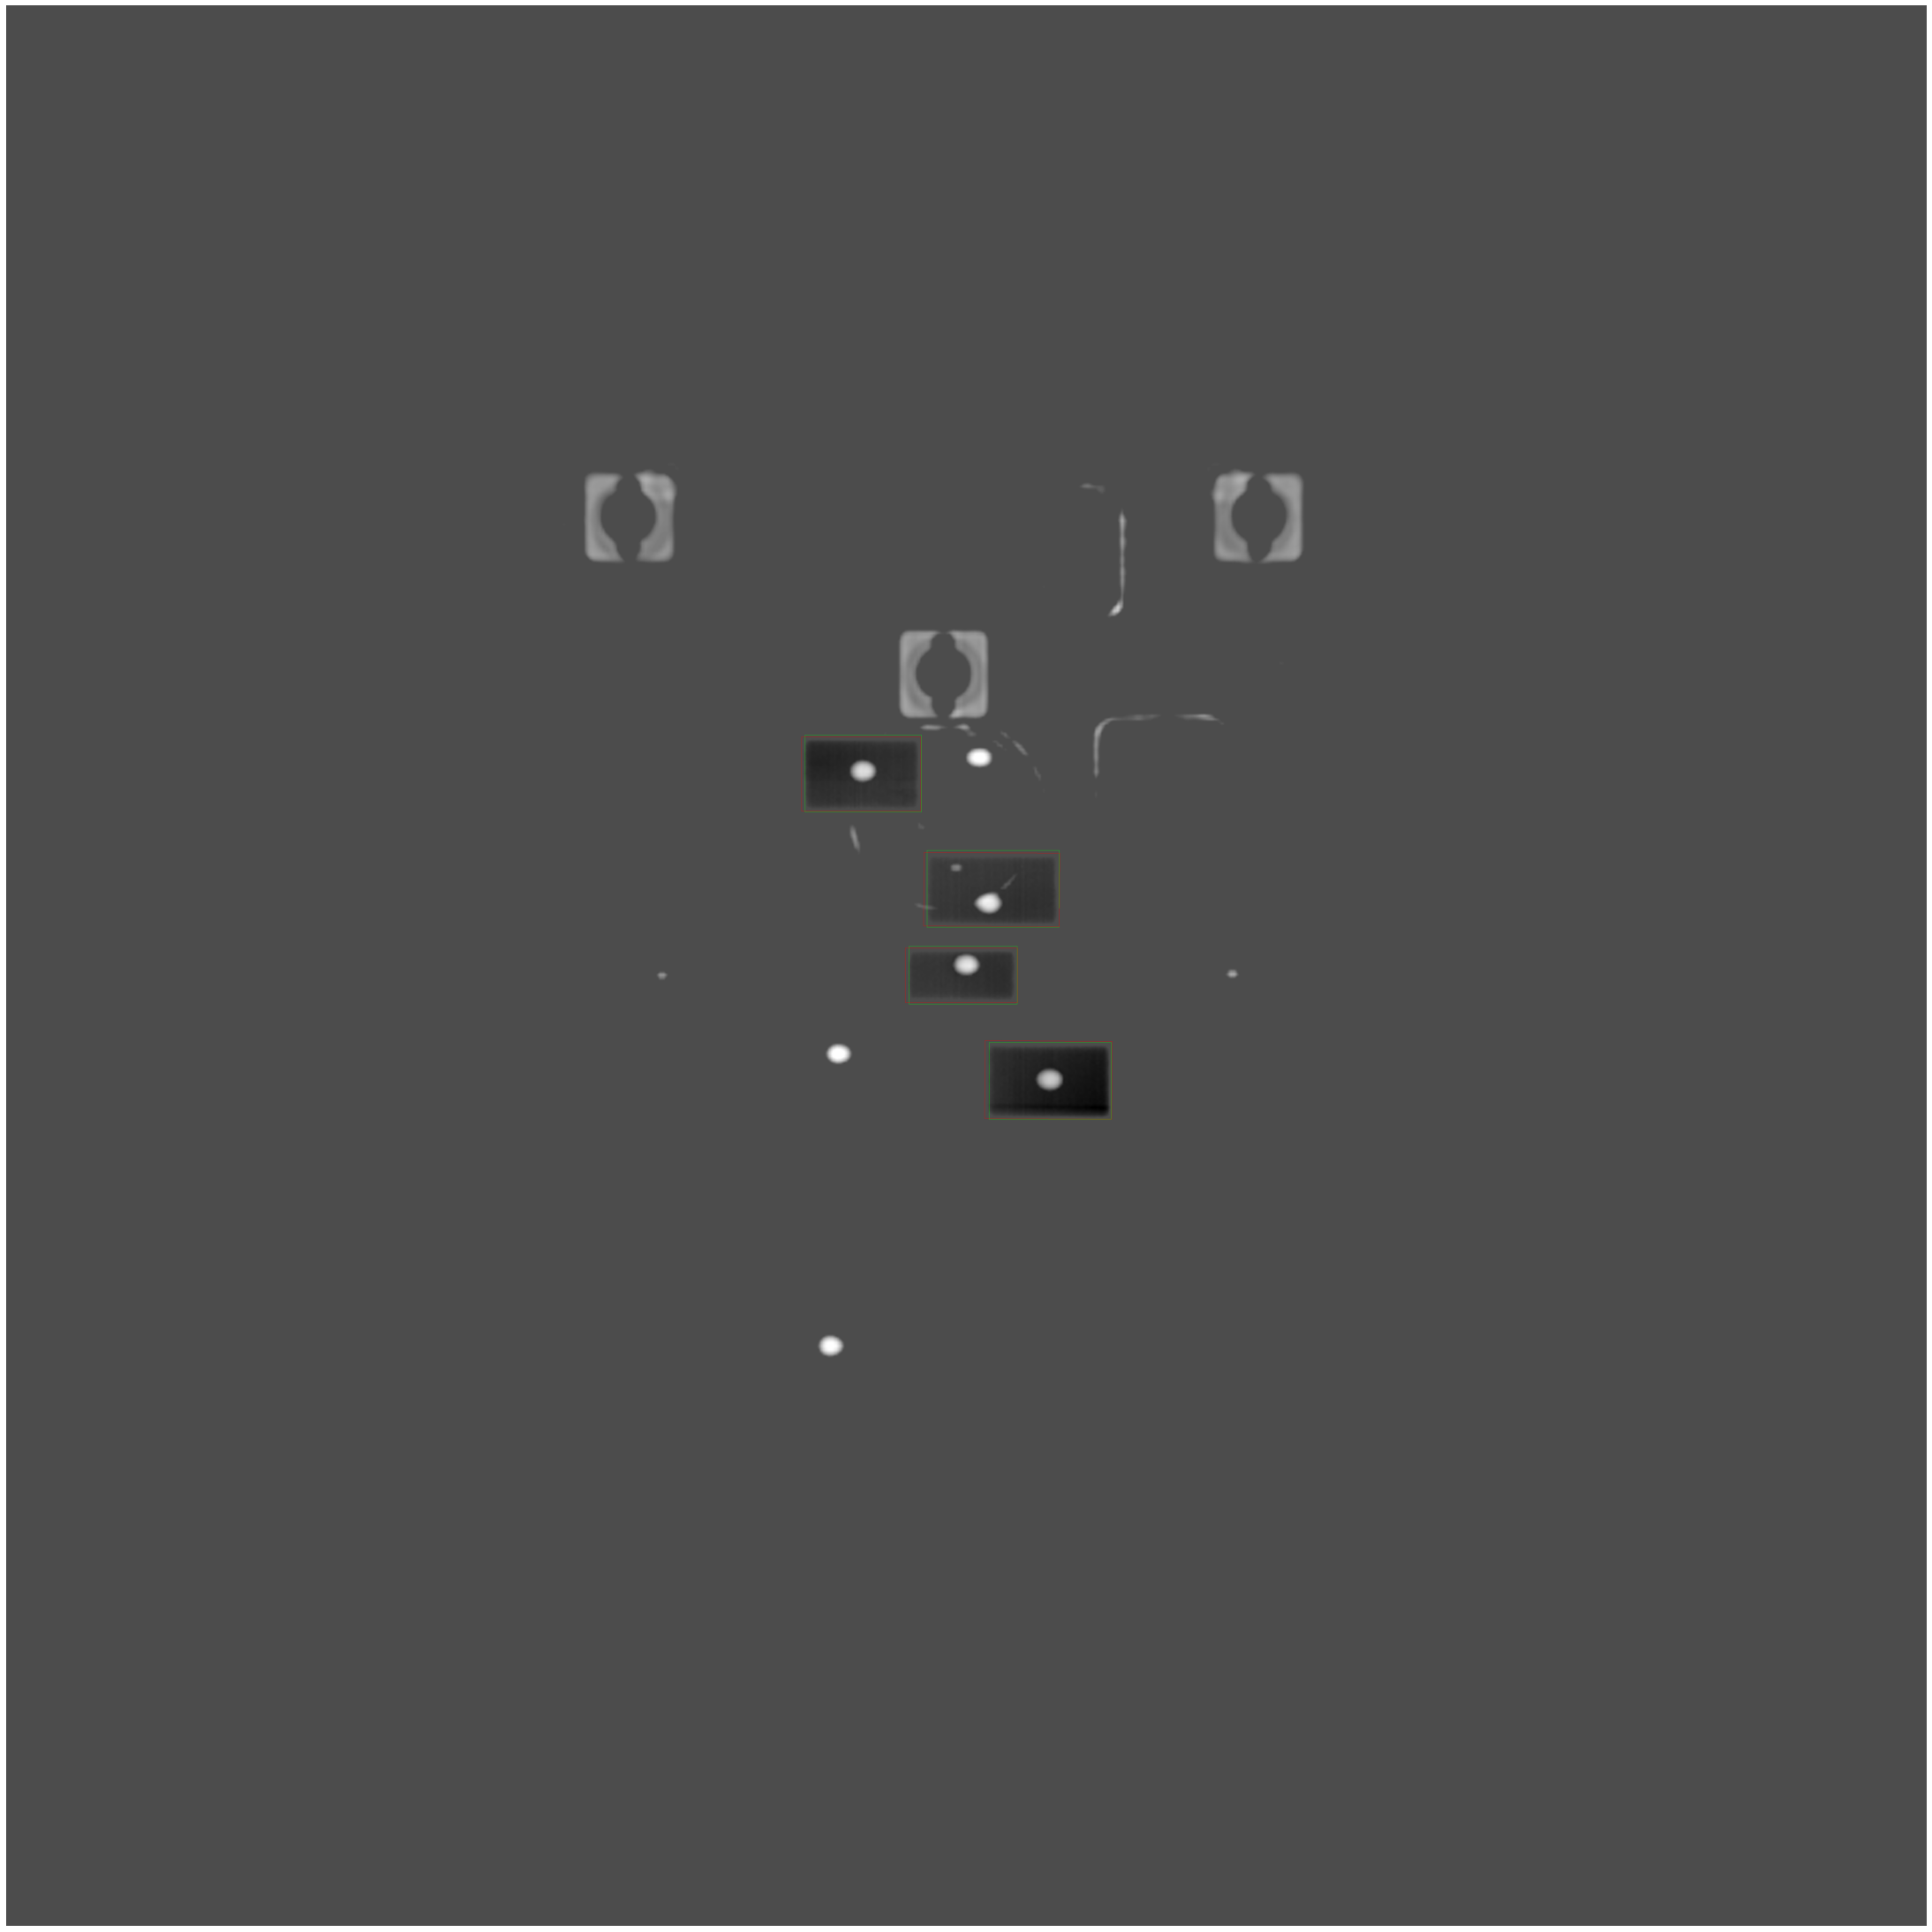

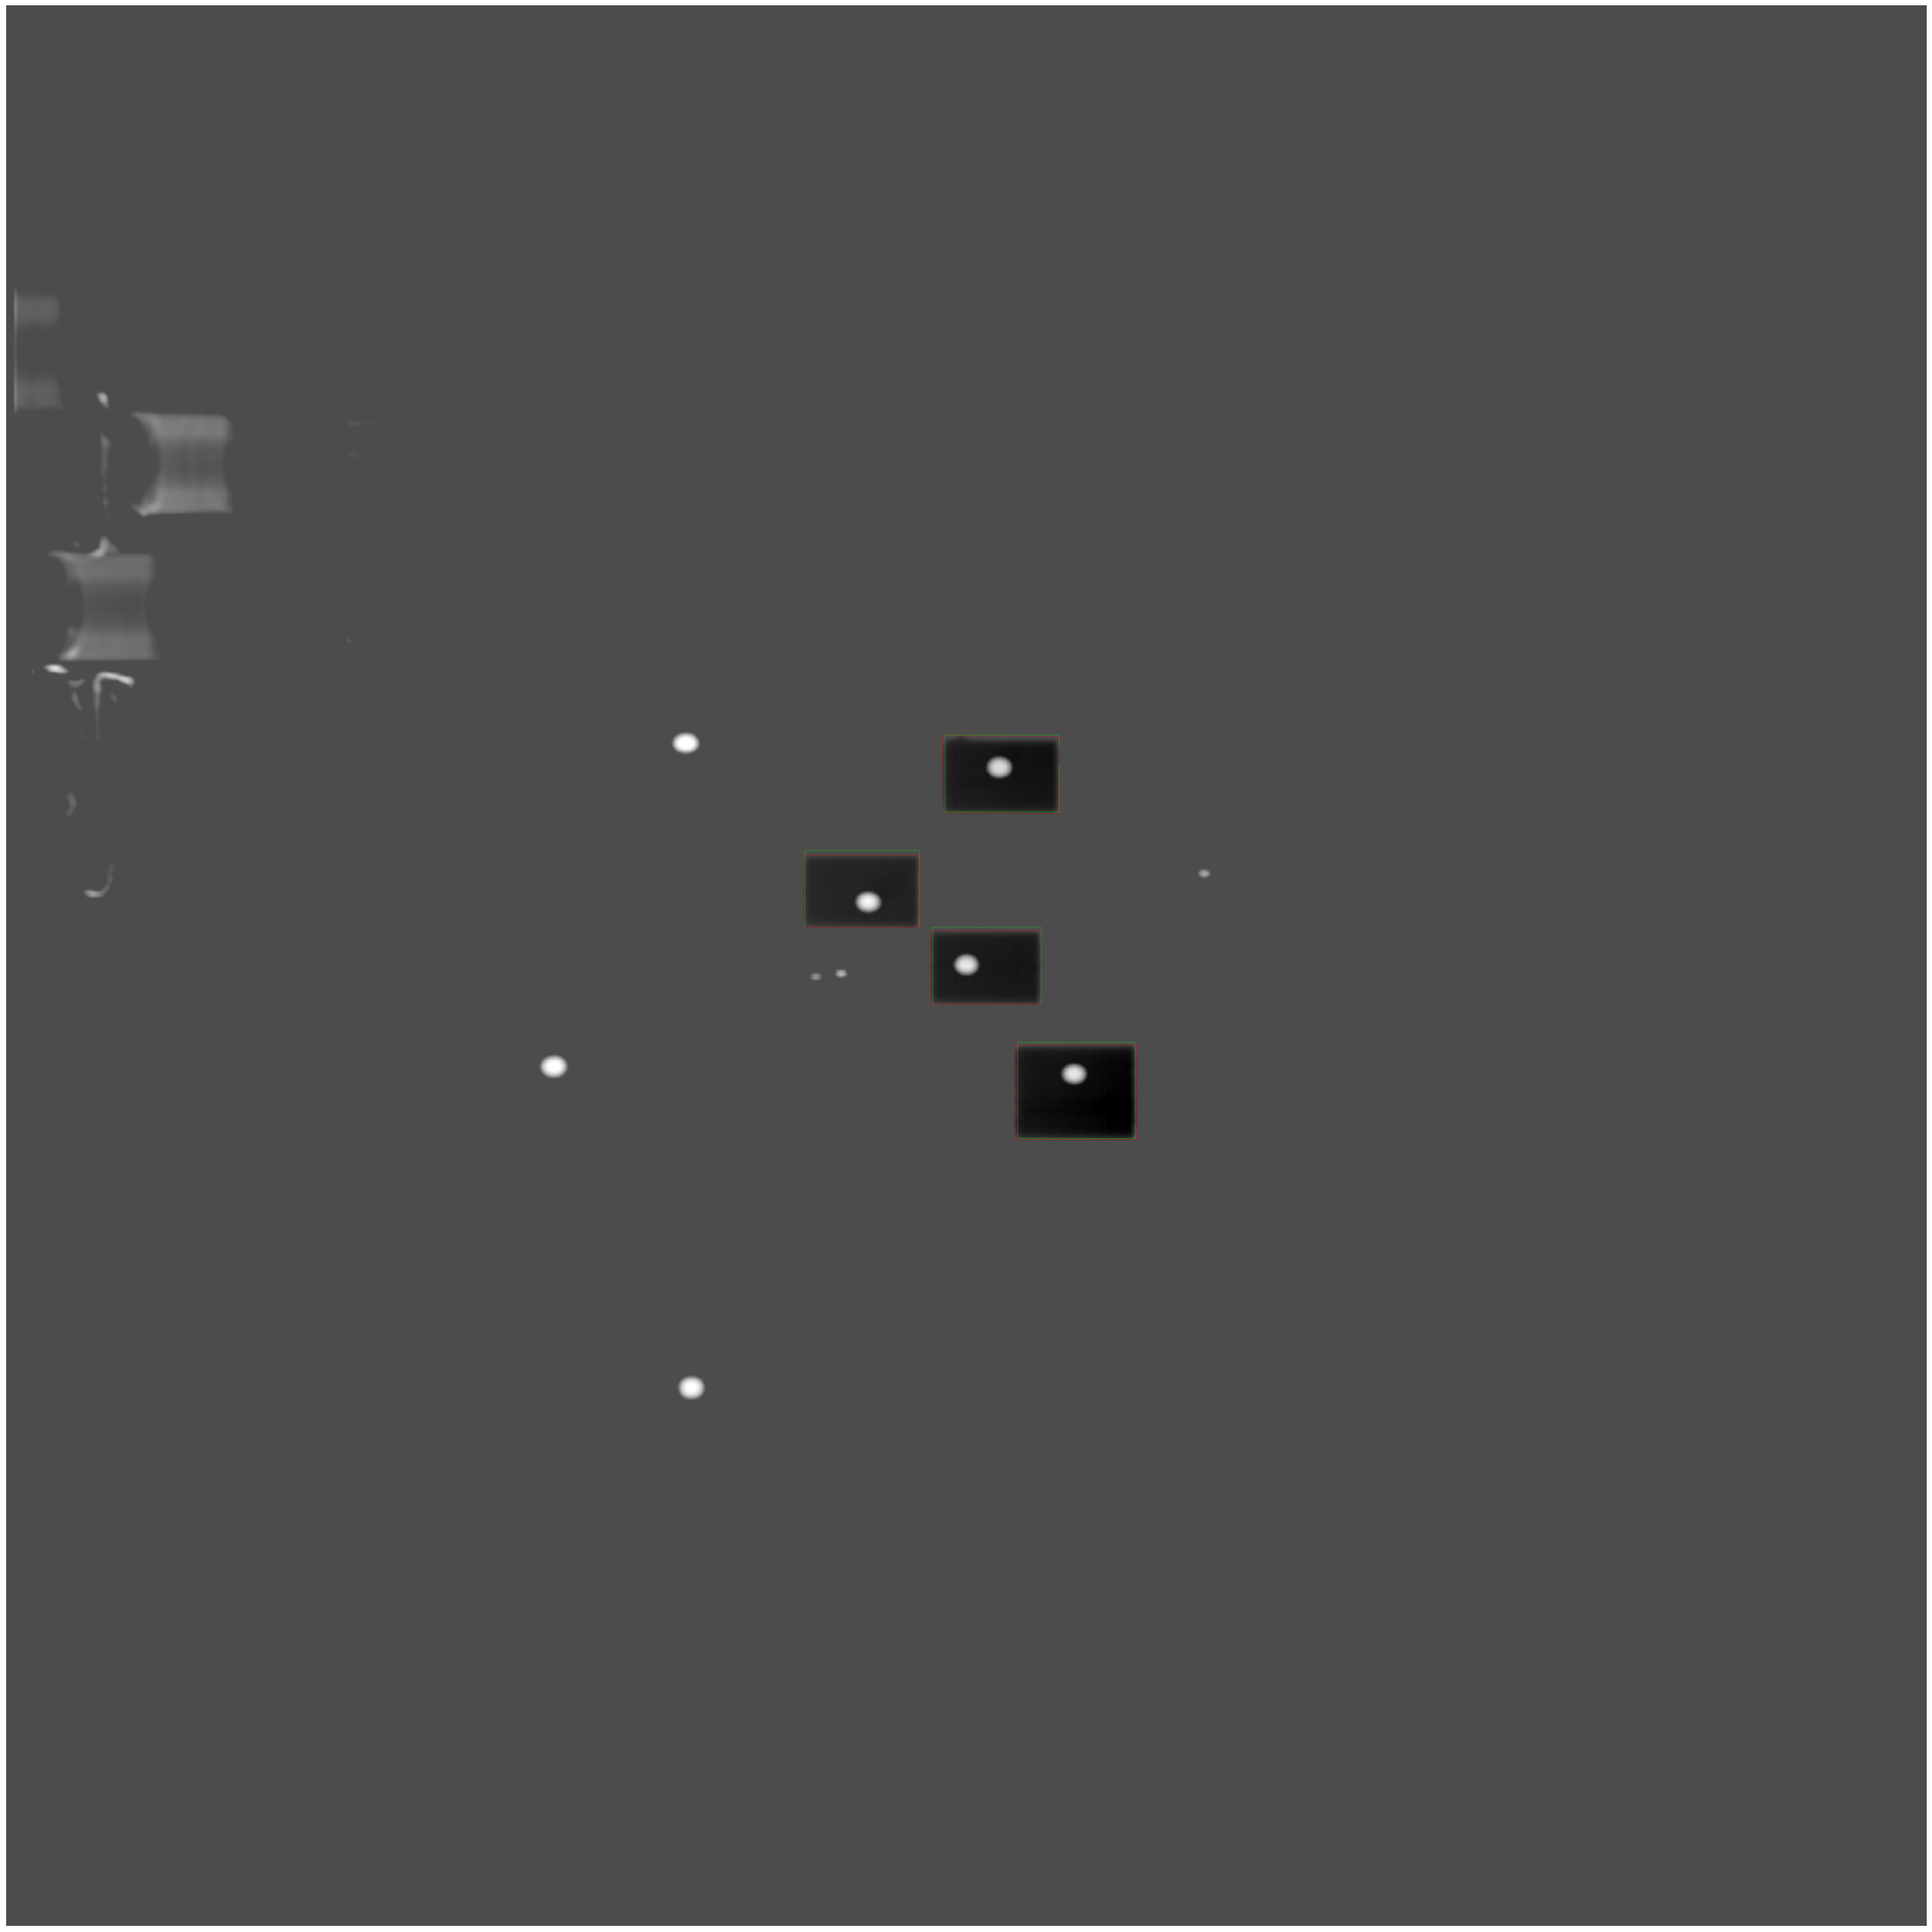

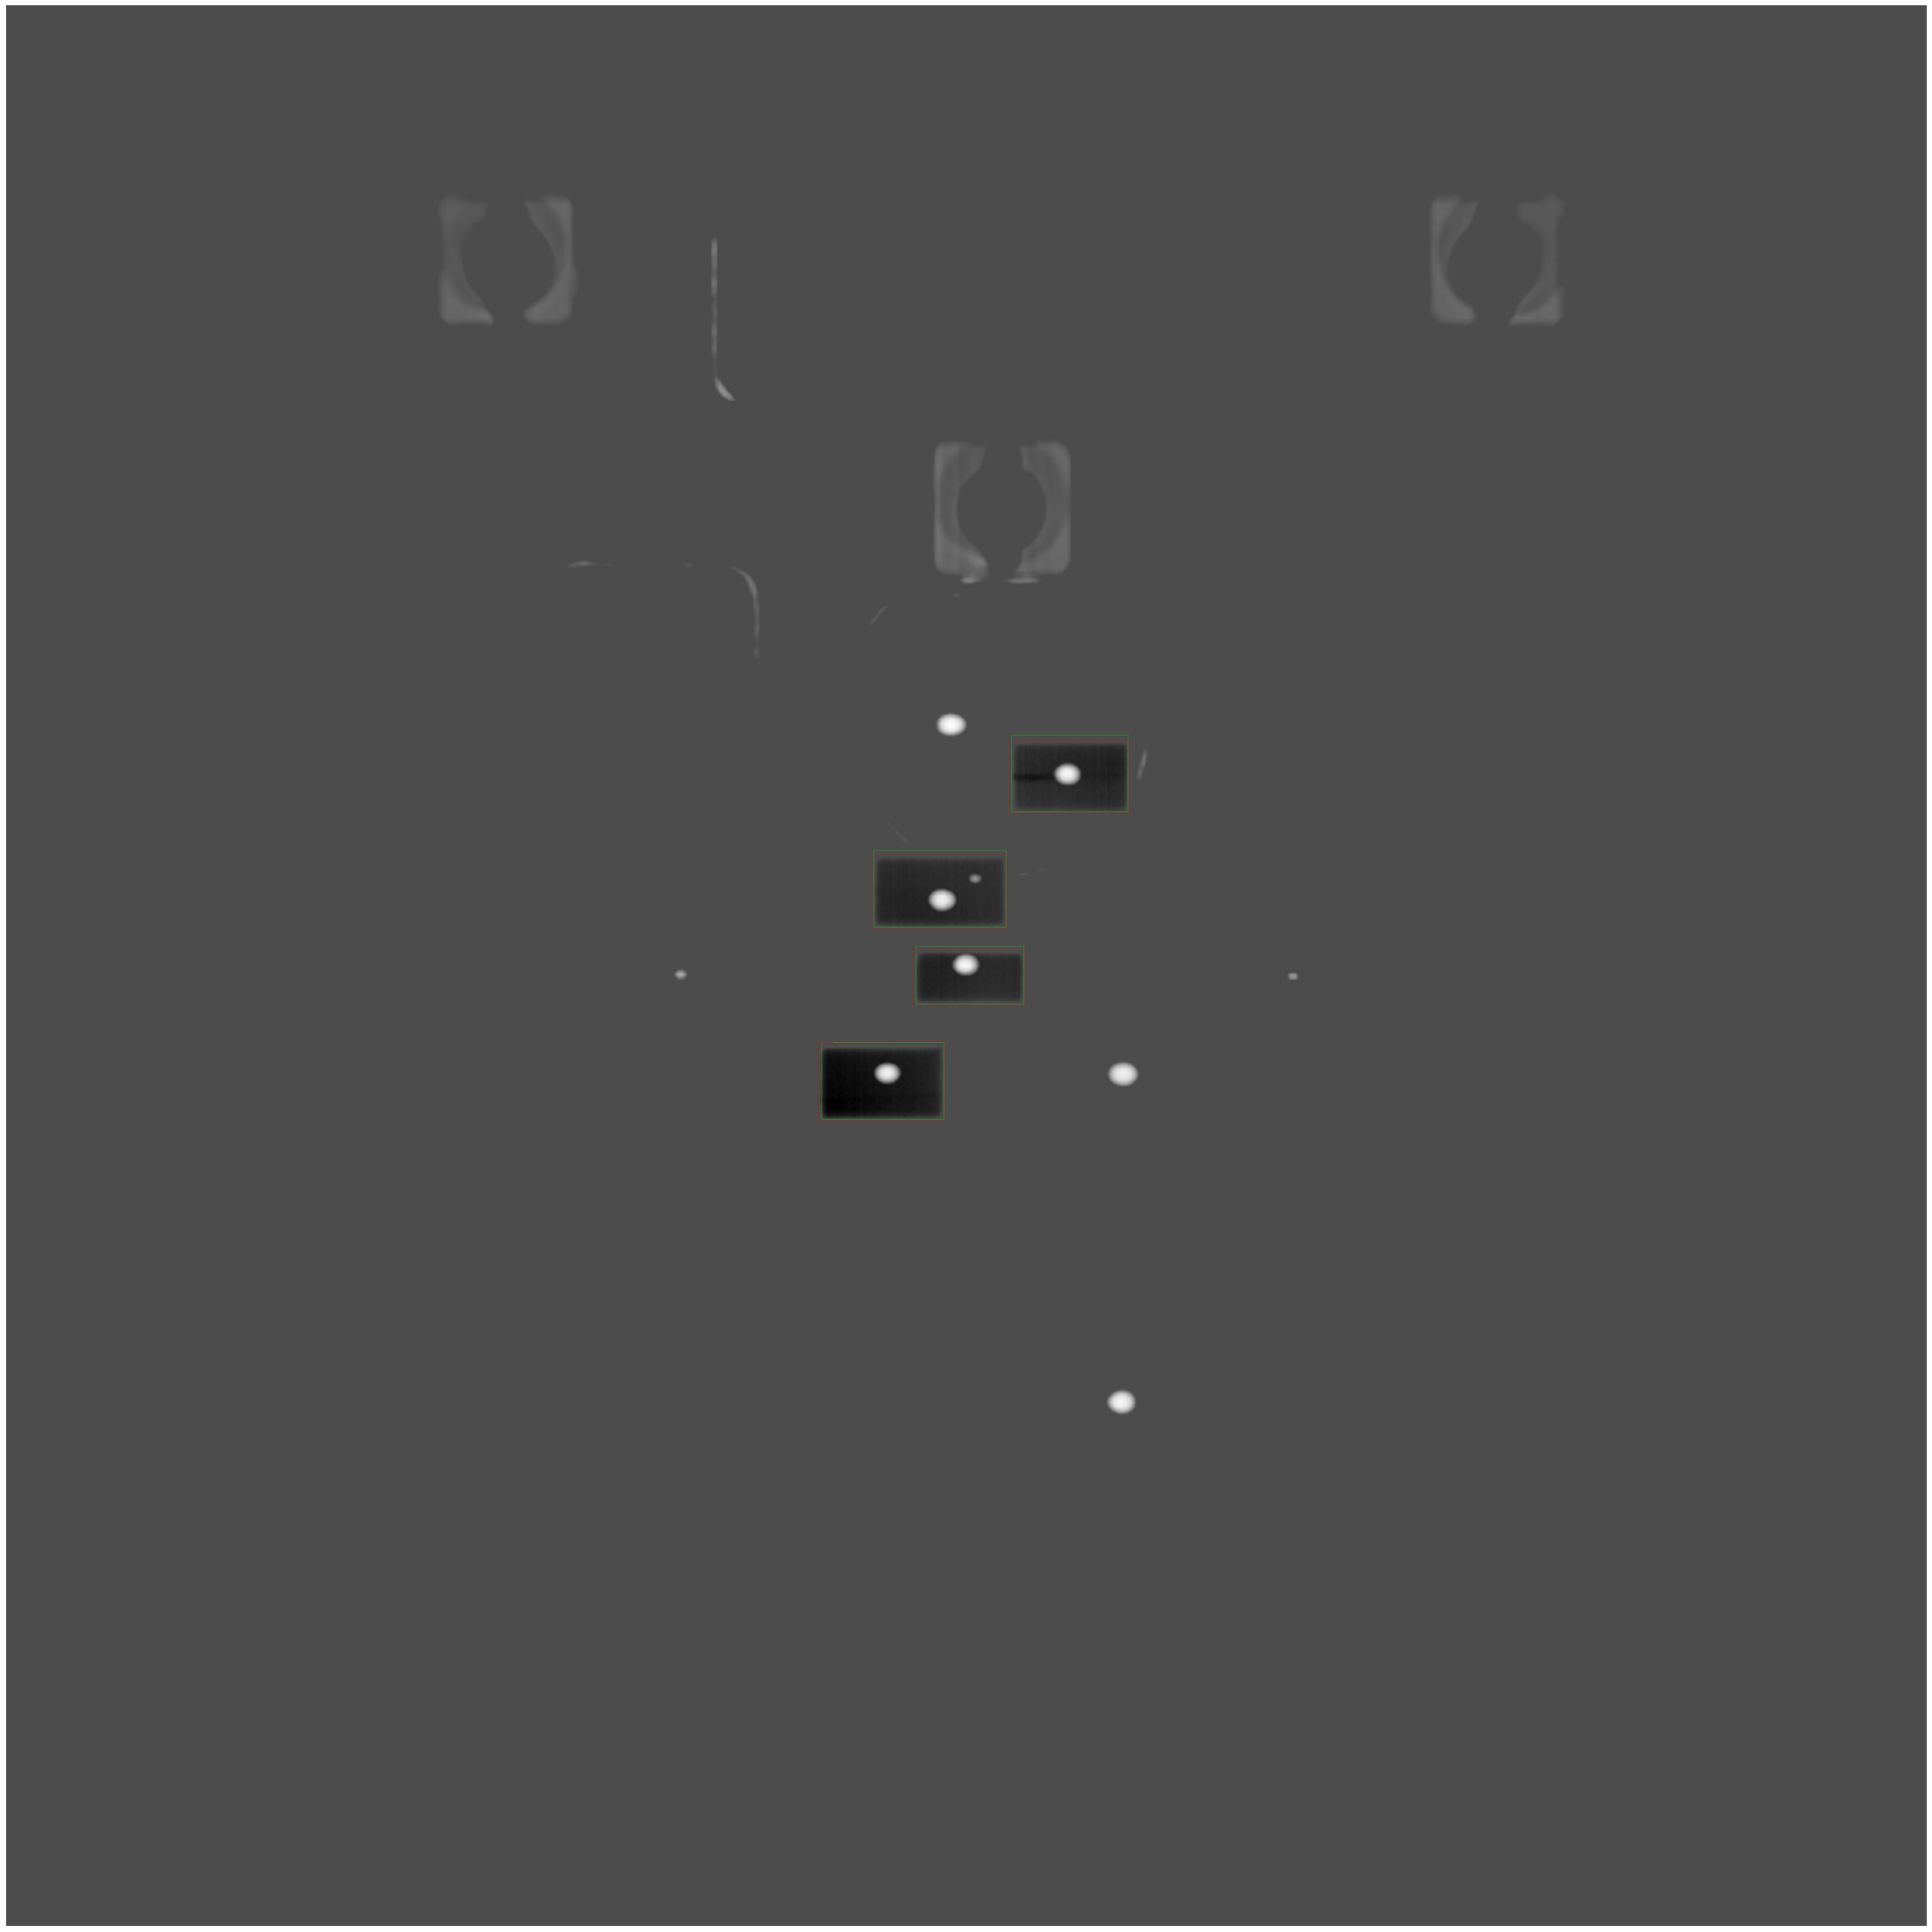

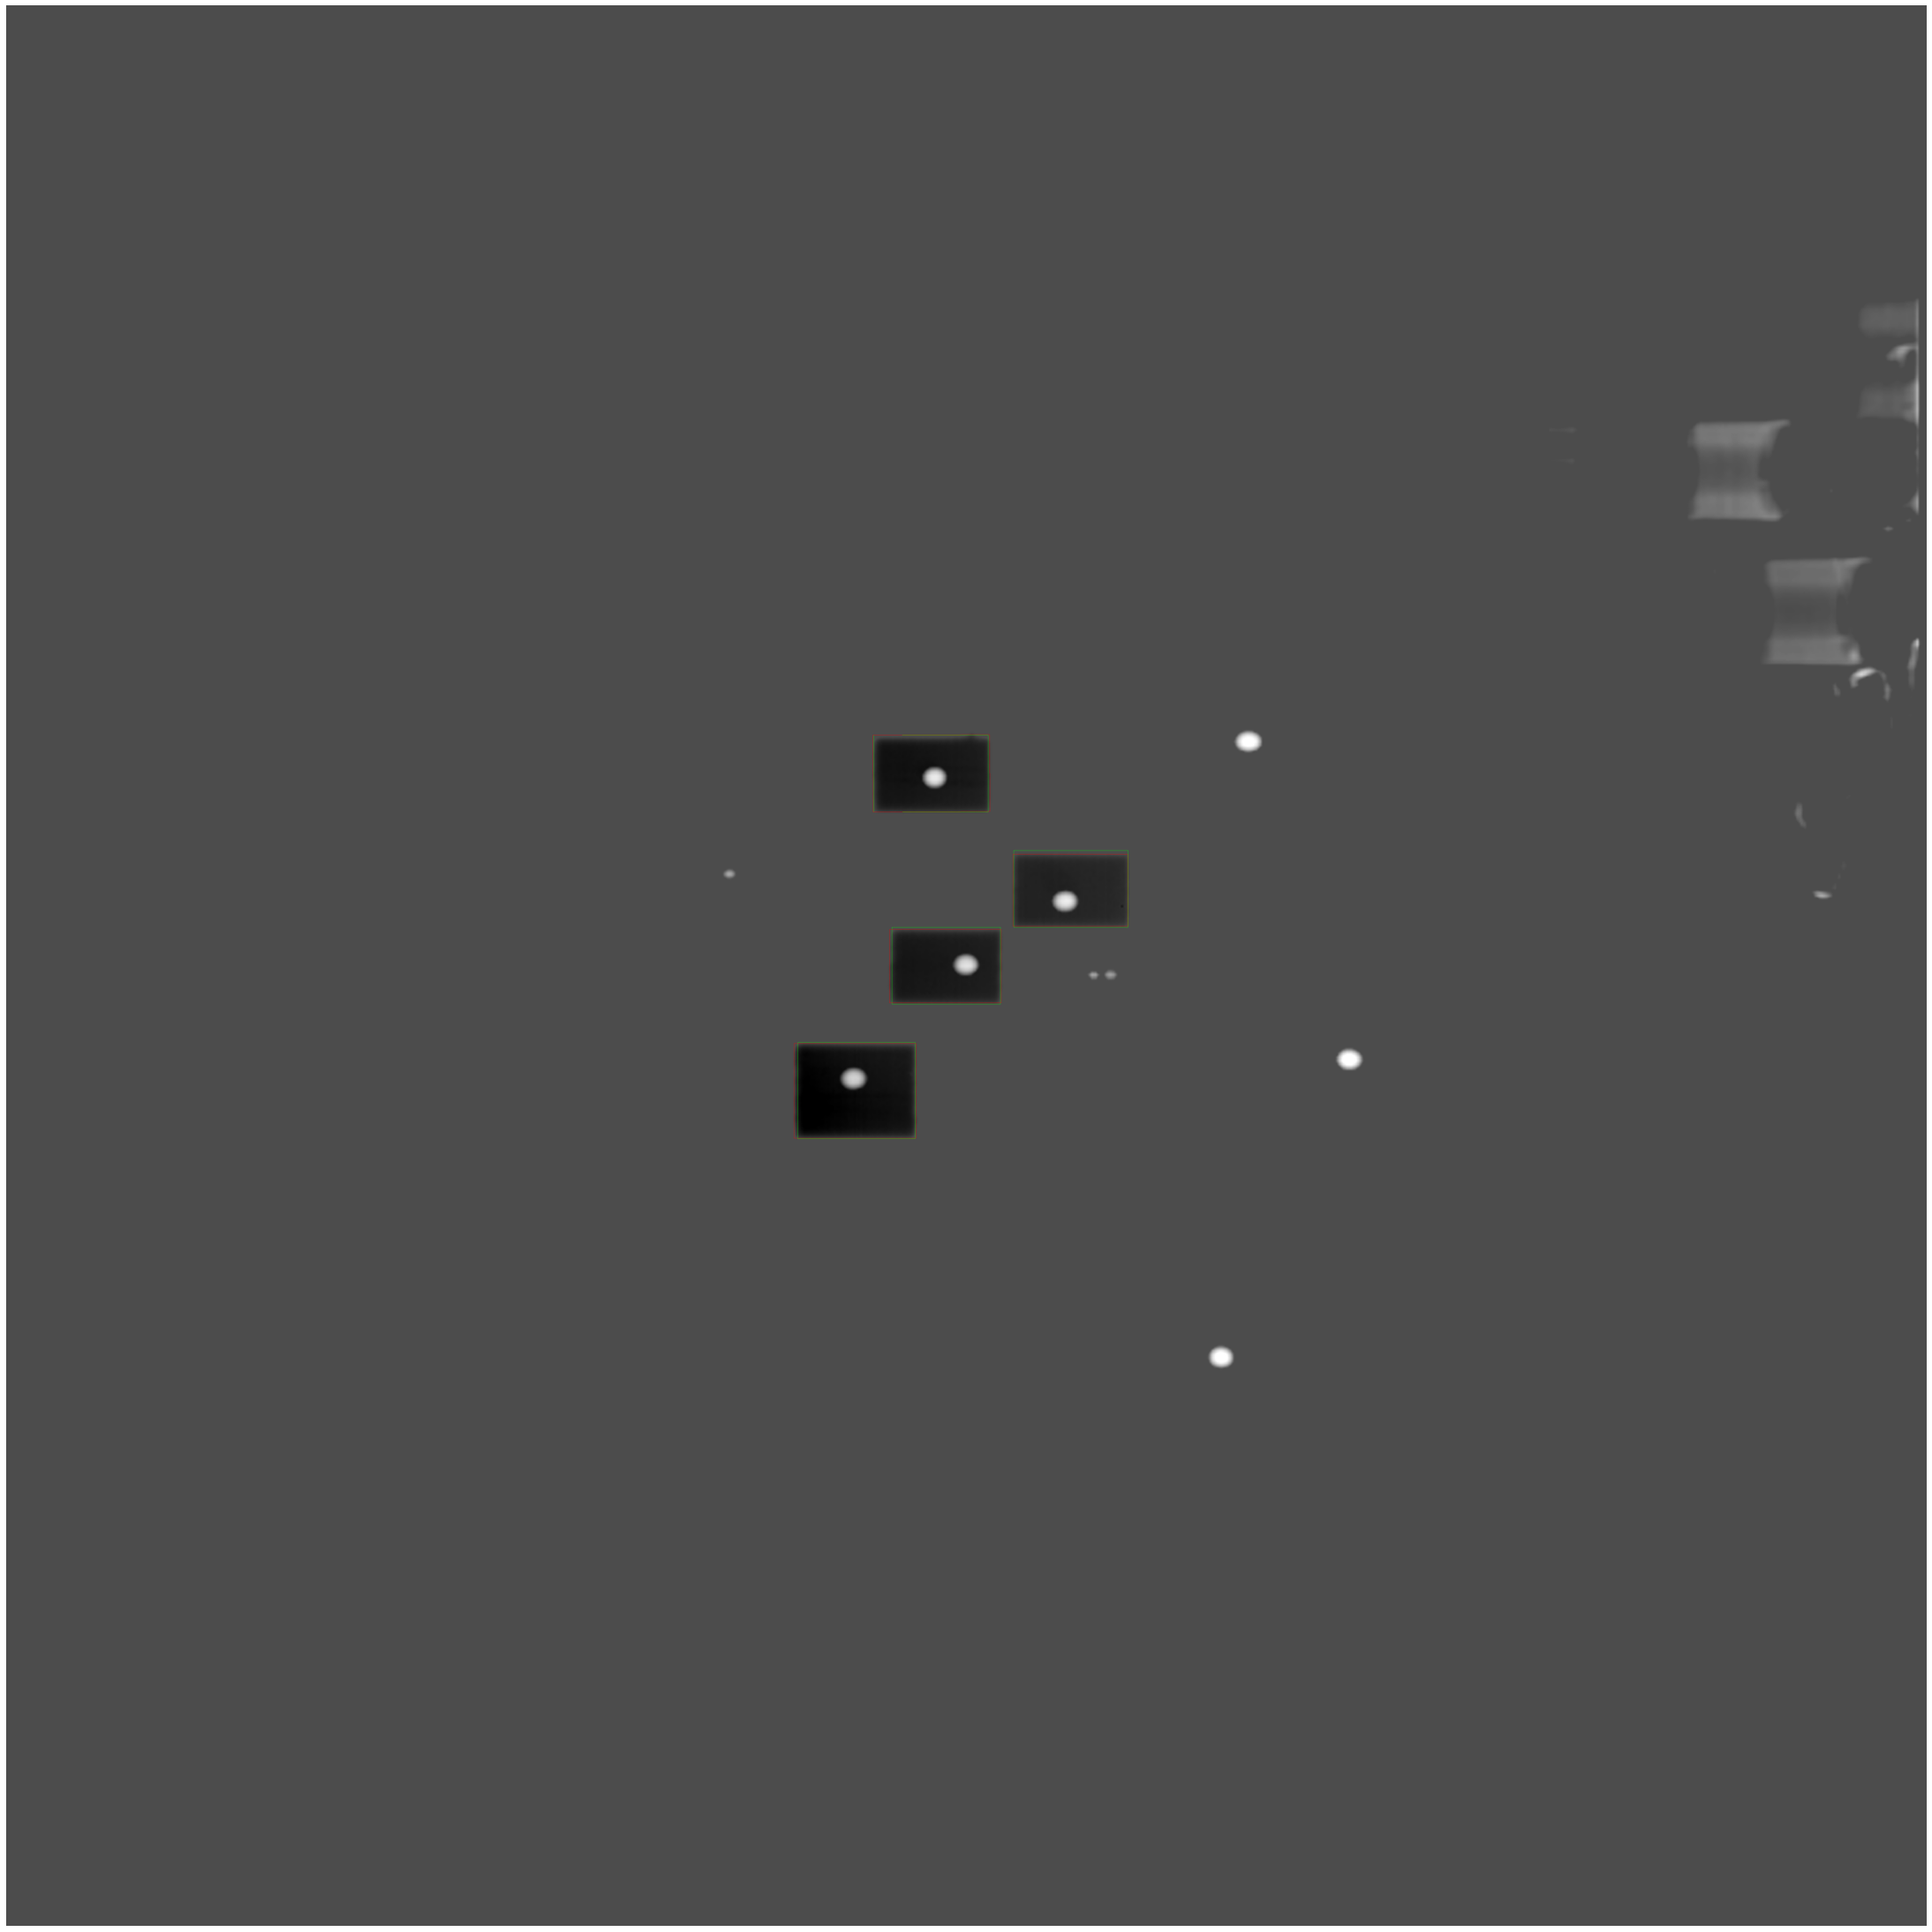

In [345]:
for i, image_name, drr_new_coordinates_singular, epid_coordinates in zip(range(0, len(drr_images_interpol_windowed_names)), drr_images_interpol_windowed_names, new_coordinates_arr, new_boxes_per_images):

    img = np.zeros([hh, ww, 3], dtype=np.uint8)
    img.fill(255)

    img[0:yoff, :] = [255, 255, 255]
    img[yoff + h_mov:hh, :] =  [255, 255, 255]

    img[:, 0:xoff] = [255, 255, 255]
    img[:, xoff + w_mov:hh] =  [255, 255, 255]

    epid_temp = cv2.imread(epid_images_interpol_windowed_names[i])
    epid_temp = cv2.cvtColor(epid_temp, cv2.COLOR_BGR2RGB)
   
    img[yoff:hh-yoff, xoff:hh-xoff] = epid_temp 

    drr_temp = cv2.imread(drr_images_interpol_windowed_names[i])
    drr_temp = cv2.cvtColor(drr_temp, cv2.COLOR_BGR2RGB)
    
    fixed = np.asarray(drr_temp, np.uint8)

    moving_blending = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fixed_blending = cv2.cvtColor(fixed, cv2.COLOR_BGR2RGB)

    dst = cv2.addWeighted(fixed_blending, 0.8, moving_blending, 0.3, 0.0)
    
        #drr
    for drr_new_coordinates, epid_new_coordinates in zip(drr_new_coordinates_singular, epid_coordinates):
        dst = cv2.line(dst, (round(drr_new_coordinates[0][0]), round(drr_new_coordinates[0][1])), (round(drr_new_coordinates[1][0]), round(drr_new_coordinates[1][1])), (0, 255, 0), 1)
        dst = cv2.line(dst, (round(drr_new_coordinates[1][0]), round(drr_new_coordinates[1][1])), (round(drr_new_coordinates[2][0]), round(drr_new_coordinates[2][1])), (0, 255, 0), 1)
        dst = cv2.line(dst, (round(drr_new_coordinates[2][0]), round(drr_new_coordinates[2][1])), (round(drr_new_coordinates[3][0]), round(drr_new_coordinates[3][1])), (0, 255, 0), 1)
        dst = cv2.line(dst, (round(drr_new_coordinates[3][0]), round(drr_new_coordinates[3][1])), (round(drr_new_coordinates[0][0]), round(drr_new_coordinates[0][1])), (0, 255, 0), 1)

        dst = cv2.line(dst, (round(epid_new_coordinates[0][0]), round(epid_new_coordinates[0][1])), (round(epid_new_coordinates[1][0]), round(epid_new_coordinates[1][1])), (255, 0, 0), 1)
        dst = cv2.line(dst, (round(epid_new_coordinates[1][0]), round(epid_new_coordinates[1][1])), (round(epid_new_coordinates[2][0]), round(epid_new_coordinates[2][1])), (255, 0, 0), 1)
        dst = cv2.line(dst, (round(epid_new_coordinates[2][0]), round(epid_new_coordinates[2][1])), (round(epid_new_coordinates[3][0]), round(epid_new_coordinates[3][1])), (255, 0, 0), 1)
        dst = cv2.line(dst, (round(epid_new_coordinates[3][0]), round(epid_new_coordinates[3][1])), (round(epid_new_coordinates[0][0]), round(epid_new_coordinates[0][1])), (255, 0, 0), 1)

        
    plt.figure(figsize=(50,40))
    plt.axis('off')
    plt.imshow(dst)
    plt.show()

In [331]:
epid_images_interpol_windowed_names

['EPID_windowed\\Interpol_RI_C1_ANT.tiff',
 'EPID_windowed\\Interpol_RI_C1_LAT_D.tiff',
 'EPID_windowed\\Interpol_RI_C1_LAT_G.tiff',
 'EPID_windowed\\Interpol_RI_C1_POST.tiff']